
## Demand forecasting for upcoming weeks

### Content
Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:

Historical data of demand for a product-center combination (Weeks: 1 to 145)

Product(Meal) features such as category, sub-category, current price and discount

Information for fulfillment center like center area, city information etc.

### Evaluation Metric
The evaluation metric for this competition is 100*RMSLE where RMSLE is Root of Mean Squared Logarithmic Error across all entries in the test set.

### My plan
**1. First glance of the data**

**2. Data cleaning and aggregation**

**3. Exploratory Data Analysis - Univariate & Bivariate**

**4. Data Preprocessing & Feature Engineering**

**5. Modelling - single method & ensembling method**

## First glance of the data

In [2]:
!pip install -U pandasql

  Using cached https://files.pythonhosted.org/packages/6b/c4/ee4096ffa2eeeca0c749b26f0371bd26aa5c8b611c43de99a4f86d3de0a7/pandasql-0.7.3.tar.gz
  Created wheel for pandasql: filename=pandasql-0.7.3-cp27-none-any.whl size=26837 sha256=d99a89bc2a4896f16866758fd1c20e8f34194d46e7f4fe474115f01915bb17f7
  Stored in directory: C:\Users\zyang672\AppData\Local\pip\Cache\wheels\53\6c\18\b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [3]:
! pip install xgboost

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from math import log
from pandasql import sqldf

In [177]:
meal_info = pd.read_csv("meal_info.csv")
sample_submission = pd.read_csv("sample_submission.csv")
fulfilment_center_info = pd.read_csv("fulfilment_center_info.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [178]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [179]:
meal_info.info()
# meal_info describes each kind of meals the company can provide

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [180]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          32573 non-null  int64
 1   num_orders  32573 non-null  int64
dtypes: int64(2)
memory usage: 509.1 KB


In [181]:
fulfilment_center_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


### At the first glance:
1. The final goal of this task is to predict the number of order in a week for each kind of meals in each fullfilment center.
2. There are 5 csv tables: train and test datasets, meal_info and fulfilment_center_info which are additive information about the meal and fulfilment center, and sample_submission which is sumbission format.
3. At the begining of task, I plan to predict the demand in two ways. Firstly, think it as a regression problem, and treat all of the meal info, center info, together with the week as featurs. And secondly, think it as a time series prodiction. We have the historical data for almost 3 years, and it's straightforward to utilizing those data to prodiect the future demand.

## Data cleaning and aggregation

In [182]:
pysqldf = lambda q: sqldf(q, globals())

In [183]:
q = "SELECT * FROM train AS t JOIN meal_info AS m ON t.meal_id = m.meal_id;"
data = pysqldf(q)
data.head()

id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   

   emailer_for_promotion  homepage_featured  num_orders  meal_id   category  \
0                      0                  0         177     1885  Beverages   
1                      0                  0         270     1993  Beverages   
2                      0                  0         189     2539  Beverages   
3                      0                  0          54     2139  Beverages   
4                      0                  0          40     2631  Beverages   

  cuisine  
0    Thai  
1    Thai  
2    Thai  
3  Indian  
4  Indian

In [184]:
q = "SELECT * FROM data AS d JOIN fulfilment_center_info AS f ON d.center_id = f.center_id;"
train_data = pysqldf(q)
train_data.head()

id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   

   emailer_for_promotion  homepage_featured  num_orders   category cuisine  \
0                      0                  0         177  Beverages    Thai   
1                      0                  0         270  Beverages    Thai   
2                      0                  0         189  Beverages    Thai   
3                      0                  0          54  Beverages  Indian   
4                      0                  0          40  Beverages  Indian   

   center_id  city_code  region_code center_type  op_area  
0         55        647           56      TYPE_C      2.0  
1         55        647           56      TYPE_C      2.0  
2         55        647           56      TYPE_C      2.0  
3         55        647           56      TYPE_C      2.0  
4         55        647           56      TYPE_C      2.0

In [185]:
# Aggregate test data in the same way
q = "SELECT * FROM test AS t JOIN meal_info AS m ON t.meal_id = m.meal_id;"
data = pysqldf(q)
q = "SELECT * FROM data AS d JOIN fulfilment_center_info AS f ON d.center_id = f.center_id;"
test_data = pysqldf(q)

In [186]:
train_data.info()
# There are 10 continous features and 3 categorical features apart from id. 
# The target field is "num_orders"
# Seems no missing value. Further data cleaning will be conduct in the EDA part. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   category               456548 non-null  object 
 10  cuisine                456548 non-null  object 
 11  center_id              456548 non-null  int64  
 12  city_code              456548 non-null  int64  
 13  region_code            456548 non-null  int64  
 14  center_type            456548 non-nu

In [187]:
train_data.describe().T

count          mean            std         min  \
id                     456548.0  1.250096e+06  144354.822378  1000000.00   
week                   456548.0  7.476877e+01      41.524956        1.00   
center_id              456548.0  8.210580e+01      45.975046       10.00   
meal_id                456548.0  2.024337e+03     547.420920     1062.00   
checkout_price         456548.0  3.322389e+02     152.939723        2.97   
base_price             456548.0  3.541566e+02     160.715914       55.35   
emailer_for_promotion  456548.0  8.115247e-02       0.273069        0.00   
homepage_featured      456548.0  1.091999e-01       0.311890        0.00   
num_orders             456548.0  2.618728e+02     395.922798       13.00   
center_id              456548.0  8.210580e+01      45.975046       10.00   
city_code              456548.0  6.015534e+02      66.195914      456.00   
region_code            456548.0  5.661457e+01      17.641306       23.00   
op_area                456548.0  4.083590e+00       1.091686        0.90   

                              25%         50%         75%         max  
id                     1124998.75  1250183.50  1375140.25  1499999.00  
week                        39.00       76.00      111.00      145.00  
center_id                   43.00       76.00      110.00      186.00  
meal_id                   1558.00     1993.00     2539.00     2956.00  
checkout_price             228.95      296.82      445.23      866.27  
base_price                 243.50      310.46      458.87      866.27  
emailer_for_promotion        0.00        0.00        0.00        1.00  
homepage_featured            0.00        0.00        0.00        1.00  
num_orders                  54.00      136.00      324.00    24299.00  
center_id                   43.00       76.00      110.00      186.00  
city_code                  553.00      596.00      651.00      713.00  
region_code                 34.00       56.00       77.00       93.00  
op_area                      3.60        4.00        4.50        7.00

In [188]:
# statistical summary of categorical data attributes
train_data.describe(include = np.object).T

count unique        top    freq
category     456548     14  Beverages  127890
cuisine      456548      4    Italian  122925
center_type  456548      3     TYPE_A  262881

In [189]:
# clean redundant columns 
train_label = train_data["num_orders"]
#train_data = train_data.drop(["num_orders", "id", "meal_id", "center_id"], axis=1)
train_data = train_data.drop(["id", "meal_id", "center_id"], axis=1)
test_data = test_data.drop(["id", "meal_id", "center_id"], axis=1)

## Exploratory Data Analysis - Univariate

### Numeric Features

In [190]:
Numeric_features = train_data.describe().drop(columns=['num_orders']).columns
Categorical_features = train_data.describe(include=np.object).columns

array([[<AxesSubplot:title={'center':'week'}>,
        <AxesSubplot:title={'center':'checkout_price'}>,
        <AxesSubplot:title={'center':'base_price'}>],
       [<AxesSubplot:title={'center':'emailer_for_promotion'}>,
        <AxesSubplot:title={'center':'homepage_featured'}>,
        <AxesSubplot:title={'center':'city_code'}>],
       [<AxesSubplot:title={'center':'region_code'}>,
        <AxesSubplot:title={'center':'op_area'}>, <AxesSubplot:>]],
      dtype=object)

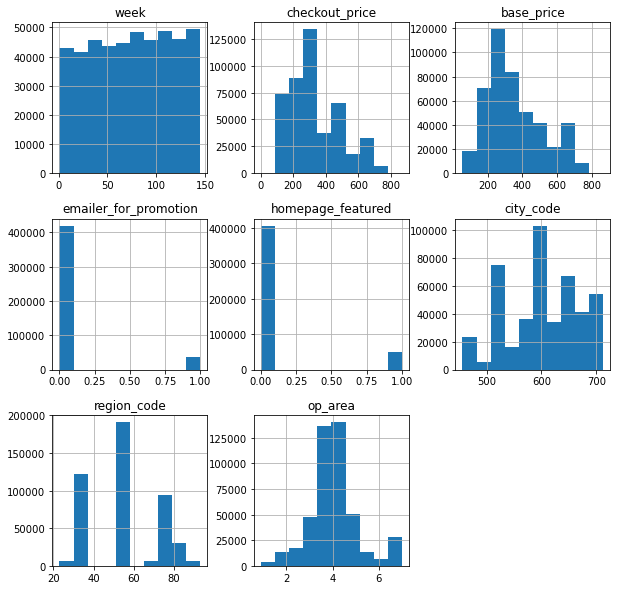

In [191]:
train_data[Numeric_features].hist(figsize=(10, 10))

In [192]:
# numeric feature's skewness
for feature in Numeric_features:
    print("Skew in", feature, round(train_data[feature].skew(), 2))

Skew in week -0.05
Skew in checkout_price 0.67
Skew in base_price 0.64
Skew in emailer_for_promotion 3.07
Skew in homepage_featured 2.51
Skew in city_code -0.21
Skew in region_code 0.06
Skew in op_area 0.66


From the initial EDA, histogram of numeric features we can see:

1. two features, emailer_for_promotion and homepage_featured are actually binary features, not numrical features.
2. two features, region_code and city_code are index and have no real numerical meaning. Further EDA will decide if we take them as categorical features or still numrical features.
3. the feature of week, considering the seasoning effect, will not have linear contribution to the number_orders, so it may not perform well in a linear model like liner regression.
4. for all numeric features, there is no obvious outlier.

In [193]:
train_data["emailer_for_promotion"] = train_data.emailer_for_promotion.astype('category')
train_data["homepage_featured"] = train_data.homepage_featured.astype('category')
test_data["emailer_for_promotion"] = test_data.emailer_for_promotion.astype('category')
test_data["homepage_featured"] = test_data.homepage_featured.astype('category')

In [194]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   week                   456548 non-null  int64   
 1   checkout_price         456548 non-null  float64 
 2   base_price             456548 non-null  float64 
 3   emailer_for_promotion  456548 non-null  category
 4   homepage_featured      456548 non-null  category
 5   num_orders             456548 non-null  int64   
 6   category               456548 non-null  object  
 7   cuisine                456548 non-null  object  
 8   city_code              456548 non-null  int64   
 9   region_code            456548 non-null  int64   
 10  center_type            456548 non-null  object  
 11  op_area                456548 non-null  float64 
dtypes: category(2), float64(3), int64(4), object(3)
memory usage: 35.7+ MB


### Categorical Features

In [195]:
Numeric_features = train_data.describe().columns
Categorical_features = train_data.describe(include=np.object).columns

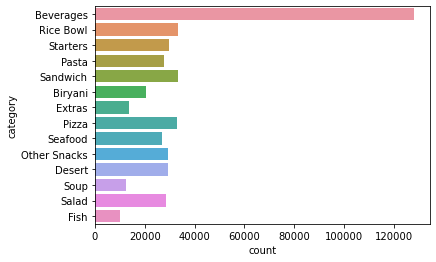

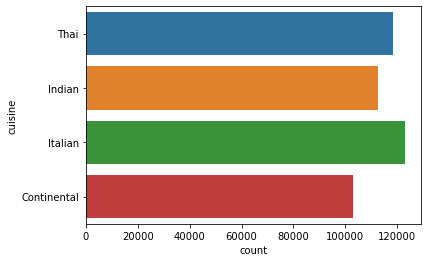

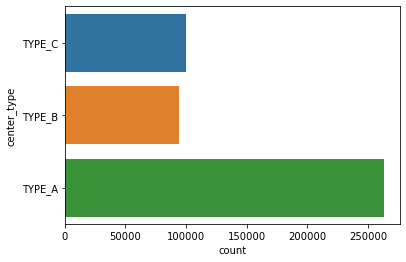

In [196]:
for feature in Categorical_features:
    ax=sns.countplot(y=feature, data=train_data)
    plt.show()

From the univariate EDA for categorical features we can see:

1. for all categorical features, there is no obvious outlier and missing value
2. except "cuisine", other features all have unbalanced distribution on some level.

### Target feature analysis

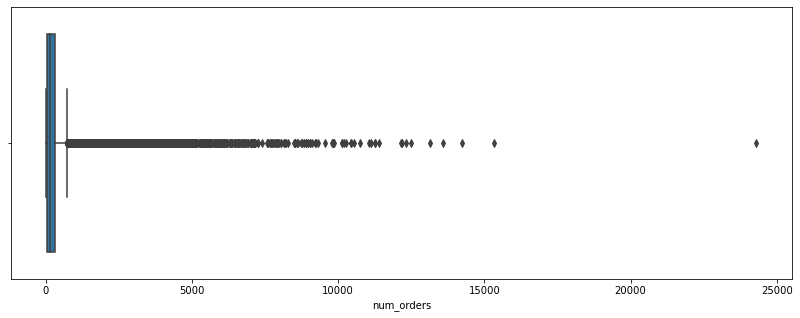

the average of num_orders is 261.8727603669275
the quantiles of num_orders are 0.25     54.0
0.75    324.0
Name: num_orders, dtype: float64


In [197]:
plt.figure(figsize=(14, 5))
ax = sns.boxplot(x="num_orders", data=train_data)
plt.show()
print("the average of num_orders is", train_data.num_orders.mean())
print("the quantiles of num_orders are", train_data.num_orders.quantile([0.25, 0.75]))
# Seems the num_orders has some outliers.

In [198]:
# placeholder for dealing with outliers

## Exploratory Data Analysis - Bivariate

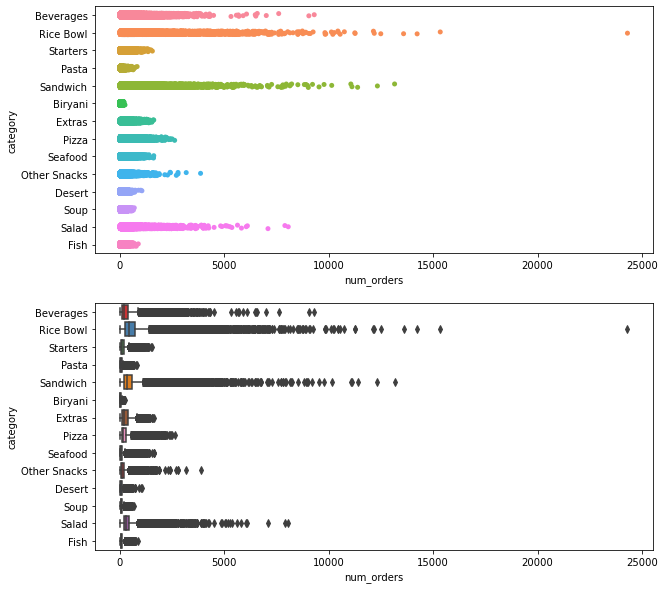

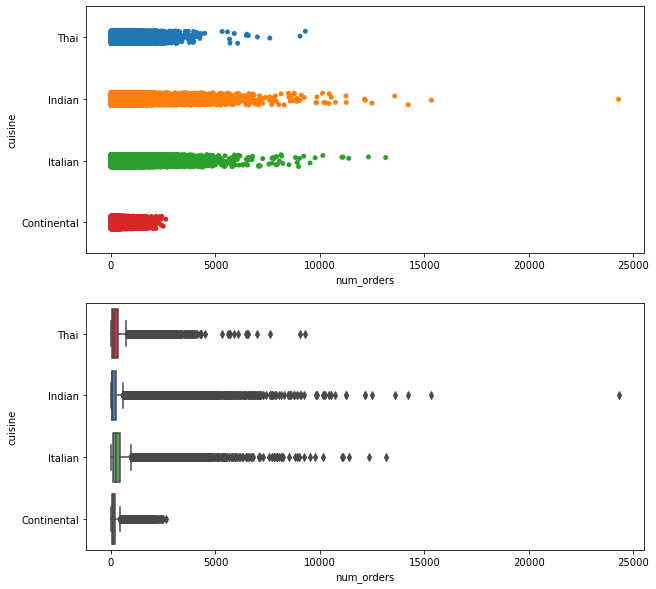

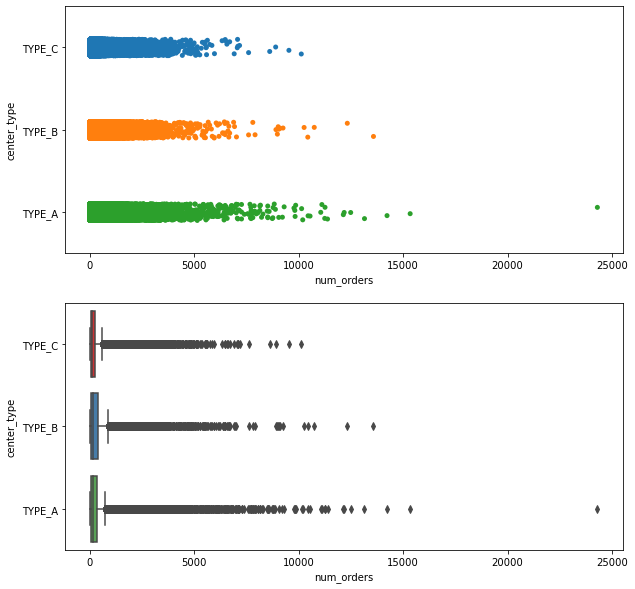

In [199]:
# Categorical feature's relation with the target, num_orders
for feature in Categorical_features:
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    ax=sns.stripplot(y=feature, x="num_orders", data=train_data)
    ax.set(ylabel=feature)
    #annot(ax)
    plt.subplot(2,1,2)
    ax=sns.boxplot(x="num_orders", y=feature, data=train_data, palette='Set1')
    #annot(ax)
    plt.show()
    #sns.countplot(x=feature, data=income)

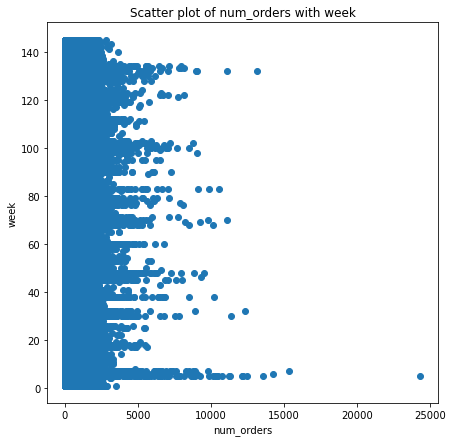

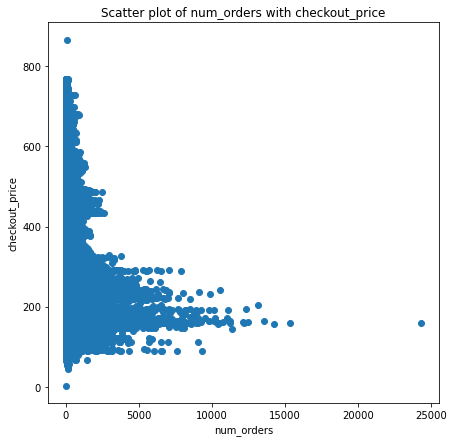

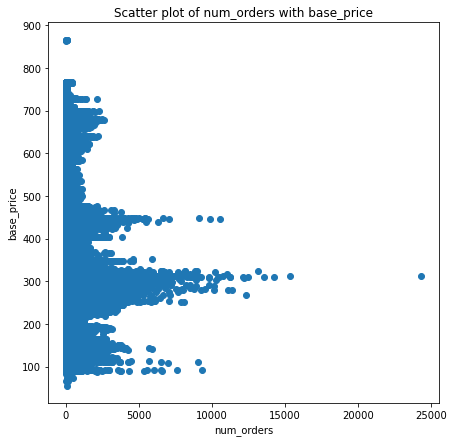

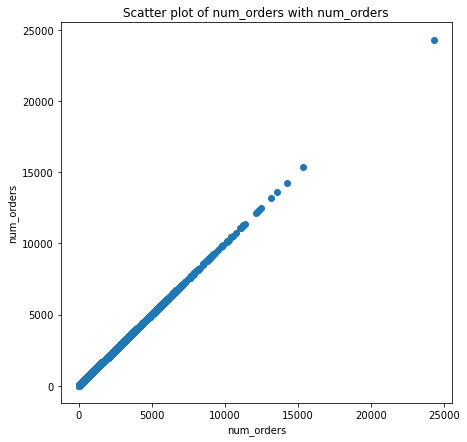

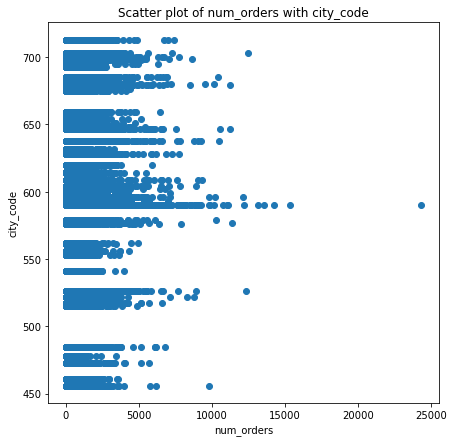

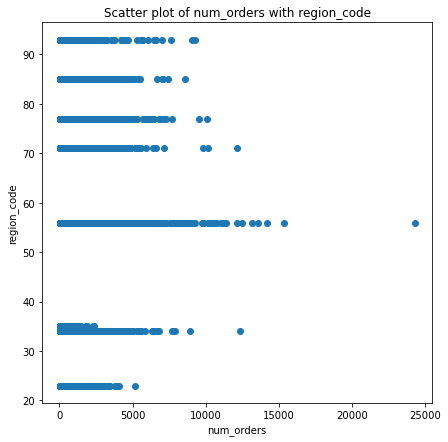

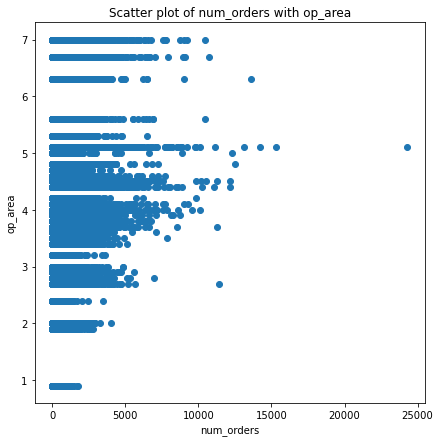

In [200]:
# numeric feature's relation with the target, num_orders
for feature in Numeric_features:
    plt.figure(figsize=(7,7))
    plt.scatter(x=train_data["num_orders"], y=train_data[feature])
    plt.xlabel("num_orders")
    plt.ylabel(feature)
    plt.title("Scatter plot of num_orders with "+feature)
    plt.show()

Group by feature emailer_for_promotion


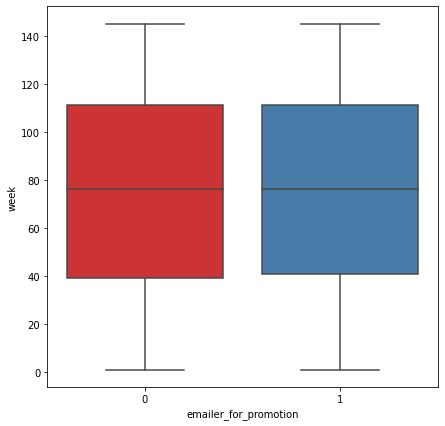

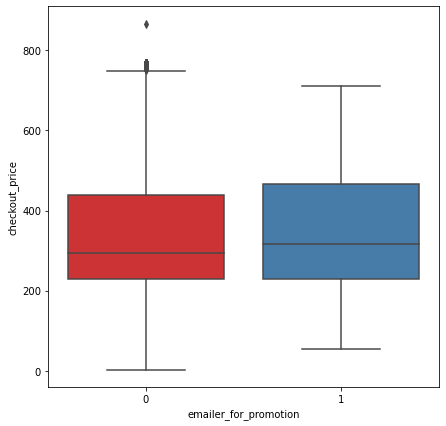

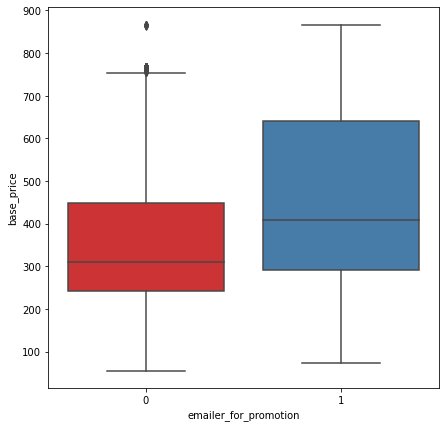

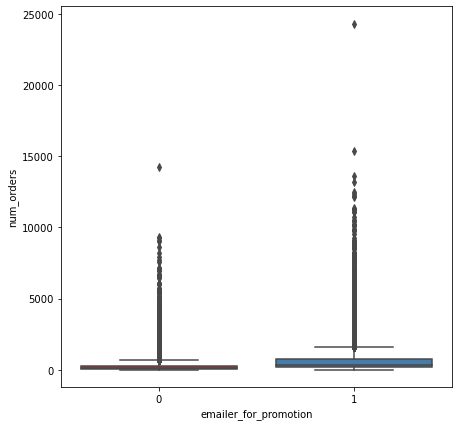

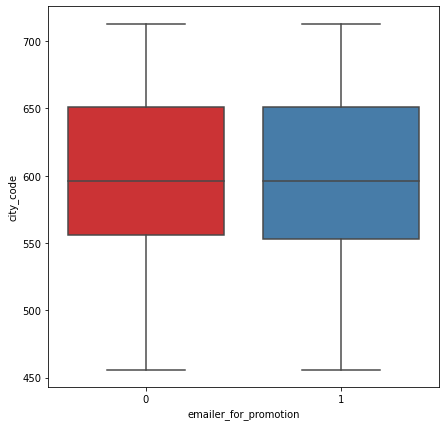

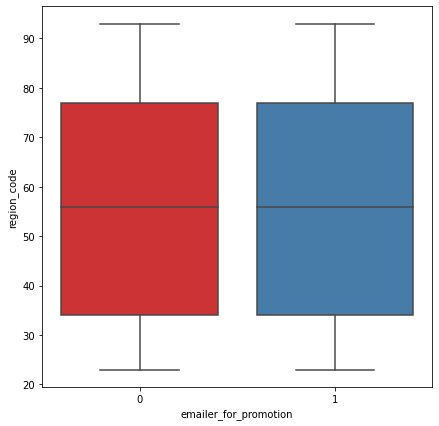

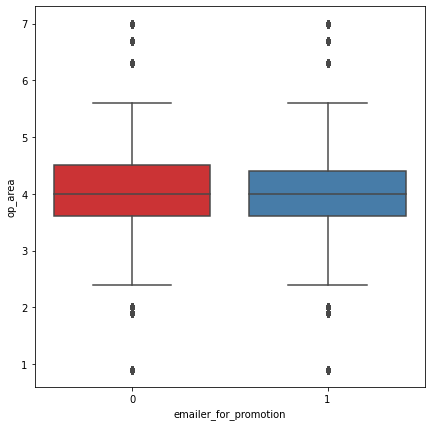

Group by feature emailer_for_promotion


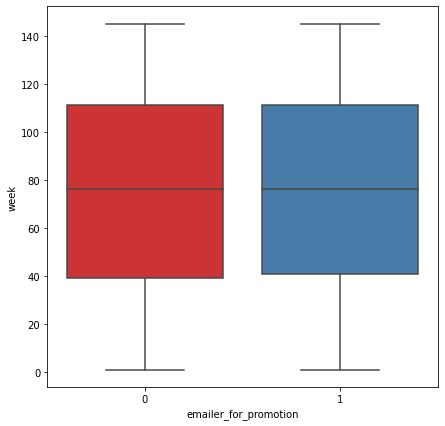

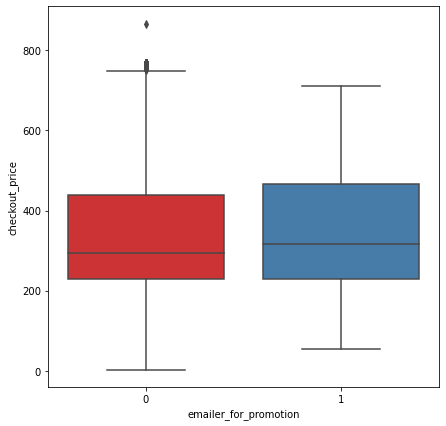

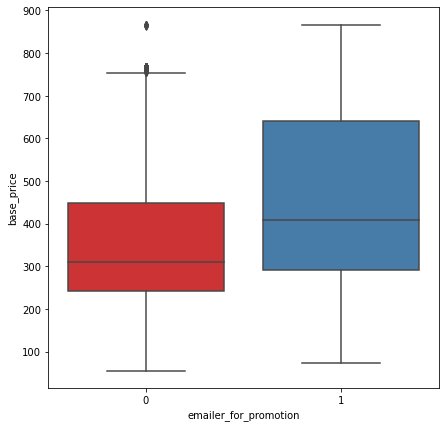

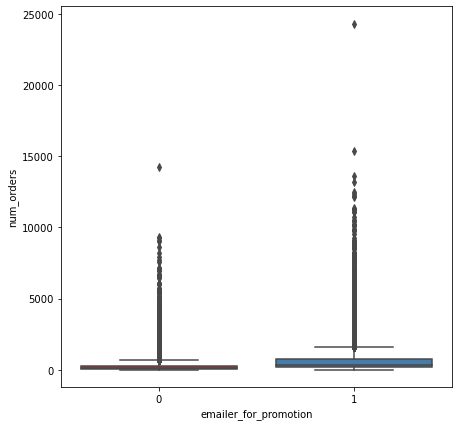

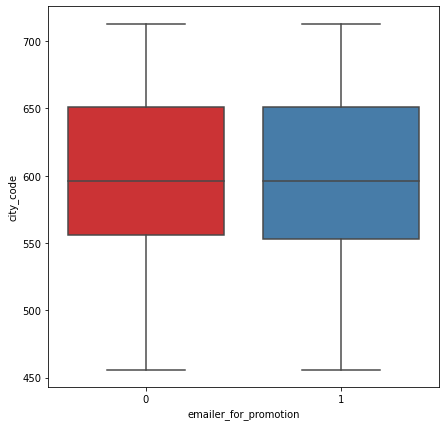

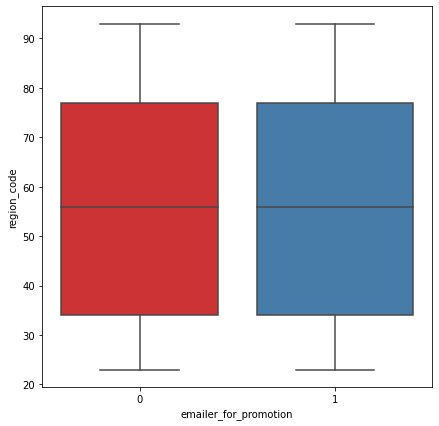

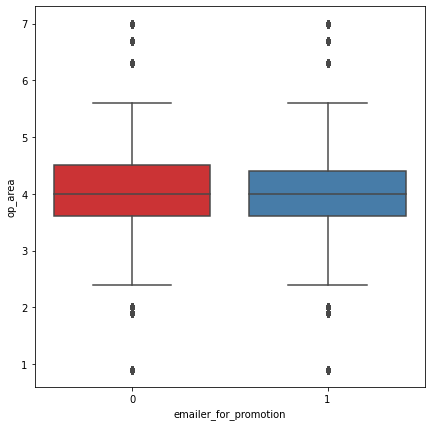

Group by feature cuisine


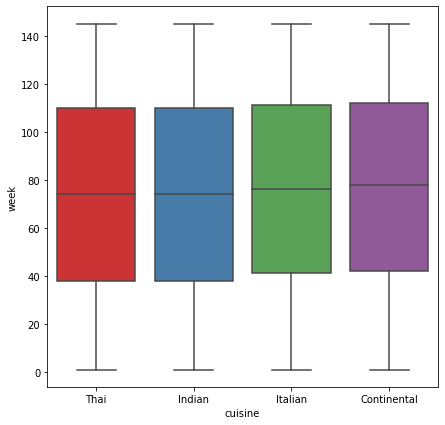

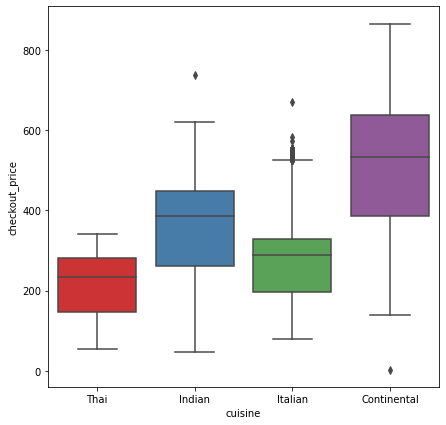

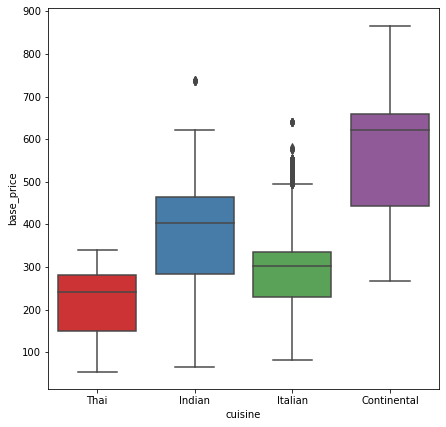

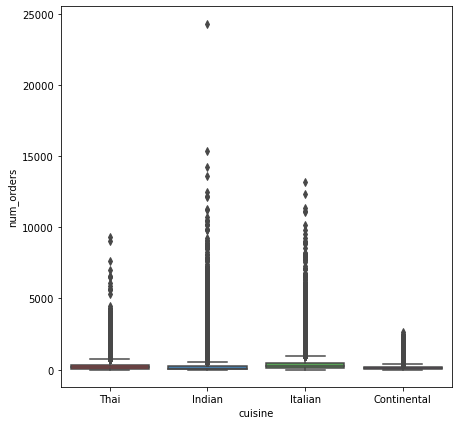

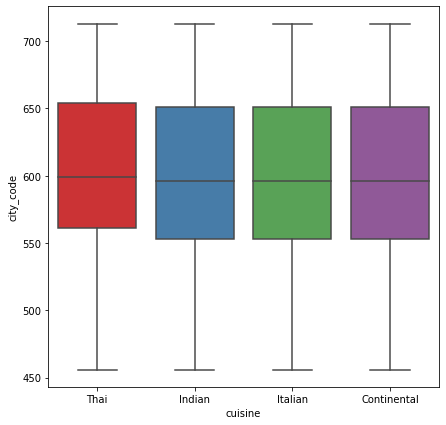

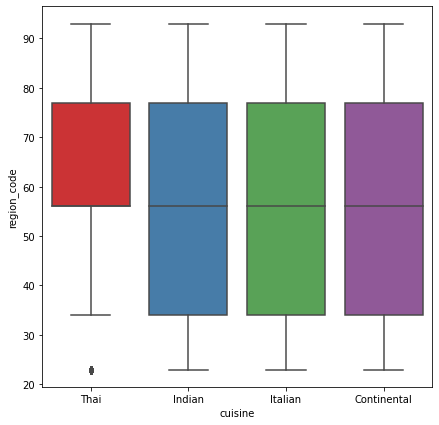

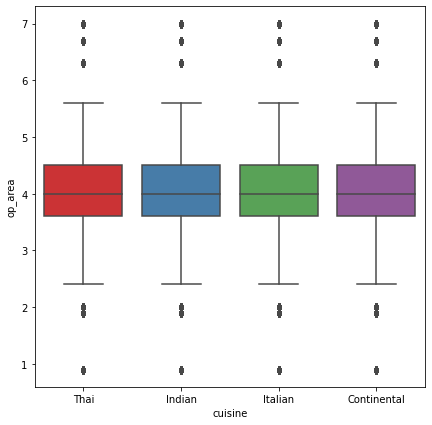

Group by feature center_type


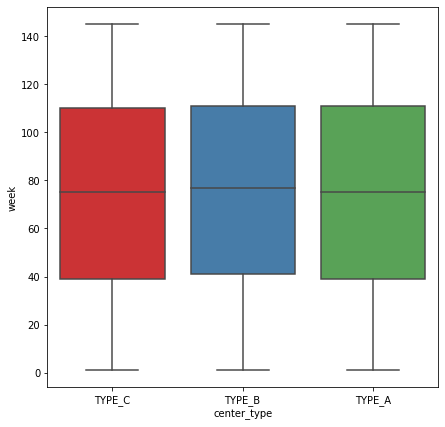

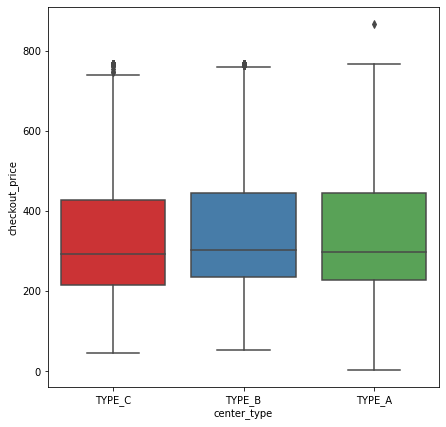

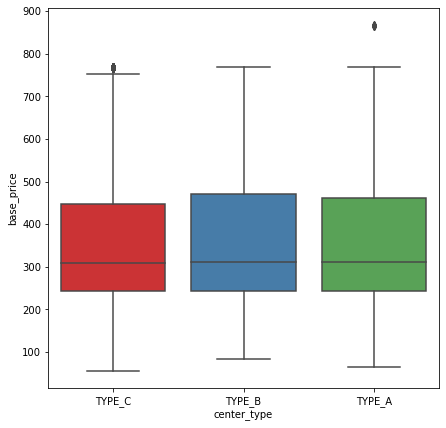

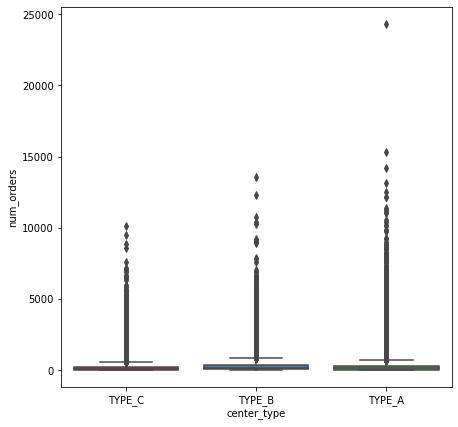

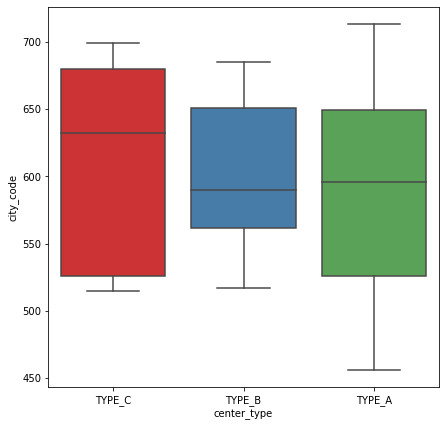

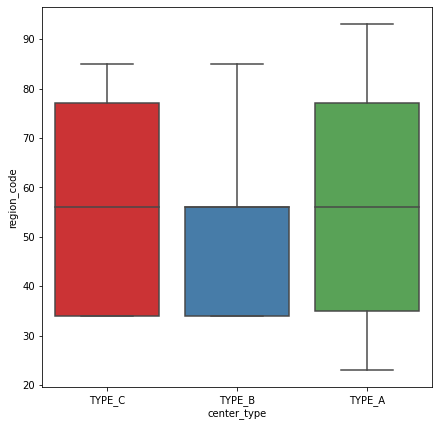

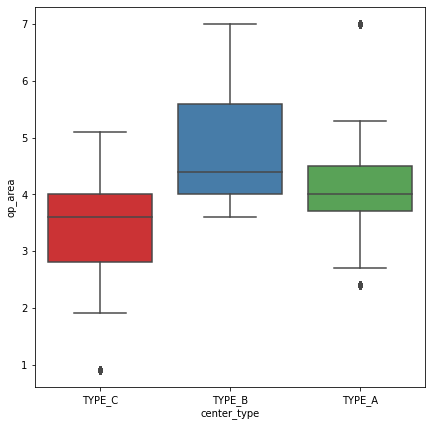

In [201]:
# numeric features' relation with categorical features
selected_features = ["emailer_for_promotion", "emailer_for_promotion", "cuisine", "center_type"]
for cat_feature in selected_features:
    print("Group by feature " + cat_feature)
    for num_feature in Numeric_features:
        plt.figure(figsize=(7,7))
        ax=sns.boxplot(y=num_feature, x=cat_feature, data=train_data, palette='Set1')
        #annot(ax)
        plt.show()

<AxesSubplot:>

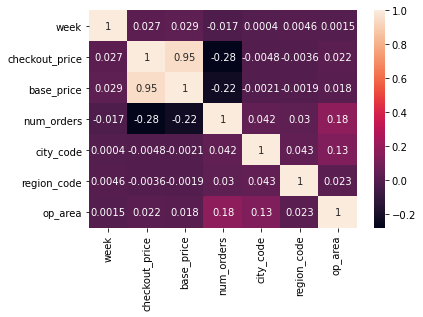

In [202]:
# correlation between numeric features
cor = train_data.corr()
sns.heatmap(cor, annot=True)

From the EDA we can see:

    1. features, no matter categorical or numeric, don't see too much correlation with others, except for "checkout_price" and "base_price".
    2. the target variable, "num_order", doesn't show too much linear relationship with numeric features. Therefore, we can reasonable infer that linear methods of regression, such as linear regresssion, linear SVM won't have great performance. On the other side, some tree based methods, such as random forest and KNN may have better performance.
    3. the two numeric features, "region_code" and ""city_code" should be nominal variable 

## Data Preprocessing & Feature Engineering

In [203]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

### Categorical features

In [204]:
# transform "region_code" and ""city_code" to nominal variable
train_data["region_code"] = train_data["region_code"].astype("object")
test_data["region_code"] = test_data["region_code"].astype("object")
train_data["city_code"] = train_data["city_code"].astype("object")
test_data["city_code"] = test_data["city_code"].astype("object")

# one hot coding for categorical data
categorical_features = train_data.describe(include="object").T.index
label_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

one_hot_train = label_encoder.fit_transform(train_data[categorical_features])
one_hot_train = pd.DataFrame(one_hot_train, index=train_data.index, columns=label_encoder.get_feature_names(categorical_features))
#one_hot_test = label_encoder.fit_transform(test_data[categorical_features]).toarray()
one_hot_test = pd.DataFrame(one_hot_train, index=test_data.index, columns=label_encoder.get_feature_names(categorical_features))

### Numeric features

In [205]:
train_label = train_data["num_orders"]
x_train = train_data.drop(columns=["num_orders"])
x_test = test_data
numeric_features = x_train.describe().columns

# Normalize numerical data
sc_X = StandardScaler()
x_train[numeric_features] = sc_X.fit_transform(x_train[numeric_features])
x_test[numeric_features] = sc_X.transform(x_test[numeric_features])
x_train.head()

week  checkout_price  base_price emailer_for_promotion  \
0 -1.776494       -1.277687   -1.256048                     0   
1 -1.776494       -1.277687   -1.358465                     0   
2 -1.776494       -1.290568   -1.358278                     0   
3 -1.776494        0.047477    0.518763                     0   
4 -1.776494       -0.580222   -0.694746                     0   

  homepage_featured   category cuisine city_code region_code center_type  \
0                 0  Beverages    Thai       647          56      TYPE_C   
1                 0  Beverages    Thai       647          56      TYPE_C   
2                 0  Beverages    Thai       647          56      TYPE_C   
3                 0  Beverages  Indian       647          56      TYPE_C   
4                 0  Beverages  Indian       647          56      TYPE_C   

   op_area  
0  -1.9086  
1  -1.9086  
2  -1.9086  
3  -1.9086  
4  -1.9086

In [206]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   week                   456548 non-null  float64 
 1   checkout_price         456548 non-null  float64 
 2   base_price             456548 non-null  float64 
 3   emailer_for_promotion  456548 non-null  category
 4   homepage_featured      456548 non-null  category
 5   category               456548 non-null  object  
 6   cuisine                456548 non-null  object  
 7   city_code              456548 non-null  object  
 8   region_code            456548 non-null  object  
 9   center_type            456548 non-null  object  
 10  op_area                456548 non-null  float64 
dtypes: category(2), float64(4), object(5)
memory usage: 32.2+ MB


In [207]:
#x_train.drop(columns=categorical_features)
x_train = pd.concat([x_train.drop(columns=categorical_features), one_hot_train], axis=1)
#x_test.drop(columns=categorical_features)
x_test = pd.concat([x_test.drop(columns=categorical_features), one_hot_test], axis=1)

### Spilt dataset to training and validation 

In [208]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, train_label, random_state=10)


In [209]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342411 entries, 77150 to 345353
Data columns (total 86 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   week                   342411 non-null  float64 
 1   checkout_price         342411 non-null  float64 
 2   base_price             342411 non-null  float64 
 3   emailer_for_promotion  342411 non-null  category
 4   homepage_featured      342411 non-null  category
 5   op_area                342411 non-null  float64 
 6   category_Beverages     342411 non-null  float64 
 7   category_Biryani       342411 non-null  float64 
 8   category_Desert        342411 non-null  float64 
 9   category_Extras        342411 non-null  float64 
 10  category_Fish          342411 non-null  float64 
 11  category_Other Snacks  342411 non-null  float64 
 12  category_Pasta         342411 non-null  float64 
 13  category_Pizza         342411 non-null  float64 
 14  category_Rice Bo

In [210]:
y_valid.head()

263954     53
388552     40
80162     107
117029    150
443881    177
Name: num_orders, dtype: int64

## Modelling

According to my EDA analysis, in this section I will try 4 naive regression methods, linear regression, svr with non-linear kernel, KNN and decision tree together with 3 advanced methods, random tree, GDTB and neural network.

### Metrics

The metric I use in the task is RMLSE. On the RMLSE curve, we clearly see that the error increases rapidly as the underestimation of actual value increases. Whereas on the right-hand side, the error is not increasing as rapidly.

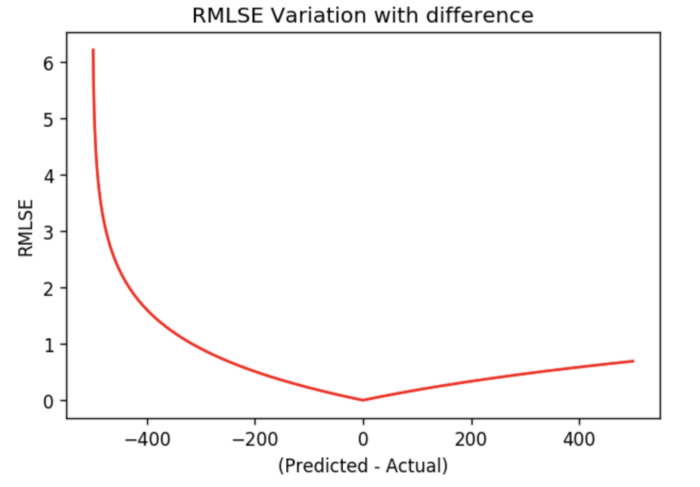

In [211]:
from math import log
def RMSLE(y_true, y_pred):
    """
        The Root Mean Squared Log Error (RMSLE) metric 
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    log_error_sum = 0
    y_true = y_true.tolist()
    for i in range(len(y_true)):
        log_error_sum += (log(y_true[i]+1, 10) - log(max(y_pred[i]+1, 1), 10)) ** 2
    return np.sqrt(log_error_sum/len(y_true))

In [212]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
def result(Y_TEST, PRED):
    print("MSE:\n", mean_squared_error(Y_TEST, PRED))
    print("MAE:\n", mean_absolute_error(Y_TEST, PRED))
    print("R2 score:\n", r2_score(Y_TEST, PRED))

In [213]:
def compare_in_plot(y_true, y_pred):
    plt.figure(figsize=(15, 5))
    num = 200
    x = range(num)
    plt.plot(x, y_true.tolist()[:num],color="r", marker='o', markersize=4)
    plt.plot(x, y_pred[:num], color="b", marker='o', markersize=4)
    plt.show()

In [269]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    #plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    


### Linear Regression

In [215]:
from sklearn.linear_model import LinearRegression
LRmodel = LinearRegression()
LRmodel.fit(x_train, y_train)
y_pred_lr = LRmodel.predict(x_valid)

In [220]:
result(y_valid, y_pred_lr)

MSE:
 87319.88563744762
MAE:
 162.24304998461278
R2 score:
 0.4403981166482692


In [221]:
RMSLE(y_valid, y_pred_lr)

0.7420932463213387

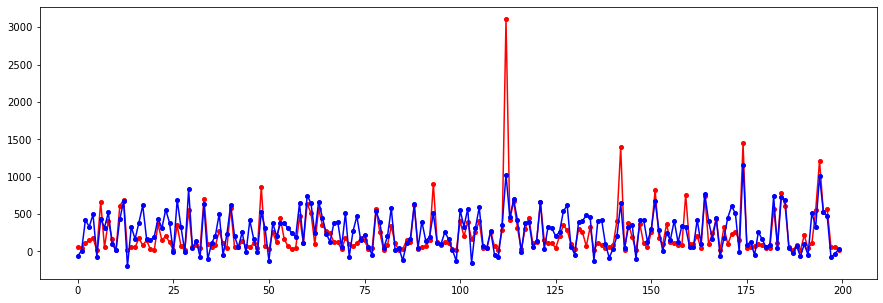

In [218]:
# visualize prediction result for the first 200 data samples
compare_in_plot(y_valid, y_pred_lr)

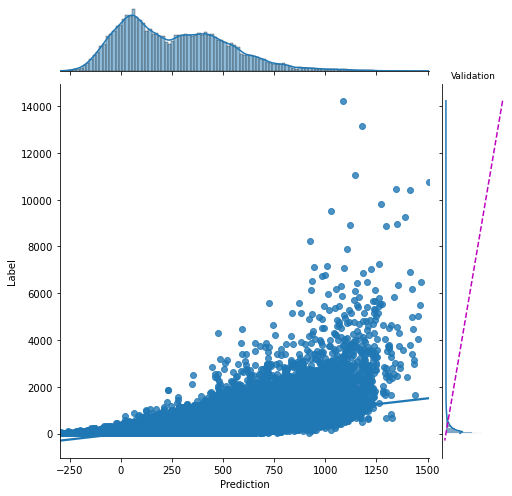

In [222]:
# model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
model_performance_sc_plot(y_pred_lr, y_valid, 'Validation')

In [271]:
y_pred_lr_test = LRmodel.predict(x_test)

Consider the number of orders has an average of 262 and the MAE is as high as 162, the performance for this algorithm is relative poor, which is as our expection. 

The performance visualization also confirms the result: when the actuall value is low, the prediction is kind of accurate. While for the minority cases with high value, the algorithm tend to predict lower than the actual value. 

### SVR

In [59]:
from sklearn.svm import SVR
SVRmodel = SVR()
SVRmodel.fit(x_train, y_train)
y_pred = SVRmodel.predict(x_valid)

In [60]:
result(y_valid, y_pred)

MSE:
 92743.01579343346
MAE:
 122.28274442789431
R2 score:
 0.4056432171566263


In [61]:
RMSLE(y_valid, y_pred)

0.2980029068796789

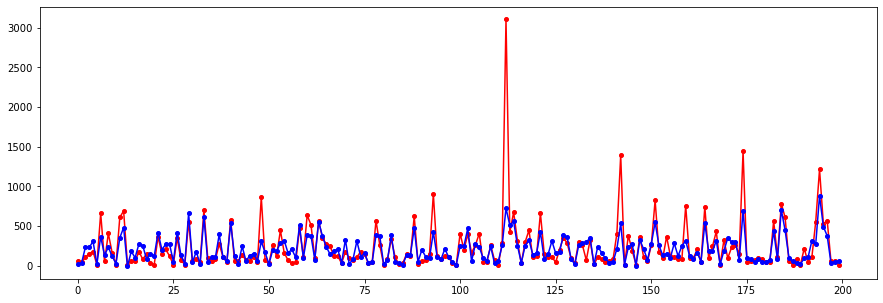

In [62]:
# visualize prediction result for the first 200 data samples
compare_in_plot(y_valid, y_pred)

### KNN

In [226]:
from sklearn.neighbors import KNeighborsRegressor
KNNmodel = KNeighborsRegressor()
KNNmodel.fit(x_train, y_train)
y_pred_knn = KNNmodel.predict(x_valid)

In [227]:
result(y_valid, y_pred_knn)

MSE:
 42051.44558031139
MAE:
 91.1724138535269
R2 score:
 0.7305073412245376


In [228]:
RMSLE(y_valid, y_pred_knn)

0.24530264637892177

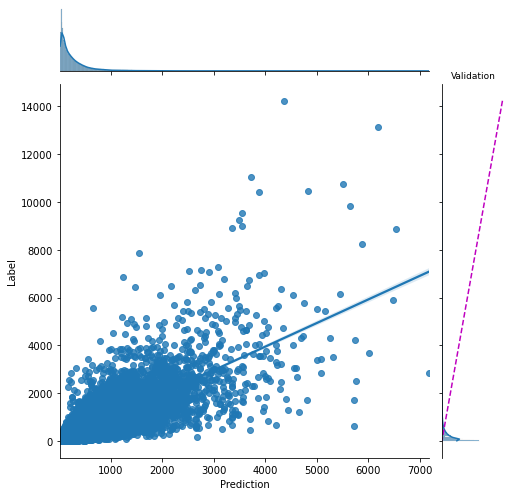

In [234]:
model_performance_sc_plot(y_pred_knn, y_valid, 'Validation')

In [272]:
y_pred_knn_test = KNNmodel.predict(x_test)

In [229]:
KNNmodel = KNeighborsRegressor(weights="distance")
KNNmodel.fit(x_train, y_train)
y_pred_knn1 = KNNmodel.predict(x_valid)

In [230]:
result(y_valid, y_pred_knn1)

MSE:
 39448.465088938625
MAE:
 91.05634679380292
R2 score:
 0.7471889112319464


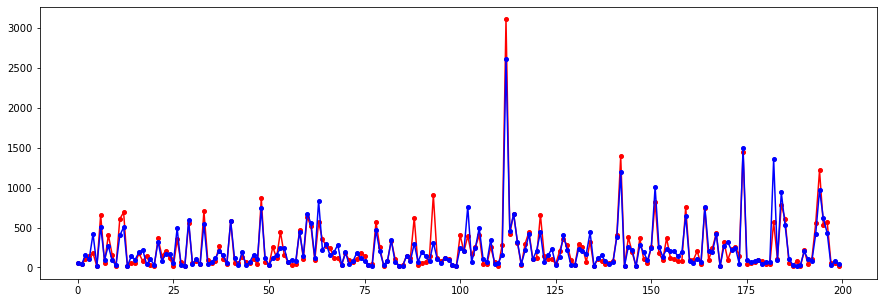

In [231]:
# visualize prediction result for the first 200 data samples
compare_in_plot(y_valid, y_pred_knn1)

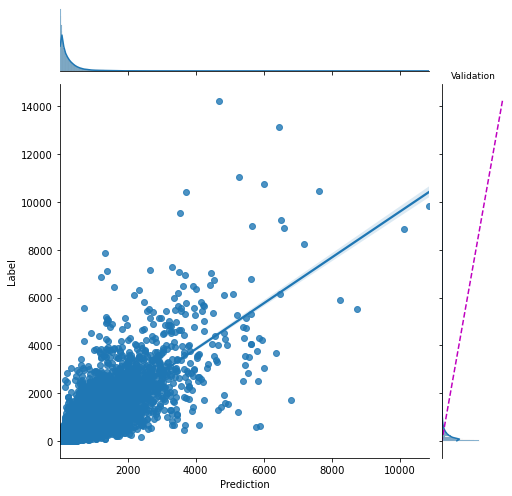

In [235]:
model_performance_sc_plot(y_pred_knn1, y_valid, 'Validation')

As we expect, non-linear model KNN actually has comparable performance considering its short training time. 

KNN can be one option.

### Random Forest

In [237]:
from sklearn.ensemble import RandomForestRegressor
RFmodel = RandomForestRegressor()
RFmodel.fit(x_train, y_train)
y_pred_rf = RFmodel.predict(x_valid)

In [238]:
result(y_valid, y_pred_rf)

MSE:
 29204.63630298528
MAE:
 82.9548524812957
R2 score:
 0.8128379422574035


In [239]:
RMSLE(y_valid, y_pred_rf)

0.23705217866138753

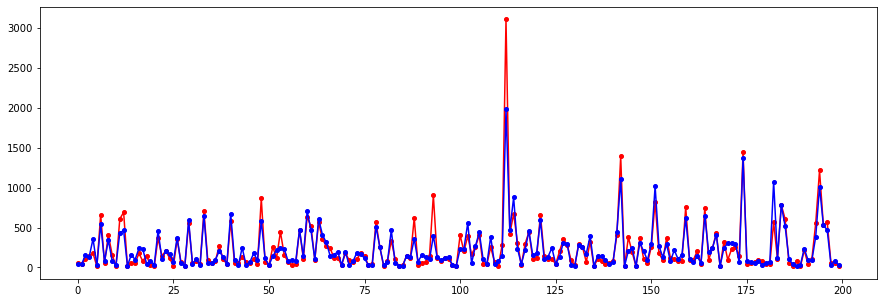

In [240]:
# visualize prediction result for the first 200 data samples
compare_in_plot(y_valid, y_pred_rf)

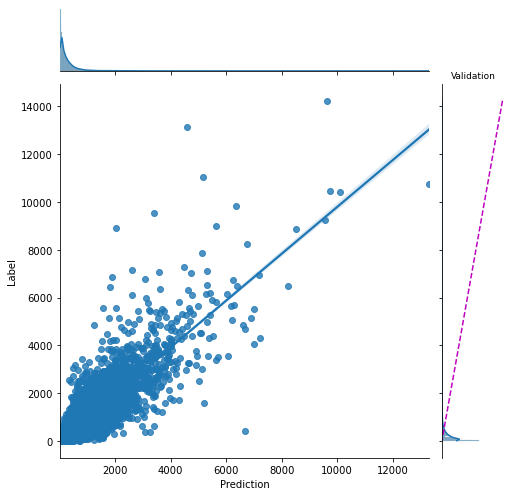

In [241]:
model_performance_sc_plot(y_pred_rf, y_valid, 'Validation')

In [273]:
y_pred_rf_test = RFmodel.predict(x_test)

### XGboost

In [244]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_valid, label=y_valid)


In [274]:
x_train["emailer_for_promotion"] = x_train["emailer_for_promotion"].astype(int)
x_train["homepage_featured"] = x_train["homepage_featured"].astype(int)
x_valid["emailer_for_promotion"] = x_valid["emailer_for_promotion"].astype(int)
x_valid["homepage_featured"] = x_valid["homepage_featured"].astype(int)
x_test["emailer_for_promotion"] = x_test["emailer_for_promotion"].astype(int)
x_test["homepage_featured"] = x_test["homepage_featured"].astype(int)

In [277]:
import xgboost as xgb

# create an xgboost regression model
XGBmodel = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, enable_categorical=True)
XGBmodel.fit(x_train, y_train)
y_pred_xgbt = XGBmodel.predict(x_valid)

[22:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [278]:
result(y_valid, y_pred_xgbt)

MSE:
 23538.75685360668
MAE:
 79.6140485429591
R2 score:
 0.8491485350573142


In [279]:
RMSLE(y_valid, y_pred_xgbt)

0.2782588904073861

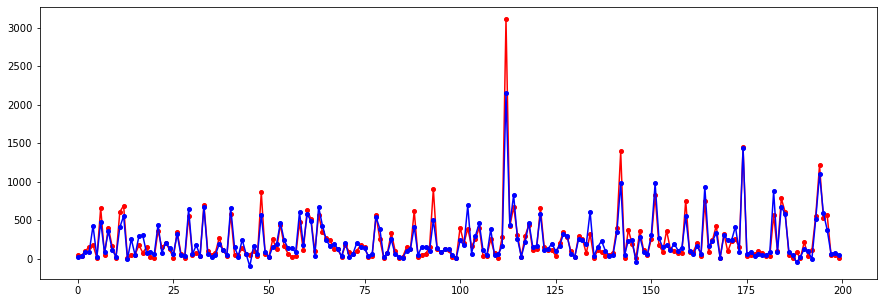

In [280]:
compare_in_plot(y_valid, y_pred_xgbt)

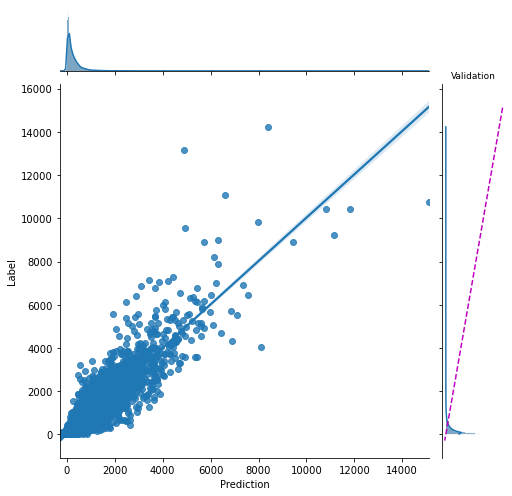

In [281]:
model_performance_sc_plot(y_pred_xgbt, y_valid, 'Validation')

From the prediction result we can see, the default XGBoost model have the best performance in terms of typical regression metrics like MSE, MAE and R2. However, its RMSLE is much worse than that of Random Forest. This may because XGBoost more tend to underestimate the demand.

One advantage of XGBoost is that it can costumize objective and evaluation metric. In order to improve the model, I implement Squared Log Error(SLE) objective function and its default metric Root Mean Squared Log Error(RMSLE).

In [282]:
y_pred_xgbt_test = XGBmodel.predict(x_test)

In [250]:
from typing import Tuple

def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt: np.ndarray,
                dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [251]:
def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

In [252]:
XGBmodel = xgb.train({'n_estimators':1000, 'max_depth':7, 'eta':0.1, 'subsample':0.7, 'colsample_bytree':0.8},
          dtrain=dtrain,
          obj=squared_log,
          feval=rmsle,
          num_boost_round=20000,
          evals=[(dtrain, 'dtrain'), (dtest, 'dtest')])

[20:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	dtrain-rmse:474.36533	dtrain-PyRMSLE:4.56376	dtest-rmse:474.27902	dtest-PyRMSLE:4.57038
[1]	dtrain-rmse:474.28815	dtrain-PyRMSLE:4.48811	dtest-rmse:474.19992	dtest-PyRMSLE:4.49472
[2]	dtrain-rmse:474.20975	dtrain-PyRMSLE:4.41278	dtest-rmse:474.12012	dtest-PyRMSLE:4.41937
[3]	dtrain-rmse:474.11240	dtrain-PyRMSLE:4.33778	dtest-rmse:474.03503	dtest-PyRMSLE:4.34435
[4]	dtrain-rmse:474.01547	dtrain-PyRMSLE:4.26312	dtest-rmse:473.93777	dtest-PyRMSLE:4.26968
[5]	dtrain-rmse:473.92010	dtrain-PyRMSLE:4.18882	dtest-rmse:473.83673	dtest-PyRMSLE:4.19536
[6]	dtrain-rmse:473.81445	dtrain-PyRMSLE:4.11487	dtest-r

[84]	dtrain-rmse:394.55835	dtrain-PyRMSLE:0.87755	dtest-rmse:393.68955	dtest-PyRMSLE:0.88004
[85]	dtrain-rmse:393.54340	dtrain-PyRMSLE:0.87216	dtest-rmse:392.66293	dtest-PyRMSLE:0.87464
[86]	dtrain-rmse:392.47324	dtrain-PyRMSLE:0.86848	dtest-rmse:391.58051	dtest-PyRMSLE:0.87097
[87]	dtrain-rmse:391.55453	dtrain-PyRMSLE:0.86591	dtest-rmse:390.65155	dtest-PyRMSLE:0.86837
[88]	dtrain-rmse:390.62601	dtrain-PyRMSLE:0.86366	dtest-rmse:389.70911	dtest-PyRMSLE:0.86606
[89]	dtrain-rmse:389.63159	dtrain-PyRMSLE:0.85872	dtest-rmse:388.70276	dtest-PyRMSLE:0.86109
[90]	dtrain-rmse:388.80582	dtrain-PyRMSLE:0.85702	dtest-rmse:387.86838	dtest-PyRMSLE:0.85936
[91]	dtrain-rmse:387.95282	dtrain-PyRMSLE:0.85538	dtest-rmse:387.00275	dtest-PyRMSLE:0.85767
[92]	dtrain-rmse:387.13928	dtrain-PyRMSLE:0.85393	dtest-rmse:386.17816	dtest-PyRMSLE:0.85622
[93]	dtrain-rmse:386.35315	dtrain-PyRMSLE:0.85134	dtest-rmse:385.38324	dtest-PyRMSLE:0.85364
[94]	dtrain-rmse:385.58350	dtrain-PyRMSLE:0.84941	dtest-rmse:384.60248

[172]	dtrain-rmse:359.71515	dtrain-PyRMSLE:0.87139	dtest-rmse:358.32932	dtest-PyRMSLE:0.87321
[173]	dtrain-rmse:359.54977	dtrain-PyRMSLE:0.87166	dtest-rmse:358.16186	dtest-PyRMSLE:0.87348
[174]	dtrain-rmse:359.41534	dtrain-PyRMSLE:0.87193	dtest-rmse:358.02521	dtest-PyRMSLE:0.87374
[175]	dtrain-rmse:359.29324	dtrain-PyRMSLE:0.87218	dtest-rmse:357.90091	dtest-PyRMSLE:0.87399
[176]	dtrain-rmse:359.20841	dtrain-PyRMSLE:0.87254	dtest-rmse:357.81445	dtest-PyRMSLE:0.87435
[177]	dtrain-rmse:359.07761	dtrain-PyRMSLE:0.87282	dtest-rmse:357.68192	dtest-PyRMSLE:0.87462
[178]	dtrain-rmse:358.95111	dtrain-PyRMSLE:0.87311	dtest-rmse:357.55350	dtest-PyRMSLE:0.87490
[179]	dtrain-rmse:358.86002	dtrain-PyRMSLE:0.87354	dtest-rmse:357.46069	dtest-PyRMSLE:0.87534
[180]	dtrain-rmse:358.77512	dtrain-PyRMSLE:0.87352	dtest-rmse:357.37405	dtest-PyRMSLE:0.87533
[181]	dtrain-rmse:358.60989	dtrain-PyRMSLE:0.87406	dtest-rmse:357.20575	dtest-PyRMSLE:0.87586
[182]	dtrain-rmse:358.53870	dtrain-PyRMSLE:0.87441	dtest-rms

[260]	dtrain-rmse:353.38119	dtrain-PyRMSLE:0.88184	dtest-rmse:351.87588	dtest-PyRMSLE:0.88360
[261]	dtrain-rmse:353.30005	dtrain-PyRMSLE:0.88203	dtest-rmse:351.79315	dtest-PyRMSLE:0.88377
[262]	dtrain-rmse:353.25159	dtrain-PyRMSLE:0.88196	dtest-rmse:351.74289	dtest-PyRMSLE:0.88371
[263]	dtrain-rmse:353.22824	dtrain-PyRMSLE:0.88182	dtest-rmse:351.71973	dtest-PyRMSLE:0.88359
[264]	dtrain-rmse:353.19827	dtrain-PyRMSLE:0.88177	dtest-rmse:351.68903	dtest-PyRMSLE:0.88353
[265]	dtrain-rmse:353.15137	dtrain-PyRMSLE:0.88165	dtest-rmse:351.64041	dtest-PyRMSLE:0.88340
[266]	dtrain-rmse:353.12088	dtrain-PyRMSLE:0.88146	dtest-rmse:351.60922	dtest-PyRMSLE:0.88322
[267]	dtrain-rmse:353.03451	dtrain-PyRMSLE:0.88160	dtest-rmse:351.52106	dtest-PyRMSLE:0.88334
[268]	dtrain-rmse:352.97629	dtrain-PyRMSLE:0.88182	dtest-rmse:351.46158	dtest-PyRMSLE:0.88355
[269]	dtrain-rmse:352.92261	dtrain-PyRMSLE:0.88194	dtest-rmse:351.40689	dtest-PyRMSLE:0.88367
[270]	dtrain-rmse:352.86609	dtrain-PyRMSLE:0.88214	dtest-rms

[348]	dtrain-rmse:349.82483	dtrain-PyRMSLE:0.87729	dtest-rmse:348.27405	dtest-PyRMSLE:0.87887
[349]	dtrain-rmse:349.77432	dtrain-PyRMSLE:0.87731	dtest-rmse:348.22397	dtest-PyRMSLE:0.87890
[350]	dtrain-rmse:349.74200	dtrain-PyRMSLE:0.87740	dtest-rmse:348.19135	dtest-PyRMSLE:0.87900
[351]	dtrain-rmse:349.70065	dtrain-PyRMSLE:0.87783	dtest-rmse:348.14853	dtest-PyRMSLE:0.87903
[352]	dtrain-rmse:349.67084	dtrain-PyRMSLE:0.87769	dtest-rmse:348.11752	dtest-PyRMSLE:0.87889
[353]	dtrain-rmse:349.63080	dtrain-PyRMSLE:0.87765	dtest-rmse:348.07782	dtest-PyRMSLE:0.87886
[354]	dtrain-rmse:349.58963	dtrain-PyRMSLE:0.87775	dtest-rmse:348.03549	dtest-PyRMSLE:0.87894
[355]	dtrain-rmse:349.54956	dtrain-PyRMSLE:0.87760	dtest-rmse:347.99521	dtest-PyRMSLE:0.87880
[356]	dtrain-rmse:349.52387	dtrain-PyRMSLE:0.87757	dtest-rmse:347.97006	dtest-PyRMSLE:0.87877
[357]	dtrain-rmse:349.49188	dtrain-PyRMSLE:0.87758	dtest-rmse:347.93756	dtest-PyRMSLE:0.87877
[358]	dtrain-rmse:349.47144	dtrain-PyRMSLE:0.87731	dtest-rms

[436]	dtrain-rmse:347.30725	dtrain-PyRMSLE:0.87063	dtest-rmse:345.70923	dtest-PyRMSLE:0.87181
[437]	dtrain-rmse:347.28558	dtrain-PyRMSLE:0.87057	dtest-rmse:345.68726	dtest-PyRMSLE:0.87175
[438]	dtrain-rmse:347.24707	dtrain-PyRMSLE:0.87070	dtest-rmse:345.64740	dtest-PyRMSLE:0.87188
[439]	dtrain-rmse:347.17950	dtrain-PyRMSLE:0.87087	dtest-rmse:345.57687	dtest-PyRMSLE:0.87205
[440]	dtrain-rmse:347.17371	dtrain-PyRMSLE:0.87082	dtest-rmse:345.57025	dtest-PyRMSLE:0.87200
[441]	dtrain-rmse:347.15109	dtrain-PyRMSLE:0.87083	dtest-rmse:345.54752	dtest-PyRMSLE:0.87200
[442]	dtrain-rmse:347.12985	dtrain-PyRMSLE:0.87069	dtest-rmse:345.52615	dtest-PyRMSLE:0.87186
[443]	dtrain-rmse:347.09378	dtrain-PyRMSLE:0.87079	dtest-rmse:345.48850	dtest-PyRMSLE:0.87196
[444]	dtrain-rmse:347.06738	dtrain-PyRMSLE:0.87061	dtest-rmse:345.46066	dtest-PyRMSLE:0.87177
[445]	dtrain-rmse:347.05377	dtrain-PyRMSLE:0.87057	dtest-rmse:345.44699	dtest-PyRMSLE:0.87173
[446]	dtrain-rmse:347.01566	dtrain-PyRMSLE:0.87044	dtest-rms

[524]	dtrain-rmse:345.33530	dtrain-PyRMSLE:0.86648	dtest-rmse:343.70288	dtest-PyRMSLE:0.86718
[525]	dtrain-rmse:345.32227	dtrain-PyRMSLE:0.86633	dtest-rmse:343.68973	dtest-PyRMSLE:0.86704
[526]	dtrain-rmse:345.29733	dtrain-PyRMSLE:0.86631	dtest-rmse:343.66480	dtest-PyRMSLE:0.86704
[527]	dtrain-rmse:345.25983	dtrain-PyRMSLE:0.86638	dtest-rmse:343.62692	dtest-PyRMSLE:0.86708
[528]	dtrain-rmse:345.24264	dtrain-PyRMSLE:0.86637	dtest-rmse:343.60983	dtest-PyRMSLE:0.86708
[529]	dtrain-rmse:345.21146	dtrain-PyRMSLE:0.86641	dtest-rmse:343.57773	dtest-PyRMSLE:0.86712
[530]	dtrain-rmse:345.18866	dtrain-PyRMSLE:0.86637	dtest-rmse:343.55447	dtest-PyRMSLE:0.86708
[531]	dtrain-rmse:345.15787	dtrain-PyRMSLE:0.86647	dtest-rmse:343.52267	dtest-PyRMSLE:0.86718
[532]	dtrain-rmse:345.13217	dtrain-PyRMSLE:0.86647	dtest-rmse:343.49649	dtest-PyRMSLE:0.86719
[533]	dtrain-rmse:345.13211	dtrain-PyRMSLE:0.86625	dtest-rmse:343.49808	dtest-PyRMSLE:0.86701
[534]	dtrain-rmse:345.11627	dtrain-PyRMSLE:0.86624	dtest-rms

[612]	dtrain-rmse:343.81555	dtrain-PyRMSLE:0.86338	dtest-rmse:342.16010	dtest-PyRMSLE:0.86557
[613]	dtrain-rmse:343.79044	dtrain-PyRMSLE:0.86335	dtest-rmse:342.13562	dtest-PyRMSLE:0.86554
[614]	dtrain-rmse:343.75754	dtrain-PyRMSLE:0.86336	dtest-rmse:342.10269	dtest-PyRMSLE:0.86555
[615]	dtrain-rmse:343.75125	dtrain-PyRMSLE:0.86323	dtest-rmse:342.09689	dtest-PyRMSLE:0.86543
[616]	dtrain-rmse:343.77591	dtrain-PyRMSLE:0.86296	dtest-rmse:342.12228	dtest-PyRMSLE:0.86515
[617]	dtrain-rmse:343.76465	dtrain-PyRMSLE:0.86292	dtest-rmse:342.11087	dtest-PyRMSLE:0.86511
[618]	dtrain-rmse:343.73825	dtrain-PyRMSLE:0.86296	dtest-rmse:342.08365	dtest-PyRMSLE:0.86515
[619]	dtrain-rmse:343.71640	dtrain-PyRMSLE:0.86293	dtest-rmse:342.06168	dtest-PyRMSLE:0.86513
[620]	dtrain-rmse:343.70032	dtrain-PyRMSLE:0.86286	dtest-rmse:342.04602	dtest-PyRMSLE:0.86505
[621]	dtrain-rmse:343.66583	dtrain-PyRMSLE:0.86292	dtest-rmse:342.01001	dtest-PyRMSLE:0.86511
[622]	dtrain-rmse:343.65387	dtrain-PyRMSLE:0.86280	dtest-rms

[700]	dtrain-rmse:342.62811	dtrain-PyRMSLE:0.85783	dtest-rmse:340.95883	dtest-PyRMSLE:0.86016
[701]	dtrain-rmse:342.62509	dtrain-PyRMSLE:0.85777	dtest-rmse:340.95538	dtest-PyRMSLE:0.86011
[702]	dtrain-rmse:342.56494	dtrain-PyRMSLE:0.85805	dtest-rmse:340.89334	dtest-PyRMSLE:0.86037
[703]	dtrain-rmse:342.53052	dtrain-PyRMSLE:0.85817	dtest-rmse:340.85806	dtest-PyRMSLE:0.86049
[704]	dtrain-rmse:342.52081	dtrain-PyRMSLE:0.85794	dtest-rmse:340.84888	dtest-PyRMSLE:0.86026
[705]	dtrain-rmse:342.50906	dtrain-PyRMSLE:0.85793	dtest-rmse:340.83676	dtest-PyRMSLE:0.86025
[706]	dtrain-rmse:342.48584	dtrain-PyRMSLE:0.85775	dtest-rmse:340.81296	dtest-PyRMSLE:0.86010
[707]	dtrain-rmse:342.48135	dtrain-PyRMSLE:0.85771	dtest-rmse:340.80844	dtest-PyRMSLE:0.86006
[708]	dtrain-rmse:342.45938	dtrain-PyRMSLE:0.85776	dtest-rmse:340.78641	dtest-PyRMSLE:0.86010
[709]	dtrain-rmse:342.42816	dtrain-PyRMSLE:0.85783	dtest-rmse:340.75330	dtest-PyRMSLE:0.86017
[710]	dtrain-rmse:342.42432	dtrain-PyRMSLE:0.85777	dtest-rms

[788]	dtrain-rmse:341.65472	dtrain-PyRMSLE:0.85276	dtest-rmse:339.97345	dtest-PyRMSLE:0.85576
[789]	dtrain-rmse:341.65988	dtrain-PyRMSLE:0.85262	dtest-rmse:339.97916	dtest-PyRMSLE:0.85560
[790]	dtrain-rmse:341.64926	dtrain-PyRMSLE:0.85261	dtest-rmse:339.96805	dtest-PyRMSLE:0.85559
[791]	dtrain-rmse:341.62808	dtrain-PyRMSLE:0.85268	dtest-rmse:339.94641	dtest-PyRMSLE:0.85566
[792]	dtrain-rmse:341.61295	dtrain-PyRMSLE:0.85273	dtest-rmse:339.93091	dtest-PyRMSLE:0.85571
[793]	dtrain-rmse:341.60043	dtrain-PyRMSLE:0.85271	dtest-rmse:339.91800	dtest-PyRMSLE:0.85570
[794]	dtrain-rmse:341.57715	dtrain-PyRMSLE:0.85274	dtest-rmse:339.89444	dtest-PyRMSLE:0.85573
[795]	dtrain-rmse:341.56824	dtrain-PyRMSLE:0.85266	dtest-rmse:339.88507	dtest-PyRMSLE:0.85564
[796]	dtrain-rmse:341.56781	dtrain-PyRMSLE:0.85257	dtest-rmse:339.88516	dtest-PyRMSLE:0.85555
[797]	dtrain-rmse:341.56378	dtrain-PyRMSLE:0.85250	dtest-rmse:339.88126	dtest-PyRMSLE:0.85548
[798]	dtrain-rmse:341.55341	dtrain-PyRMSLE:0.85247	dtest-rms

[876]	dtrain-rmse:340.60733	dtrain-PyRMSLE:0.85118	dtest-rmse:338.90866	dtest-PyRMSLE:0.85422
[877]	dtrain-rmse:340.59708	dtrain-PyRMSLE:0.85119	dtest-rmse:338.89804	dtest-PyRMSLE:0.85424
[878]	dtrain-rmse:340.58255	dtrain-PyRMSLE:0.85112	dtest-rmse:338.88367	dtest-PyRMSLE:0.85417
[879]	dtrain-rmse:340.55869	dtrain-PyRMSLE:0.85112	dtest-rmse:338.85998	dtest-PyRMSLE:0.85417
[880]	dtrain-rmse:340.55096	dtrain-PyRMSLE:0.85112	dtest-rmse:338.85242	dtest-PyRMSLE:0.85417
[881]	dtrain-rmse:340.53476	dtrain-PyRMSLE:0.85116	dtest-rmse:338.83582	dtest-PyRMSLE:0.85422
[882]	dtrain-rmse:340.52457	dtrain-PyRMSLE:0.85113	dtest-rmse:338.82501	dtest-PyRMSLE:0.85418
[883]	dtrain-rmse:340.49960	dtrain-PyRMSLE:0.85116	dtest-rmse:338.80023	dtest-PyRMSLE:0.85421
[884]	dtrain-rmse:340.47589	dtrain-PyRMSLE:0.85100	dtest-rmse:338.77667	dtest-PyRMSLE:0.85406
[885]	dtrain-rmse:340.47311	dtrain-PyRMSLE:0.85090	dtest-rmse:338.77341	dtest-PyRMSLE:0.85396
[886]	dtrain-rmse:340.45145	dtrain-PyRMSLE:0.85090	dtest-rms

[964]	dtrain-rmse:339.50482	dtrain-PyRMSLE:0.85001	dtest-rmse:337.79153	dtest-PyRMSLE:0.85321
[965]	dtrain-rmse:339.49826	dtrain-PyRMSLE:0.84994	dtest-rmse:337.78531	dtest-PyRMSLE:0.85313
[966]	dtrain-rmse:339.48630	dtrain-PyRMSLE:0.84996	dtest-rmse:337.77274	dtest-PyRMSLE:0.85315
[967]	dtrain-rmse:339.47394	dtrain-PyRMSLE:0.84996	dtest-rmse:337.76010	dtest-PyRMSLE:0.85315
[968]	dtrain-rmse:339.45511	dtrain-PyRMSLE:0.84999	dtest-rmse:337.74048	dtest-PyRMSLE:0.85319
[969]	dtrain-rmse:339.44247	dtrain-PyRMSLE:0.84990	dtest-rmse:337.72748	dtest-PyRMSLE:0.85310
[970]	dtrain-rmse:339.43072	dtrain-PyRMSLE:0.84990	dtest-rmse:337.71585	dtest-PyRMSLE:0.85310
[971]	dtrain-rmse:339.42447	dtrain-PyRMSLE:0.84984	dtest-rmse:337.70963	dtest-PyRMSLE:0.85304
[972]	dtrain-rmse:339.40479	dtrain-PyRMSLE:0.84981	dtest-rmse:337.68924	dtest-PyRMSLE:0.85301
[973]	dtrain-rmse:339.38367	dtrain-PyRMSLE:0.84985	dtest-rmse:337.66773	dtest-PyRMSLE:0.85305
[974]	dtrain-rmse:339.37714	dtrain-PyRMSLE:0.84977	dtest-rms

[1051]	dtrain-rmse:338.50146	dtrain-PyRMSLE:0.84779	dtest-rmse:336.77564	dtest-PyRMSLE:0.85112
[1052]	dtrain-rmse:338.49869	dtrain-PyRMSLE:0.84772	dtest-rmse:336.77298	dtest-PyRMSLE:0.85106
[1053]	dtrain-rmse:338.49161	dtrain-PyRMSLE:0.84772	dtest-rmse:336.76562	dtest-PyRMSLE:0.85105
[1054]	dtrain-rmse:338.48856	dtrain-PyRMSLE:0.84768	dtest-rmse:336.76236	dtest-PyRMSLE:0.85101
[1055]	dtrain-rmse:338.48004	dtrain-PyRMSLE:0.84765	dtest-rmse:336.75403	dtest-PyRMSLE:0.85099
[1056]	dtrain-rmse:338.46906	dtrain-PyRMSLE:0.84755	dtest-rmse:336.74295	dtest-PyRMSLE:0.85090
[1057]	dtrain-rmse:338.45282	dtrain-PyRMSLE:0.84756	dtest-rmse:336.72592	dtest-PyRMSLE:0.85091
[1058]	dtrain-rmse:338.44772	dtrain-PyRMSLE:0.84755	dtest-rmse:336.72076	dtest-PyRMSLE:0.85090
[1059]	dtrain-rmse:338.44528	dtrain-PyRMSLE:0.84743	dtest-rmse:336.71841	dtest-PyRMSLE:0.85079
[1060]	dtrain-rmse:338.42923	dtrain-PyRMSLE:0.84740	dtest-rmse:336.70258	dtest-PyRMSLE:0.85076
[1061]	dtrain-rmse:338.41534	dtrain-PyRMSLE:0.8473

[1138]	dtrain-rmse:337.70111	dtrain-PyRMSLE:0.84486	dtest-rmse:335.96674	dtest-PyRMSLE:0.84834
[1139]	dtrain-rmse:337.69196	dtrain-PyRMSLE:0.84486	dtest-rmse:335.95764	dtest-PyRMSLE:0.84835
[1140]	dtrain-rmse:337.68341	dtrain-PyRMSLE:0.84484	dtest-rmse:335.94876	dtest-PyRMSLE:0.84832
[1141]	dtrain-rmse:337.67819	dtrain-PyRMSLE:0.84481	dtest-rmse:335.94373	dtest-PyRMSLE:0.84830
[1142]	dtrain-rmse:337.67600	dtrain-PyRMSLE:0.84479	dtest-rmse:335.94128	dtest-PyRMSLE:0.84828
[1143]	dtrain-rmse:337.67716	dtrain-PyRMSLE:0.84471	dtest-rmse:335.94223	dtest-PyRMSLE:0.84820
[1144]	dtrain-rmse:337.66010	dtrain-PyRMSLE:0.84428	dtest-rmse:335.92511	dtest-PyRMSLE:0.84824
[1145]	dtrain-rmse:337.64865	dtrain-PyRMSLE:0.84426	dtest-rmse:335.91330	dtest-PyRMSLE:0.84823
[1146]	dtrain-rmse:337.64902	dtrain-PyRMSLE:0.84422	dtest-rmse:335.91361	dtest-PyRMSLE:0.84820
[1147]	dtrain-rmse:337.62027	dtrain-PyRMSLE:0.84425	dtest-rmse:335.88428	dtest-PyRMSLE:0.84825
[1148]	dtrain-rmse:337.58578	dtrain-PyRMSLE:0.8441

[1225]	dtrain-rmse:336.49625	dtrain-PyRMSLE:0.83670	dtest-rmse:334.75494	dtest-PyRMSLE:0.84088
[1226]	dtrain-rmse:336.48910	dtrain-PyRMSLE:0.83663	dtest-rmse:334.74741	dtest-PyRMSLE:0.84081
[1227]	dtrain-rmse:336.47314	dtrain-PyRMSLE:0.83650	dtest-rmse:334.73169	dtest-PyRMSLE:0.84069
[1228]	dtrain-rmse:336.45004	dtrain-PyRMSLE:0.83629	dtest-rmse:334.70895	dtest-PyRMSLE:0.84048
[1229]	dtrain-rmse:336.44266	dtrain-PyRMSLE:0.83623	dtest-rmse:334.70196	dtest-PyRMSLE:0.84043
[1230]	dtrain-rmse:336.41678	dtrain-PyRMSLE:0.83615	dtest-rmse:334.67639	dtest-PyRMSLE:0.84035
[1231]	dtrain-rmse:336.36847	dtrain-PyRMSLE:0.83595	dtest-rmse:334.62723	dtest-PyRMSLE:0.84015
[1232]	dtrain-rmse:336.36408	dtrain-PyRMSLE:0.83590	dtest-rmse:334.62293	dtest-PyRMSLE:0.84010
[1233]	dtrain-rmse:336.35519	dtrain-PyRMSLE:0.83577	dtest-rmse:334.61392	dtest-PyRMSLE:0.83997
[1234]	dtrain-rmse:336.34528	dtrain-PyRMSLE:0.83569	dtest-rmse:334.60394	dtest-PyRMSLE:0.83989
[1235]	dtrain-rmse:336.33313	dtrain-PyRMSLE:0.8357

[1312]	dtrain-rmse:335.17551	dtrain-PyRMSLE:0.82904	dtest-rmse:333.43246	dtest-PyRMSLE:0.83345
[1313]	dtrain-rmse:335.15018	dtrain-PyRMSLE:0.82895	dtest-rmse:333.40726	dtest-PyRMSLE:0.83337
[1314]	dtrain-rmse:335.12012	dtrain-PyRMSLE:0.82887	dtest-rmse:333.37729	dtest-PyRMSLE:0.83330
[1315]	dtrain-rmse:335.11380	dtrain-PyRMSLE:0.82886	dtest-rmse:333.37106	dtest-PyRMSLE:0.83329
[1316]	dtrain-rmse:335.10907	dtrain-PyRMSLE:0.82886	dtest-rmse:333.36642	dtest-PyRMSLE:0.83330
[1317]	dtrain-rmse:335.08398	dtrain-PyRMSLE:0.82878	dtest-rmse:333.34143	dtest-PyRMSLE:0.83322
[1318]	dtrain-rmse:335.08524	dtrain-PyRMSLE:0.82869	dtest-rmse:333.34305	dtest-PyRMSLE:0.83313
[1319]	dtrain-rmse:335.08197	dtrain-PyRMSLE:0.82865	dtest-rmse:333.34039	dtest-PyRMSLE:0.83308
[1320]	dtrain-rmse:335.05585	dtrain-PyRMSLE:0.82859	dtest-rmse:333.31409	dtest-PyRMSLE:0.83303
[1321]	dtrain-rmse:335.04648	dtrain-PyRMSLE:0.82835	dtest-rmse:333.30466	dtest-PyRMSLE:0.83279
[1322]	dtrain-rmse:335.03748	dtrain-PyRMSLE:0.8283

[1399]	dtrain-rmse:334.06296	dtrain-PyRMSLE:0.82220	dtest-rmse:332.31867	dtest-PyRMSLE:0.82680
[1400]	dtrain-rmse:334.06049	dtrain-PyRMSLE:0.82221	dtest-rmse:332.31625	dtest-PyRMSLE:0.82681
[1401]	dtrain-rmse:334.01468	dtrain-PyRMSLE:0.82179	dtest-rmse:332.26935	dtest-PyRMSLE:0.82639
[1402]	dtrain-rmse:334.00165	dtrain-PyRMSLE:0.82182	dtest-rmse:332.25635	dtest-PyRMSLE:0.82643
[1403]	dtrain-rmse:333.98910	dtrain-PyRMSLE:0.82186	dtest-rmse:332.24371	dtest-PyRMSLE:0.82646
[1404]	dtrain-rmse:333.97311	dtrain-PyRMSLE:0.82178	dtest-rmse:332.22751	dtest-PyRMSLE:0.82638
[1405]	dtrain-rmse:333.96921	dtrain-PyRMSLE:0.82172	dtest-rmse:332.22403	dtest-PyRMSLE:0.82633
[1406]	dtrain-rmse:333.95312	dtrain-PyRMSLE:0.82174	dtest-rmse:332.20712	dtest-PyRMSLE:0.82634
[1407]	dtrain-rmse:333.95084	dtrain-PyRMSLE:0.82167	dtest-rmse:332.20505	dtest-PyRMSLE:0.82628
[1408]	dtrain-rmse:333.91824	dtrain-PyRMSLE:0.82162	dtest-rmse:332.17255	dtest-PyRMSLE:0.82624
[1409]	dtrain-rmse:333.91483	dtrain-PyRMSLE:0.8216

[1486]	dtrain-rmse:332.68460	dtrain-PyRMSLE:0.81740	dtest-rmse:330.91943	dtest-PyRMSLE:0.82206
[1487]	dtrain-rmse:332.67062	dtrain-PyRMSLE:0.81736	dtest-rmse:330.90515	dtest-PyRMSLE:0.82202
[1488]	dtrain-rmse:332.65213	dtrain-PyRMSLE:0.81735	dtest-rmse:330.88641	dtest-PyRMSLE:0.82201
[1489]	dtrain-rmse:332.63687	dtrain-PyRMSLE:0.81736	dtest-rmse:330.87082	dtest-PyRMSLE:0.82202
[1490]	dtrain-rmse:332.63419	dtrain-PyRMSLE:0.81733	dtest-rmse:330.86801	dtest-PyRMSLE:0.82199
[1491]	dtrain-rmse:332.61612	dtrain-PyRMSLE:0.81732	dtest-rmse:330.84979	dtest-PyRMSLE:0.82198
[1492]	dtrain-rmse:332.57223	dtrain-PyRMSLE:0.81700	dtest-rmse:330.80521	dtest-PyRMSLE:0.82166
[1493]	dtrain-rmse:332.55722	dtrain-PyRMSLE:0.81702	dtest-rmse:330.79007	dtest-PyRMSLE:0.82168
[1494]	dtrain-rmse:332.53909	dtrain-PyRMSLE:0.81701	dtest-rmse:330.77081	dtest-PyRMSLE:0.82166
[1495]	dtrain-rmse:332.53537	dtrain-PyRMSLE:0.81700	dtest-rmse:330.76700	dtest-PyRMSLE:0.82166
[1496]	dtrain-rmse:332.53445	dtrain-PyRMSLE:0.8169

[1573]	dtrain-rmse:331.42120	dtrain-PyRMSLE:0.81244	dtest-rmse:329.63498	dtest-PyRMSLE:0.81548
[1574]	dtrain-rmse:331.41684	dtrain-PyRMSLE:0.81242	dtest-rmse:329.63095	dtest-PyRMSLE:0.81547
[1575]	dtrain-rmse:331.40631	dtrain-PyRMSLE:0.81244	dtest-rmse:329.62027	dtest-PyRMSLE:0.81549
[1576]	dtrain-rmse:331.38867	dtrain-PyRMSLE:0.81242	dtest-rmse:329.60208	dtest-PyRMSLE:0.81548
[1577]	dtrain-rmse:331.37714	dtrain-PyRMSLE:0.81242	dtest-rmse:329.59045	dtest-PyRMSLE:0.81549
[1578]	dtrain-rmse:331.37375	dtrain-PyRMSLE:0.81234	dtest-rmse:329.58768	dtest-PyRMSLE:0.81543
[1579]	dtrain-rmse:331.34177	dtrain-PyRMSLE:0.81234	dtest-rmse:329.55466	dtest-PyRMSLE:0.81543
[1580]	dtrain-rmse:331.33795	dtrain-PyRMSLE:0.81233	dtest-rmse:329.55087	dtest-PyRMSLE:0.81541
[1581]	dtrain-rmse:331.30862	dtrain-PyRMSLE:0.81209	dtest-rmse:329.52148	dtest-PyRMSLE:0.81517
[1582]	dtrain-rmse:331.29620	dtrain-PyRMSLE:0.81208	dtest-rmse:329.50897	dtest-PyRMSLE:0.81515
[1583]	dtrain-rmse:331.27661	dtrain-PyRMSLE:0.8120

[1660]	dtrain-rmse:330.31198	dtrain-PyRMSLE:0.80891	dtest-rmse:328.51150	dtest-PyRMSLE:0.81192
[1661]	dtrain-rmse:330.28308	dtrain-PyRMSLE:0.80893	dtest-rmse:328.48196	dtest-PyRMSLE:0.81194
[1662]	dtrain-rmse:330.26007	dtrain-PyRMSLE:0.80893	dtest-rmse:328.45883	dtest-PyRMSLE:0.81194
[1663]	dtrain-rmse:330.25006	dtrain-PyRMSLE:0.80889	dtest-rmse:328.44821	dtest-PyRMSLE:0.81190
[1664]	dtrain-rmse:330.24222	dtrain-PyRMSLE:0.80886	dtest-rmse:328.44034	dtest-PyRMSLE:0.81186
[1665]	dtrain-rmse:330.21588	dtrain-PyRMSLE:0.80883	dtest-rmse:328.41367	dtest-PyRMSLE:0.81185
[1666]	dtrain-rmse:330.18899	dtrain-PyRMSLE:0.80887	dtest-rmse:328.38654	dtest-PyRMSLE:0.81187
[1667]	dtrain-rmse:330.17963	dtrain-PyRMSLE:0.80889	dtest-rmse:328.37665	dtest-PyRMSLE:0.81190
[1668]	dtrain-rmse:330.16989	dtrain-PyRMSLE:0.80891	dtest-rmse:328.36670	dtest-PyRMSLE:0.81192
[1669]	dtrain-rmse:330.16565	dtrain-PyRMSLE:0.80891	dtest-rmse:328.36270	dtest-PyRMSLE:0.81192
[1670]	dtrain-rmse:330.15625	dtrain-PyRMSLE:0.8089

[1747]	dtrain-rmse:329.10889	dtrain-PyRMSLE:0.80548	dtest-rmse:327.30035	dtest-PyRMSLE:0.80849
[1748]	dtrain-rmse:329.10300	dtrain-PyRMSLE:0.80545	dtest-rmse:327.29504	dtest-PyRMSLE:0.80846
[1749]	dtrain-rmse:329.07770	dtrain-PyRMSLE:0.80527	dtest-rmse:327.26901	dtest-PyRMSLE:0.80827
[1750]	dtrain-rmse:329.03857	dtrain-PyRMSLE:0.80503	dtest-rmse:327.22913	dtest-PyRMSLE:0.80803
[1751]	dtrain-rmse:329.02548	dtrain-PyRMSLE:0.80497	dtest-rmse:327.21591	dtest-PyRMSLE:0.80797
[1752]	dtrain-rmse:329.02280	dtrain-PyRMSLE:0.80494	dtest-rmse:327.21326	dtest-PyRMSLE:0.80794
[1753]	dtrain-rmse:329.00769	dtrain-PyRMSLE:0.80495	dtest-rmse:327.19809	dtest-PyRMSLE:0.80795
[1754]	dtrain-rmse:328.99609	dtrain-PyRMSLE:0.80490	dtest-rmse:327.18643	dtest-PyRMSLE:0.80790
[1755]	dtrain-rmse:328.98508	dtrain-PyRMSLE:0.80473	dtest-rmse:327.17557	dtest-PyRMSLE:0.80773
[1756]	dtrain-rmse:328.97217	dtrain-PyRMSLE:0.80472	dtest-rmse:327.16266	dtest-PyRMSLE:0.80773
[1757]	dtrain-rmse:328.93869	dtrain-PyRMSLE:0.8044

[1834]	dtrain-rmse:327.87479	dtrain-PyRMSLE:0.80037	dtest-rmse:326.06045	dtest-PyRMSLE:0.80339
[1835]	dtrain-rmse:327.87134	dtrain-PyRMSLE:0.80036	dtest-rmse:326.05704	dtest-PyRMSLE:0.80338
[1836]	dtrain-rmse:327.86191	dtrain-PyRMSLE:0.80031	dtest-rmse:326.04816	dtest-PyRMSLE:0.80333
[1837]	dtrain-rmse:327.83057	dtrain-PyRMSLE:0.80007	dtest-rmse:326.01611	dtest-PyRMSLE:0.80309
[1838]	dtrain-rmse:327.80902	dtrain-PyRMSLE:0.79991	dtest-rmse:325.99475	dtest-PyRMSLE:0.80293
[1839]	dtrain-rmse:327.77643	dtrain-PyRMSLE:0.79976	dtest-rmse:325.96222	dtest-PyRMSLE:0.80277
[1840]	dtrain-rmse:327.76117	dtrain-PyRMSLE:0.79974	dtest-rmse:325.94650	dtest-PyRMSLE:0.80276
[1841]	dtrain-rmse:327.74548	dtrain-PyRMSLE:0.79975	dtest-rmse:325.93030	dtest-PyRMSLE:0.80277
[1842]	dtrain-rmse:327.73364	dtrain-PyRMSLE:0.79974	dtest-rmse:325.91849	dtest-PyRMSLE:0.80276
[1843]	dtrain-rmse:327.72119	dtrain-PyRMSLE:0.79976	dtest-rmse:325.90576	dtest-PyRMSLE:0.80278
[1844]	dtrain-rmse:327.69745	dtrain-PyRMSLE:0.7997

[1921]	dtrain-rmse:326.86600	dtrain-PyRMSLE:0.79324	dtest-rmse:325.05466	dtest-PyRMSLE:0.79623
[1922]	dtrain-rmse:326.86380	dtrain-PyRMSLE:0.79312	dtest-rmse:325.05267	dtest-PyRMSLE:0.79612
[1923]	dtrain-rmse:326.85156	dtrain-PyRMSLE:0.79307	dtest-rmse:325.04041	dtest-PyRMSLE:0.79606
[1924]	dtrain-rmse:326.83353	dtrain-PyRMSLE:0.79308	dtest-rmse:325.02158	dtest-PyRMSLE:0.79607
[1925]	dtrain-rmse:326.82532	dtrain-PyRMSLE:0.79300	dtest-rmse:325.01340	dtest-PyRMSLE:0.79599
[1926]	dtrain-rmse:326.81439	dtrain-PyRMSLE:0.79281	dtest-rmse:325.00284	dtest-PyRMSLE:0.79580
[1927]	dtrain-rmse:326.80200	dtrain-PyRMSLE:0.79280	dtest-rmse:324.99020	dtest-PyRMSLE:0.79579
[1928]	dtrain-rmse:326.75391	dtrain-PyRMSLE:0.79255	dtest-rmse:324.94122	dtest-PyRMSLE:0.79553
[1929]	dtrain-rmse:326.72693	dtrain-PyRMSLE:0.79253	dtest-rmse:324.91394	dtest-PyRMSLE:0.79551
[1930]	dtrain-rmse:326.71582	dtrain-PyRMSLE:0.79247	dtest-rmse:324.90292	dtest-PyRMSLE:0.79545
[1931]	dtrain-rmse:326.71249	dtrain-PyRMSLE:0.7924

[2008]	dtrain-rmse:325.58008	dtrain-PyRMSLE:0.78426	dtest-rmse:323.76526	dtest-PyRMSLE:0.78709
[2009]	dtrain-rmse:325.59009	dtrain-PyRMSLE:0.78414	dtest-rmse:323.77570	dtest-PyRMSLE:0.78698
[2010]	dtrain-rmse:325.55820	dtrain-PyRMSLE:0.78400	dtest-rmse:323.74356	dtest-PyRMSLE:0.78684
[2011]	dtrain-rmse:325.50360	dtrain-PyRMSLE:0.78381	dtest-rmse:323.68869	dtest-PyRMSLE:0.78665
[2012]	dtrain-rmse:325.49475	dtrain-PyRMSLE:0.78375	dtest-rmse:323.68005	dtest-PyRMSLE:0.78660
[2013]	dtrain-rmse:325.48837	dtrain-PyRMSLE:0.78365	dtest-rmse:323.67395	dtest-PyRMSLE:0.78650
[2014]	dtrain-rmse:325.47903	dtrain-PyRMSLE:0.78364	dtest-rmse:323.66473	dtest-PyRMSLE:0.78648
[2015]	dtrain-rmse:325.45776	dtrain-PyRMSLE:0.78363	dtest-rmse:323.64252	dtest-PyRMSLE:0.78646
[2016]	dtrain-rmse:325.43851	dtrain-PyRMSLE:0.78359	dtest-rmse:323.62262	dtest-PyRMSLE:0.78643
[2017]	dtrain-rmse:325.43234	dtrain-PyRMSLE:0.78353	dtest-rmse:323.61697	dtest-PyRMSLE:0.78638
[2018]	dtrain-rmse:325.41476	dtrain-PyRMSLE:0.7834

[2095]	dtrain-rmse:324.50528	dtrain-PyRMSLE:0.77570	dtest-rmse:322.68912	dtest-PyRMSLE:0.77849
[2096]	dtrain-rmse:324.50775	dtrain-PyRMSLE:0.77554	dtest-rmse:322.69180	dtest-PyRMSLE:0.77832
[2097]	dtrain-rmse:324.50186	dtrain-PyRMSLE:0.77548	dtest-rmse:322.68573	dtest-PyRMSLE:0.77827
[2098]	dtrain-rmse:324.48291	dtrain-PyRMSLE:0.77542	dtest-rmse:322.66669	dtest-PyRMSLE:0.77820
[2099]	dtrain-rmse:324.47897	dtrain-PyRMSLE:0.77538	dtest-rmse:322.66269	dtest-PyRMSLE:0.77817
[2100]	dtrain-rmse:324.47882	dtrain-PyRMSLE:0.77531	dtest-rmse:322.66278	dtest-PyRMSLE:0.77810
[2101]	dtrain-rmse:324.48398	dtrain-PyRMSLE:0.77517	dtest-rmse:322.66834	dtest-PyRMSLE:0.77796
[2102]	dtrain-rmse:324.47836	dtrain-PyRMSLE:0.77508	dtest-rmse:322.66290	dtest-PyRMSLE:0.77788
[2103]	dtrain-rmse:324.46295	dtrain-PyRMSLE:0.77506	dtest-rmse:322.64731	dtest-PyRMSLE:0.77785
[2104]	dtrain-rmse:324.45499	dtrain-PyRMSLE:0.77504	dtest-rmse:322.63931	dtest-PyRMSLE:0.77784
[2105]	dtrain-rmse:324.47424	dtrain-PyRMSLE:0.7748

[2182]	dtrain-rmse:323.77508	dtrain-PyRMSLE:0.76802	dtest-rmse:321.96668	dtest-PyRMSLE:0.77076
[2183]	dtrain-rmse:323.76129	dtrain-PyRMSLE:0.76796	dtest-rmse:321.95312	dtest-PyRMSLE:0.77070
[2184]	dtrain-rmse:323.75537	dtrain-PyRMSLE:0.76795	dtest-rmse:321.94775	dtest-PyRMSLE:0.77070
[2185]	dtrain-rmse:323.75198	dtrain-PyRMSLE:0.76789	dtest-rmse:321.94434	dtest-PyRMSLE:0.77064
[2186]	dtrain-rmse:323.75061	dtrain-PyRMSLE:0.76781	dtest-rmse:321.94311	dtest-PyRMSLE:0.77055
[2187]	dtrain-rmse:323.72833	dtrain-PyRMSLE:0.76765	dtest-rmse:321.92093	dtest-PyRMSLE:0.77038
[2188]	dtrain-rmse:323.70544	dtrain-PyRMSLE:0.76765	dtest-rmse:321.89758	dtest-PyRMSLE:0.77038
[2189]	dtrain-rmse:323.66083	dtrain-PyRMSLE:0.76748	dtest-rmse:321.85306	dtest-PyRMSLE:0.77021
[2190]	dtrain-rmse:323.64734	dtrain-PyRMSLE:0.76748	dtest-rmse:321.83875	dtest-PyRMSLE:0.77021
[2191]	dtrain-rmse:323.63367	dtrain-PyRMSLE:0.76743	dtest-rmse:321.82535	dtest-PyRMSLE:0.77015
[2192]	dtrain-rmse:323.59811	dtrain-PyRMSLE:0.7671

[2269]	dtrain-rmse:322.76071	dtrain-PyRMSLE:0.76087	dtest-rmse:320.95697	dtest-PyRMSLE:0.76354
[2270]	dtrain-rmse:322.75528	dtrain-PyRMSLE:0.76083	dtest-rmse:320.95154	dtest-PyRMSLE:0.76350
[2271]	dtrain-rmse:322.75922	dtrain-PyRMSLE:0.76077	dtest-rmse:320.95554	dtest-PyRMSLE:0.76345
[2272]	dtrain-rmse:322.75888	dtrain-PyRMSLE:0.76072	dtest-rmse:320.95526	dtest-PyRMSLE:0.76340
[2273]	dtrain-rmse:322.75680	dtrain-PyRMSLE:0.76066	dtest-rmse:320.95340	dtest-PyRMSLE:0.76334
[2274]	dtrain-rmse:322.75848	dtrain-PyRMSLE:0.76061	dtest-rmse:320.95496	dtest-PyRMSLE:0.76330
[2275]	dtrain-rmse:322.72885	dtrain-PyRMSLE:0.76048	dtest-rmse:320.92514	dtest-PyRMSLE:0.76317
[2276]	dtrain-rmse:322.71530	dtrain-PyRMSLE:0.76042	dtest-rmse:320.91171	dtest-PyRMSLE:0.76310
[2277]	dtrain-rmse:322.69858	dtrain-PyRMSLE:0.76035	dtest-rmse:320.89529	dtest-PyRMSLE:0.76302
[2278]	dtrain-rmse:322.68756	dtrain-PyRMSLE:0.76031	dtest-rmse:320.88464	dtest-PyRMSLE:0.76299
[2279]	dtrain-rmse:322.68021	dtrain-PyRMSLE:0.7602

[2356]	dtrain-rmse:322.20895	dtrain-PyRMSLE:0.75439	dtest-rmse:320.41846	dtest-PyRMSLE:0.75712
[2357]	dtrain-rmse:322.21118	dtrain-PyRMSLE:0.75432	dtest-rmse:320.42047	dtest-PyRMSLE:0.75704
[2358]	dtrain-rmse:322.22864	dtrain-PyRMSLE:0.75420	dtest-rmse:320.43912	dtest-PyRMSLE:0.75692
[2359]	dtrain-rmse:322.22629	dtrain-PyRMSLE:0.75415	dtest-rmse:320.43692	dtest-PyRMSLE:0.75688
[2360]	dtrain-rmse:322.21143	dtrain-PyRMSLE:0.75412	dtest-rmse:320.42212	dtest-PyRMSLE:0.75683
[2361]	dtrain-rmse:322.20984	dtrain-PyRMSLE:0.75406	dtest-rmse:320.42075	dtest-PyRMSLE:0.75679
[2362]	dtrain-rmse:322.19550	dtrain-PyRMSLE:0.75404	dtest-rmse:320.40616	dtest-PyRMSLE:0.75675
[2363]	dtrain-rmse:322.15704	dtrain-PyRMSLE:0.75392	dtest-rmse:320.36697	dtest-PyRMSLE:0.75663
[2364]	dtrain-rmse:322.15362	dtrain-PyRMSLE:0.75385	dtest-rmse:320.36408	dtest-PyRMSLE:0.75655
[2365]	dtrain-rmse:322.15476	dtrain-PyRMSLE:0.75377	dtest-rmse:320.36511	dtest-PyRMSLE:0.75647
[2366]	dtrain-rmse:322.15518	dtrain-PyRMSLE:0.7536

[2443]	dtrain-rmse:321.50632	dtrain-PyRMSLE:0.74871	dtest-rmse:319.72504	dtest-PyRMSLE:0.75140
[2444]	dtrain-rmse:321.50446	dtrain-PyRMSLE:0.74866	dtest-rmse:319.72299	dtest-PyRMSLE:0.75135
[2445]	dtrain-rmse:321.49167	dtrain-PyRMSLE:0.74860	dtest-rmse:319.70984	dtest-PyRMSLE:0.75129
[2446]	dtrain-rmse:321.50482	dtrain-PyRMSLE:0.74846	dtest-rmse:319.72333	dtest-PyRMSLE:0.75115
[2447]	dtrain-rmse:321.51740	dtrain-PyRMSLE:0.74836	dtest-rmse:319.73636	dtest-PyRMSLE:0.75105
[2448]	dtrain-rmse:321.49838	dtrain-PyRMSLE:0.74829	dtest-rmse:319.71646	dtest-PyRMSLE:0.75100
[2449]	dtrain-rmse:321.47836	dtrain-PyRMSLE:0.74827	dtest-rmse:319.69681	dtest-PyRMSLE:0.75099
[2450]	dtrain-rmse:321.45355	dtrain-PyRMSLE:0.74823	dtest-rmse:319.67151	dtest-PyRMSLE:0.75095
[2451]	dtrain-rmse:321.44809	dtrain-PyRMSLE:0.74821	dtest-rmse:319.66595	dtest-PyRMSLE:0.75091
[2452]	dtrain-rmse:321.41547	dtrain-PyRMSLE:0.74807	dtest-rmse:319.63342	dtest-PyRMSLE:0.75079
[2453]	dtrain-rmse:321.42459	dtrain-PyRMSLE:0.7479

[2530]	dtrain-rmse:320.92996	dtrain-PyRMSLE:0.74213	dtest-rmse:319.15567	dtest-PyRMSLE:0.74647
[2531]	dtrain-rmse:320.93451	dtrain-PyRMSLE:0.74204	dtest-rmse:319.16095	dtest-PyRMSLE:0.74637
[2532]	dtrain-rmse:320.92120	dtrain-PyRMSLE:0.74196	dtest-rmse:319.14725	dtest-PyRMSLE:0.74629
[2533]	dtrain-rmse:320.90262	dtrain-PyRMSLE:0.74189	dtest-rmse:319.12885	dtest-PyRMSLE:0.74621
[2534]	dtrain-rmse:320.92032	dtrain-PyRMSLE:0.74176	dtest-rmse:319.14713	dtest-PyRMSLE:0.74611
[2535]	dtrain-rmse:320.91373	dtrain-PyRMSLE:0.74173	dtest-rmse:319.13986	dtest-PyRMSLE:0.74607
[2536]	dtrain-rmse:320.92422	dtrain-PyRMSLE:0.74162	dtest-rmse:319.15073	dtest-PyRMSLE:0.74595
[2537]	dtrain-rmse:320.89252	dtrain-PyRMSLE:0.74155	dtest-rmse:319.11874	dtest-PyRMSLE:0.74588
[2538]	dtrain-rmse:320.88980	dtrain-PyRMSLE:0.74151	dtest-rmse:319.11624	dtest-PyRMSLE:0.74584
[2539]	dtrain-rmse:320.87085	dtrain-PyRMSLE:0.74147	dtest-rmse:319.09689	dtest-PyRMSLE:0.74579
[2540]	dtrain-rmse:320.86475	dtrain-PyRMSLE:0.7413

[2617]	dtrain-rmse:320.45215	dtrain-PyRMSLE:0.73590	dtest-rmse:318.68619	dtest-PyRMSLE:0.74050
[2618]	dtrain-rmse:320.44269	dtrain-PyRMSLE:0.73586	dtest-rmse:318.67691	dtest-PyRMSLE:0.74196
[2619]	dtrain-rmse:320.43481	dtrain-PyRMSLE:0.73583	dtest-rmse:318.66864	dtest-PyRMSLE:0.74194
[2620]	dtrain-rmse:320.42972	dtrain-PyRMSLE:0.73577	dtest-rmse:318.66403	dtest-PyRMSLE:0.74187
[2621]	dtrain-rmse:320.42212	dtrain-PyRMSLE:0.73569	dtest-rmse:318.65634	dtest-PyRMSLE:0.74180
[2622]	dtrain-rmse:320.42569	dtrain-PyRMSLE:0.73565	dtest-rmse:318.65997	dtest-PyRMSLE:0.74176
[2623]	dtrain-rmse:320.40420	dtrain-PyRMSLE:0.73559	dtest-rmse:318.63858	dtest-PyRMSLE:0.74005
[2624]	dtrain-rmse:320.39099	dtrain-PyRMSLE:0.73554	dtest-rmse:318.62531	dtest-PyRMSLE:0.73995
[2625]	dtrain-rmse:320.38910	dtrain-PyRMSLE:0.73548	dtest-rmse:318.62295	dtest-PyRMSLE:0.73991
[2626]	dtrain-rmse:320.38916	dtrain-PyRMSLE:0.73540	dtest-rmse:318.62317	dtest-PyRMSLE:0.73989
[2627]	dtrain-rmse:320.38687	dtrain-PyRMSLE:0.7353

[2704]	dtrain-rmse:320.13449	dtrain-PyRMSLE:0.72974	dtest-rmse:318.38037	dtest-PyRMSLE:0.73413
[2705]	dtrain-rmse:320.13495	dtrain-PyRMSLE:0.72968	dtest-rmse:318.38135	dtest-PyRMSLE:0.73408
[2706]	dtrain-rmse:320.11832	dtrain-PyRMSLE:0.72965	dtest-rmse:318.36472	dtest-PyRMSLE:0.73404
[2707]	dtrain-rmse:320.09952	dtrain-PyRMSLE:0.72958	dtest-rmse:318.34555	dtest-PyRMSLE:0.73397
[2708]	dtrain-rmse:320.11404	dtrain-PyRMSLE:0.72946	dtest-rmse:318.36108	dtest-PyRMSLE:0.73386
[2709]	dtrain-rmse:320.11258	dtrain-PyRMSLE:0.72936	dtest-rmse:318.36002	dtest-PyRMSLE:0.73376
[2710]	dtrain-rmse:320.11139	dtrain-PyRMSLE:0.72929	dtest-rmse:318.35925	dtest-PyRMSLE:0.73371
[2711]	dtrain-rmse:320.12094	dtrain-PyRMSLE:0.72916	dtest-rmse:318.36877	dtest-PyRMSLE:0.73357
[2712]	dtrain-rmse:320.11466	dtrain-PyRMSLE:0.72906	dtest-rmse:318.36227	dtest-PyRMSLE:0.73345
[2713]	dtrain-rmse:320.11063	dtrain-PyRMSLE:0.72897	dtest-rmse:318.35806	dtest-PyRMSLE:0.73337
[2714]	dtrain-rmse:320.09259	dtrain-PyRMSLE:0.7289

[2791]	dtrain-rmse:319.66211	dtrain-PyRMSLE:0.72382	dtest-rmse:317.91455	dtest-PyRMSLE:0.72832
[2792]	dtrain-rmse:319.65018	dtrain-PyRMSLE:0.72377	dtest-rmse:317.90207	dtest-PyRMSLE:0.72829
[2793]	dtrain-rmse:319.65247	dtrain-PyRMSLE:0.72371	dtest-rmse:317.90442	dtest-PyRMSLE:0.72823
[2794]	dtrain-rmse:319.64182	dtrain-PyRMSLE:0.72370	dtest-rmse:317.89362	dtest-PyRMSLE:0.72823
[2795]	dtrain-rmse:319.64432	dtrain-PyRMSLE:0.72364	dtest-rmse:317.89597	dtest-PyRMSLE:0.72815
[2796]	dtrain-rmse:319.63095	dtrain-PyRMSLE:0.72359	dtest-rmse:317.88248	dtest-PyRMSLE:0.72810
[2797]	dtrain-rmse:319.64533	dtrain-PyRMSLE:0.72348	dtest-rmse:317.89767	dtest-PyRMSLE:0.72801
[2798]	dtrain-rmse:319.64804	dtrain-PyRMSLE:0.72340	dtest-rmse:317.90100	dtest-PyRMSLE:0.72793
[2799]	dtrain-rmse:319.64786	dtrain-PyRMSLE:0.72336	dtest-rmse:317.90051	dtest-PyRMSLE:0.72791
[2800]	dtrain-rmse:319.64465	dtrain-PyRMSLE:0.72331	dtest-rmse:317.89764	dtest-PyRMSLE:0.72789
[2801]	dtrain-rmse:319.64133	dtrain-PyRMSLE:0.7232

[2878]	dtrain-rmse:319.23966	dtrain-PyRMSLE:0.71899	dtest-rmse:317.48660	dtest-PyRMSLE:0.72349
[2879]	dtrain-rmse:319.23373	dtrain-PyRMSLE:0.71893	dtest-rmse:317.48071	dtest-PyRMSLE:0.72343
[2880]	dtrain-rmse:319.22961	dtrain-PyRMSLE:0.71887	dtest-rmse:317.47635	dtest-PyRMSLE:0.72337
[2881]	dtrain-rmse:319.20529	dtrain-PyRMSLE:0.71884	dtest-rmse:317.45169	dtest-PyRMSLE:0.72335
[2882]	dtrain-rmse:319.19650	dtrain-PyRMSLE:0.71874	dtest-rmse:317.44263	dtest-PyRMSLE:0.72325
[2883]	dtrain-rmse:319.19281	dtrain-PyRMSLE:0.71870	dtest-rmse:317.43918	dtest-PyRMSLE:0.72321
[2884]	dtrain-rmse:319.19076	dtrain-PyRMSLE:0.71866	dtest-rmse:317.43631	dtest-PyRMSLE:0.72318
[2885]	dtrain-rmse:319.18082	dtrain-PyRMSLE:0.71864	dtest-rmse:317.42600	dtest-PyRMSLE:0.72315
[2886]	dtrain-rmse:319.16992	dtrain-PyRMSLE:0.71863	dtest-rmse:317.41516	dtest-PyRMSLE:0.72314
[2887]	dtrain-rmse:319.13699	dtrain-PyRMSLE:0.71856	dtest-rmse:317.38199	dtest-PyRMSLE:0.72306
[2888]	dtrain-rmse:319.13696	dtrain-PyRMSLE:0.7185

[2965]	dtrain-rmse:318.58047	dtrain-PyRMSLE:0.71562	dtest-rmse:316.82333	dtest-PyRMSLE:0.72019
[2966]	dtrain-rmse:318.57715	dtrain-PyRMSLE:0.71558	dtest-rmse:316.82022	dtest-PyRMSLE:0.72017
[2967]	dtrain-rmse:318.54553	dtrain-PyRMSLE:0.71553	dtest-rmse:316.78805	dtest-PyRMSLE:0.72010
[2968]	dtrain-rmse:318.53983	dtrain-PyRMSLE:0.71552	dtest-rmse:316.78253	dtest-PyRMSLE:0.72008
[2969]	dtrain-rmse:318.54367	dtrain-PyRMSLE:0.71546	dtest-rmse:316.78638	dtest-PyRMSLE:0.72003
[2970]	dtrain-rmse:318.53336	dtrain-PyRMSLE:0.71542	dtest-rmse:316.77588	dtest-PyRMSLE:0.72002
[2971]	dtrain-rmse:318.50967	dtrain-PyRMSLE:0.71539	dtest-rmse:316.75168	dtest-PyRMSLE:0.71998
[2972]	dtrain-rmse:318.50031	dtrain-PyRMSLE:0.71533	dtest-rmse:316.74207	dtest-PyRMSLE:0.71991
[2973]	dtrain-rmse:318.49585	dtrain-PyRMSLE:0.71527	dtest-rmse:316.73773	dtest-PyRMSLE:0.71986
[2974]	dtrain-rmse:318.48959	dtrain-PyRMSLE:0.71523	dtest-rmse:316.73138	dtest-PyRMSLE:0.71981
[2975]	dtrain-rmse:318.48132	dtrain-PyRMSLE:0.7152

[3052]	dtrain-rmse:317.77496	dtrain-PyRMSLE:0.71323	dtest-rmse:316.00992	dtest-PyRMSLE:0.71785
[3053]	dtrain-rmse:317.76019	dtrain-PyRMSLE:0.71320	dtest-rmse:315.99545	dtest-PyRMSLE:0.71782
[3054]	dtrain-rmse:317.74734	dtrain-PyRMSLE:0.71318	dtest-rmse:315.98254	dtest-PyRMSLE:0.71781
[3055]	dtrain-rmse:317.74951	dtrain-PyRMSLE:0.71312	dtest-rmse:315.98468	dtest-PyRMSLE:0.71776
[3056]	dtrain-rmse:317.74365	dtrain-PyRMSLE:0.71309	dtest-rmse:315.97867	dtest-PyRMSLE:0.71772
[3057]	dtrain-rmse:317.74066	dtrain-PyRMSLE:0.71307	dtest-rmse:315.97595	dtest-PyRMSLE:0.71769
[3058]	dtrain-rmse:317.71063	dtrain-PyRMSLE:0.71299	dtest-rmse:315.94574	dtest-PyRMSLE:0.71762
[3059]	dtrain-rmse:317.71091	dtrain-PyRMSLE:0.71297	dtest-rmse:315.94620	dtest-PyRMSLE:0.71763
[3060]	dtrain-rmse:317.70972	dtrain-PyRMSLE:0.71292	dtest-rmse:315.94458	dtest-PyRMSLE:0.71761
[3061]	dtrain-rmse:317.69379	dtrain-PyRMSLE:0.71288	dtest-rmse:315.92850	dtest-PyRMSLE:0.71763
[3062]	dtrain-rmse:317.68701	dtrain-PyRMSLE:0.7128

[3139]	dtrain-rmse:316.80597	dtrain-PyRMSLE:0.71065	dtest-rmse:315.02609	dtest-PyRMSLE:0.71705
[3140]	dtrain-rmse:316.78885	dtrain-PyRMSLE:0.71066	dtest-rmse:315.00867	dtest-PyRMSLE:0.71707
[3141]	dtrain-rmse:316.78244	dtrain-PyRMSLE:0.71064	dtest-rmse:315.00220	dtest-PyRMSLE:0.71704
[3142]	dtrain-rmse:316.77441	dtrain-PyRMSLE:0.71062	dtest-rmse:314.99408	dtest-PyRMSLE:0.71703
[3143]	dtrain-rmse:316.77655	dtrain-PyRMSLE:0.71059	dtest-rmse:314.99609	dtest-PyRMSLE:0.71700
[3144]	dtrain-rmse:316.76718	dtrain-PyRMSLE:0.71057	dtest-rmse:314.98663	dtest-PyRMSLE:0.71698
[3145]	dtrain-rmse:316.75644	dtrain-PyRMSLE:0.71055	dtest-rmse:314.97607	dtest-PyRMSLE:0.71697
[3146]	dtrain-rmse:316.74530	dtrain-PyRMSLE:0.71053	dtest-rmse:314.96454	dtest-PyRMSLE:0.71695
[3147]	dtrain-rmse:316.75580	dtrain-PyRMSLE:0.71043	dtest-rmse:314.97507	dtest-PyRMSLE:0.71686
[3148]	dtrain-rmse:316.75500	dtrain-PyRMSLE:0.71041	dtest-rmse:314.97452	dtest-PyRMSLE:0.71684
[3149]	dtrain-rmse:316.74701	dtrain-PyRMSLE:0.7104

[3226]	dtrain-rmse:316.29303	dtrain-PyRMSLE:0.70849	dtest-rmse:314.50537	dtest-PyRMSLE:0.71494
[3227]	dtrain-rmse:316.27341	dtrain-PyRMSLE:0.70846	dtest-rmse:314.48544	dtest-PyRMSLE:0.71491
[3228]	dtrain-rmse:316.26749	dtrain-PyRMSLE:0.70845	dtest-rmse:314.47928	dtest-PyRMSLE:0.71491
[3229]	dtrain-rmse:316.25272	dtrain-PyRMSLE:0.70844	dtest-rmse:314.46414	dtest-PyRMSLE:0.71489
[3230]	dtrain-rmse:316.24185	dtrain-PyRMSLE:0.70842	dtest-rmse:314.45331	dtest-PyRMSLE:0.71487
[3231]	dtrain-rmse:316.24356	dtrain-PyRMSLE:0.70839	dtest-rmse:314.45483	dtest-PyRMSLE:0.71484
[3232]	dtrain-rmse:316.23843	dtrain-PyRMSLE:0.70837	dtest-rmse:314.44959	dtest-PyRMSLE:0.71481
[3233]	dtrain-rmse:316.23334	dtrain-PyRMSLE:0.70833	dtest-rmse:314.44391	dtest-PyRMSLE:0.71477
[3234]	dtrain-rmse:316.23410	dtrain-PyRMSLE:0.70829	dtest-rmse:314.44467	dtest-PyRMSLE:0.71474
[3235]	dtrain-rmse:316.23096	dtrain-PyRMSLE:0.70829	dtest-rmse:314.44147	dtest-PyRMSLE:0.71474
[3236]	dtrain-rmse:316.23377	dtrain-PyRMSLE:0.7082

[3313]	dtrain-rmse:315.66086	dtrain-PyRMSLE:0.70630	dtest-rmse:313.86350	dtest-PyRMSLE:0.71279
[3314]	dtrain-rmse:315.64117	dtrain-PyRMSLE:0.70625	dtest-rmse:313.84357	dtest-PyRMSLE:0.71274
[3315]	dtrain-rmse:315.63214	dtrain-PyRMSLE:0.70625	dtest-rmse:313.83466	dtest-PyRMSLE:0.71274
[3316]	dtrain-rmse:315.62500	dtrain-PyRMSLE:0.70625	dtest-rmse:313.82693	dtest-PyRMSLE:0.71273
[3317]	dtrain-rmse:315.61551	dtrain-PyRMSLE:0.70627	dtest-rmse:313.81741	dtest-PyRMSLE:0.71276
[3318]	dtrain-rmse:315.60950	dtrain-PyRMSLE:0.70625	dtest-rmse:313.81149	dtest-PyRMSLE:0.71274
[3319]	dtrain-rmse:315.58994	dtrain-PyRMSLE:0.70622	dtest-rmse:313.79147	dtest-PyRMSLE:0.71271
[3320]	dtrain-rmse:315.58514	dtrain-PyRMSLE:0.70619	dtest-rmse:313.78629	dtest-PyRMSLE:0.71268
[3321]	dtrain-rmse:315.58264	dtrain-PyRMSLE:0.70617	dtest-rmse:313.78400	dtest-PyRMSLE:0.71266
[3322]	dtrain-rmse:315.58166	dtrain-PyRMSLE:0.70617	dtest-rmse:313.78296	dtest-PyRMSLE:0.71266
[3323]	dtrain-rmse:315.58823	dtrain-PyRMSLE:0.7061

[3400]	dtrain-rmse:315.16040	dtrain-PyRMSLE:0.70424	dtest-rmse:313.35864	dtest-PyRMSLE:0.71075
[3401]	dtrain-rmse:315.15109	dtrain-PyRMSLE:0.70422	dtest-rmse:313.34842	dtest-PyRMSLE:0.71073
[3402]	dtrain-rmse:315.14368	dtrain-PyRMSLE:0.70422	dtest-rmse:313.34088	dtest-PyRMSLE:0.71072
[3403]	dtrain-rmse:315.12750	dtrain-PyRMSLE:0.70417	dtest-rmse:313.32431	dtest-PyRMSLE:0.71068
[3404]	dtrain-rmse:315.10898	dtrain-PyRMSLE:0.70415	dtest-rmse:313.30563	dtest-PyRMSLE:0.71066
[3405]	dtrain-rmse:315.10709	dtrain-PyRMSLE:0.70412	dtest-rmse:313.30392	dtest-PyRMSLE:0.71062
[3406]	dtrain-rmse:315.09467	dtrain-PyRMSLE:0.70412	dtest-rmse:313.29062	dtest-PyRMSLE:0.71061
[3407]	dtrain-rmse:315.08517	dtrain-PyRMSLE:0.70407	dtest-rmse:313.28137	dtest-PyRMSLE:0.71057
[3408]	dtrain-rmse:315.08542	dtrain-PyRMSLE:0.70404	dtest-rmse:313.28183	dtest-PyRMSLE:0.71054
[3409]	dtrain-rmse:315.08099	dtrain-PyRMSLE:0.70401	dtest-rmse:313.27786	dtest-PyRMSLE:0.71052
[3410]	dtrain-rmse:315.08649	dtrain-PyRMSLE:0.7039

[3487]	dtrain-rmse:314.65369	dtrain-PyRMSLE:0.70235	dtest-rmse:312.84174	dtest-PyRMSLE:0.70886
[3488]	dtrain-rmse:314.63425	dtrain-PyRMSLE:0.70233	dtest-rmse:312.82175	dtest-PyRMSLE:0.70885
[3489]	dtrain-rmse:314.63849	dtrain-PyRMSLE:0.70226	dtest-rmse:312.82599	dtest-PyRMSLE:0.70877
[3490]	dtrain-rmse:314.63586	dtrain-PyRMSLE:0.70223	dtest-rmse:312.82346	dtest-PyRMSLE:0.70874
[3491]	dtrain-rmse:314.62753	dtrain-PyRMSLE:0.70224	dtest-rmse:312.81473	dtest-PyRMSLE:0.70875
[3492]	dtrain-rmse:314.60269	dtrain-PyRMSLE:0.70225	dtest-rmse:312.78922	dtest-PyRMSLE:0.70876
[3493]	dtrain-rmse:314.60584	dtrain-PyRMSLE:0.70222	dtest-rmse:312.79245	dtest-PyRMSLE:0.70873
[3494]	dtrain-rmse:314.59818	dtrain-PyRMSLE:0.70219	dtest-rmse:312.78458	dtest-PyRMSLE:0.70870
[3495]	dtrain-rmse:314.59445	dtrain-PyRMSLE:0.70219	dtest-rmse:312.78037	dtest-PyRMSLE:0.70869
[3496]	dtrain-rmse:314.58633	dtrain-PyRMSLE:0.70218	dtest-rmse:312.77203	dtest-PyRMSLE:0.70869
[3497]	dtrain-rmse:314.58334	dtrain-PyRMSLE:0.7021

[3574]	dtrain-rmse:314.17963	dtrain-PyRMSLE:0.70075	dtest-rmse:312.36310	dtest-PyRMSLE:0.70728
[3575]	dtrain-rmse:314.18466	dtrain-PyRMSLE:0.70072	dtest-rmse:312.36826	dtest-PyRMSLE:0.70725
[3576]	dtrain-rmse:314.18906	dtrain-PyRMSLE:0.70069	dtest-rmse:312.37293	dtest-PyRMSLE:0.70723
[3577]	dtrain-rmse:314.18439	dtrain-PyRMSLE:0.70068	dtest-rmse:312.36841	dtest-PyRMSLE:0.70721
[3578]	dtrain-rmse:314.16818	dtrain-PyRMSLE:0.70063	dtest-rmse:312.35129	dtest-PyRMSLE:0.70716
[3579]	dtrain-rmse:314.16974	dtrain-PyRMSLE:0.70062	dtest-rmse:312.35306	dtest-PyRMSLE:0.70716
[3580]	dtrain-rmse:314.16519	dtrain-PyRMSLE:0.70063	dtest-rmse:312.34811	dtest-PyRMSLE:0.70716
[3581]	dtrain-rmse:314.16257	dtrain-PyRMSLE:0.70062	dtest-rmse:312.34534	dtest-PyRMSLE:0.70715
[3582]	dtrain-rmse:314.15607	dtrain-PyRMSLE:0.70060	dtest-rmse:312.33865	dtest-PyRMSLE:0.70713
[3583]	dtrain-rmse:314.13086	dtrain-PyRMSLE:0.70062	dtest-rmse:312.31308	dtest-PyRMSLE:0.70715
[3584]	dtrain-rmse:314.12613	dtrain-PyRMSLE:0.7006

[3661]	dtrain-rmse:313.81363	dtrain-PyRMSLE:0.69894	dtest-rmse:311.99423	dtest-PyRMSLE:0.70552
[3662]	dtrain-rmse:313.80277	dtrain-PyRMSLE:0.69891	dtest-rmse:311.98297	dtest-PyRMSLE:0.70549
[3663]	dtrain-rmse:313.79199	dtrain-PyRMSLE:0.69889	dtest-rmse:311.97128	dtest-PyRMSLE:0.70547
[3664]	dtrain-rmse:313.78180	dtrain-PyRMSLE:0.69889	dtest-rmse:311.96127	dtest-PyRMSLE:0.70547
[3665]	dtrain-rmse:313.77862	dtrain-PyRMSLE:0.69887	dtest-rmse:311.95819	dtest-PyRMSLE:0.70546
[3666]	dtrain-rmse:313.76834	dtrain-PyRMSLE:0.69886	dtest-rmse:311.94760	dtest-PyRMSLE:0.70544
[3667]	dtrain-rmse:313.76407	dtrain-PyRMSLE:0.69885	dtest-rmse:311.94308	dtest-PyRMSLE:0.70543
[3668]	dtrain-rmse:313.75296	dtrain-PyRMSLE:0.69882	dtest-rmse:311.93210	dtest-PyRMSLE:0.70541
[3669]	dtrain-rmse:313.74078	dtrain-PyRMSLE:0.69878	dtest-rmse:311.91937	dtest-PyRMSLE:0.70537
[3670]	dtrain-rmse:313.73834	dtrain-PyRMSLE:0.69878	dtest-rmse:311.91702	dtest-PyRMSLE:0.70537
[3671]	dtrain-rmse:313.73877	dtrain-PyRMSLE:0.6987

[3748]	dtrain-rmse:313.43704	dtrain-PyRMSLE:0.69729	dtest-rmse:311.61081	dtest-PyRMSLE:0.70389
[3749]	dtrain-rmse:313.42987	dtrain-PyRMSLE:0.69726	dtest-rmse:311.60361	dtest-PyRMSLE:0.70388
[3750]	dtrain-rmse:313.41705	dtrain-PyRMSLE:0.69725	dtest-rmse:311.59003	dtest-PyRMSLE:0.70386
[3751]	dtrain-rmse:313.41046	dtrain-PyRMSLE:0.69724	dtest-rmse:311.58331	dtest-PyRMSLE:0.70386
[3752]	dtrain-rmse:313.41986	dtrain-PyRMSLE:0.69717	dtest-rmse:311.59317	dtest-PyRMSLE:0.70379
[3753]	dtrain-rmse:313.42383	dtrain-PyRMSLE:0.69715	dtest-rmse:311.59735	dtest-PyRMSLE:0.70376
[3754]	dtrain-rmse:313.41916	dtrain-PyRMSLE:0.69713	dtest-rmse:311.59296	dtest-PyRMSLE:0.70375
[3755]	dtrain-rmse:313.41834	dtrain-PyRMSLE:0.69709	dtest-rmse:311.59219	dtest-PyRMSLE:0.70371
[3756]	dtrain-rmse:313.42157	dtrain-PyRMSLE:0.69702	dtest-rmse:311.59503	dtest-PyRMSLE:0.70363
[3757]	dtrain-rmse:313.41974	dtrain-PyRMSLE:0.69700	dtest-rmse:311.59317	dtest-PyRMSLE:0.70361
[3758]	dtrain-rmse:313.41754	dtrain-PyRMSLE:0.6969

[3835]	dtrain-rmse:313.10031	dtrain-PyRMSLE:0.69562	dtest-rmse:311.27029	dtest-PyRMSLE:0.70225
[3836]	dtrain-rmse:313.09326	dtrain-PyRMSLE:0.69561	dtest-rmse:311.26315	dtest-PyRMSLE:0.70224
[3837]	dtrain-rmse:313.08295	dtrain-PyRMSLE:0.69561	dtest-rmse:311.25272	dtest-PyRMSLE:0.70224
[3838]	dtrain-rmse:313.08713	dtrain-PyRMSLE:0.69558	dtest-rmse:311.25684	dtest-PyRMSLE:0.70221
[3839]	dtrain-rmse:313.08225	dtrain-PyRMSLE:0.69555	dtest-rmse:311.25198	dtest-PyRMSLE:0.70218
[3840]	dtrain-rmse:313.08215	dtrain-PyRMSLE:0.69554	dtest-rmse:311.25207	dtest-PyRMSLE:0.70216
[3841]	dtrain-rmse:313.08633	dtrain-PyRMSLE:0.69550	dtest-rmse:311.25644	dtest-PyRMSLE:0.70213
[3842]	dtrain-rmse:313.08270	dtrain-PyRMSLE:0.69549	dtest-rmse:311.25311	dtest-PyRMSLE:0.70211
[3843]	dtrain-rmse:313.07629	dtrain-PyRMSLE:0.69548	dtest-rmse:311.24664	dtest-PyRMSLE:0.70210
[3844]	dtrain-rmse:313.06992	dtrain-PyRMSLE:0.69547	dtest-rmse:311.23984	dtest-PyRMSLE:0.70209
[3845]	dtrain-rmse:313.07169	dtrain-PyRMSLE:0.6954

[3922]	dtrain-rmse:312.69492	dtrain-PyRMSLE:0.69426	dtest-rmse:310.85785	dtest-PyRMSLE:0.70091
[3923]	dtrain-rmse:312.69547	dtrain-PyRMSLE:0.69423	dtest-rmse:310.85806	dtest-PyRMSLE:0.70087
[3924]	dtrain-rmse:312.69354	dtrain-PyRMSLE:0.69421	dtest-rmse:310.85635	dtest-PyRMSLE:0.70085
[3925]	dtrain-rmse:312.68622	dtrain-PyRMSLE:0.69422	dtest-rmse:310.84894	dtest-PyRMSLE:0.70085
[3926]	dtrain-rmse:312.68408	dtrain-PyRMSLE:0.69420	dtest-rmse:310.84689	dtest-PyRMSLE:0.70084
[3927]	dtrain-rmse:312.67764	dtrain-PyRMSLE:0.69420	dtest-rmse:310.84012	dtest-PyRMSLE:0.70084
[3928]	dtrain-rmse:312.67450	dtrain-PyRMSLE:0.69418	dtest-rmse:310.83655	dtest-PyRMSLE:0.70082
[3929]	dtrain-rmse:312.66901	dtrain-PyRMSLE:0.69416	dtest-rmse:310.83112	dtest-PyRMSLE:0.70080
[3930]	dtrain-rmse:312.65915	dtrain-PyRMSLE:0.69416	dtest-rmse:310.82083	dtest-PyRMSLE:0.70079
[3931]	dtrain-rmse:312.65665	dtrain-PyRMSLE:0.69414	dtest-rmse:310.81839	dtest-PyRMSLE:0.70078
[3932]	dtrain-rmse:312.64947	dtrain-PyRMSLE:0.6941

[4009]	dtrain-rmse:312.24768	dtrain-PyRMSLE:0.69296	dtest-rmse:310.40375	dtest-PyRMSLE:0.69964
[4010]	dtrain-rmse:312.24445	dtrain-PyRMSLE:0.69291	dtest-rmse:310.40057	dtest-PyRMSLE:0.69960
[4011]	dtrain-rmse:312.23615	dtrain-PyRMSLE:0.69292	dtest-rmse:310.39166	dtest-PyRMSLE:0.69960
[4012]	dtrain-rmse:312.23505	dtrain-PyRMSLE:0.69291	dtest-rmse:310.39053	dtest-PyRMSLE:0.69959
[4013]	dtrain-rmse:312.22147	dtrain-PyRMSLE:0.69289	dtest-rmse:310.37622	dtest-PyRMSLE:0.69957
[4014]	dtrain-rmse:312.20596	dtrain-PyRMSLE:0.69289	dtest-rmse:310.36020	dtest-PyRMSLE:0.69957
[4015]	dtrain-rmse:312.19318	dtrain-PyRMSLE:0.69289	dtest-rmse:310.34741	dtest-PyRMSLE:0.69957
[4016]	dtrain-rmse:312.18826	dtrain-PyRMSLE:0.69288	dtest-rmse:310.34253	dtest-PyRMSLE:0.69955
[4017]	dtrain-rmse:312.17630	dtrain-PyRMSLE:0.69290	dtest-rmse:310.33029	dtest-PyRMSLE:0.69957
[4018]	dtrain-rmse:312.16708	dtrain-PyRMSLE:0.69287	dtest-rmse:310.32068	dtest-PyRMSLE:0.69954
[4019]	dtrain-rmse:312.16537	dtrain-PyRMSLE:0.6928

[4096]	dtrain-rmse:311.87668	dtrain-PyRMSLE:0.69157	dtest-rmse:310.02878	dtest-PyRMSLE:0.69828
[4097]	dtrain-rmse:311.87015	dtrain-PyRMSLE:0.69156	dtest-rmse:310.02240	dtest-PyRMSLE:0.69827
[4098]	dtrain-rmse:311.86023	dtrain-PyRMSLE:0.69155	dtest-rmse:310.01199	dtest-PyRMSLE:0.69825
[4099]	dtrain-rmse:311.86432	dtrain-PyRMSLE:0.69152	dtest-rmse:310.01602	dtest-PyRMSLE:0.69823
[4100]	dtrain-rmse:311.85471	dtrain-PyRMSLE:0.69147	dtest-rmse:310.00607	dtest-PyRMSLE:0.69817
[4101]	dtrain-rmse:311.85529	dtrain-PyRMSLE:0.69145	dtest-rmse:310.00711	dtest-PyRMSLE:0.69815
[4102]	dtrain-rmse:311.85474	dtrain-PyRMSLE:0.69142	dtest-rmse:310.00693	dtest-PyRMSLE:0.69812
[4103]	dtrain-rmse:311.85001	dtrain-PyRMSLE:0.69142	dtest-rmse:310.00186	dtest-PyRMSLE:0.69812
[4104]	dtrain-rmse:311.83661	dtrain-PyRMSLE:0.69143	dtest-rmse:309.98819	dtest-PyRMSLE:0.69813
[4105]	dtrain-rmse:311.83768	dtrain-PyRMSLE:0.69141	dtest-rmse:309.98947	dtest-PyRMSLE:0.69812
[4106]	dtrain-rmse:311.82410	dtrain-PyRMSLE:0.6914

[4183]	dtrain-rmse:311.53073	dtrain-PyRMSLE:0.69035	dtest-rmse:309.67920	dtest-PyRMSLE:0.69706
[4184]	dtrain-rmse:311.53079	dtrain-PyRMSLE:0.69033	dtest-rmse:309.67938	dtest-PyRMSLE:0.69704
[4185]	dtrain-rmse:311.52963	dtrain-PyRMSLE:0.69030	dtest-rmse:309.67819	dtest-PyRMSLE:0.69702
[4186]	dtrain-rmse:311.52274	dtrain-PyRMSLE:0.69032	dtest-rmse:309.67078	dtest-PyRMSLE:0.69703
[4187]	dtrain-rmse:311.51474	dtrain-PyRMSLE:0.69033	dtest-rmse:309.66229	dtest-PyRMSLE:0.69704
[4188]	dtrain-rmse:311.50824	dtrain-PyRMSLE:0.69032	dtest-rmse:309.65579	dtest-PyRMSLE:0.69704
[4189]	dtrain-rmse:311.50662	dtrain-PyRMSLE:0.69032	dtest-rmse:309.65427	dtest-PyRMSLE:0.69704
[4190]	dtrain-rmse:311.50980	dtrain-PyRMSLE:0.69030	dtest-rmse:309.65771	dtest-PyRMSLE:0.69701
[4191]	dtrain-rmse:311.51508	dtrain-PyRMSLE:0.69024	dtest-rmse:309.66305	dtest-PyRMSLE:0.69695
[4192]	dtrain-rmse:311.50552	dtrain-PyRMSLE:0.69021	dtest-rmse:309.65289	dtest-PyRMSLE:0.69693
[4193]	dtrain-rmse:311.50717	dtrain-PyRMSLE:0.6901

[4270]	dtrain-rmse:311.20727	dtrain-PyRMSLE:0.68911	dtest-rmse:309.34805	dtest-PyRMSLE:0.69584
[4271]	dtrain-rmse:311.19836	dtrain-PyRMSLE:0.68910	dtest-rmse:309.33890	dtest-PyRMSLE:0.69583
[4272]	dtrain-rmse:311.18951	dtrain-PyRMSLE:0.68910	dtest-rmse:309.32974	dtest-PyRMSLE:0.69583
[4273]	dtrain-rmse:311.18756	dtrain-PyRMSLE:0.68909	dtest-rmse:309.32767	dtest-PyRMSLE:0.69583
[4274]	dtrain-rmse:311.17813	dtrain-PyRMSLE:0.68907	dtest-rmse:309.31857	dtest-PyRMSLE:0.69581
[4275]	dtrain-rmse:311.17694	dtrain-PyRMSLE:0.68905	dtest-rmse:309.31787	dtest-PyRMSLE:0.69578
[4276]	dtrain-rmse:311.16949	dtrain-PyRMSLE:0.68903	dtest-rmse:309.31000	dtest-PyRMSLE:0.69577
[4277]	dtrain-rmse:311.15430	dtrain-PyRMSLE:0.68902	dtest-rmse:309.29431	dtest-PyRMSLE:0.69576
[4278]	dtrain-rmse:311.14832	dtrain-PyRMSLE:0.68901	dtest-rmse:309.28836	dtest-PyRMSLE:0.69575
[4279]	dtrain-rmse:311.14032	dtrain-PyRMSLE:0.68903	dtest-rmse:309.27979	dtest-PyRMSLE:0.69577
[4280]	dtrain-rmse:311.13690	dtrain-PyRMSLE:0.6890

[4357]	dtrain-rmse:310.83990	dtrain-PyRMSLE:0.68810	dtest-rmse:308.97720	dtest-PyRMSLE:0.69485
[4358]	dtrain-rmse:310.83847	dtrain-PyRMSLE:0.68809	dtest-rmse:308.97574	dtest-PyRMSLE:0.69484
[4359]	dtrain-rmse:310.83572	dtrain-PyRMSLE:0.68809	dtest-rmse:308.97278	dtest-PyRMSLE:0.69483
[4360]	dtrain-rmse:310.83173	dtrain-PyRMSLE:0.68807	dtest-rmse:308.96832	dtest-PyRMSLE:0.69481
[4361]	dtrain-rmse:310.82407	dtrain-PyRMSLE:0.68805	dtest-rmse:308.96054	dtest-PyRMSLE:0.69479
[4362]	dtrain-rmse:310.82126	dtrain-PyRMSLE:0.68805	dtest-rmse:308.95785	dtest-PyRMSLE:0.69479
[4363]	dtrain-rmse:310.81928	dtrain-PyRMSLE:0.68804	dtest-rmse:308.95621	dtest-PyRMSLE:0.69478
[4364]	dtrain-rmse:310.80972	dtrain-PyRMSLE:0.68805	dtest-rmse:308.94641	dtest-PyRMSLE:0.69480
[4365]	dtrain-rmse:310.80689	dtrain-PyRMSLE:0.68802	dtest-rmse:308.94311	dtest-PyRMSLE:0.69477
[4366]	dtrain-rmse:310.80637	dtrain-PyRMSLE:0.68799	dtest-rmse:308.94229	dtest-PyRMSLE:0.69474
[4367]	dtrain-rmse:310.80310	dtrain-PyRMSLE:0.6879

[4444]	dtrain-rmse:310.54056	dtrain-PyRMSLE:0.68694	dtest-rmse:308.67429	dtest-PyRMSLE:0.69372
[4445]	dtrain-rmse:310.52884	dtrain-PyRMSLE:0.68695	dtest-rmse:308.66238	dtest-PyRMSLE:0.69373
[4446]	dtrain-rmse:310.52414	dtrain-PyRMSLE:0.68694	dtest-rmse:308.65796	dtest-PyRMSLE:0.69373
[4447]	dtrain-rmse:310.51770	dtrain-PyRMSLE:0.68695	dtest-rmse:308.65128	dtest-PyRMSLE:0.69374
[4448]	dtrain-rmse:310.51276	dtrain-PyRMSLE:0.68693	dtest-rmse:308.64661	dtest-PyRMSLE:0.69372
[4449]	dtrain-rmse:310.50601	dtrain-PyRMSLE:0.68692	dtest-rmse:308.63971	dtest-PyRMSLE:0.69371
[4450]	dtrain-rmse:310.49899	dtrain-PyRMSLE:0.68692	dtest-rmse:308.63220	dtest-PyRMSLE:0.69372
[4451]	dtrain-rmse:310.49460	dtrain-PyRMSLE:0.68692	dtest-rmse:308.62759	dtest-PyRMSLE:0.69371
[4452]	dtrain-rmse:310.48401	dtrain-PyRMSLE:0.68692	dtest-rmse:308.61697	dtest-PyRMSLE:0.69372
[4453]	dtrain-rmse:310.48581	dtrain-PyRMSLE:0.68690	dtest-rmse:308.61908	dtest-PyRMSLE:0.69370
[4454]	dtrain-rmse:310.48496	dtrain-PyRMSLE:0.6868

[4531]	dtrain-rmse:310.21088	dtrain-PyRMSLE:0.68602	dtest-rmse:308.33847	dtest-PyRMSLE:0.69285
[4532]	dtrain-rmse:310.19498	dtrain-PyRMSLE:0.68602	dtest-rmse:308.32220	dtest-PyRMSLE:0.69285
[4533]	dtrain-rmse:310.19611	dtrain-PyRMSLE:0.68601	dtest-rmse:308.32294	dtest-PyRMSLE:0.69284
[4534]	dtrain-rmse:310.19223	dtrain-PyRMSLE:0.68600	dtest-rmse:308.31909	dtest-PyRMSLE:0.69283
[4535]	dtrain-rmse:310.18713	dtrain-PyRMSLE:0.68597	dtest-rmse:308.31396	dtest-PyRMSLE:0.69280
[4536]	dtrain-rmse:310.18356	dtrain-PyRMSLE:0.68597	dtest-rmse:308.31000	dtest-PyRMSLE:0.69280
[4537]	dtrain-rmse:310.17935	dtrain-PyRMSLE:0.68596	dtest-rmse:308.30579	dtest-PyRMSLE:0.69279
[4538]	dtrain-rmse:310.17084	dtrain-PyRMSLE:0.68596	dtest-rmse:308.29675	dtest-PyRMSLE:0.69279
[4539]	dtrain-rmse:310.17716	dtrain-PyRMSLE:0.68592	dtest-rmse:308.30325	dtest-PyRMSLE:0.69276
[4540]	dtrain-rmse:310.17352	dtrain-PyRMSLE:0.68592	dtest-rmse:308.29971	dtest-PyRMSLE:0.69275
[4541]	dtrain-rmse:310.17429	dtrain-PyRMSLE:0.6859

[4618]	dtrain-rmse:309.95996	dtrain-PyRMSLE:0.68488	dtest-rmse:308.08304	dtest-PyRMSLE:0.69174
[4619]	dtrain-rmse:309.95905	dtrain-PyRMSLE:0.68486	dtest-rmse:308.08215	dtest-PyRMSLE:0.69172
[4620]	dtrain-rmse:309.95544	dtrain-PyRMSLE:0.68485	dtest-rmse:308.07873	dtest-PyRMSLE:0.69171
[4621]	dtrain-rmse:309.94397	dtrain-PyRMSLE:0.68483	dtest-rmse:308.06702	dtest-PyRMSLE:0.69168
[4622]	dtrain-rmse:309.93637	dtrain-PyRMSLE:0.68485	dtest-rmse:308.05920	dtest-PyRMSLE:0.69171
[4623]	dtrain-rmse:309.93936	dtrain-PyRMSLE:0.68484	dtest-rmse:308.06232	dtest-PyRMSLE:0.69169
[4624]	dtrain-rmse:309.94183	dtrain-PyRMSLE:0.68482	dtest-rmse:308.06506	dtest-PyRMSLE:0.69167
[4625]	dtrain-rmse:309.93347	dtrain-PyRMSLE:0.68479	dtest-rmse:308.05661	dtest-PyRMSLE:0.69164
[4626]	dtrain-rmse:309.92810	dtrain-PyRMSLE:0.68478	dtest-rmse:308.05115	dtest-PyRMSLE:0.69163
[4627]	dtrain-rmse:309.93118	dtrain-PyRMSLE:0.68476	dtest-rmse:308.05450	dtest-PyRMSLE:0.69162
[4628]	dtrain-rmse:309.93112	dtrain-PyRMSLE:0.6847

[4705]	dtrain-rmse:309.67404	dtrain-PyRMSLE:0.68387	dtest-rmse:307.79523	dtest-PyRMSLE:0.69078
[4706]	dtrain-rmse:309.66879	dtrain-PyRMSLE:0.68386	dtest-rmse:307.78980	dtest-PyRMSLE:0.69076
[4707]	dtrain-rmse:309.66641	dtrain-PyRMSLE:0.68386	dtest-rmse:307.78711	dtest-PyRMSLE:0.69076
[4708]	dtrain-rmse:309.65930	dtrain-PyRMSLE:0.68387	dtest-rmse:307.78027	dtest-PyRMSLE:0.69077
[4709]	dtrain-rmse:309.66159	dtrain-PyRMSLE:0.68384	dtest-rmse:307.78256	dtest-PyRMSLE:0.69074
[4710]	dtrain-rmse:309.66183	dtrain-PyRMSLE:0.68382	dtest-rmse:307.78271	dtest-PyRMSLE:0.69072
[4711]	dtrain-rmse:309.66446	dtrain-PyRMSLE:0.68381	dtest-rmse:307.78525	dtest-PyRMSLE:0.69071
[4712]	dtrain-rmse:309.65549	dtrain-PyRMSLE:0.68379	dtest-rmse:307.77612	dtest-PyRMSLE:0.69069
[4713]	dtrain-rmse:309.65326	dtrain-PyRMSLE:0.68377	dtest-rmse:307.77383	dtest-PyRMSLE:0.69067
[4714]	dtrain-rmse:309.64786	dtrain-PyRMSLE:0.68378	dtest-rmse:307.76840	dtest-PyRMSLE:0.69068
[4715]	dtrain-rmse:309.63693	dtrain-PyRMSLE:0.6837

[4792]	dtrain-rmse:309.33597	dtrain-PyRMSLE:0.68293	dtest-rmse:307.45456	dtest-PyRMSLE:0.68991
[4793]	dtrain-rmse:309.32517	dtrain-PyRMSLE:0.68293	dtest-rmse:307.44342	dtest-PyRMSLE:0.68991
[4794]	dtrain-rmse:309.32074	dtrain-PyRMSLE:0.68292	dtest-rmse:307.43933	dtest-PyRMSLE:0.68990
[4795]	dtrain-rmse:309.31876	dtrain-PyRMSLE:0.68288	dtest-rmse:307.43710	dtest-PyRMSLE:0.68986
[4796]	dtrain-rmse:309.31439	dtrain-PyRMSLE:0.68288	dtest-rmse:307.43259	dtest-PyRMSLE:0.68986
[4797]	dtrain-rmse:309.31247	dtrain-PyRMSLE:0.68287	dtest-rmse:307.43085	dtest-PyRMSLE:0.68984
[4798]	dtrain-rmse:309.30847	dtrain-PyRMSLE:0.68286	dtest-rmse:307.42664	dtest-PyRMSLE:0.68984
[4799]	dtrain-rmse:309.30631	dtrain-PyRMSLE:0.68285	dtest-rmse:307.42435	dtest-PyRMSLE:0.68983
[4800]	dtrain-rmse:309.29697	dtrain-PyRMSLE:0.68286	dtest-rmse:307.41489	dtest-PyRMSLE:0.68983
[4801]	dtrain-rmse:309.29629	dtrain-PyRMSLE:0.68285	dtest-rmse:307.41385	dtest-PyRMSLE:0.68981
[4802]	dtrain-rmse:309.29407	dtrain-PyRMSLE:0.6828

[4879]	dtrain-rmse:308.99933	dtrain-PyRMSLE:0.68211	dtest-rmse:307.11490	dtest-PyRMSLE:0.68912
[4880]	dtrain-rmse:308.99396	dtrain-PyRMSLE:0.68208	dtest-rmse:307.10980	dtest-PyRMSLE:0.68909
[4881]	dtrain-rmse:308.99164	dtrain-PyRMSLE:0.68206	dtest-rmse:307.10721	dtest-PyRMSLE:0.68907
[4882]	dtrain-rmse:308.99500	dtrain-PyRMSLE:0.68204	dtest-rmse:307.11075	dtest-PyRMSLE:0.68905
[4883]	dtrain-rmse:308.98654	dtrain-PyRMSLE:0.68204	dtest-rmse:307.10239	dtest-PyRMSLE:0.68905
[4884]	dtrain-rmse:308.98016	dtrain-PyRMSLE:0.68204	dtest-rmse:307.09610	dtest-PyRMSLE:0.68905
[4885]	dtrain-rmse:308.97488	dtrain-PyRMSLE:0.68204	dtest-rmse:307.09091	dtest-PyRMSLE:0.68905
[4886]	dtrain-rmse:308.97427	dtrain-PyRMSLE:0.68203	dtest-rmse:307.08997	dtest-PyRMSLE:0.68904
[4887]	dtrain-rmse:308.97104	dtrain-PyRMSLE:0.68202	dtest-rmse:307.08710	dtest-PyRMSLE:0.68904
[4888]	dtrain-rmse:308.96963	dtrain-PyRMSLE:0.68202	dtest-rmse:307.08582	dtest-PyRMSLE:0.68903
[4889]	dtrain-rmse:308.96207	dtrain-PyRMSLE:0.6820

[4966]	dtrain-rmse:308.72327	dtrain-PyRMSLE:0.68125	dtest-rmse:306.84012	dtest-PyRMSLE:0.68831
[4967]	dtrain-rmse:308.71863	dtrain-PyRMSLE:0.68124	dtest-rmse:306.83557	dtest-PyRMSLE:0.68831
[4968]	dtrain-rmse:308.71329	dtrain-PyRMSLE:0.68123	dtest-rmse:306.83038	dtest-PyRMSLE:0.68830
[4969]	dtrain-rmse:308.70874	dtrain-PyRMSLE:0.68122	dtest-rmse:306.82565	dtest-PyRMSLE:0.68829
[4970]	dtrain-rmse:308.69809	dtrain-PyRMSLE:0.68122	dtest-rmse:306.81470	dtest-PyRMSLE:0.68829
[4971]	dtrain-rmse:308.69211	dtrain-PyRMSLE:0.68121	dtest-rmse:306.80853	dtest-PyRMSLE:0.68827
[4972]	dtrain-rmse:308.67981	dtrain-PyRMSLE:0.68120	dtest-rmse:306.79629	dtest-PyRMSLE:0.68827
[4973]	dtrain-rmse:308.67993	dtrain-PyRMSLE:0.68119	dtest-rmse:306.79666	dtest-PyRMSLE:0.68825
[4974]	dtrain-rmse:308.67523	dtrain-PyRMSLE:0.68119	dtest-rmse:306.79221	dtest-PyRMSLE:0.68826
[4975]	dtrain-rmse:308.67541	dtrain-PyRMSLE:0.68119	dtest-rmse:306.79269	dtest-PyRMSLE:0.68826
[4976]	dtrain-rmse:308.66916	dtrain-PyRMSLE:0.6811

[5053]	dtrain-rmse:308.36764	dtrain-PyRMSLE:0.68058	dtest-rmse:306.48080	dtest-PyRMSLE:0.68773
[5054]	dtrain-rmse:308.37076	dtrain-PyRMSLE:0.68056	dtest-rmse:306.48407	dtest-PyRMSLE:0.68771
[5055]	dtrain-rmse:308.36725	dtrain-PyRMSLE:0.68055	dtest-rmse:306.48062	dtest-PyRMSLE:0.68769
[5056]	dtrain-rmse:308.37015	dtrain-PyRMSLE:0.68053	dtest-rmse:306.48361	dtest-PyRMSLE:0.68768
[5057]	dtrain-rmse:308.36352	dtrain-PyRMSLE:0.68051	dtest-rmse:306.47711	dtest-PyRMSLE:0.68766
[5058]	dtrain-rmse:308.35767	dtrain-PyRMSLE:0.68050	dtest-rmse:306.47144	dtest-PyRMSLE:0.68764
[5059]	dtrain-rmse:308.35211	dtrain-PyRMSLE:0.68049	dtest-rmse:306.46536	dtest-PyRMSLE:0.68763
[5060]	dtrain-rmse:308.35141	dtrain-PyRMSLE:0.68049	dtest-rmse:306.46500	dtest-PyRMSLE:0.68763
[5061]	dtrain-rmse:308.34940	dtrain-PyRMSLE:0.68048	dtest-rmse:306.46310	dtest-PyRMSLE:0.68763
[5062]	dtrain-rmse:308.35245	dtrain-PyRMSLE:0.68046	dtest-rmse:306.46612	dtest-PyRMSLE:0.68761
[5063]	dtrain-rmse:308.35187	dtrain-PyRMSLE:0.6804

[5140]	dtrain-rmse:308.08878	dtrain-PyRMSLE:0.67982	dtest-rmse:306.20145	dtest-PyRMSLE:0.68866
[5141]	dtrain-rmse:308.08456	dtrain-PyRMSLE:0.67983	dtest-rmse:306.19714	dtest-PyRMSLE:0.68867
[5142]	dtrain-rmse:308.08035	dtrain-PyRMSLE:0.67982	dtest-rmse:306.19275	dtest-PyRMSLE:0.68866
[5143]	dtrain-rmse:308.07825	dtrain-PyRMSLE:0.67981	dtest-rmse:306.19095	dtest-PyRMSLE:0.68866
[5144]	dtrain-rmse:308.06943	dtrain-PyRMSLE:0.67981	dtest-rmse:306.18210	dtest-PyRMSLE:0.68712
[5145]	dtrain-rmse:308.06967	dtrain-PyRMSLE:0.67979	dtest-rmse:306.18246	dtest-PyRMSLE:0.68705
[5146]	dtrain-rmse:308.06567	dtrain-PyRMSLE:0.67978	dtest-rmse:306.17816	dtest-PyRMSLE:0.68720
[5147]	dtrain-rmse:308.06653	dtrain-PyRMSLE:0.67976	dtest-rmse:306.17899	dtest-PyRMSLE:0.68863
[5148]	dtrain-rmse:308.06717	dtrain-PyRMSLE:0.67975	dtest-rmse:306.17969	dtest-PyRMSLE:0.68861
[5149]	dtrain-rmse:308.06314	dtrain-PyRMSLE:0.67976	dtest-rmse:306.17587	dtest-PyRMSLE:0.68863
[5150]	dtrain-rmse:308.06052	dtrain-PyRMSLE:0.6797

[5227]	dtrain-rmse:307.82303	dtrain-PyRMSLE:0.67895	dtest-rmse:305.93176	dtest-PyRMSLE:0.68787
[5228]	dtrain-rmse:307.82065	dtrain-PyRMSLE:0.67893	dtest-rmse:305.92960	dtest-PyRMSLE:0.68784
[5229]	dtrain-rmse:307.82007	dtrain-PyRMSLE:0.67890	dtest-rmse:305.92902	dtest-PyRMSLE:0.68782
[5230]	dtrain-rmse:307.81982	dtrain-PyRMSLE:0.67889	dtest-rmse:305.92892	dtest-PyRMSLE:0.68780
[5231]	dtrain-rmse:307.81937	dtrain-PyRMSLE:0.67888	dtest-rmse:305.92844	dtest-PyRMSLE:0.68781
[5232]	dtrain-rmse:307.81329	dtrain-PyRMSLE:0.67888	dtest-rmse:305.92227	dtest-PyRMSLE:0.68780
[5233]	dtrain-rmse:307.80725	dtrain-PyRMSLE:0.67888	dtest-rmse:305.91608	dtest-PyRMSLE:0.68782
[5234]	dtrain-rmse:307.80753	dtrain-PyRMSLE:0.67888	dtest-rmse:305.91650	dtest-PyRMSLE:0.68783
[5235]	dtrain-rmse:307.80570	dtrain-PyRMSLE:0.67887	dtest-rmse:305.91501	dtest-PyRMSLE:0.68782
[5236]	dtrain-rmse:307.80069	dtrain-PyRMSLE:0.67886	dtest-rmse:305.90988	dtest-PyRMSLE:0.68782
[5237]	dtrain-rmse:307.79535	dtrain-PyRMSLE:0.6788

[5314]	dtrain-rmse:307.57452	dtrain-PyRMSLE:0.67823	dtest-rmse:305.68014	dtest-PyRMSLE:0.68889
[5315]	dtrain-rmse:307.57284	dtrain-PyRMSLE:0.67822	dtest-rmse:305.67834	dtest-PyRMSLE:0.68888
[5316]	dtrain-rmse:307.57465	dtrain-PyRMSLE:0.67819	dtest-rmse:305.68018	dtest-PyRMSLE:0.68885
[5317]	dtrain-rmse:307.56851	dtrain-PyRMSLE:0.67817	dtest-rmse:305.67374	dtest-PyRMSLE:0.68883
[5318]	dtrain-rmse:307.56555	dtrain-PyRMSLE:0.67817	dtest-rmse:305.67090	dtest-PyRMSLE:0.68882
[5319]	dtrain-rmse:307.56534	dtrain-PyRMSLE:0.67815	dtest-rmse:305.67062	dtest-PyRMSLE:0.68881
[5320]	dtrain-rmse:307.56155	dtrain-PyRMSLE:0.67815	dtest-rmse:305.66666	dtest-PyRMSLE:0.68881
[5321]	dtrain-rmse:307.56201	dtrain-PyRMSLE:0.67814	dtest-rmse:305.66696	dtest-PyRMSLE:0.68880
[5322]	dtrain-rmse:307.55679	dtrain-PyRMSLE:0.67815	dtest-rmse:305.66162	dtest-PyRMSLE:0.68881
[5323]	dtrain-rmse:307.55338	dtrain-PyRMSLE:0.67814	dtest-rmse:305.65863	dtest-PyRMSLE:0.68880
[5324]	dtrain-rmse:307.54474	dtrain-PyRMSLE:0.6781

[5401]	dtrain-rmse:307.31964	dtrain-PyRMSLE:0.67737	dtest-rmse:305.42203	dtest-PyRMSLE:0.68808
[5402]	dtrain-rmse:307.31784	dtrain-PyRMSLE:0.67735	dtest-rmse:305.42029	dtest-PyRMSLE:0.68806
[5403]	dtrain-rmse:307.31021	dtrain-PyRMSLE:0.67735	dtest-rmse:305.41248	dtest-PyRMSLE:0.68806
[5404]	dtrain-rmse:307.31012	dtrain-PyRMSLE:0.67734	dtest-rmse:305.41260	dtest-PyRMSLE:0.68805
[5405]	dtrain-rmse:307.30884	dtrain-PyRMSLE:0.67734	dtest-rmse:305.41144	dtest-PyRMSLE:0.68805
[5406]	dtrain-rmse:307.30338	dtrain-PyRMSLE:0.67734	dtest-rmse:305.40585	dtest-PyRMSLE:0.68806
[5407]	dtrain-rmse:307.29880	dtrain-PyRMSLE:0.67734	dtest-rmse:305.40118	dtest-PyRMSLE:0.68805
[5408]	dtrain-rmse:307.29669	dtrain-PyRMSLE:0.67733	dtest-rmse:305.39917	dtest-PyRMSLE:0.68804
[5409]	dtrain-rmse:307.29593	dtrain-PyRMSLE:0.67732	dtest-rmse:305.39856	dtest-PyRMSLE:0.68804
[5410]	dtrain-rmse:307.29126	dtrain-PyRMSLE:0.67731	dtest-rmse:305.39346	dtest-PyRMSLE:0.68802
[5411]	dtrain-rmse:307.28833	dtrain-PyRMSLE:0.6773

[5488]	dtrain-rmse:307.08932	dtrain-PyRMSLE:0.67669	dtest-rmse:305.19013	dtest-PyRMSLE:0.68744
[5489]	dtrain-rmse:307.08847	dtrain-PyRMSLE:0.67669	dtest-rmse:305.18945	dtest-PyRMSLE:0.68745
[5490]	dtrain-rmse:307.08652	dtrain-PyRMSLE:0.67667	dtest-rmse:305.18768	dtest-PyRMSLE:0.68743
[5491]	dtrain-rmse:307.08960	dtrain-PyRMSLE:0.67665	dtest-rmse:305.19080	dtest-PyRMSLE:0.68741
[5492]	dtrain-rmse:307.07932	dtrain-PyRMSLE:0.67664	dtest-rmse:305.18051	dtest-PyRMSLE:0.68740
[5493]	dtrain-rmse:307.08078	dtrain-PyRMSLE:0.67664	dtest-rmse:305.18210	dtest-PyRMSLE:0.68740
[5494]	dtrain-rmse:307.08142	dtrain-PyRMSLE:0.67662	dtest-rmse:305.18268	dtest-PyRMSLE:0.68738
[5495]	dtrain-rmse:307.07980	dtrain-PyRMSLE:0.67660	dtest-rmse:305.18115	dtest-PyRMSLE:0.68736
[5496]	dtrain-rmse:307.08203	dtrain-PyRMSLE:0.67658	dtest-rmse:305.18338	dtest-PyRMSLE:0.68734
[5497]	dtrain-rmse:307.08368	dtrain-PyRMSLE:0.67654	dtest-rmse:305.18472	dtest-PyRMSLE:0.68730
[5498]	dtrain-rmse:307.07834	dtrain-PyRMSLE:0.6765

[5575]	dtrain-rmse:306.85913	dtrain-PyRMSLE:0.67595	dtest-rmse:304.95773	dtest-PyRMSLE:0.68674
[5576]	dtrain-rmse:306.85773	dtrain-PyRMSLE:0.67593	dtest-rmse:304.95627	dtest-PyRMSLE:0.68671
[5577]	dtrain-rmse:306.85574	dtrain-PyRMSLE:0.67593	dtest-rmse:304.95462	dtest-PyRMSLE:0.68671
[5578]	dtrain-rmse:306.85413	dtrain-PyRMSLE:0.67593	dtest-rmse:304.95294	dtest-PyRMSLE:0.68671
[5579]	dtrain-rmse:306.84821	dtrain-PyRMSLE:0.67593	dtest-rmse:304.94687	dtest-PyRMSLE:0.68671
[5580]	dtrain-rmse:306.84329	dtrain-PyRMSLE:0.67593	dtest-rmse:304.94189	dtest-PyRMSLE:0.68671
[5581]	dtrain-rmse:306.84247	dtrain-PyRMSLE:0.67591	dtest-rmse:304.94122	dtest-PyRMSLE:0.68669
[5582]	dtrain-rmse:306.83838	dtrain-PyRMSLE:0.67592	dtest-rmse:304.93680	dtest-PyRMSLE:0.68670
[5583]	dtrain-rmse:306.83923	dtrain-PyRMSLE:0.67590	dtest-rmse:304.93762	dtest-PyRMSLE:0.68668
[5584]	dtrain-rmse:306.84024	dtrain-PyRMSLE:0.67588	dtest-rmse:304.93890	dtest-PyRMSLE:0.68666
[5585]	dtrain-rmse:306.83557	dtrain-PyRMSLE:0.6758

[5662]	dtrain-rmse:306.65433	dtrain-PyRMSLE:0.67528	dtest-rmse:304.75009	dtest-PyRMSLE:0.68609
[5663]	dtrain-rmse:306.65265	dtrain-PyRMSLE:0.67528	dtest-rmse:304.74817	dtest-PyRMSLE:0.68608
[5664]	dtrain-rmse:306.64987	dtrain-PyRMSLE:0.67527	dtest-rmse:304.74591	dtest-PyRMSLE:0.68608
[5665]	dtrain-rmse:306.65076	dtrain-PyRMSLE:0.67525	dtest-rmse:304.74670	dtest-PyRMSLE:0.68605
[5666]	dtrain-rmse:306.64667	dtrain-PyRMSLE:0.67524	dtest-rmse:304.74225	dtest-PyRMSLE:0.68604
[5667]	dtrain-rmse:306.64517	dtrain-PyRMSLE:0.67524	dtest-rmse:304.74069	dtest-PyRMSLE:0.68605
[5668]	dtrain-rmse:306.64151	dtrain-PyRMSLE:0.67524	dtest-rmse:304.73703	dtest-PyRMSLE:0.68605
[5669]	dtrain-rmse:306.64020	dtrain-PyRMSLE:0.67523	dtest-rmse:304.73602	dtest-PyRMSLE:0.68603
[5670]	dtrain-rmse:306.63831	dtrain-PyRMSLE:0.67522	dtest-rmse:304.73428	dtest-PyRMSLE:0.68603
[5671]	dtrain-rmse:306.63681	dtrain-PyRMSLE:0.67522	dtest-rmse:304.73267	dtest-PyRMSLE:0.68602
[5672]	dtrain-rmse:306.63596	dtrain-PyRMSLE:0.6752

[5749]	dtrain-rmse:306.38144	dtrain-PyRMSLE:0.67459	dtest-rmse:304.47553	dtest-PyRMSLE:0.68385
[5750]	dtrain-rmse:306.38165	dtrain-PyRMSLE:0.67458	dtest-rmse:304.47583	dtest-PyRMSLE:0.68378
[5751]	dtrain-rmse:306.37610	dtrain-PyRMSLE:0.67458	dtest-rmse:304.47064	dtest-PyRMSLE:0.68378
[5752]	dtrain-rmse:306.37152	dtrain-PyRMSLE:0.67458	dtest-rmse:304.46582	dtest-PyRMSLE:0.68544
[5753]	dtrain-rmse:306.37140	dtrain-PyRMSLE:0.67458	dtest-rmse:304.46551	dtest-PyRMSLE:0.68377
[5754]	dtrain-rmse:306.36917	dtrain-PyRMSLE:0.67458	dtest-rmse:304.46335	dtest-PyRMSLE:0.68371
[5755]	dtrain-rmse:306.37289	dtrain-PyRMSLE:0.67455	dtest-rmse:304.46704	dtest-PyRMSLE:0.68370
[5756]	dtrain-rmse:306.37015	dtrain-PyRMSLE:0.67454	dtest-rmse:304.46457	dtest-PyRMSLE:0.68378
[5757]	dtrain-rmse:306.37295	dtrain-PyRMSLE:0.67453	dtest-rmse:304.46729	dtest-PyRMSLE:0.68539
[5758]	dtrain-rmse:306.37588	dtrain-PyRMSLE:0.67451	dtest-rmse:304.47037	dtest-PyRMSLE:0.68374
[5759]	dtrain-rmse:306.36935	dtrain-PyRMSLE:0.6745

[5836]	dtrain-rmse:306.16544	dtrain-PyRMSLE:0.67390	dtest-rmse:304.25906	dtest-PyRMSLE:0.68481
[5837]	dtrain-rmse:306.16248	dtrain-PyRMSLE:0.67388	dtest-rmse:304.25623	dtest-PyRMSLE:0.68479
[5838]	dtrain-rmse:306.16080	dtrain-PyRMSLE:0.67388	dtest-rmse:304.25479	dtest-PyRMSLE:0.68479
[5839]	dtrain-rmse:306.15646	dtrain-PyRMSLE:0.67387	dtest-rmse:304.25037	dtest-PyRMSLE:0.68478
[5840]	dtrain-rmse:306.15164	dtrain-PyRMSLE:0.67387	dtest-rmse:304.24557	dtest-PyRMSLE:0.68478
[5841]	dtrain-rmse:306.14993	dtrain-PyRMSLE:0.67386	dtest-rmse:304.24399	dtest-PyRMSLE:0.68478
[5842]	dtrain-rmse:306.14624	dtrain-PyRMSLE:0.67387	dtest-rmse:304.24023	dtest-PyRMSLE:0.68478
[5843]	dtrain-rmse:306.14838	dtrain-PyRMSLE:0.67385	dtest-rmse:304.24234	dtest-PyRMSLE:0.68476
[5844]	dtrain-rmse:306.14108	dtrain-PyRMSLE:0.67385	dtest-rmse:304.23526	dtest-PyRMSLE:0.68476
[5845]	dtrain-rmse:306.13748	dtrain-PyRMSLE:0.67384	dtest-rmse:304.23142	dtest-PyRMSLE:0.68475
[5846]	dtrain-rmse:306.13559	dtrain-PyRMSLE:0.6738

[5923]	dtrain-rmse:305.88895	dtrain-PyRMSLE:0.67324	dtest-rmse:303.97913	dtest-PyRMSLE:0.68419
[5924]	dtrain-rmse:305.88855	dtrain-PyRMSLE:0.67324	dtest-rmse:303.97885	dtest-PyRMSLE:0.68418
[5925]	dtrain-rmse:305.88376	dtrain-PyRMSLE:0.67325	dtest-rmse:303.97421	dtest-PyRMSLE:0.68419
[5926]	dtrain-rmse:305.88010	dtrain-PyRMSLE:0.67324	dtest-rmse:303.97055	dtest-PyRMSLE:0.68419
[5927]	dtrain-rmse:305.87335	dtrain-PyRMSLE:0.67326	dtest-rmse:303.96344	dtest-PyRMSLE:0.68420
[5928]	dtrain-rmse:305.87174	dtrain-PyRMSLE:0.67325	dtest-rmse:303.96216	dtest-PyRMSLE:0.68419
[5929]	dtrain-rmse:305.86758	dtrain-PyRMSLE:0.67325	dtest-rmse:303.95825	dtest-PyRMSLE:0.68419
[5930]	dtrain-rmse:305.86420	dtrain-PyRMSLE:0.67324	dtest-rmse:303.95453	dtest-PyRMSLE:0.68419
[5931]	dtrain-rmse:305.86118	dtrain-PyRMSLE:0.67324	dtest-rmse:303.95175	dtest-PyRMSLE:0.68419
[5932]	dtrain-rmse:305.85760	dtrain-PyRMSLE:0.67323	dtest-rmse:303.94781	dtest-PyRMSLE:0.68418
[5933]	dtrain-rmse:305.85852	dtrain-PyRMSLE:0.6731

[6010]	dtrain-rmse:305.68634	dtrain-PyRMSLE:0.67251	dtest-rmse:303.77414	dtest-PyRMSLE:0.68350
[6011]	dtrain-rmse:305.68436	dtrain-PyRMSLE:0.67251	dtest-rmse:303.77200	dtest-PyRMSLE:0.68349
[6012]	dtrain-rmse:305.67340	dtrain-PyRMSLE:0.67250	dtest-rmse:303.76129	dtest-PyRMSLE:0.68349
[6013]	dtrain-rmse:305.66309	dtrain-PyRMSLE:0.67250	dtest-rmse:303.75076	dtest-PyRMSLE:0.68349
[6014]	dtrain-rmse:305.66244	dtrain-PyRMSLE:0.67250	dtest-rmse:303.75009	dtest-PyRMSLE:0.68349
[6015]	dtrain-rmse:305.65506	dtrain-PyRMSLE:0.67251	dtest-rmse:303.74234	dtest-PyRMSLE:0.68350
[6016]	dtrain-rmse:305.65387	dtrain-PyRMSLE:0.67250	dtest-rmse:303.74115	dtest-PyRMSLE:0.68349
[6017]	dtrain-rmse:305.65064	dtrain-PyRMSLE:0.67248	dtest-rmse:303.73782	dtest-PyRMSLE:0.68347
[6018]	dtrain-rmse:305.64490	dtrain-PyRMSLE:0.67246	dtest-rmse:303.73221	dtest-PyRMSLE:0.68345
[6019]	dtrain-rmse:305.64328	dtrain-PyRMSLE:0.67246	dtest-rmse:303.73102	dtest-PyRMSLE:0.68345
[6020]	dtrain-rmse:305.64423	dtrain-PyRMSLE:0.6724

[6097]	dtrain-rmse:305.43811	dtrain-PyRMSLE:0.67201	dtest-rmse:303.52060	dtest-PyRMSLE:0.68305
[6098]	dtrain-rmse:305.43729	dtrain-PyRMSLE:0.67201	dtest-rmse:303.51981	dtest-PyRMSLE:0.68305
[6099]	dtrain-rmse:305.43311	dtrain-PyRMSLE:0.67200	dtest-rmse:303.51550	dtest-PyRMSLE:0.68303
[6100]	dtrain-rmse:305.43109	dtrain-PyRMSLE:0.67200	dtest-rmse:303.51382	dtest-PyRMSLE:0.68304
[6101]	dtrain-rmse:305.42886	dtrain-PyRMSLE:0.67200	dtest-rmse:303.51160	dtest-PyRMSLE:0.68303
[6102]	dtrain-rmse:305.43042	dtrain-PyRMSLE:0.67198	dtest-rmse:303.51331	dtest-PyRMSLE:0.68302
[6103]	dtrain-rmse:305.42895	dtrain-PyRMSLE:0.67198	dtest-rmse:303.51184	dtest-PyRMSLE:0.68302
[6104]	dtrain-rmse:305.42877	dtrain-PyRMSLE:0.67197	dtest-rmse:303.51172	dtest-PyRMSLE:0.68301
[6105]	dtrain-rmse:305.42123	dtrain-PyRMSLE:0.67196	dtest-rmse:303.50418	dtest-PyRMSLE:0.68300
[6106]	dtrain-rmse:305.41583	dtrain-PyRMSLE:0.67193	dtest-rmse:303.49860	dtest-PyRMSLE:0.68297
[6107]	dtrain-rmse:305.41345	dtrain-PyRMSLE:0.6719

[6184]	dtrain-rmse:305.24704	dtrain-PyRMSLE:0.67142	dtest-rmse:303.33112	dtest-PyRMSLE:0.68251
[6185]	dtrain-rmse:305.24335	dtrain-PyRMSLE:0.67141	dtest-rmse:303.32727	dtest-PyRMSLE:0.68249
[6186]	dtrain-rmse:305.24423	dtrain-PyRMSLE:0.67139	dtest-rmse:303.32825	dtest-PyRMSLE:0.68248
[6187]	dtrain-rmse:305.24506	dtrain-PyRMSLE:0.67139	dtest-rmse:303.32880	dtest-PyRMSLE:0.68248
[6188]	dtrain-rmse:305.24374	dtrain-PyRMSLE:0.67137	dtest-rmse:303.32739	dtest-PyRMSLE:0.68246
[6189]	dtrain-rmse:305.24167	dtrain-PyRMSLE:0.67136	dtest-rmse:303.32538	dtest-PyRMSLE:0.68246
[6190]	dtrain-rmse:305.24176	dtrain-PyRMSLE:0.67136	dtest-rmse:303.32517	dtest-PyRMSLE:0.68245
[6191]	dtrain-rmse:305.23984	dtrain-PyRMSLE:0.67134	dtest-rmse:303.32352	dtest-PyRMSLE:0.68244
[6192]	dtrain-rmse:305.23856	dtrain-PyRMSLE:0.67134	dtest-rmse:303.32248	dtest-PyRMSLE:0.68244
[6193]	dtrain-rmse:305.23505	dtrain-PyRMSLE:0.67132	dtest-rmse:303.31879	dtest-PyRMSLE:0.68242
[6194]	dtrain-rmse:305.23697	dtrain-PyRMSLE:0.6713

[6271]	dtrain-rmse:305.03906	dtrain-PyRMSLE:0.67071	dtest-rmse:303.12396	dtest-PyRMSLE:0.68184
[6272]	dtrain-rmse:305.03625	dtrain-PyRMSLE:0.67070	dtest-rmse:303.12103	dtest-PyRMSLE:0.68184
[6273]	dtrain-rmse:305.03259	dtrain-PyRMSLE:0.67071	dtest-rmse:303.11728	dtest-PyRMSLE:0.68185
[6274]	dtrain-rmse:305.03394	dtrain-PyRMSLE:0.67070	dtest-rmse:303.11868	dtest-PyRMSLE:0.68184
[6275]	dtrain-rmse:305.03223	dtrain-PyRMSLE:0.67069	dtest-rmse:303.11710	dtest-PyRMSLE:0.68183
[6276]	dtrain-rmse:305.03046	dtrain-PyRMSLE:0.67069	dtest-rmse:303.11523	dtest-PyRMSLE:0.68183
[6277]	dtrain-rmse:305.02878	dtrain-PyRMSLE:0.67068	dtest-rmse:303.11374	dtest-PyRMSLE:0.68182
[6278]	dtrain-rmse:305.02512	dtrain-PyRMSLE:0.67067	dtest-rmse:303.10971	dtest-PyRMSLE:0.68181
[6279]	dtrain-rmse:305.02445	dtrain-PyRMSLE:0.67067	dtest-rmse:303.10901	dtest-PyRMSLE:0.68181
[6280]	dtrain-rmse:305.02389	dtrain-PyRMSLE:0.67066	dtest-rmse:303.10843	dtest-PyRMSLE:0.68180
[6281]	dtrain-rmse:305.02194	dtrain-PyRMSLE:0.6706

[6358]	dtrain-rmse:304.81775	dtrain-PyRMSLE:0.67019	dtest-rmse:302.89877	dtest-PyRMSLE:0.67960
[6359]	dtrain-rmse:304.81659	dtrain-PyRMSLE:0.67018	dtest-rmse:302.89761	dtest-PyRMSLE:0.67955
[6360]	dtrain-rmse:304.81558	dtrain-PyRMSLE:0.67016	dtest-rmse:302.89658	dtest-PyRMSLE:0.67960
[6361]	dtrain-rmse:304.81265	dtrain-PyRMSLE:0.67015	dtest-rmse:302.89380	dtest-PyRMSLE:0.67957
[6362]	dtrain-rmse:304.81058	dtrain-PyRMSLE:0.67014	dtest-rmse:302.89160	dtest-PyRMSLE:0.67964
[6363]	dtrain-rmse:304.80811	dtrain-PyRMSLE:0.67014	dtest-rmse:302.88904	dtest-PyRMSLE:0.67960
[6364]	dtrain-rmse:304.80740	dtrain-PyRMSLE:0.67013	dtest-rmse:302.88815	dtest-PyRMSLE:0.67955
[6365]	dtrain-rmse:304.80527	dtrain-PyRMSLE:0.67012	dtest-rmse:302.88620	dtest-PyRMSLE:0.67949
[6366]	dtrain-rmse:304.80109	dtrain-PyRMSLE:0.67011	dtest-rmse:302.88217	dtest-PyRMSLE:0.67949
[6367]	dtrain-rmse:304.79752	dtrain-PyRMSLE:0.67010	dtest-rmse:302.87851	dtest-PyRMSLE:0.67945
[6368]	dtrain-rmse:304.79538	dtrain-PyRMSLE:0.6700

[6445]	dtrain-rmse:304.60977	dtrain-PyRMSLE:0.66958	dtest-rmse:302.68942	dtest-PyRMSLE:0.67896
[6446]	dtrain-rmse:304.60089	dtrain-PyRMSLE:0.66957	dtest-rmse:302.68060	dtest-PyRMSLE:0.67895
[6447]	dtrain-rmse:304.60153	dtrain-PyRMSLE:0.66957	dtest-rmse:302.68127	dtest-PyRMSLE:0.67894
[6448]	dtrain-rmse:304.59839	dtrain-PyRMSLE:0.66957	dtest-rmse:302.67813	dtest-PyRMSLE:0.67894
[6449]	dtrain-rmse:304.59744	dtrain-PyRMSLE:0.66957	dtest-rmse:302.67725	dtest-PyRMSLE:0.67895
[6450]	dtrain-rmse:304.59415	dtrain-PyRMSLE:0.66955	dtest-rmse:302.67413	dtest-PyRMSLE:0.67892
[6451]	dtrain-rmse:304.58682	dtrain-PyRMSLE:0.66955	dtest-rmse:302.66681	dtest-PyRMSLE:0.67892
[6452]	dtrain-rmse:304.58661	dtrain-PyRMSLE:0.66954	dtest-rmse:302.66641	dtest-PyRMSLE:0.67893
[6453]	dtrain-rmse:304.58646	dtrain-PyRMSLE:0.66953	dtest-rmse:302.66620	dtest-PyRMSLE:0.67892
[6454]	dtrain-rmse:304.57220	dtrain-PyRMSLE:0.66953	dtest-rmse:302.65176	dtest-PyRMSLE:0.67889
[6455]	dtrain-rmse:304.57105	dtrain-PyRMSLE:0.6695

[6532]	dtrain-rmse:304.39380	dtrain-PyRMSLE:0.66906	dtest-rmse:302.47278	dtest-PyRMSLE:0.67845
[6533]	dtrain-rmse:304.39011	dtrain-PyRMSLE:0.66906	dtest-rmse:302.46924	dtest-PyRMSLE:0.67845
[6534]	dtrain-rmse:304.38608	dtrain-PyRMSLE:0.66907	dtest-rmse:302.46533	dtest-PyRMSLE:0.67847
[6535]	dtrain-rmse:304.38556	dtrain-PyRMSLE:0.66906	dtest-rmse:302.46490	dtest-PyRMSLE:0.67846
[6536]	dtrain-rmse:304.38580	dtrain-PyRMSLE:0.66906	dtest-rmse:302.46539	dtest-PyRMSLE:0.67846
[6537]	dtrain-rmse:304.38324	dtrain-PyRMSLE:0.66905	dtest-rmse:302.46274	dtest-PyRMSLE:0.67844
[6538]	dtrain-rmse:304.37766	dtrain-PyRMSLE:0.66904	dtest-rmse:302.45709	dtest-PyRMSLE:0.67843
[6539]	dtrain-rmse:304.37189	dtrain-PyRMSLE:0.66903	dtest-rmse:302.45129	dtest-PyRMSLE:0.67844
[6540]	dtrain-rmse:304.36990	dtrain-PyRMSLE:0.66902	dtest-rmse:302.44940	dtest-PyRMSLE:0.67844
[6541]	dtrain-rmse:304.37009	dtrain-PyRMSLE:0.66902	dtest-rmse:302.44965	dtest-PyRMSLE:0.67843
[6542]	dtrain-rmse:304.36752	dtrain-PyRMSLE:0.6690

[6619]	dtrain-rmse:304.23611	dtrain-PyRMSLE:0.66845	dtest-rmse:302.31580	dtest-PyRMSLE:0.67786
[6620]	dtrain-rmse:304.23404	dtrain-PyRMSLE:0.66846	dtest-rmse:302.31390	dtest-PyRMSLE:0.67787
[6621]	dtrain-rmse:304.23407	dtrain-PyRMSLE:0.66844	dtest-rmse:302.31369	dtest-PyRMSLE:0.67785
[6622]	dtrain-rmse:304.23010	dtrain-PyRMSLE:0.66845	dtest-rmse:302.30984	dtest-PyRMSLE:0.67785
[6623]	dtrain-rmse:304.22772	dtrain-PyRMSLE:0.66844	dtest-rmse:302.30710	dtest-PyRMSLE:0.67785
[6624]	dtrain-rmse:304.22537	dtrain-PyRMSLE:0.66843	dtest-rmse:302.30453	dtest-PyRMSLE:0.67784
[6625]	dtrain-rmse:304.22293	dtrain-PyRMSLE:0.66841	dtest-rmse:302.30237	dtest-PyRMSLE:0.67783
[6626]	dtrain-rmse:304.22058	dtrain-PyRMSLE:0.66843	dtest-rmse:302.29971	dtest-PyRMSLE:0.67784
[6627]	dtrain-rmse:304.21252	dtrain-PyRMSLE:0.66843	dtest-rmse:302.29163	dtest-PyRMSLE:0.67785
[6628]	dtrain-rmse:304.21146	dtrain-PyRMSLE:0.66842	dtest-rmse:302.29092	dtest-PyRMSLE:0.67785
[6629]	dtrain-rmse:304.21036	dtrain-PyRMSLE:0.6684

[6706]	dtrain-rmse:303.99081	dtrain-PyRMSLE:0.66798	dtest-rmse:302.06720	dtest-PyRMSLE:0.67741
[6707]	dtrain-rmse:303.99042	dtrain-PyRMSLE:0.66797	dtest-rmse:302.06662	dtest-PyRMSLE:0.67740
[6708]	dtrain-rmse:303.98706	dtrain-PyRMSLE:0.66797	dtest-rmse:302.06332	dtest-PyRMSLE:0.67740
[6709]	dtrain-rmse:303.98596	dtrain-PyRMSLE:0.66797	dtest-rmse:302.06198	dtest-PyRMSLE:0.67740
[6710]	dtrain-rmse:303.98358	dtrain-PyRMSLE:0.66797	dtest-rmse:302.05957	dtest-PyRMSLE:0.67741
[6711]	dtrain-rmse:303.98007	dtrain-PyRMSLE:0.66797	dtest-rmse:302.05612	dtest-PyRMSLE:0.67741
[6712]	dtrain-rmse:303.98047	dtrain-PyRMSLE:0.66796	dtest-rmse:302.05658	dtest-PyRMSLE:0.67740
[6713]	dtrain-rmse:303.97553	dtrain-PyRMSLE:0.66794	dtest-rmse:302.05167	dtest-PyRMSLE:0.67740
[6714]	dtrain-rmse:303.97516	dtrain-PyRMSLE:0.66794	dtest-rmse:302.05121	dtest-PyRMSLE:0.67740
[6715]	dtrain-rmse:303.97440	dtrain-PyRMSLE:0.66792	dtest-rmse:302.05051	dtest-PyRMSLE:0.67739
[6716]	dtrain-rmse:303.97018	dtrain-PyRMSLE:0.6679

[6793]	dtrain-rmse:303.75479	dtrain-PyRMSLE:0.66754	dtest-rmse:301.82873	dtest-PyRMSLE:0.67702
[6794]	dtrain-rmse:303.75293	dtrain-PyRMSLE:0.66753	dtest-rmse:301.82651	dtest-PyRMSLE:0.67702
[6795]	dtrain-rmse:303.74890	dtrain-PyRMSLE:0.66752	dtest-rmse:301.82181	dtest-PyRMSLE:0.67701
[6796]	dtrain-rmse:303.74655	dtrain-PyRMSLE:0.66751	dtest-rmse:301.81940	dtest-PyRMSLE:0.67700
[6797]	dtrain-rmse:303.74609	dtrain-PyRMSLE:0.66751	dtest-rmse:301.81879	dtest-PyRMSLE:0.67700
[6798]	dtrain-rmse:303.74509	dtrain-PyRMSLE:0.66749	dtest-rmse:301.81769	dtest-PyRMSLE:0.67698
[6799]	dtrain-rmse:303.74567	dtrain-PyRMSLE:0.66748	dtest-rmse:301.81839	dtest-PyRMSLE:0.67696
[6800]	dtrain-rmse:303.74469	dtrain-PyRMSLE:0.66747	dtest-rmse:301.81772	dtest-PyRMSLE:0.67695
[6801]	dtrain-rmse:303.74509	dtrain-PyRMSLE:0.66746	dtest-rmse:301.81818	dtest-PyRMSLE:0.67694
[6802]	dtrain-rmse:303.74460	dtrain-PyRMSLE:0.66745	dtest-rmse:301.81805	dtest-PyRMSLE:0.67694
[6803]	dtrain-rmse:303.74737	dtrain-PyRMSLE:0.6674

[6880]	dtrain-rmse:303.57086	dtrain-PyRMSLE:0.66699	dtest-rmse:301.64032	dtest-PyRMSLE:0.67653
[6881]	dtrain-rmse:303.57367	dtrain-PyRMSLE:0.66697	dtest-rmse:301.64297	dtest-PyRMSLE:0.67651
[6882]	dtrain-rmse:303.57419	dtrain-PyRMSLE:0.66697	dtest-rmse:301.64325	dtest-PyRMSLE:0.67651
[6883]	dtrain-rmse:303.57153	dtrain-PyRMSLE:0.66696	dtest-rmse:301.64035	dtest-PyRMSLE:0.67650
[6884]	dtrain-rmse:303.57159	dtrain-PyRMSLE:0.66695	dtest-rmse:301.64050	dtest-PyRMSLE:0.67648
[6885]	dtrain-rmse:303.56882	dtrain-PyRMSLE:0.66695	dtest-rmse:301.63760	dtest-PyRMSLE:0.67649
[6886]	dtrain-rmse:303.56699	dtrain-PyRMSLE:0.66695	dtest-rmse:301.63577	dtest-PyRMSLE:0.67649
[6887]	dtrain-rmse:303.56455	dtrain-PyRMSLE:0.66695	dtest-rmse:301.63290	dtest-PyRMSLE:0.67649
[6888]	dtrain-rmse:303.56101	dtrain-PyRMSLE:0.66695	dtest-rmse:301.62949	dtest-PyRMSLE:0.67650
[6889]	dtrain-rmse:303.55643	dtrain-PyRMSLE:0.66695	dtest-rmse:301.62479	dtest-PyRMSLE:0.67650
[6890]	dtrain-rmse:303.55319	dtrain-PyRMSLE:0.6669

[6967]	dtrain-rmse:303.37466	dtrain-PyRMSLE:0.66649	dtest-rmse:301.44211	dtest-PyRMSLE:0.67606
[6968]	dtrain-rmse:303.37277	dtrain-PyRMSLE:0.66649	dtest-rmse:301.44025	dtest-PyRMSLE:0.67606
[6969]	dtrain-rmse:303.37076	dtrain-PyRMSLE:0.66650	dtest-rmse:301.43820	dtest-PyRMSLE:0.67607
[6970]	dtrain-rmse:303.36911	dtrain-PyRMSLE:0.66650	dtest-rmse:301.43662	dtest-PyRMSLE:0.67607
[6971]	dtrain-rmse:303.36923	dtrain-PyRMSLE:0.66648	dtest-rmse:301.43704	dtest-PyRMSLE:0.67605
[6972]	dtrain-rmse:303.36520	dtrain-PyRMSLE:0.66649	dtest-rmse:301.43301	dtest-PyRMSLE:0.67606
[6973]	dtrain-rmse:303.36429	dtrain-PyRMSLE:0.66649	dtest-rmse:301.43210	dtest-PyRMSLE:0.67605
[6974]	dtrain-rmse:303.36029	dtrain-PyRMSLE:0.66648	dtest-rmse:301.42798	dtest-PyRMSLE:0.67605
[6975]	dtrain-rmse:303.35617	dtrain-PyRMSLE:0.66649	dtest-rmse:301.42358	dtest-PyRMSLE:0.67606
[6976]	dtrain-rmse:303.35486	dtrain-PyRMSLE:0.66646	dtest-rmse:301.42212	dtest-PyRMSLE:0.67603
[6977]	dtrain-rmse:303.35413	dtrain-PyRMSLE:0.6664

[7054]	dtrain-rmse:303.17993	dtrain-PyRMSLE:0.66603	dtest-rmse:301.24576	dtest-PyRMSLE:0.67569
[7055]	dtrain-rmse:303.18051	dtrain-PyRMSLE:0.66601	dtest-rmse:301.24606	dtest-PyRMSLE:0.67566
[7056]	dtrain-rmse:303.17667	dtrain-PyRMSLE:0.66601	dtest-rmse:301.24210	dtest-PyRMSLE:0.67567
[7057]	dtrain-rmse:303.17511	dtrain-PyRMSLE:0.66601	dtest-rmse:301.24033	dtest-PyRMSLE:0.67566
[7058]	dtrain-rmse:303.17343	dtrain-PyRMSLE:0.66601	dtest-rmse:301.23856	dtest-PyRMSLE:0.67566
[7059]	dtrain-rmse:303.16693	dtrain-PyRMSLE:0.66601	dtest-rmse:301.23203	dtest-PyRMSLE:0.67566
[7060]	dtrain-rmse:303.16049	dtrain-PyRMSLE:0.66600	dtest-rmse:301.22510	dtest-PyRMSLE:0.67566
[7061]	dtrain-rmse:303.16019	dtrain-PyRMSLE:0.66599	dtest-rmse:301.22476	dtest-PyRMSLE:0.67564
[7062]	dtrain-rmse:303.15955	dtrain-PyRMSLE:0.66599	dtest-rmse:301.22400	dtest-PyRMSLE:0.67564
[7063]	dtrain-rmse:303.15665	dtrain-PyRMSLE:0.66598	dtest-rmse:301.22138	dtest-PyRMSLE:0.67564
[7064]	dtrain-rmse:303.15476	dtrain-PyRMSLE:0.6659

[7141]	dtrain-rmse:302.98575	dtrain-PyRMSLE:0.66554	dtest-rmse:301.04858	dtest-PyRMSLE:0.67520
[7142]	dtrain-rmse:302.98523	dtrain-PyRMSLE:0.66553	dtest-rmse:301.04804	dtest-PyRMSLE:0.67519
[7143]	dtrain-rmse:302.98465	dtrain-PyRMSLE:0.66553	dtest-rmse:301.04748	dtest-PyRMSLE:0.67519
[7144]	dtrain-rmse:302.98129	dtrain-PyRMSLE:0.66553	dtest-rmse:301.04434	dtest-PyRMSLE:0.67520
[7145]	dtrain-rmse:302.98090	dtrain-PyRMSLE:0.66552	dtest-rmse:301.04392	dtest-PyRMSLE:0.67518
[7146]	dtrain-rmse:302.97845	dtrain-PyRMSLE:0.66551	dtest-rmse:301.04114	dtest-PyRMSLE:0.67518
[7147]	dtrain-rmse:302.97638	dtrain-PyRMSLE:0.66551	dtest-rmse:301.03912	dtest-PyRMSLE:0.67518
[7148]	dtrain-rmse:302.97369	dtrain-PyRMSLE:0.66551	dtest-rmse:301.03644	dtest-PyRMSLE:0.67518
[7149]	dtrain-rmse:302.97144	dtrain-PyRMSLE:0.66549	dtest-rmse:301.03406	dtest-PyRMSLE:0.67517
[7150]	dtrain-rmse:302.96820	dtrain-PyRMSLE:0.66549	dtest-rmse:301.03076	dtest-PyRMSLE:0.67516
[7151]	dtrain-rmse:302.96939	dtrain-PyRMSLE:0.6654

[7228]	dtrain-rmse:302.81351	dtrain-PyRMSLE:0.66501	dtest-rmse:300.87473	dtest-PyRMSLE:0.67472
[7229]	dtrain-rmse:302.81415	dtrain-PyRMSLE:0.66500	dtest-rmse:300.87531	dtest-PyRMSLE:0.67471
[7230]	dtrain-rmse:302.81393	dtrain-PyRMSLE:0.66499	dtest-rmse:300.87512	dtest-PyRMSLE:0.67470
[7231]	dtrain-rmse:302.81216	dtrain-PyRMSLE:0.66499	dtest-rmse:300.87351	dtest-PyRMSLE:0.67470
[7232]	dtrain-rmse:302.81143	dtrain-PyRMSLE:0.66499	dtest-rmse:300.87265	dtest-PyRMSLE:0.67470
[7233]	dtrain-rmse:302.80673	dtrain-PyRMSLE:0.66499	dtest-rmse:300.86777	dtest-PyRMSLE:0.67470
[7234]	dtrain-rmse:302.80206	dtrain-PyRMSLE:0.66496	dtest-rmse:300.86328	dtest-PyRMSLE:0.67468
[7235]	dtrain-rmse:302.80341	dtrain-PyRMSLE:0.66496	dtest-rmse:300.86462	dtest-PyRMSLE:0.67468
[7236]	dtrain-rmse:302.80069	dtrain-PyRMSLE:0.66497	dtest-rmse:300.86185	dtest-PyRMSLE:0.67469
[7237]	dtrain-rmse:302.79956	dtrain-PyRMSLE:0.66496	dtest-rmse:300.86069	dtest-PyRMSLE:0.67468
[7238]	dtrain-rmse:302.79776	dtrain-PyRMSLE:0.6649

[7315]	dtrain-rmse:302.68387	dtrain-PyRMSLE:0.66435	dtest-rmse:300.74606	dtest-PyRMSLE:0.67407
[7316]	dtrain-rmse:302.68469	dtrain-PyRMSLE:0.66435	dtest-rmse:300.74686	dtest-PyRMSLE:0.67407
[7317]	dtrain-rmse:302.68304	dtrain-PyRMSLE:0.66433	dtest-rmse:300.74524	dtest-PyRMSLE:0.67405
[7318]	dtrain-rmse:302.67834	dtrain-PyRMSLE:0.66434	dtest-rmse:300.74027	dtest-PyRMSLE:0.67406
[7319]	dtrain-rmse:302.67712	dtrain-PyRMSLE:0.66433	dtest-rmse:300.73904	dtest-PyRMSLE:0.67406
[7320]	dtrain-rmse:302.67548	dtrain-PyRMSLE:0.66433	dtest-rmse:300.73724	dtest-PyRMSLE:0.67406
[7321]	dtrain-rmse:302.67474	dtrain-PyRMSLE:0.66432	dtest-rmse:300.73639	dtest-PyRMSLE:0.67405
[7322]	dtrain-rmse:302.66711	dtrain-PyRMSLE:0.66432	dtest-rmse:300.72870	dtest-PyRMSLE:0.67405
[7323]	dtrain-rmse:302.66641	dtrain-PyRMSLE:0.66431	dtest-rmse:300.72824	dtest-PyRMSLE:0.67404
[7324]	dtrain-rmse:302.66690	dtrain-PyRMSLE:0.66430	dtest-rmse:300.72888	dtest-PyRMSLE:0.67403
[7325]	dtrain-rmse:302.66385	dtrain-PyRMSLE:0.6643

[7402]	dtrain-rmse:302.52054	dtrain-PyRMSLE:0.66387	dtest-rmse:300.58142	dtest-PyRMSLE:0.67362
[7403]	dtrain-rmse:302.51459	dtrain-PyRMSLE:0.66387	dtest-rmse:300.57544	dtest-PyRMSLE:0.67361
[7404]	dtrain-rmse:302.51053	dtrain-PyRMSLE:0.66386	dtest-rmse:300.57111	dtest-PyRMSLE:0.67361
[7405]	dtrain-rmse:302.50772	dtrain-PyRMSLE:0.66386	dtest-rmse:300.56811	dtest-PyRMSLE:0.67361
[7406]	dtrain-rmse:302.50595	dtrain-PyRMSLE:0.66386	dtest-rmse:300.56635	dtest-PyRMSLE:0.67361
[7407]	dtrain-rmse:302.50342	dtrain-PyRMSLE:0.66386	dtest-rmse:300.56384	dtest-PyRMSLE:0.67360
[7408]	dtrain-rmse:302.50207	dtrain-PyRMSLE:0.66385	dtest-rmse:300.56253	dtest-PyRMSLE:0.67359
[7409]	dtrain-rmse:302.50525	dtrain-PyRMSLE:0.66382	dtest-rmse:300.56583	dtest-PyRMSLE:0.67358
[7410]	dtrain-rmse:302.50568	dtrain-PyRMSLE:0.66381	dtest-rmse:300.56650	dtest-PyRMSLE:0.67357
[7411]	dtrain-rmse:302.50488	dtrain-PyRMSLE:0.66381	dtest-rmse:300.56555	dtest-PyRMSLE:0.67357
[7412]	dtrain-rmse:302.50278	dtrain-PyRMSLE:0.6638

[7489]	dtrain-rmse:302.38492	dtrain-PyRMSLE:0.66339	dtest-rmse:300.44479	dtest-PyRMSLE:0.67319
[7490]	dtrain-rmse:302.38373	dtrain-PyRMSLE:0.66339	dtest-rmse:300.44369	dtest-PyRMSLE:0.67319
[7491]	dtrain-rmse:302.38284	dtrain-PyRMSLE:0.66339	dtest-rmse:300.44299	dtest-PyRMSLE:0.67319
[7492]	dtrain-rmse:302.38238	dtrain-PyRMSLE:0.66338	dtest-rmse:300.44241	dtest-PyRMSLE:0.67318
[7493]	dtrain-rmse:302.38266	dtrain-PyRMSLE:0.66337	dtest-rmse:300.44263	dtest-PyRMSLE:0.67318
[7494]	dtrain-rmse:302.38211	dtrain-PyRMSLE:0.66336	dtest-rmse:300.44220	dtest-PyRMSLE:0.67317
[7495]	dtrain-rmse:302.38171	dtrain-PyRMSLE:0.66335	dtest-rmse:300.44141	dtest-PyRMSLE:0.67316
[7496]	dtrain-rmse:302.37939	dtrain-PyRMSLE:0.66335	dtest-rmse:300.43930	dtest-PyRMSLE:0.67316
[7497]	dtrain-rmse:302.37134	dtrain-PyRMSLE:0.66337	dtest-rmse:300.43097	dtest-PyRMSLE:0.67318
[7498]	dtrain-rmse:302.37076	dtrain-PyRMSLE:0.66336	dtest-rmse:300.43042	dtest-PyRMSLE:0.67318
[7499]	dtrain-rmse:302.36462	dtrain-PyRMSLE:0.6633

[7576]	dtrain-rmse:302.20319	dtrain-PyRMSLE:0.66297	dtest-rmse:300.26306	dtest-PyRMSLE:0.67282
[7577]	dtrain-rmse:302.20248	dtrain-PyRMSLE:0.66296	dtest-rmse:300.26276	dtest-PyRMSLE:0.67280
[7578]	dtrain-rmse:302.20602	dtrain-PyRMSLE:0.66294	dtest-rmse:300.26642	dtest-PyRMSLE:0.67278
[7579]	dtrain-rmse:302.19754	dtrain-PyRMSLE:0.66292	dtest-rmse:300.25793	dtest-PyRMSLE:0.67277
[7580]	dtrain-rmse:302.19476	dtrain-PyRMSLE:0.66292	dtest-rmse:300.25500	dtest-PyRMSLE:0.67277
[7581]	dtrain-rmse:302.19446	dtrain-PyRMSLE:0.66292	dtest-rmse:300.25488	dtest-PyRMSLE:0.67277
[7582]	dtrain-rmse:302.19043	dtrain-PyRMSLE:0.66290	dtest-rmse:300.25085	dtest-PyRMSLE:0.67275
[7583]	dtrain-rmse:302.18890	dtrain-PyRMSLE:0.66290	dtest-rmse:300.24927	dtest-PyRMSLE:0.67274
[7584]	dtrain-rmse:302.18677	dtrain-PyRMSLE:0.66289	dtest-rmse:300.24725	dtest-PyRMSLE:0.67274
[7585]	dtrain-rmse:302.18469	dtrain-PyRMSLE:0.66289	dtest-rmse:300.24500	dtest-PyRMSLE:0.67274
[7586]	dtrain-rmse:302.18228	dtrain-PyRMSLE:0.6628

[7663]	dtrain-rmse:302.03516	dtrain-PyRMSLE:0.66243	dtest-rmse:300.09576	dtest-PyRMSLE:0.67232
[7664]	dtrain-rmse:302.03500	dtrain-PyRMSLE:0.66243	dtest-rmse:300.09555	dtest-PyRMSLE:0.67232
[7665]	dtrain-rmse:302.02774	dtrain-PyRMSLE:0.66244	dtest-rmse:300.08820	dtest-PyRMSLE:0.67233
[7666]	dtrain-rmse:302.02182	dtrain-PyRMSLE:0.66244	dtest-rmse:300.08225	dtest-PyRMSLE:0.67233
[7667]	dtrain-rmse:302.01602	dtrain-PyRMSLE:0.66244	dtest-rmse:300.07648	dtest-PyRMSLE:0.67234
[7668]	dtrain-rmse:302.01425	dtrain-PyRMSLE:0.66245	dtest-rmse:300.07446	dtest-PyRMSLE:0.67234
[7669]	dtrain-rmse:302.01334	dtrain-PyRMSLE:0.66244	dtest-rmse:300.07370	dtest-PyRMSLE:0.67233
[7670]	dtrain-rmse:302.01160	dtrain-PyRMSLE:0.66244	dtest-rmse:300.07214	dtest-PyRMSLE:0.67233
[7671]	dtrain-rmse:302.00870	dtrain-PyRMSLE:0.66243	dtest-rmse:300.06921	dtest-PyRMSLE:0.67233
[7672]	dtrain-rmse:302.00671	dtrain-PyRMSLE:0.66244	dtest-rmse:300.06744	dtest-PyRMSLE:0.67233
[7673]	dtrain-rmse:302.00561	dtrain-PyRMSLE:0.6624

[7750]	dtrain-rmse:301.85968	dtrain-PyRMSLE:0.66198	dtest-rmse:299.91977	dtest-PyRMSLE:0.67192
[7751]	dtrain-rmse:301.85690	dtrain-PyRMSLE:0.66199	dtest-rmse:299.91687	dtest-PyRMSLE:0.67193
[7752]	dtrain-rmse:301.85550	dtrain-PyRMSLE:0.66198	dtest-rmse:299.91553	dtest-PyRMSLE:0.67192
[7753]	dtrain-rmse:301.85336	dtrain-PyRMSLE:0.66198	dtest-rmse:299.91342	dtest-PyRMSLE:0.67192
[7754]	dtrain-rmse:301.85175	dtrain-PyRMSLE:0.66197	dtest-rmse:299.91180	dtest-PyRMSLE:0.67191
[7755]	dtrain-rmse:301.84961	dtrain-PyRMSLE:0.66197	dtest-rmse:299.90951	dtest-PyRMSLE:0.67191
[7756]	dtrain-rmse:301.84930	dtrain-PyRMSLE:0.66197	dtest-rmse:299.90942	dtest-PyRMSLE:0.67191
[7757]	dtrain-rmse:301.84900	dtrain-PyRMSLE:0.66196	dtest-rmse:299.90912	dtest-PyRMSLE:0.67190
[7758]	dtrain-rmse:301.84750	dtrain-PyRMSLE:0.66194	dtest-rmse:299.90768	dtest-PyRMSLE:0.67188
[7759]	dtrain-rmse:301.84418	dtrain-PyRMSLE:0.66194	dtest-rmse:299.90424	dtest-PyRMSLE:0.67188
[7760]	dtrain-rmse:301.83719	dtrain-PyRMSLE:0.6619

[7837]	dtrain-rmse:301.68863	dtrain-PyRMSLE:0.66153	dtest-rmse:299.74756	dtest-PyRMSLE:0.67152
[7838]	dtrain-rmse:301.68597	dtrain-PyRMSLE:0.66152	dtest-rmse:299.74500	dtest-PyRMSLE:0.67151
[7839]	dtrain-rmse:301.68732	dtrain-PyRMSLE:0.66151	dtest-rmse:299.74600	dtest-PyRMSLE:0.67151
[7840]	dtrain-rmse:301.68448	dtrain-PyRMSLE:0.66151	dtest-rmse:299.74316	dtest-PyRMSLE:0.67151
[7841]	dtrain-rmse:301.68012	dtrain-PyRMSLE:0.66152	dtest-rmse:299.73868	dtest-PyRMSLE:0.67151
[7842]	dtrain-rmse:301.67902	dtrain-PyRMSLE:0.66152	dtest-rmse:299.73755	dtest-PyRMSLE:0.67151
[7843]	dtrain-rmse:301.67841	dtrain-PyRMSLE:0.66150	dtest-rmse:299.73700	dtest-PyRMSLE:0.67149
[7844]	dtrain-rmse:301.67401	dtrain-PyRMSLE:0.66150	dtest-rmse:299.73251	dtest-PyRMSLE:0.67149
[7845]	dtrain-rmse:301.67157	dtrain-PyRMSLE:0.66151	dtest-rmse:299.73010	dtest-PyRMSLE:0.67150
[7846]	dtrain-rmse:301.66962	dtrain-PyRMSLE:0.66151	dtest-rmse:299.72830	dtest-PyRMSLE:0.67150
[7847]	dtrain-rmse:301.67181	dtrain-PyRMSLE:0.6615

[7924]	dtrain-rmse:301.53040	dtrain-PyRMSLE:0.66114	dtest-rmse:299.58737	dtest-PyRMSLE:0.67116
[7925]	dtrain-rmse:301.53149	dtrain-PyRMSLE:0.66113	dtest-rmse:299.58847	dtest-PyRMSLE:0.67115
[7926]	dtrain-rmse:301.53033	dtrain-PyRMSLE:0.66112	dtest-rmse:299.58749	dtest-PyRMSLE:0.67114
[7927]	dtrain-rmse:301.53485	dtrain-PyRMSLE:0.66110	dtest-rmse:299.59210	dtest-PyRMSLE:0.67112
[7928]	dtrain-rmse:301.53449	dtrain-PyRMSLE:0.66110	dtest-rmse:299.59143	dtest-PyRMSLE:0.67112
[7929]	dtrain-rmse:301.53534	dtrain-PyRMSLE:0.66109	dtest-rmse:299.59222	dtest-PyRMSLE:0.67110
[7930]	dtrain-rmse:301.53467	dtrain-PyRMSLE:0.66109	dtest-rmse:299.59168	dtest-PyRMSLE:0.67110
[7931]	dtrain-rmse:301.53033	dtrain-PyRMSLE:0.66109	dtest-rmse:299.58740	dtest-PyRMSLE:0.67110
[7932]	dtrain-rmse:301.53030	dtrain-PyRMSLE:0.66110	dtest-rmse:299.58740	dtest-PyRMSLE:0.67111
[7933]	dtrain-rmse:301.52634	dtrain-PyRMSLE:0.66109	dtest-rmse:299.58341	dtest-PyRMSLE:0.67110
[7934]	dtrain-rmse:301.52731	dtrain-PyRMSLE:0.6610

[8011]	dtrain-rmse:301.40265	dtrain-PyRMSLE:0.66070	dtest-rmse:299.45889	dtest-PyRMSLE:0.67074
[8012]	dtrain-rmse:301.40158	dtrain-PyRMSLE:0.66069	dtest-rmse:299.45758	dtest-PyRMSLE:0.67073
[8013]	dtrain-rmse:301.40125	dtrain-PyRMSLE:0.66068	dtest-rmse:299.45731	dtest-PyRMSLE:0.67072
[8014]	dtrain-rmse:301.40015	dtrain-PyRMSLE:0.66067	dtest-rmse:299.45642	dtest-PyRMSLE:0.67072
[8015]	dtrain-rmse:301.39896	dtrain-PyRMSLE:0.66067	dtest-rmse:299.45517	dtest-PyRMSLE:0.67072
[8016]	dtrain-rmse:301.39902	dtrain-PyRMSLE:0.66066	dtest-rmse:299.45526	dtest-PyRMSLE:0.67071
[8017]	dtrain-rmse:301.39700	dtrain-PyRMSLE:0.66065	dtest-rmse:299.45331	dtest-PyRMSLE:0.67070
[8018]	dtrain-rmse:301.39722	dtrain-PyRMSLE:0.66065	dtest-rmse:299.45373	dtest-PyRMSLE:0.67070
[8019]	dtrain-rmse:301.39609	dtrain-PyRMSLE:0.66065	dtest-rmse:299.45273	dtest-PyRMSLE:0.67070
[8020]	dtrain-rmse:301.39636	dtrain-PyRMSLE:0.66065	dtest-rmse:299.45294	dtest-PyRMSLE:0.67071
[8021]	dtrain-rmse:301.39325	dtrain-PyRMSLE:0.6606

[8098]	dtrain-rmse:301.23789	dtrain-PyRMSLE:0.66028	dtest-rmse:299.29358	dtest-PyRMSLE:0.67037
[8099]	dtrain-rmse:301.23969	dtrain-PyRMSLE:0.66026	dtest-rmse:299.29550	dtest-PyRMSLE:0.67035
[8100]	dtrain-rmse:301.23688	dtrain-PyRMSLE:0.66027	dtest-rmse:299.29266	dtest-PyRMSLE:0.67035
[8101]	dtrain-rmse:301.23611	dtrain-PyRMSLE:0.66025	dtest-rmse:299.29221	dtest-PyRMSLE:0.67034
[8102]	dtrain-rmse:301.23337	dtrain-PyRMSLE:0.66025	dtest-rmse:299.28952	dtest-PyRMSLE:0.67034
[8103]	dtrain-rmse:301.23221	dtrain-PyRMSLE:0.66025	dtest-rmse:299.28845	dtest-PyRMSLE:0.67035
[8104]	dtrain-rmse:301.23212	dtrain-PyRMSLE:0.66024	dtest-rmse:299.28842	dtest-PyRMSLE:0.67034
[8105]	dtrain-rmse:301.22702	dtrain-PyRMSLE:0.66024	dtest-rmse:299.28332	dtest-PyRMSLE:0.67034
[8106]	dtrain-rmse:301.22379	dtrain-PyRMSLE:0.66024	dtest-rmse:299.28021	dtest-PyRMSLE:0.67033
[8107]	dtrain-rmse:301.22272	dtrain-PyRMSLE:0.66023	dtest-rmse:299.27875	dtest-PyRMSLE:0.67032
[8108]	dtrain-rmse:301.21805	dtrain-PyRMSLE:0.6602

[8185]	dtrain-rmse:301.11179	dtrain-PyRMSLE:0.65977	dtest-rmse:299.16727	dtest-PyRMSLE:0.66994
[8186]	dtrain-rmse:301.10608	dtrain-PyRMSLE:0.65978	dtest-rmse:299.16165	dtest-PyRMSLE:0.66996
[8187]	dtrain-rmse:301.10547	dtrain-PyRMSLE:0.65977	dtest-rmse:299.16098	dtest-PyRMSLE:0.66994
[8188]	dtrain-rmse:301.10544	dtrain-PyRMSLE:0.65977	dtest-rmse:299.16107	dtest-PyRMSLE:0.66994
[8189]	dtrain-rmse:301.10361	dtrain-PyRMSLE:0.65977	dtest-rmse:299.15930	dtest-PyRMSLE:0.66994
[8190]	dtrain-rmse:301.09952	dtrain-PyRMSLE:0.65976	dtest-rmse:299.15527	dtest-PyRMSLE:0.66993
[8191]	dtrain-rmse:301.09488	dtrain-PyRMSLE:0.65977	dtest-rmse:299.15054	dtest-PyRMSLE:0.66993
[8192]	dtrain-rmse:301.09436	dtrain-PyRMSLE:0.65976	dtest-rmse:299.15027	dtest-PyRMSLE:0.66993
[8193]	dtrain-rmse:301.09512	dtrain-PyRMSLE:0.65976	dtest-rmse:299.15076	dtest-PyRMSLE:0.66993
[8194]	dtrain-rmse:301.09427	dtrain-PyRMSLE:0.65976	dtest-rmse:299.14975	dtest-PyRMSLE:0.66993
[8195]	dtrain-rmse:301.09210	dtrain-PyRMSLE:0.6597

[8272]	dtrain-rmse:300.94092	dtrain-PyRMSLE:0.65933	dtest-rmse:298.99658	dtest-PyRMSLE:0.67125
[8273]	dtrain-rmse:300.93893	dtrain-PyRMSLE:0.65933	dtest-rmse:298.99466	dtest-PyRMSLE:0.67126
[8274]	dtrain-rmse:300.93372	dtrain-PyRMSLE:0.65932	dtest-rmse:298.98923	dtest-PyRMSLE:0.67125
[8275]	dtrain-rmse:300.93332	dtrain-PyRMSLE:0.65933	dtest-rmse:298.98908	dtest-PyRMSLE:0.67125
[8276]	dtrain-rmse:300.93158	dtrain-PyRMSLE:0.65933	dtest-rmse:298.98733	dtest-PyRMSLE:0.67125
[8277]	dtrain-rmse:300.92773	dtrain-PyRMSLE:0.65933	dtest-rmse:298.98355	dtest-PyRMSLE:0.67125
[8278]	dtrain-rmse:300.92581	dtrain-PyRMSLE:0.65933	dtest-rmse:298.98187	dtest-PyRMSLE:0.67125
[8279]	dtrain-rmse:300.92511	dtrain-PyRMSLE:0.65932	dtest-rmse:298.98117	dtest-PyRMSLE:0.67124
[8280]	dtrain-rmse:300.92502	dtrain-PyRMSLE:0.65931	dtest-rmse:298.98099	dtest-PyRMSLE:0.67124
[8281]	dtrain-rmse:300.92499	dtrain-PyRMSLE:0.65930	dtest-rmse:298.98108	dtest-PyRMSLE:0.67123
[8282]	dtrain-rmse:300.91849	dtrain-PyRMSLE:0.6593

[8359]	dtrain-rmse:300.76935	dtrain-PyRMSLE:0.65903	dtest-rmse:298.82422	dtest-PyRMSLE:0.67099
[8360]	dtrain-rmse:300.76773	dtrain-PyRMSLE:0.65902	dtest-rmse:298.82263	dtest-PyRMSLE:0.67098
[8361]	dtrain-rmse:300.76736	dtrain-PyRMSLE:0.65900	dtest-rmse:298.82202	dtest-PyRMSLE:0.67096
[8362]	dtrain-rmse:300.76923	dtrain-PyRMSLE:0.65898	dtest-rmse:298.82385	dtest-PyRMSLE:0.67094
[8363]	dtrain-rmse:300.76755	dtrain-PyRMSLE:0.65899	dtest-rmse:298.82223	dtest-PyRMSLE:0.67095
[8364]	dtrain-rmse:300.76636	dtrain-PyRMSLE:0.65898	dtest-rmse:298.82092	dtest-PyRMSLE:0.67095
[8365]	dtrain-rmse:300.76279	dtrain-PyRMSLE:0.65898	dtest-rmse:298.81747	dtest-PyRMSLE:0.67095
[8366]	dtrain-rmse:300.76126	dtrain-PyRMSLE:0.65897	dtest-rmse:298.81555	dtest-PyRMSLE:0.67094
[8367]	dtrain-rmse:300.76282	dtrain-PyRMSLE:0.65896	dtest-rmse:298.81738	dtest-PyRMSLE:0.67093
[8368]	dtrain-rmse:300.76028	dtrain-PyRMSLE:0.65897	dtest-rmse:298.81500	dtest-PyRMSLE:0.67094
[8369]	dtrain-rmse:300.75961	dtrain-PyRMSLE:0.6589

[8446]	dtrain-rmse:300.61539	dtrain-PyRMSLE:0.65866	dtest-rmse:298.66870	dtest-PyRMSLE:0.67065
[8447]	dtrain-rmse:300.61487	dtrain-PyRMSLE:0.65866	dtest-rmse:298.66800	dtest-PyRMSLE:0.67065
[8448]	dtrain-rmse:300.61267	dtrain-PyRMSLE:0.65868	dtest-rmse:298.66568	dtest-PyRMSLE:0.67066
[8449]	dtrain-rmse:300.61221	dtrain-PyRMSLE:0.65866	dtest-rmse:298.66501	dtest-PyRMSLE:0.67065
[8450]	dtrain-rmse:300.60654	dtrain-PyRMSLE:0.65866	dtest-rmse:298.65945	dtest-PyRMSLE:0.67064
[8451]	dtrain-rmse:300.60446	dtrain-PyRMSLE:0.65865	dtest-rmse:298.65707	dtest-PyRMSLE:0.67064
[8452]	dtrain-rmse:300.60513	dtrain-PyRMSLE:0.65865	dtest-rmse:298.65778	dtest-PyRMSLE:0.67064
[8453]	dtrain-rmse:300.60477	dtrain-PyRMSLE:0.65865	dtest-rmse:298.65729	dtest-PyRMSLE:0.67064
[8454]	dtrain-rmse:300.60513	dtrain-PyRMSLE:0.65863	dtest-rmse:298.65793	dtest-PyRMSLE:0.67063
[8455]	dtrain-rmse:300.60602	dtrain-PyRMSLE:0.65863	dtest-rmse:298.65891	dtest-PyRMSLE:0.67063
[8456]	dtrain-rmse:300.60715	dtrain-PyRMSLE:0.6586

[8533]	dtrain-rmse:300.46521	dtrain-PyRMSLE:0.65827	dtest-rmse:298.51645	dtest-PyRMSLE:0.67032
[8534]	dtrain-rmse:300.46472	dtrain-PyRMSLE:0.65826	dtest-rmse:298.51593	dtest-PyRMSLE:0.67030
[8535]	dtrain-rmse:300.46103	dtrain-PyRMSLE:0.65824	dtest-rmse:298.51221	dtest-PyRMSLE:0.67029
[8536]	dtrain-rmse:300.46091	dtrain-PyRMSLE:0.65823	dtest-rmse:298.51175	dtest-PyRMSLE:0.67028
[8537]	dtrain-rmse:300.45935	dtrain-PyRMSLE:0.65823	dtest-rmse:298.51034	dtest-PyRMSLE:0.67028
[8538]	dtrain-rmse:300.46124	dtrain-PyRMSLE:0.65822	dtest-rmse:298.51209	dtest-PyRMSLE:0.67027
[8539]	dtrain-rmse:300.45841	dtrain-PyRMSLE:0.65822	dtest-rmse:298.50916	dtest-PyRMSLE:0.67026
[8540]	dtrain-rmse:300.45969	dtrain-PyRMSLE:0.65821	dtest-rmse:298.51044	dtest-PyRMSLE:0.67025
[8541]	dtrain-rmse:300.45944	dtrain-PyRMSLE:0.65819	dtest-rmse:298.50992	dtest-PyRMSLE:0.67023
[8542]	dtrain-rmse:300.45883	dtrain-PyRMSLE:0.65819	dtest-rmse:298.50955	dtest-PyRMSLE:0.67023
[8543]	dtrain-rmse:300.45688	dtrain-PyRMSLE:0.6581

[8620]	dtrain-rmse:300.36652	dtrain-PyRMSLE:0.65777	dtest-rmse:298.41611	dtest-PyRMSLE:0.66984
[8621]	dtrain-rmse:300.36325	dtrain-PyRMSLE:0.65777	dtest-rmse:298.41272	dtest-PyRMSLE:0.66984
[8622]	dtrain-rmse:300.36209	dtrain-PyRMSLE:0.65777	dtest-rmse:298.41132	dtest-PyRMSLE:0.66983
[8623]	dtrain-rmse:300.35922	dtrain-PyRMSLE:0.65777	dtest-rmse:298.40869	dtest-PyRMSLE:0.66984
[8624]	dtrain-rmse:300.36127	dtrain-PyRMSLE:0.65775	dtest-rmse:298.41061	dtest-PyRMSLE:0.66982
[8625]	dtrain-rmse:300.35944	dtrain-PyRMSLE:0.65775	dtest-rmse:298.40869	dtest-PyRMSLE:0.66982
[8626]	dtrain-rmse:300.36032	dtrain-PyRMSLE:0.65774	dtest-rmse:298.40973	dtest-PyRMSLE:0.66981
[8627]	dtrain-rmse:300.35870	dtrain-PyRMSLE:0.65772	dtest-rmse:298.40787	dtest-PyRMSLE:0.66980
[8628]	dtrain-rmse:300.35538	dtrain-PyRMSLE:0.65772	dtest-rmse:298.40466	dtest-PyRMSLE:0.66980
[8629]	dtrain-rmse:300.35532	dtrain-PyRMSLE:0.65771	dtest-rmse:298.40476	dtest-PyRMSLE:0.66979
[8630]	dtrain-rmse:300.34821	dtrain-PyRMSLE:0.6577

[8707]	dtrain-rmse:300.20810	dtrain-PyRMSLE:0.65738	dtest-rmse:298.25665	dtest-PyRMSLE:0.66949
[8708]	dtrain-rmse:300.20514	dtrain-PyRMSLE:0.65739	dtest-rmse:298.25388	dtest-PyRMSLE:0.66950
[8709]	dtrain-rmse:300.20035	dtrain-PyRMSLE:0.65738	dtest-rmse:298.24902	dtest-PyRMSLE:0.66950
[8710]	dtrain-rmse:300.19806	dtrain-PyRMSLE:0.65738	dtest-rmse:298.24686	dtest-PyRMSLE:0.66950
[8711]	dtrain-rmse:300.19727	dtrain-PyRMSLE:0.65738	dtest-rmse:298.24603	dtest-PyRMSLE:0.66950
[8712]	dtrain-rmse:300.19293	dtrain-PyRMSLE:0.65738	dtest-rmse:298.24176	dtest-PyRMSLE:0.66950
[8713]	dtrain-rmse:300.19208	dtrain-PyRMSLE:0.65738	dtest-rmse:298.24081	dtest-PyRMSLE:0.66950
[8714]	dtrain-rmse:300.18549	dtrain-PyRMSLE:0.65738	dtest-rmse:298.23401	dtest-PyRMSLE:0.66951
[8715]	dtrain-rmse:300.18658	dtrain-PyRMSLE:0.65737	dtest-rmse:298.23502	dtest-PyRMSLE:0.66949
[8716]	dtrain-rmse:300.18585	dtrain-PyRMSLE:0.65736	dtest-rmse:298.23413	dtest-PyRMSLE:0.66949
[8717]	dtrain-rmse:300.18274	dtrain-PyRMSLE:0.6573

[8794]	dtrain-rmse:300.06122	dtrain-PyRMSLE:0.65701	dtest-rmse:298.10764	dtest-PyRMSLE:0.66918
[8795]	dtrain-rmse:300.06012	dtrain-PyRMSLE:0.65701	dtest-rmse:298.10638	dtest-PyRMSLE:0.66919
[8796]	dtrain-rmse:300.05493	dtrain-PyRMSLE:0.65701	dtest-rmse:298.10080	dtest-PyRMSLE:0.66918
[8797]	dtrain-rmse:300.05557	dtrain-PyRMSLE:0.65700	dtest-rmse:298.10168	dtest-PyRMSLE:0.66917
[8798]	dtrain-rmse:300.05386	dtrain-PyRMSLE:0.65700	dtest-rmse:298.09994	dtest-PyRMSLE:0.66917
[8799]	dtrain-rmse:300.05160	dtrain-PyRMSLE:0.65700	dtest-rmse:298.09772	dtest-PyRMSLE:0.66917
[8800]	dtrain-rmse:300.05118	dtrain-PyRMSLE:0.65699	dtest-rmse:298.09753	dtest-PyRMSLE:0.66917
[8801]	dtrain-rmse:300.05313	dtrain-PyRMSLE:0.65698	dtest-rmse:298.09943	dtest-PyRMSLE:0.66915
[8802]	dtrain-rmse:300.05374	dtrain-PyRMSLE:0.65697	dtest-rmse:298.10022	dtest-PyRMSLE:0.66914
[8803]	dtrain-rmse:300.05051	dtrain-PyRMSLE:0.65698	dtest-rmse:298.09699	dtest-PyRMSLE:0.66915
[8804]	dtrain-rmse:300.05109	dtrain-PyRMSLE:0.6569

[8881]	dtrain-rmse:299.93405	dtrain-PyRMSLE:0.65667	dtest-rmse:297.98062	dtest-PyRMSLE:0.66888
[8882]	dtrain-rmse:299.93506	dtrain-PyRMSLE:0.65666	dtest-rmse:297.98184	dtest-PyRMSLE:0.66887
[8883]	dtrain-rmse:299.93246	dtrain-PyRMSLE:0.65666	dtest-rmse:297.97919	dtest-PyRMSLE:0.66887
[8884]	dtrain-rmse:299.92841	dtrain-PyRMSLE:0.65666	dtest-rmse:297.97531	dtest-PyRMSLE:0.66887
[8885]	dtrain-rmse:299.92670	dtrain-PyRMSLE:0.65666	dtest-rmse:297.97348	dtest-PyRMSLE:0.66887
[8886]	dtrain-rmse:299.92517	dtrain-PyRMSLE:0.65667	dtest-rmse:297.97180	dtest-PyRMSLE:0.66887
[8887]	dtrain-rmse:299.92767	dtrain-PyRMSLE:0.65665	dtest-rmse:297.97409	dtest-PyRMSLE:0.66887
[8888]	dtrain-rmse:299.92618	dtrain-PyRMSLE:0.65665	dtest-rmse:297.97232	dtest-PyRMSLE:0.66886
[8889]	dtrain-rmse:299.92270	dtrain-PyRMSLE:0.65665	dtest-rmse:297.96881	dtest-PyRMSLE:0.66886
[8890]	dtrain-rmse:299.92111	dtrain-PyRMSLE:0.65665	dtest-rmse:297.96716	dtest-PyRMSLE:0.66886
[8891]	dtrain-rmse:299.92114	dtrain-PyRMSLE:0.6566

[8968]	dtrain-rmse:299.81699	dtrain-PyRMSLE:0.65627	dtest-rmse:297.86212	dtest-PyRMSLE:0.66854
[8969]	dtrain-rmse:299.81149	dtrain-PyRMSLE:0.65626	dtest-rmse:297.85675	dtest-PyRMSLE:0.66853
[8970]	dtrain-rmse:299.81253	dtrain-PyRMSLE:0.65625	dtest-rmse:297.85794	dtest-PyRMSLE:0.66852
[8971]	dtrain-rmse:299.81055	dtrain-PyRMSLE:0.65625	dtest-rmse:297.85605	dtest-PyRMSLE:0.66852
[8972]	dtrain-rmse:299.80429	dtrain-PyRMSLE:0.65624	dtest-rmse:297.84992	dtest-PyRMSLE:0.66851
[8973]	dtrain-rmse:299.79999	dtrain-PyRMSLE:0.65624	dtest-rmse:297.84558	dtest-PyRMSLE:0.66851
[8974]	dtrain-rmse:299.79962	dtrain-PyRMSLE:0.65624	dtest-rmse:297.84509	dtest-PyRMSLE:0.66851
[8975]	dtrain-rmse:299.79730	dtrain-PyRMSLE:0.65623	dtest-rmse:297.84302	dtest-PyRMSLE:0.66851
[8976]	dtrain-rmse:299.79425	dtrain-PyRMSLE:0.65623	dtest-rmse:297.84006	dtest-PyRMSLE:0.66851
[8977]	dtrain-rmse:299.79309	dtrain-PyRMSLE:0.65624	dtest-rmse:297.83881	dtest-PyRMSLE:0.66851
[8978]	dtrain-rmse:299.79309	dtrain-PyRMSLE:0.6562

[9055]	dtrain-rmse:299.61890	dtrain-PyRMSLE:0.65599	dtest-rmse:297.66248	dtest-PyRMSLE:0.66827
[9056]	dtrain-rmse:299.61618	dtrain-PyRMSLE:0.65599	dtest-rmse:297.65964	dtest-PyRMSLE:0.66828
[9057]	dtrain-rmse:299.61441	dtrain-PyRMSLE:0.65598	dtest-rmse:297.65768	dtest-PyRMSLE:0.66827
[9058]	dtrain-rmse:299.61301	dtrain-PyRMSLE:0.65598	dtest-rmse:297.65631	dtest-PyRMSLE:0.66827
[9059]	dtrain-rmse:299.61258	dtrain-PyRMSLE:0.65597	dtest-rmse:297.65567	dtest-PyRMSLE:0.66826
[9060]	dtrain-rmse:299.61334	dtrain-PyRMSLE:0.65595	dtest-rmse:297.65662	dtest-PyRMSLE:0.66825
[9061]	dtrain-rmse:299.61209	dtrain-PyRMSLE:0.65595	dtest-rmse:297.65521	dtest-PyRMSLE:0.66825
[9062]	dtrain-rmse:299.60730	dtrain-PyRMSLE:0.65596	dtest-rmse:297.65045	dtest-PyRMSLE:0.66825
[9063]	dtrain-rmse:299.60547	dtrain-PyRMSLE:0.65595	dtest-rmse:297.64883	dtest-PyRMSLE:0.66825
[9064]	dtrain-rmse:299.60498	dtrain-PyRMSLE:0.65595	dtest-rmse:297.64822	dtest-PyRMSLE:0.66824
[9065]	dtrain-rmse:299.60181	dtrain-PyRMSLE:0.6559

[9142]	dtrain-rmse:299.51834	dtrain-PyRMSLE:0.65565	dtest-rmse:297.56238	dtest-PyRMSLE:0.66797
[9143]	dtrain-rmse:299.51852	dtrain-PyRMSLE:0.65563	dtest-rmse:297.56232	dtest-PyRMSLE:0.66797
[9144]	dtrain-rmse:299.51392	dtrain-PyRMSLE:0.65563	dtest-rmse:297.55765	dtest-PyRMSLE:0.66796
[9145]	dtrain-rmse:299.51361	dtrain-PyRMSLE:0.65563	dtest-rmse:297.55722	dtest-PyRMSLE:0.66796
[9146]	dtrain-rmse:299.50931	dtrain-PyRMSLE:0.65564	dtest-rmse:297.55283	dtest-PyRMSLE:0.66797
[9147]	dtrain-rmse:299.50662	dtrain-PyRMSLE:0.65562	dtest-rmse:297.55048	dtest-PyRMSLE:0.66796
[9148]	dtrain-rmse:299.50336	dtrain-PyRMSLE:0.65562	dtest-rmse:297.54706	dtest-PyRMSLE:0.66796
[9149]	dtrain-rmse:299.50092	dtrain-PyRMSLE:0.65562	dtest-rmse:297.54471	dtest-PyRMSLE:0.66795
[9150]	dtrain-rmse:299.49985	dtrain-PyRMSLE:0.65562	dtest-rmse:297.54334	dtest-PyRMSLE:0.66795
[9151]	dtrain-rmse:299.49820	dtrain-PyRMSLE:0.65562	dtest-rmse:297.54184	dtest-PyRMSLE:0.66795
[9152]	dtrain-rmse:299.49268	dtrain-PyRMSLE:0.6556

[9229]	dtrain-rmse:299.38312	dtrain-PyRMSLE:0.65527	dtest-rmse:297.42499	dtest-PyRMSLE:0.66763
[9230]	dtrain-rmse:299.38248	dtrain-PyRMSLE:0.65526	dtest-rmse:297.42456	dtest-PyRMSLE:0.66763
[9231]	dtrain-rmse:299.38104	dtrain-PyRMSLE:0.65525	dtest-rmse:297.42297	dtest-PyRMSLE:0.66762
[9232]	dtrain-rmse:299.38248	dtrain-PyRMSLE:0.65524	dtest-rmse:297.42441	dtest-PyRMSLE:0.66761
[9233]	dtrain-rmse:299.37973	dtrain-PyRMSLE:0.65523	dtest-rmse:297.42184	dtest-PyRMSLE:0.66761
[9234]	dtrain-rmse:299.37616	dtrain-PyRMSLE:0.65523	dtest-rmse:297.41809	dtest-PyRMSLE:0.66760
[9235]	dtrain-rmse:299.37772	dtrain-PyRMSLE:0.65521	dtest-rmse:297.41962	dtest-PyRMSLE:0.66759
[9236]	dtrain-rmse:299.37656	dtrain-PyRMSLE:0.65521	dtest-rmse:297.41840	dtest-PyRMSLE:0.66758
[9237]	dtrain-rmse:299.37796	dtrain-PyRMSLE:0.65521	dtest-rmse:297.42001	dtest-PyRMSLE:0.66758
[9238]	dtrain-rmse:299.37592	dtrain-PyRMSLE:0.65520	dtest-rmse:297.41769	dtest-PyRMSLE:0.66758
[9239]	dtrain-rmse:299.37244	dtrain-PyRMSLE:0.6552

[9316]	dtrain-rmse:299.23810	dtrain-PyRMSLE:0.65487	dtest-rmse:297.27792	dtest-PyRMSLE:0.66727
[9317]	dtrain-rmse:299.23779	dtrain-PyRMSLE:0.65487	dtest-rmse:297.27765	dtest-PyRMSLE:0.66727
[9318]	dtrain-rmse:299.23135	dtrain-PyRMSLE:0.65487	dtest-rmse:297.27115	dtest-PyRMSLE:0.66727
[9319]	dtrain-rmse:299.22839	dtrain-PyRMSLE:0.65487	dtest-rmse:297.26834	dtest-PyRMSLE:0.66727
[9320]	dtrain-rmse:299.22806	dtrain-PyRMSLE:0.65486	dtest-rmse:297.26797	dtest-PyRMSLE:0.66726
[9321]	dtrain-rmse:299.22903	dtrain-PyRMSLE:0.65485	dtest-rmse:297.26895	dtest-PyRMSLE:0.66726
[9322]	dtrain-rmse:299.22876	dtrain-PyRMSLE:0.65485	dtest-rmse:297.26862	dtest-PyRMSLE:0.66725
[9323]	dtrain-rmse:299.22141	dtrain-PyRMSLE:0.65483	dtest-rmse:297.26129	dtest-PyRMSLE:0.66724
[9324]	dtrain-rmse:299.21918	dtrain-PyRMSLE:0.65483	dtest-rmse:297.25906	dtest-PyRMSLE:0.66724
[9325]	dtrain-rmse:299.21695	dtrain-PyRMSLE:0.65483	dtest-rmse:297.25693	dtest-PyRMSLE:0.66724
[9326]	dtrain-rmse:299.21658	dtrain-PyRMSLE:0.6548

[9403]	dtrain-rmse:299.11560	dtrain-PyRMSLE:0.65452	dtest-rmse:297.15631	dtest-PyRMSLE:0.66697
[9404]	dtrain-rmse:299.11090	dtrain-PyRMSLE:0.65453	dtest-rmse:297.15128	dtest-PyRMSLE:0.66698
[9405]	dtrain-rmse:299.10767	dtrain-PyRMSLE:0.65453	dtest-rmse:297.14770	dtest-PyRMSLE:0.66699
[9406]	dtrain-rmse:299.10889	dtrain-PyRMSLE:0.65453	dtest-rmse:297.14880	dtest-PyRMSLE:0.66698
[9407]	dtrain-rmse:299.10864	dtrain-PyRMSLE:0.65453	dtest-rmse:297.14865	dtest-PyRMSLE:0.66698
[9408]	dtrain-rmse:299.10965	dtrain-PyRMSLE:0.65451	dtest-rmse:297.14972	dtest-PyRMSLE:0.66697
[9409]	dtrain-rmse:299.10800	dtrain-PyRMSLE:0.65451	dtest-rmse:297.14835	dtest-PyRMSLE:0.66696
[9410]	dtrain-rmse:299.10840	dtrain-PyRMSLE:0.65450	dtest-rmse:297.14880	dtest-PyRMSLE:0.66696
[9411]	dtrain-rmse:299.10721	dtrain-PyRMSLE:0.65450	dtest-rmse:297.14740	dtest-PyRMSLE:0.66696
[9412]	dtrain-rmse:299.11020	dtrain-PyRMSLE:0.65449	dtest-rmse:297.15024	dtest-PyRMSLE:0.66695
[9413]	dtrain-rmse:299.10577	dtrain-PyRMSLE:0.6544

[9490]	dtrain-rmse:298.98496	dtrain-PyRMSLE:0.65418	dtest-rmse:297.02445	dtest-PyRMSLE:0.66667
[9491]	dtrain-rmse:298.98468	dtrain-PyRMSLE:0.65418	dtest-rmse:297.02420	dtest-PyRMSLE:0.66667
[9492]	dtrain-rmse:298.98123	dtrain-PyRMSLE:0.65417	dtest-rmse:297.02057	dtest-PyRMSLE:0.66667
[9493]	dtrain-rmse:298.98132	dtrain-PyRMSLE:0.65417	dtest-rmse:297.02045	dtest-PyRMSLE:0.66666
[9494]	dtrain-rmse:298.98038	dtrain-PyRMSLE:0.65417	dtest-rmse:297.01950	dtest-PyRMSLE:0.66666
[9495]	dtrain-rmse:298.97980	dtrain-PyRMSLE:0.65416	dtest-rmse:297.01910	dtest-PyRMSLE:0.66666
[9496]	dtrain-rmse:298.97687	dtrain-PyRMSLE:0.65416	dtest-rmse:297.01621	dtest-PyRMSLE:0.66666
[9497]	dtrain-rmse:298.97647	dtrain-PyRMSLE:0.65416	dtest-rmse:297.01547	dtest-PyRMSLE:0.66665
[9498]	dtrain-rmse:298.97757	dtrain-PyRMSLE:0.65414	dtest-rmse:297.01639	dtest-PyRMSLE:0.66664
[9499]	dtrain-rmse:298.97382	dtrain-PyRMSLE:0.65415	dtest-rmse:297.01273	dtest-PyRMSLE:0.66665
[9500]	dtrain-rmse:298.97174	dtrain-PyRMSLE:0.6541

[9577]	dtrain-rmse:298.86499	dtrain-PyRMSLE:0.65379	dtest-rmse:296.90375	dtest-PyRMSLE:0.66633
[9578]	dtrain-rmse:298.86398	dtrain-PyRMSLE:0.65379	dtest-rmse:296.90280	dtest-PyRMSLE:0.66633
[9579]	dtrain-rmse:298.86380	dtrain-PyRMSLE:0.65379	dtest-rmse:296.90268	dtest-PyRMSLE:0.66633
[9580]	dtrain-rmse:298.86319	dtrain-PyRMSLE:0.65378	dtest-rmse:296.90182	dtest-PyRMSLE:0.66632
[9581]	dtrain-rmse:298.86249	dtrain-PyRMSLE:0.65377	dtest-rmse:296.90128	dtest-PyRMSLE:0.66631
[9582]	dtrain-rmse:298.85779	dtrain-PyRMSLE:0.65376	dtest-rmse:296.89636	dtest-PyRMSLE:0.66630
[9583]	dtrain-rmse:298.85739	dtrain-PyRMSLE:0.65376	dtest-rmse:296.89575	dtest-PyRMSLE:0.66630
[9584]	dtrain-rmse:298.85663	dtrain-PyRMSLE:0.65375	dtest-rmse:296.89493	dtest-PyRMSLE:0.66629
[9585]	dtrain-rmse:298.85809	dtrain-PyRMSLE:0.65374	dtest-rmse:296.89658	dtest-PyRMSLE:0.66628
[9586]	dtrain-rmse:298.85809	dtrain-PyRMSLE:0.65374	dtest-rmse:296.89673	dtest-PyRMSLE:0.66628
[9587]	dtrain-rmse:298.85382	dtrain-PyRMSLE:0.6537

[9664]	dtrain-rmse:298.70456	dtrain-PyRMSLE:0.65346	dtest-rmse:296.74213	dtest-PyRMSLE:0.66604
[9665]	dtrain-rmse:298.70120	dtrain-PyRMSLE:0.65347	dtest-rmse:296.73886	dtest-PyRMSLE:0.66605
[9666]	dtrain-rmse:298.70242	dtrain-PyRMSLE:0.65346	dtest-rmse:296.74011	dtest-PyRMSLE:0.66604
[9667]	dtrain-rmse:298.70267	dtrain-PyRMSLE:0.65346	dtest-rmse:296.74051	dtest-PyRMSLE:0.66604
[9668]	dtrain-rmse:298.69998	dtrain-PyRMSLE:0.65345	dtest-rmse:296.73767	dtest-PyRMSLE:0.66603
[9669]	dtrain-rmse:298.69486	dtrain-PyRMSLE:0.65346	dtest-rmse:296.73251	dtest-PyRMSLE:0.66604
[9670]	dtrain-rmse:298.69357	dtrain-PyRMSLE:0.65346	dtest-rmse:296.73093	dtest-PyRMSLE:0.66604
[9671]	dtrain-rmse:298.69589	dtrain-PyRMSLE:0.65344	dtest-rmse:296.73352	dtest-PyRMSLE:0.66602
[9672]	dtrain-rmse:298.69586	dtrain-PyRMSLE:0.65344	dtest-rmse:296.73340	dtest-PyRMSLE:0.66602
[9673]	dtrain-rmse:298.69507	dtrain-PyRMSLE:0.65344	dtest-rmse:296.73288	dtest-PyRMSLE:0.66602
[9674]	dtrain-rmse:298.69632	dtrain-PyRMSLE:0.6534

[9751]	dtrain-rmse:298.59091	dtrain-PyRMSLE:0.65313	dtest-rmse:296.62830	dtest-PyRMSLE:0.66575
[9752]	dtrain-rmse:298.59024	dtrain-PyRMSLE:0.65312	dtest-rmse:296.62750	dtest-PyRMSLE:0.66575
[9753]	dtrain-rmse:298.58975	dtrain-PyRMSLE:0.65312	dtest-rmse:296.62695	dtest-PyRMSLE:0.66575
[9754]	dtrain-rmse:298.58704	dtrain-PyRMSLE:0.65310	dtest-rmse:296.62424	dtest-PyRMSLE:0.66573
[9755]	dtrain-rmse:298.58557	dtrain-PyRMSLE:0.65310	dtest-rmse:296.62268	dtest-PyRMSLE:0.66573
[9756]	dtrain-rmse:298.58157	dtrain-PyRMSLE:0.65310	dtest-rmse:296.61859	dtest-PyRMSLE:0.66573
[9757]	dtrain-rmse:298.58099	dtrain-PyRMSLE:0.65310	dtest-rmse:296.61764	dtest-PyRMSLE:0.66573
[9758]	dtrain-rmse:298.57574	dtrain-PyRMSLE:0.65311	dtest-rmse:296.61227	dtest-PyRMSLE:0.66574
[9759]	dtrain-rmse:298.57669	dtrain-PyRMSLE:0.65310	dtest-rmse:296.61298	dtest-PyRMSLE:0.66574
[9760]	dtrain-rmse:298.57660	dtrain-PyRMSLE:0.65309	dtest-rmse:296.61291	dtest-PyRMSLE:0.66573
[9761]	dtrain-rmse:298.57065	dtrain-PyRMSLE:0.6530

[9838]	dtrain-rmse:298.49832	dtrain-PyRMSLE:0.65270	dtest-rmse:296.53470	dtest-PyRMSLE:0.66539
[9839]	dtrain-rmse:298.49963	dtrain-PyRMSLE:0.65269	dtest-rmse:296.53586	dtest-PyRMSLE:0.66538
[9840]	dtrain-rmse:298.49713	dtrain-PyRMSLE:0.65270	dtest-rmse:296.53296	dtest-PyRMSLE:0.66539
[9841]	dtrain-rmse:298.49429	dtrain-PyRMSLE:0.65270	dtest-rmse:296.53024	dtest-PyRMSLE:0.66539
[9842]	dtrain-rmse:298.49188	dtrain-PyRMSLE:0.65270	dtest-rmse:296.52786	dtest-PyRMSLE:0.66539
[9843]	dtrain-rmse:298.49158	dtrain-PyRMSLE:0.65270	dtest-rmse:296.52762	dtest-PyRMSLE:0.66539
[9844]	dtrain-rmse:298.49030	dtrain-PyRMSLE:0.65270	dtest-rmse:296.52640	dtest-PyRMSLE:0.66539
[9845]	dtrain-rmse:298.49081	dtrain-PyRMSLE:0.65269	dtest-rmse:296.52692	dtest-PyRMSLE:0.66538
[9846]	dtrain-rmse:298.49054	dtrain-PyRMSLE:0.65269	dtest-rmse:296.52695	dtest-PyRMSLE:0.66538
[9847]	dtrain-rmse:298.48886	dtrain-PyRMSLE:0.65269	dtest-rmse:296.52524	dtest-PyRMSLE:0.66538
[9848]	dtrain-rmse:298.48636	dtrain-PyRMSLE:0.6527

[9925]	dtrain-rmse:298.36121	dtrain-PyRMSLE:0.65242	dtest-rmse:296.39679	dtest-PyRMSLE:0.66514
[9926]	dtrain-rmse:298.36151	dtrain-PyRMSLE:0.65240	dtest-rmse:296.39716	dtest-PyRMSLE:0.66512
[9927]	dtrain-rmse:298.35849	dtrain-PyRMSLE:0.65239	dtest-rmse:296.39420	dtest-PyRMSLE:0.66511
[9928]	dtrain-rmse:298.35733	dtrain-PyRMSLE:0.65238	dtest-rmse:296.39301	dtest-PyRMSLE:0.66511
[9929]	dtrain-rmse:298.35358	dtrain-PyRMSLE:0.65239	dtest-rmse:296.38913	dtest-PyRMSLE:0.66511
[9930]	dtrain-rmse:298.35269	dtrain-PyRMSLE:0.65238	dtest-rmse:296.38837	dtest-PyRMSLE:0.66510
[9931]	dtrain-rmse:298.35223	dtrain-PyRMSLE:0.65237	dtest-rmse:296.38779	dtest-PyRMSLE:0.66509
[9932]	dtrain-rmse:298.35187	dtrain-PyRMSLE:0.65237	dtest-rmse:296.38760	dtest-PyRMSLE:0.66509
[9933]	dtrain-rmse:298.34686	dtrain-PyRMSLE:0.65237	dtest-rmse:296.38251	dtest-PyRMSLE:0.66509
[9934]	dtrain-rmse:298.34940	dtrain-PyRMSLE:0.65236	dtest-rmse:296.38510	dtest-PyRMSLE:0.66509
[9935]	dtrain-rmse:298.34668	dtrain-PyRMSLE:0.6523

[10012]	dtrain-rmse:298.26450	dtrain-PyRMSLE:0.65204	dtest-rmse:296.30002	dtest-PyRMSLE:0.66481
[10013]	dtrain-rmse:298.26215	dtrain-PyRMSLE:0.65204	dtest-rmse:296.29761	dtest-PyRMSLE:0.66481
[10014]	dtrain-rmse:298.26187	dtrain-PyRMSLE:0.65203	dtest-rmse:296.29752	dtest-PyRMSLE:0.66481
[10015]	dtrain-rmse:298.25870	dtrain-PyRMSLE:0.65203	dtest-rmse:296.29422	dtest-PyRMSLE:0.66481
[10016]	dtrain-rmse:298.26013	dtrain-PyRMSLE:0.65201	dtest-rmse:296.29571	dtest-PyRMSLE:0.66478
[10017]	dtrain-rmse:298.26068	dtrain-PyRMSLE:0.65200	dtest-rmse:296.29614	dtest-PyRMSLE:0.66478
[10018]	dtrain-rmse:298.25644	dtrain-PyRMSLE:0.65201	dtest-rmse:296.29187	dtest-PyRMSLE:0.66478
[10019]	dtrain-rmse:298.25500	dtrain-PyRMSLE:0.65200	dtest-rmse:296.29068	dtest-PyRMSLE:0.66478
[10020]	dtrain-rmse:298.25558	dtrain-PyRMSLE:0.65200	dtest-rmse:296.29135	dtest-PyRMSLE:0.66478
[10021]	dtrain-rmse:298.25116	dtrain-PyRMSLE:0.65200	dtest-rmse:296.28656	dtest-PyRMSLE:0.66478
[10022]	dtrain-rmse:298.25134	dtrain-PyR

[10098]	dtrain-rmse:298.14563	dtrain-PyRMSLE:0.65171	dtest-rmse:296.18021	dtest-PyRMSLE:0.66452
[10099]	dtrain-rmse:298.14578	dtrain-PyRMSLE:0.65170	dtest-rmse:296.18033	dtest-PyRMSLE:0.66452
[10100]	dtrain-rmse:298.14581	dtrain-PyRMSLE:0.65170	dtest-rmse:296.18036	dtest-PyRMSLE:0.66452
[10101]	dtrain-rmse:298.14438	dtrain-PyRMSLE:0.65170	dtest-rmse:296.17908	dtest-PyRMSLE:0.66452
[10102]	dtrain-rmse:298.14294	dtrain-PyRMSLE:0.65170	dtest-rmse:296.17758	dtest-PyRMSLE:0.66453
[10103]	dtrain-rmse:298.13986	dtrain-PyRMSLE:0.65170	dtest-rmse:296.17483	dtest-PyRMSLE:0.66453
[10104]	dtrain-rmse:298.13989	dtrain-PyRMSLE:0.65170	dtest-rmse:296.17511	dtest-PyRMSLE:0.66453
[10105]	dtrain-rmse:298.13315	dtrain-PyRMSLE:0.65170	dtest-rmse:296.16821	dtest-PyRMSLE:0.66453
[10106]	dtrain-rmse:298.13245	dtrain-PyRMSLE:0.65170	dtest-rmse:296.16736	dtest-PyRMSLE:0.66452
[10107]	dtrain-rmse:298.13123	dtrain-PyRMSLE:0.65169	dtest-rmse:296.16620	dtest-PyRMSLE:0.66451
[10108]	dtrain-rmse:298.12955	dtrain-PyR

[10184]	dtrain-rmse:298.01163	dtrain-PyRMSLE:0.65138	dtest-rmse:296.04739	dtest-PyRMSLE:0.66422
[10185]	dtrain-rmse:298.01028	dtrain-PyRMSLE:0.65138	dtest-rmse:296.04608	dtest-PyRMSLE:0.66421
[10186]	dtrain-rmse:298.00845	dtrain-PyRMSLE:0.65138	dtest-rmse:296.04425	dtest-PyRMSLE:0.66422
[10187]	dtrain-rmse:298.00946	dtrain-PyRMSLE:0.65138	dtest-rmse:296.04523	dtest-PyRMSLE:0.66421
[10188]	dtrain-rmse:298.00497	dtrain-PyRMSLE:0.65138	dtest-rmse:296.04074	dtest-PyRMSLE:0.66422
[10189]	dtrain-rmse:298.00394	dtrain-PyRMSLE:0.65137	dtest-rmse:296.03973	dtest-PyRMSLE:0.66422
[10190]	dtrain-rmse:297.99957	dtrain-PyRMSLE:0.65136	dtest-rmse:296.03555	dtest-PyRMSLE:0.66420
[10191]	dtrain-rmse:297.99851	dtrain-PyRMSLE:0.65136	dtest-rmse:296.03473	dtest-PyRMSLE:0.66420
[10192]	dtrain-rmse:297.99600	dtrain-PyRMSLE:0.65137	dtest-rmse:296.03210	dtest-PyRMSLE:0.66421
[10193]	dtrain-rmse:297.99545	dtrain-PyRMSLE:0.65136	dtest-rmse:296.03149	dtest-PyRMSLE:0.66420
[10194]	dtrain-rmse:297.99774	dtrain-PyR

[10270]	dtrain-rmse:297.90872	dtrain-PyRMSLE:0.65103	dtest-rmse:295.94580	dtest-PyRMSLE:0.66392
[10271]	dtrain-rmse:297.90594	dtrain-PyRMSLE:0.65103	dtest-rmse:295.94311	dtest-PyRMSLE:0.66393
[10272]	dtrain-rmse:297.90381	dtrain-PyRMSLE:0.65104	dtest-rmse:295.94107	dtest-PyRMSLE:0.66393
[10273]	dtrain-rmse:297.90262	dtrain-PyRMSLE:0.65104	dtest-rmse:295.93997	dtest-PyRMSLE:0.66394
[10274]	dtrain-rmse:297.89777	dtrain-PyRMSLE:0.65104	dtest-rmse:295.93503	dtest-PyRMSLE:0.66393
[10275]	dtrain-rmse:297.89484	dtrain-PyRMSLE:0.65104	dtest-rmse:295.93198	dtest-PyRMSLE:0.66393
[10276]	dtrain-rmse:297.89188	dtrain-PyRMSLE:0.65103	dtest-rmse:295.92908	dtest-PyRMSLE:0.66392
[10277]	dtrain-rmse:297.89252	dtrain-PyRMSLE:0.65103	dtest-rmse:295.92963	dtest-PyRMSLE:0.66392
[10278]	dtrain-rmse:297.89301	dtrain-PyRMSLE:0.65103	dtest-rmse:295.93027	dtest-PyRMSLE:0.66392
[10279]	dtrain-rmse:297.89194	dtrain-PyRMSLE:0.65102	dtest-rmse:295.92902	dtest-PyRMSLE:0.66391
[10280]	dtrain-rmse:297.88879	dtrain-PyR

[10356]	dtrain-rmse:297.78274	dtrain-PyRMSLE:0.65072	dtest-rmse:295.81943	dtest-PyRMSLE:0.66367
[10357]	dtrain-rmse:297.78134	dtrain-PyRMSLE:0.65073	dtest-rmse:295.81799	dtest-PyRMSLE:0.66367
[10358]	dtrain-rmse:297.77780	dtrain-PyRMSLE:0.65073	dtest-rmse:295.81436	dtest-PyRMSLE:0.66368
[10359]	dtrain-rmse:297.77728	dtrain-PyRMSLE:0.65072	dtest-rmse:295.81348	dtest-PyRMSLE:0.66367
[10360]	dtrain-rmse:297.77768	dtrain-PyRMSLE:0.65072	dtest-rmse:295.81396	dtest-PyRMSLE:0.66366
[10361]	dtrain-rmse:297.77612	dtrain-PyRMSLE:0.65071	dtest-rmse:295.81265	dtest-PyRMSLE:0.66365
[10362]	dtrain-rmse:297.77243	dtrain-PyRMSLE:0.65071	dtest-rmse:295.80896	dtest-PyRMSLE:0.66365
[10363]	dtrain-rmse:297.77209	dtrain-PyRMSLE:0.65071	dtest-rmse:295.80862	dtest-PyRMSLE:0.66365
[10364]	dtrain-rmse:297.77078	dtrain-PyRMSLE:0.65070	dtest-rmse:295.80728	dtest-PyRMSLE:0.66364
[10365]	dtrain-rmse:297.76883	dtrain-PyRMSLE:0.65069	dtest-rmse:295.80551	dtest-PyRMSLE:0.66364
[10366]	dtrain-rmse:297.76865	dtrain-PyR

[10442]	dtrain-rmse:297.67957	dtrain-PyRMSLE:0.65038	dtest-rmse:295.71643	dtest-PyRMSLE:0.66337
[10443]	dtrain-rmse:297.67844	dtrain-PyRMSLE:0.65038	dtest-rmse:295.71533	dtest-PyRMSLE:0.66336
[10444]	dtrain-rmse:297.67761	dtrain-PyRMSLE:0.65036	dtest-rmse:295.71432	dtest-PyRMSLE:0.66336
[10445]	dtrain-rmse:297.67227	dtrain-PyRMSLE:0.65037	dtest-rmse:295.70889	dtest-PyRMSLE:0.66336
[10446]	dtrain-rmse:297.67071	dtrain-PyRMSLE:0.65037	dtest-rmse:295.70721	dtest-PyRMSLE:0.66336
[10447]	dtrain-rmse:297.66870	dtrain-PyRMSLE:0.65036	dtest-rmse:295.70508	dtest-PyRMSLE:0.66336
[10448]	dtrain-rmse:297.66882	dtrain-PyRMSLE:0.65036	dtest-rmse:295.70541	dtest-PyRMSLE:0.66336
[10449]	dtrain-rmse:297.66717	dtrain-PyRMSLE:0.65035	dtest-rmse:295.70361	dtest-PyRMSLE:0.66334
[10450]	dtrain-rmse:297.67050	dtrain-PyRMSLE:0.65032	dtest-rmse:295.70679	dtest-PyRMSLE:0.66331
[10451]	dtrain-rmse:297.66992	dtrain-PyRMSLE:0.65031	dtest-rmse:295.70618	dtest-PyRMSLE:0.66331
[10452]	dtrain-rmse:297.66965	dtrain-PyR

[10528]	dtrain-rmse:297.56998	dtrain-PyRMSLE:0.65003	dtest-rmse:295.60599	dtest-PyRMSLE:0.66306
[10529]	dtrain-rmse:297.56845	dtrain-PyRMSLE:0.65003	dtest-rmse:295.60461	dtest-PyRMSLE:0.66305
[10530]	dtrain-rmse:297.56528	dtrain-PyRMSLE:0.65002	dtest-rmse:295.60150	dtest-PyRMSLE:0.66304
[10531]	dtrain-rmse:297.56580	dtrain-PyRMSLE:0.65001	dtest-rmse:295.60217	dtest-PyRMSLE:0.66304
[10532]	dtrain-rmse:297.56610	dtrain-PyRMSLE:0.65001	dtest-rmse:295.60245	dtest-PyRMSLE:0.66304
[10533]	dtrain-rmse:297.56348	dtrain-PyRMSLE:0.65001	dtest-rmse:295.59973	dtest-PyRMSLE:0.66304
[10534]	dtrain-rmse:297.56122	dtrain-PyRMSLE:0.65001	dtest-rmse:295.59747	dtest-PyRMSLE:0.66304
[10535]	dtrain-rmse:297.56122	dtrain-PyRMSLE:0.65001	dtest-rmse:295.59766	dtest-PyRMSLE:0.66304
[10536]	dtrain-rmse:297.55597	dtrain-PyRMSLE:0.65001	dtest-rmse:295.59247	dtest-PyRMSLE:0.66304
[10537]	dtrain-rmse:297.55655	dtrain-PyRMSLE:0.65000	dtest-rmse:295.59299	dtest-PyRMSLE:0.66302
[10538]	dtrain-rmse:297.56125	dtrain-PyR

[10614]	dtrain-rmse:297.45123	dtrain-PyRMSLE:0.64977	dtest-rmse:295.48715	dtest-PyRMSLE:0.66284
[10615]	dtrain-rmse:297.45001	dtrain-PyRMSLE:0.64977	dtest-rmse:295.48587	dtest-PyRMSLE:0.66284
[10616]	dtrain-rmse:297.45172	dtrain-PyRMSLE:0.64976	dtest-rmse:295.48776	dtest-PyRMSLE:0.66283
[10617]	dtrain-rmse:297.45114	dtrain-PyRMSLE:0.64976	dtest-rmse:295.48724	dtest-PyRMSLE:0.66283
[10618]	dtrain-rmse:297.45074	dtrain-PyRMSLE:0.64976	dtest-rmse:295.48715	dtest-PyRMSLE:0.66283
[10619]	dtrain-rmse:297.44803	dtrain-PyRMSLE:0.64978	dtest-rmse:295.48444	dtest-PyRMSLE:0.66284
[10620]	dtrain-rmse:297.44870	dtrain-PyRMSLE:0.64977	dtest-rmse:295.48526	dtest-PyRMSLE:0.66284
[10621]	dtrain-rmse:297.44568	dtrain-PyRMSLE:0.64977	dtest-rmse:295.48209	dtest-PyRMSLE:0.66284
[10622]	dtrain-rmse:297.44760	dtrain-PyRMSLE:0.64976	dtest-rmse:295.48444	dtest-PyRMSLE:0.66283
[10623]	dtrain-rmse:297.44760	dtrain-PyRMSLE:0.64976	dtest-rmse:295.48425	dtest-PyRMSLE:0.66283
[10624]	dtrain-rmse:297.44720	dtrain-PyR

[10700]	dtrain-rmse:297.35959	dtrain-PyRMSLE:0.64948	dtest-rmse:295.39624	dtest-PyRMSLE:0.66260
[10701]	dtrain-rmse:297.35944	dtrain-PyRMSLE:0.64946	dtest-rmse:295.39624	dtest-PyRMSLE:0.66259
[10702]	dtrain-rmse:297.35788	dtrain-PyRMSLE:0.64946	dtest-rmse:295.39471	dtest-PyRMSLE:0.66259
[10703]	dtrain-rmse:297.35675	dtrain-PyRMSLE:0.64946	dtest-rmse:295.39352	dtest-PyRMSLE:0.66258
[10704]	dtrain-rmse:297.35178	dtrain-PyRMSLE:0.64945	dtest-rmse:295.38852	dtest-PyRMSLE:0.66257
[10705]	dtrain-rmse:297.35098	dtrain-PyRMSLE:0.64944	dtest-rmse:295.38767	dtest-PyRMSLE:0.66256
[10706]	dtrain-rmse:297.35065	dtrain-PyRMSLE:0.64944	dtest-rmse:295.38730	dtest-PyRMSLE:0.66256
[10707]	dtrain-rmse:297.34457	dtrain-PyRMSLE:0.64943	dtest-rmse:295.38123	dtest-PyRMSLE:0.66256
[10708]	dtrain-rmse:297.34094	dtrain-PyRMSLE:0.64942	dtest-rmse:295.37778	dtest-PyRMSLE:0.66255
[10709]	dtrain-rmse:297.34250	dtrain-PyRMSLE:0.64941	dtest-rmse:295.37936	dtest-PyRMSLE:0.66255
[10710]	dtrain-rmse:297.33368	dtrain-PyR

[10786]	dtrain-rmse:297.24374	dtrain-PyRMSLE:0.64906	dtest-rmse:295.28131	dtest-PyRMSLE:0.66224
[10787]	dtrain-rmse:297.24094	dtrain-PyRMSLE:0.64906	dtest-rmse:295.27847	dtest-PyRMSLE:0.66224
[10788]	dtrain-rmse:297.24054	dtrain-PyRMSLE:0.64906	dtest-rmse:295.27835	dtest-PyRMSLE:0.66224
[10789]	dtrain-rmse:297.23492	dtrain-PyRMSLE:0.64906	dtest-rmse:295.27255	dtest-PyRMSLE:0.66224
[10790]	dtrain-rmse:297.23401	dtrain-PyRMSLE:0.64906	dtest-rmse:295.27176	dtest-PyRMSLE:0.66224
[10791]	dtrain-rmse:297.22943	dtrain-PyRMSLE:0.64907	dtest-rmse:295.26709	dtest-PyRMSLE:0.66225
[10792]	dtrain-rmse:297.22720	dtrain-PyRMSLE:0.64907	dtest-rmse:295.26480	dtest-PyRMSLE:0.66225
[10793]	dtrain-rmse:297.22623	dtrain-PyRMSLE:0.64906	dtest-rmse:295.26398	dtest-PyRMSLE:0.66224
[10794]	dtrain-rmse:297.22433	dtrain-PyRMSLE:0.64905	dtest-rmse:295.26205	dtest-PyRMSLE:0.66224
[10795]	dtrain-rmse:297.22452	dtrain-PyRMSLE:0.64904	dtest-rmse:295.26215	dtest-PyRMSLE:0.66223
[10796]	dtrain-rmse:297.21497	dtrain-PyR

[10872]	dtrain-rmse:297.15912	dtrain-PyRMSLE:0.64873	dtest-rmse:295.19849	dtest-PyRMSLE:0.66195
[10873]	dtrain-rmse:297.15518	dtrain-PyRMSLE:0.64872	dtest-rmse:295.19476	dtest-PyRMSLE:0.66193
[10874]	dtrain-rmse:297.14990	dtrain-PyRMSLE:0.64872	dtest-rmse:295.18933	dtest-PyRMSLE:0.66193
[10875]	dtrain-rmse:297.14880	dtrain-PyRMSLE:0.64871	dtest-rmse:295.18826	dtest-PyRMSLE:0.66193
[10876]	dtrain-rmse:297.14340	dtrain-PyRMSLE:0.64871	dtest-rmse:295.18277	dtest-PyRMSLE:0.66193
[10877]	dtrain-rmse:297.14398	dtrain-PyRMSLE:0.64871	dtest-rmse:295.18317	dtest-PyRMSLE:0.66193
[10878]	dtrain-rmse:297.13962	dtrain-PyRMSLE:0.64872	dtest-rmse:295.17917	dtest-PyRMSLE:0.66193
[10879]	dtrain-rmse:297.13873	dtrain-PyRMSLE:0.64871	dtest-rmse:295.17819	dtest-PyRMSLE:0.66192
[10880]	dtrain-rmse:297.13648	dtrain-PyRMSLE:0.64871	dtest-rmse:295.17602	dtest-PyRMSLE:0.66192
[10881]	dtrain-rmse:297.13556	dtrain-PyRMSLE:0.64870	dtest-rmse:295.17499	dtest-PyRMSLE:0.66191
[10882]	dtrain-rmse:297.13592	dtrain-PyR

[10958]	dtrain-rmse:297.02234	dtrain-PyRMSLE:0.64844	dtest-rmse:295.06119	dtest-PyRMSLE:0.66000
[10959]	dtrain-rmse:297.02328	dtrain-PyRMSLE:0.64843	dtest-rmse:295.06223	dtest-PyRMSLE:0.65999
[10960]	dtrain-rmse:297.02252	dtrain-PyRMSLE:0.64842	dtest-rmse:295.06162	dtest-PyRMSLE:0.65998
[10961]	dtrain-rmse:297.01926	dtrain-PyRMSLE:0.64842	dtest-rmse:295.05838	dtest-PyRMSLE:0.65999
[10962]	dtrain-rmse:297.01852	dtrain-PyRMSLE:0.64842	dtest-rmse:295.05753	dtest-PyRMSLE:0.66002
[10963]	dtrain-rmse:297.01682	dtrain-PyRMSLE:0.64842	dtest-rmse:295.05597	dtest-PyRMSLE:0.66002
[10964]	dtrain-rmse:297.01511	dtrain-PyRMSLE:0.64841	dtest-rmse:295.05426	dtest-PyRMSLE:0.66000
[10965]	dtrain-rmse:297.01440	dtrain-PyRMSLE:0.64840	dtest-rmse:295.05356	dtest-PyRMSLE:0.66002
[10966]	dtrain-rmse:297.01440	dtrain-PyRMSLE:0.64839	dtest-rmse:295.05377	dtest-PyRMSLE:0.66006
[10967]	dtrain-rmse:297.01523	dtrain-PyRMSLE:0.64838	dtest-rmse:295.05472	dtest-PyRMSLE:0.66015
[10968]	dtrain-rmse:297.01532	dtrain-PyR

[11044]	dtrain-rmse:296.90665	dtrain-PyRMSLE:0.64817	dtest-rmse:294.94641	dtest-PyRMSLE:0.66147
[11045]	dtrain-rmse:296.90512	dtrain-PyRMSLE:0.64818	dtest-rmse:294.94488	dtest-PyRMSLE:0.66147
[11046]	dtrain-rmse:296.90537	dtrain-PyRMSLE:0.64817	dtest-rmse:294.94525	dtest-PyRMSLE:0.66147
[11047]	dtrain-rmse:296.90131	dtrain-PyRMSLE:0.64818	dtest-rmse:294.94110	dtest-PyRMSLE:0.66147
[11048]	dtrain-rmse:296.89960	dtrain-PyRMSLE:0.64817	dtest-rmse:294.93948	dtest-PyRMSLE:0.66147
[11049]	dtrain-rmse:296.90042	dtrain-PyRMSLE:0.64817	dtest-rmse:294.94040	dtest-PyRMSLE:0.66147
[11050]	dtrain-rmse:296.89832	dtrain-PyRMSLE:0.64817	dtest-rmse:294.93808	dtest-PyRMSLE:0.66146
[11051]	dtrain-rmse:296.89798	dtrain-PyRMSLE:0.64816	dtest-rmse:294.93765	dtest-PyRMSLE:0.66146
[11052]	dtrain-rmse:296.89896	dtrain-PyRMSLE:0.64815	dtest-rmse:294.93872	dtest-PyRMSLE:0.66145
[11053]	dtrain-rmse:296.89792	dtrain-PyRMSLE:0.64814	dtest-rmse:294.93771	dtest-PyRMSLE:0.66143
[11054]	dtrain-rmse:296.89764	dtrain-PyR

[11130]	dtrain-rmse:296.78641	dtrain-PyRMSLE:0.64793	dtest-rmse:294.82623	dtest-PyRMSLE:0.65963
[11131]	dtrain-rmse:296.78296	dtrain-PyRMSLE:0.64794	dtest-rmse:294.82266	dtest-PyRMSLE:0.65964
[11132]	dtrain-rmse:296.78229	dtrain-PyRMSLE:0.64794	dtest-rmse:294.82217	dtest-PyRMSLE:0.65962
[11133]	dtrain-rmse:296.77893	dtrain-PyRMSLE:0.64794	dtest-rmse:294.81867	dtest-PyRMSLE:0.65960
[11134]	dtrain-rmse:296.77545	dtrain-PyRMSLE:0.64794	dtest-rmse:294.81516	dtest-PyRMSLE:0.65961
[11135]	dtrain-rmse:296.77405	dtrain-PyRMSLE:0.64792	dtest-rmse:294.81384	dtest-PyRMSLE:0.65958
[11136]	dtrain-rmse:296.76941	dtrain-PyRMSLE:0.64792	dtest-rmse:294.80914	dtest-PyRMSLE:0.65956
[11137]	dtrain-rmse:296.76654	dtrain-PyRMSLE:0.64792	dtest-rmse:294.80618	dtest-PyRMSLE:0.65956
[11138]	dtrain-rmse:296.76550	dtrain-PyRMSLE:0.64792	dtest-rmse:294.80518	dtest-PyRMSLE:0.65956
[11139]	dtrain-rmse:296.76410	dtrain-PyRMSLE:0.64791	dtest-rmse:294.80383	dtest-PyRMSLE:0.65956
[11140]	dtrain-rmse:296.76468	dtrain-PyR

[11216]	dtrain-rmse:296.67938	dtrain-PyRMSLE:0.64759	dtest-rmse:294.71814	dtest-PyRMSLE:0.66099
[11217]	dtrain-rmse:296.67630	dtrain-PyRMSLE:0.64758	dtest-rmse:294.71506	dtest-PyRMSLE:0.66098
[11218]	dtrain-rmse:296.67520	dtrain-PyRMSLE:0.64758	dtest-rmse:294.71387	dtest-PyRMSLE:0.66098
[11219]	dtrain-rmse:296.67316	dtrain-PyRMSLE:0.64758	dtest-rmse:294.71152	dtest-PyRMSLE:0.66099
[11220]	dtrain-rmse:296.66919	dtrain-PyRMSLE:0.64759	dtest-rmse:294.70764	dtest-PyRMSLE:0.66099
[11221]	dtrain-rmse:296.67068	dtrain-PyRMSLE:0.64758	dtest-rmse:294.70898	dtest-PyRMSLE:0.66099
[11222]	dtrain-rmse:296.66995	dtrain-PyRMSLE:0.64758	dtest-rmse:294.70862	dtest-PyRMSLE:0.66099
[11223]	dtrain-rmse:296.66922	dtrain-PyRMSLE:0.64758	dtest-rmse:294.70798	dtest-PyRMSLE:0.66098
[11224]	dtrain-rmse:296.66171	dtrain-PyRMSLE:0.64758	dtest-rmse:294.70035	dtest-PyRMSLE:0.66099
[11225]	dtrain-rmse:296.66235	dtrain-PyRMSLE:0.64758	dtest-rmse:294.70087	dtest-PyRMSLE:0.66099
[11226]	dtrain-rmse:296.66119	dtrain-PyR

[11302]	dtrain-rmse:296.56500	dtrain-PyRMSLE:0.64739	dtest-rmse:294.60251	dtest-PyRMSLE:0.66082
[11303]	dtrain-rmse:296.56552	dtrain-PyRMSLE:0.64738	dtest-rmse:294.60278	dtest-PyRMSLE:0.66082
[11304]	dtrain-rmse:296.56485	dtrain-PyRMSLE:0.64738	dtest-rmse:294.60251	dtest-PyRMSLE:0.66082
[11305]	dtrain-rmse:296.56320	dtrain-PyRMSLE:0.64738	dtest-rmse:294.60077	dtest-PyRMSLE:0.66082
[11306]	dtrain-rmse:296.56455	dtrain-PyRMSLE:0.64738	dtest-rmse:294.60217	dtest-PyRMSLE:0.66081
[11307]	dtrain-rmse:296.56216	dtrain-PyRMSLE:0.64736	dtest-rmse:294.59992	dtest-PyRMSLE:0.66080
[11308]	dtrain-rmse:296.56244	dtrain-PyRMSLE:0.64735	dtest-rmse:294.60022	dtest-PyRMSLE:0.66079
[11309]	dtrain-rmse:296.56076	dtrain-PyRMSLE:0.64735	dtest-rmse:294.59830	dtest-PyRMSLE:0.66078
[11310]	dtrain-rmse:296.55804	dtrain-PyRMSLE:0.64735	dtest-rmse:294.59604	dtest-PyRMSLE:0.66079
[11311]	dtrain-rmse:296.55685	dtrain-PyRMSLE:0.64735	dtest-rmse:294.59512	dtest-PyRMSLE:0.66079
[11312]	dtrain-rmse:296.55478	dtrain-PyR

[11388]	dtrain-rmse:296.47626	dtrain-PyRMSLE:0.64712	dtest-rmse:294.51578	dtest-PyRMSLE:0.66058
[11389]	dtrain-rmse:296.47424	dtrain-PyRMSLE:0.64711	dtest-rmse:294.51367	dtest-PyRMSLE:0.66057
[11390]	dtrain-rmse:296.47443	dtrain-PyRMSLE:0.64711	dtest-rmse:294.51382	dtest-PyRMSLE:0.66057
[11391]	dtrain-rmse:296.47385	dtrain-PyRMSLE:0.64710	dtest-rmse:294.51312	dtest-PyRMSLE:0.66057
[11392]	dtrain-rmse:296.47482	dtrain-PyRMSLE:0.64709	dtest-rmse:294.51410	dtest-PyRMSLE:0.66056
[11393]	dtrain-rmse:296.47510	dtrain-PyRMSLE:0.64709	dtest-rmse:294.51443	dtest-PyRMSLE:0.66056
[11394]	dtrain-rmse:296.46915	dtrain-PyRMSLE:0.64709	dtest-rmse:294.50845	dtest-PyRMSLE:0.66056
[11395]	dtrain-rmse:296.46942	dtrain-PyRMSLE:0.64709	dtest-rmse:294.50861	dtest-PyRMSLE:0.66056
[11396]	dtrain-rmse:296.46484	dtrain-PyRMSLE:0.64709	dtest-rmse:294.50366	dtest-PyRMSLE:0.66056
[11397]	dtrain-rmse:296.46295	dtrain-PyRMSLE:0.64708	dtest-rmse:294.50174	dtest-PyRMSLE:0.66055
[11398]	dtrain-rmse:296.46054	dtrain-PyR

[11474]	dtrain-rmse:296.34531	dtrain-PyRMSLE:0.64684	dtest-rmse:294.38455	dtest-PyRMSLE:0.66032
[11475]	dtrain-rmse:296.34076	dtrain-PyRMSLE:0.64685	dtest-rmse:294.37994	dtest-PyRMSLE:0.66033
[11476]	dtrain-rmse:296.33920	dtrain-PyRMSLE:0.64684	dtest-rmse:294.37848	dtest-PyRMSLE:0.66032
[11477]	dtrain-rmse:296.33261	dtrain-PyRMSLE:0.64684	dtest-rmse:294.37164	dtest-PyRMSLE:0.66033
[11478]	dtrain-rmse:296.32990	dtrain-PyRMSLE:0.64685	dtest-rmse:294.36908	dtest-PyRMSLE:0.66033
[11479]	dtrain-rmse:296.32718	dtrain-PyRMSLE:0.64685	dtest-rmse:294.36639	dtest-PyRMSLE:0.66034
[11480]	dtrain-rmse:296.32690	dtrain-PyRMSLE:0.64684	dtest-rmse:294.36609	dtest-PyRMSLE:0.66033
[11481]	dtrain-rmse:296.32727	dtrain-PyRMSLE:0.64682	dtest-rmse:294.36636	dtest-PyRMSLE:0.66031
[11482]	dtrain-rmse:296.32449	dtrain-PyRMSLE:0.64683	dtest-rmse:294.36362	dtest-PyRMSLE:0.66032
[11483]	dtrain-rmse:296.32431	dtrain-PyRMSLE:0.64682	dtest-rmse:294.36319	dtest-PyRMSLE:0.66031
[11484]	dtrain-rmse:296.32394	dtrain-PyR

[11560]	dtrain-rmse:296.23340	dtrain-PyRMSLE:0.64653	dtest-rmse:294.27216	dtest-PyRMSLE:0.66006
[11561]	dtrain-rmse:296.23386	dtrain-PyRMSLE:0.64652	dtest-rmse:294.27252	dtest-PyRMSLE:0.66006
[11562]	dtrain-rmse:296.23117	dtrain-PyRMSLE:0.64652	dtest-rmse:294.26993	dtest-PyRMSLE:0.66006
[11563]	dtrain-rmse:296.23584	dtrain-PyRMSLE:0.64649	dtest-rmse:294.27472	dtest-PyRMSLE:0.66003
[11564]	dtrain-rmse:296.22986	dtrain-PyRMSLE:0.64649	dtest-rmse:294.26858	dtest-PyRMSLE:0.66003
[11565]	dtrain-rmse:296.22974	dtrain-PyRMSLE:0.64648	dtest-rmse:294.26831	dtest-PyRMSLE:0.66002
[11566]	dtrain-rmse:296.22992	dtrain-PyRMSLE:0.64648	dtest-rmse:294.26886	dtest-PyRMSLE:0.66002
[11567]	dtrain-rmse:296.22906	dtrain-PyRMSLE:0.64647	dtest-rmse:294.26788	dtest-PyRMSLE:0.66001
[11568]	dtrain-rmse:296.22916	dtrain-PyRMSLE:0.64647	dtest-rmse:294.26776	dtest-PyRMSLE:0.66002
[11569]	dtrain-rmse:296.23050	dtrain-PyRMSLE:0.64646	dtest-rmse:294.26959	dtest-PyRMSLE:0.66001
[11570]	dtrain-rmse:296.23059	dtrain-PyR

[11646]	dtrain-rmse:296.14535	dtrain-PyRMSLE:0.64627	dtest-rmse:294.18414	dtest-PyRMSLE:0.65984
[11647]	dtrain-rmse:296.14652	dtrain-PyRMSLE:0.64625	dtest-rmse:294.18545	dtest-PyRMSLE:0.65983
[11648]	dtrain-rmse:296.14767	dtrain-PyRMSLE:0.64624	dtest-rmse:294.18665	dtest-PyRMSLE:0.65982
[11649]	dtrain-rmse:296.14645	dtrain-PyRMSLE:0.64623	dtest-rmse:294.18543	dtest-PyRMSLE:0.65982
[11650]	dtrain-rmse:296.14261	dtrain-PyRMSLE:0.64624	dtest-rmse:294.18164	dtest-PyRMSLE:0.65983
[11651]	dtrain-rmse:296.14209	dtrain-PyRMSLE:0.64624	dtest-rmse:294.18131	dtest-PyRMSLE:0.65983
[11652]	dtrain-rmse:296.13824	dtrain-PyRMSLE:0.64625	dtest-rmse:294.17755	dtest-PyRMSLE:0.65984
[11653]	dtrain-rmse:296.13245	dtrain-PyRMSLE:0.64625	dtest-rmse:294.17169	dtest-PyRMSLE:0.65983
[11654]	dtrain-rmse:296.13065	dtrain-PyRMSLE:0.64625	dtest-rmse:294.16971	dtest-PyRMSLE:0.65983
[11655]	dtrain-rmse:296.13275	dtrain-PyRMSLE:0.64624	dtest-rmse:294.17209	dtest-PyRMSLE:0.65982
[11656]	dtrain-rmse:296.13278	dtrain-PyR

[11732]	dtrain-rmse:296.05280	dtrain-PyRMSLE:0.64596	dtest-rmse:294.09341	dtest-PyRMSLE:0.65958
[11733]	dtrain-rmse:296.04684	dtrain-PyRMSLE:0.64596	dtest-rmse:294.08752	dtest-PyRMSLE:0.65958
[11734]	dtrain-rmse:296.04919	dtrain-PyRMSLE:0.64595	dtest-rmse:294.08994	dtest-PyRMSLE:0.65957
[11735]	dtrain-rmse:296.04892	dtrain-PyRMSLE:0.64594	dtest-rmse:294.08957	dtest-PyRMSLE:0.65956
[11736]	dtrain-rmse:296.04843	dtrain-PyRMSLE:0.64593	dtest-rmse:294.08923	dtest-PyRMSLE:0.65955
[11737]	dtrain-rmse:296.04871	dtrain-PyRMSLE:0.64592	dtest-rmse:294.08963	dtest-PyRMSLE:0.65954
[11738]	dtrain-rmse:296.05008	dtrain-PyRMSLE:0.64591	dtest-rmse:294.09100	dtest-PyRMSLE:0.65954
[11739]	dtrain-rmse:296.04800	dtrain-PyRMSLE:0.64591	dtest-rmse:294.08896	dtest-PyRMSLE:0.65953
[11740]	dtrain-rmse:296.04617	dtrain-PyRMSLE:0.64590	dtest-rmse:294.08713	dtest-PyRMSLE:0.65953
[11741]	dtrain-rmse:296.04568	dtrain-PyRMSLE:0.64590	dtest-rmse:294.08658	dtest-PyRMSLE:0.65953
[11742]	dtrain-rmse:296.04578	dtrain-PyR

[11818]	dtrain-rmse:295.92944	dtrain-PyRMSLE:0.64571	dtest-rmse:293.97000	dtest-PyRMSLE:0.65938
[11819]	dtrain-rmse:295.92758	dtrain-PyRMSLE:0.64572	dtest-rmse:293.96814	dtest-PyRMSLE:0.65938
[11820]	dtrain-rmse:295.92572	dtrain-PyRMSLE:0.64572	dtest-rmse:293.96628	dtest-PyRMSLE:0.65938
[11821]	dtrain-rmse:295.92487	dtrain-PyRMSLE:0.64571	dtest-rmse:293.96533	dtest-PyRMSLE:0.65938
[11822]	dtrain-rmse:295.92413	dtrain-PyRMSLE:0.64571	dtest-rmse:293.96451	dtest-PyRMSLE:0.65938
[11823]	dtrain-rmse:295.92276	dtrain-PyRMSLE:0.64572	dtest-rmse:293.96289	dtest-PyRMSLE:0.65939
[11824]	dtrain-rmse:295.92142	dtrain-PyRMSLE:0.64572	dtest-rmse:293.96170	dtest-PyRMSLE:0.65939
[11825]	dtrain-rmse:295.91910	dtrain-PyRMSLE:0.64572	dtest-rmse:293.95941	dtest-PyRMSLE:0.65939
[11826]	dtrain-rmse:295.91876	dtrain-PyRMSLE:0.64572	dtest-rmse:293.95914	dtest-PyRMSLE:0.65939
[11827]	dtrain-rmse:295.91980	dtrain-PyRMSLE:0.64571	dtest-rmse:293.96020	dtest-PyRMSLE:0.65938
[11828]	dtrain-rmse:295.91760	dtrain-PyR

[11904]	dtrain-rmse:295.84259	dtrain-PyRMSLE:0.64543	dtest-rmse:293.88309	dtest-PyRMSLE:0.65912
[11905]	dtrain-rmse:295.84341	dtrain-PyRMSLE:0.64543	dtest-rmse:293.88397	dtest-PyRMSLE:0.65912
[11906]	dtrain-rmse:295.84256	dtrain-PyRMSLE:0.64542	dtest-rmse:293.88309	dtest-PyRMSLE:0.65911
[11907]	dtrain-rmse:295.84314	dtrain-PyRMSLE:0.64542	dtest-rmse:293.88376	dtest-PyRMSLE:0.65911
[11908]	dtrain-rmse:295.83975	dtrain-PyRMSLE:0.64542	dtest-rmse:293.88055	dtest-PyRMSLE:0.65911
[11909]	dtrain-rmse:295.83856	dtrain-PyRMSLE:0.64542	dtest-rmse:293.87943	dtest-PyRMSLE:0.65911
[11910]	dtrain-rmse:295.83765	dtrain-PyRMSLE:0.64541	dtest-rmse:293.87820	dtest-PyRMSLE:0.65911
[11911]	dtrain-rmse:295.83588	dtrain-PyRMSLE:0.64542	dtest-rmse:293.87634	dtest-PyRMSLE:0.65912
[11912]	dtrain-rmse:295.83691	dtrain-PyRMSLE:0.64540	dtest-rmse:293.87741	dtest-PyRMSLE:0.65910
[11913]	dtrain-rmse:295.83496	dtrain-PyRMSLE:0.64540	dtest-rmse:293.87552	dtest-PyRMSLE:0.65910
[11914]	dtrain-rmse:295.83289	dtrain-PyR

[11990]	dtrain-rmse:295.76019	dtrain-PyRMSLE:0.64514	dtest-rmse:293.80026	dtest-PyRMSLE:0.65888
[11991]	dtrain-rmse:295.75678	dtrain-PyRMSLE:0.64514	dtest-rmse:293.79691	dtest-PyRMSLE:0.65888
[11992]	dtrain-rmse:295.75424	dtrain-PyRMSLE:0.64514	dtest-rmse:293.79422	dtest-PyRMSLE:0.65888
[11993]	dtrain-rmse:295.75128	dtrain-PyRMSLE:0.64514	dtest-rmse:293.79126	dtest-PyRMSLE:0.65888
[11994]	dtrain-rmse:295.74960	dtrain-PyRMSLE:0.64514	dtest-rmse:293.78943	dtest-PyRMSLE:0.65888
[11995]	dtrain-rmse:295.74948	dtrain-PyRMSLE:0.64513	dtest-rmse:293.78940	dtest-PyRMSLE:0.65887
[11996]	dtrain-rmse:295.74628	dtrain-PyRMSLE:0.64513	dtest-rmse:293.78604	dtest-PyRMSLE:0.65887
[11997]	dtrain-rmse:295.74741	dtrain-PyRMSLE:0.64512	dtest-rmse:293.78714	dtest-PyRMSLE:0.65886
[11998]	dtrain-rmse:295.74561	dtrain-PyRMSLE:0.64512	dtest-rmse:293.78522	dtest-PyRMSLE:0.65886
[11999]	dtrain-rmse:295.74542	dtrain-PyRMSLE:0.64511	dtest-rmse:293.78528	dtest-PyRMSLE:0.65886
[12000]	dtrain-rmse:295.74344	dtrain-PyR

[12076]	dtrain-rmse:295.65091	dtrain-PyRMSLE:0.64487	dtest-rmse:293.69104	dtest-PyRMSLE:0.65864
[12077]	dtrain-rmse:295.64920	dtrain-PyRMSLE:0.64487	dtest-rmse:293.68948	dtest-PyRMSLE:0.65865
[12078]	dtrain-rmse:295.64957	dtrain-PyRMSLE:0.64487	dtest-rmse:293.68985	dtest-PyRMSLE:0.65864
[12079]	dtrain-rmse:295.65121	dtrain-PyRMSLE:0.64487	dtest-rmse:293.69186	dtest-PyRMSLE:0.65864
[12080]	dtrain-rmse:295.65213	dtrain-PyRMSLE:0.64485	dtest-rmse:293.69269	dtest-PyRMSLE:0.65863
[12081]	dtrain-rmse:295.64887	dtrain-PyRMSLE:0.64486	dtest-rmse:293.68948	dtest-PyRMSLE:0.65863
[12082]	dtrain-rmse:295.64749	dtrain-PyRMSLE:0.64487	dtest-rmse:293.68799	dtest-PyRMSLE:0.65864
[12083]	dtrain-rmse:295.64822	dtrain-PyRMSLE:0.64486	dtest-rmse:293.68857	dtest-PyRMSLE:0.65863
[12084]	dtrain-rmse:295.64883	dtrain-PyRMSLE:0.64486	dtest-rmse:293.68924	dtest-PyRMSLE:0.65863
[12085]	dtrain-rmse:295.64734	dtrain-PyRMSLE:0.64485	dtest-rmse:293.68787	dtest-PyRMSLE:0.65863
[12086]	dtrain-rmse:295.64725	dtrain-PyR

[12162]	dtrain-rmse:295.58386	dtrain-PyRMSLE:0.64461	dtest-rmse:293.62576	dtest-PyRMSLE:0.65843
[12163]	dtrain-rmse:295.58258	dtrain-PyRMSLE:0.64461	dtest-rmse:293.62454	dtest-PyRMSLE:0.65843
[12164]	dtrain-rmse:295.58341	dtrain-PyRMSLE:0.64460	dtest-rmse:293.62531	dtest-PyRMSLE:0.65842
[12165]	dtrain-rmse:295.58249	dtrain-PyRMSLE:0.64461	dtest-rmse:293.62415	dtest-PyRMSLE:0.65843
[12166]	dtrain-rmse:295.58176	dtrain-PyRMSLE:0.64461	dtest-rmse:293.62360	dtest-PyRMSLE:0.65843
[12167]	dtrain-rmse:295.58170	dtrain-PyRMSLE:0.64460	dtest-rmse:293.62375	dtest-PyRMSLE:0.65842
[12168]	dtrain-rmse:295.58127	dtrain-PyRMSLE:0.64460	dtest-rmse:293.62326	dtest-PyRMSLE:0.65842
[12169]	dtrain-rmse:295.57922	dtrain-PyRMSLE:0.64459	dtest-rmse:293.62119	dtest-PyRMSLE:0.65842
[12170]	dtrain-rmse:295.57855	dtrain-PyRMSLE:0.64458	dtest-rmse:293.62064	dtest-PyRMSLE:0.65841
[12171]	dtrain-rmse:295.58060	dtrain-PyRMSLE:0.64456	dtest-rmse:293.62271	dtest-PyRMSLE:0.65839
[12172]	dtrain-rmse:295.58026	dtrain-PyR

[12248]	dtrain-rmse:295.49295	dtrain-PyRMSLE:0.64435	dtest-rmse:293.53555	dtest-PyRMSLE:0.65820
[12249]	dtrain-rmse:295.49185	dtrain-PyRMSLE:0.64435	dtest-rmse:293.53442	dtest-PyRMSLE:0.65820
[12250]	dtrain-rmse:295.48901	dtrain-PyRMSLE:0.64435	dtest-rmse:293.53149	dtest-PyRMSLE:0.65820
[12251]	dtrain-rmse:295.48886	dtrain-PyRMSLE:0.64435	dtest-rmse:293.53125	dtest-PyRMSLE:0.65820
[12252]	dtrain-rmse:295.48798	dtrain-PyRMSLE:0.64435	dtest-rmse:293.53052	dtest-PyRMSLE:0.65820
[12253]	dtrain-rmse:295.48816	dtrain-PyRMSLE:0.64434	dtest-rmse:293.53082	dtest-PyRMSLE:0.65820
[12254]	dtrain-rmse:295.48291	dtrain-PyRMSLE:0.64436	dtest-rmse:293.52548	dtest-PyRMSLE:0.65821
[12255]	dtrain-rmse:295.48254	dtrain-PyRMSLE:0.64436	dtest-rmse:293.52493	dtest-PyRMSLE:0.65821
[12256]	dtrain-rmse:295.48294	dtrain-PyRMSLE:0.64435	dtest-rmse:293.52502	dtest-PyRMSLE:0.65821
[12257]	dtrain-rmse:295.48401	dtrain-PyRMSLE:0.64434	dtest-rmse:293.52655	dtest-PyRMSLE:0.65820
[12258]	dtrain-rmse:295.48337	dtrain-PyR

[12334]	dtrain-rmse:295.40530	dtrain-PyRMSLE:0.64408	dtest-rmse:293.44842	dtest-PyRMSLE:0.65798
[12335]	dtrain-rmse:295.40677	dtrain-PyRMSLE:0.64407	dtest-rmse:293.44983	dtest-PyRMSLE:0.65797
[12336]	dtrain-rmse:295.40295	dtrain-PyRMSLE:0.64408	dtest-rmse:293.44592	dtest-PyRMSLE:0.65798
[12337]	dtrain-rmse:295.40311	dtrain-PyRMSLE:0.64407	dtest-rmse:293.44595	dtest-PyRMSLE:0.65797
[12338]	dtrain-rmse:295.39770	dtrain-PyRMSLE:0.64406	dtest-rmse:293.44058	dtest-PyRMSLE:0.65797
[12339]	dtrain-rmse:295.39572	dtrain-PyRMSLE:0.64406	dtest-rmse:293.43857	dtest-PyRMSLE:0.65797
[12340]	dtrain-rmse:295.39517	dtrain-PyRMSLE:0.64406	dtest-rmse:293.43781	dtest-PyRMSLE:0.65797
[12341]	dtrain-rmse:295.39224	dtrain-PyRMSLE:0.64407	dtest-rmse:293.43472	dtest-PyRMSLE:0.65797
[12342]	dtrain-rmse:295.39087	dtrain-PyRMSLE:0.64406	dtest-rmse:293.43344	dtest-PyRMSLE:0.65796
[12343]	dtrain-rmse:295.38974	dtrain-PyRMSLE:0.64404	dtest-rmse:293.43250	dtest-PyRMSLE:0.65794
[12344]	dtrain-rmse:295.39029	dtrain-PyR

[12420]	dtrain-rmse:295.32340	dtrain-PyRMSLE:0.64379	dtest-rmse:293.36603	dtest-PyRMSLE:0.65773
[12421]	dtrain-rmse:295.32248	dtrain-PyRMSLE:0.64378	dtest-rmse:293.36472	dtest-PyRMSLE:0.65772
[12422]	dtrain-rmse:295.32043	dtrain-PyRMSLE:0.64378	dtest-rmse:293.36255	dtest-PyRMSLE:0.65772
[12423]	dtrain-rmse:295.32071	dtrain-PyRMSLE:0.64378	dtest-rmse:293.36289	dtest-PyRMSLE:0.65772
[12424]	dtrain-rmse:295.31604	dtrain-PyRMSLE:0.64379	dtest-rmse:293.35828	dtest-PyRMSLE:0.65773
[12425]	dtrain-rmse:295.31897	dtrain-PyRMSLE:0.64378	dtest-rmse:293.36115	dtest-PyRMSLE:0.65772
[12426]	dtrain-rmse:295.31867	dtrain-PyRMSLE:0.64379	dtest-rmse:293.36090	dtest-PyRMSLE:0.65773
[12427]	dtrain-rmse:295.31525	dtrain-PyRMSLE:0.64377	dtest-rmse:293.35757	dtest-PyRMSLE:0.65772
[12428]	dtrain-rmse:295.31473	dtrain-PyRMSLE:0.64377	dtest-rmse:293.35699	dtest-PyRMSLE:0.65771
[12429]	dtrain-rmse:295.31082	dtrain-PyRMSLE:0.64375	dtest-rmse:293.35315	dtest-PyRMSLE:0.65770
[12430]	dtrain-rmse:295.31198	dtrain-PyR

[12506]	dtrain-rmse:295.24615	dtrain-PyRMSLE:0.64357	dtest-rmse:293.28742	dtest-PyRMSLE:0.65755
[12507]	dtrain-rmse:295.24600	dtrain-PyRMSLE:0.64356	dtest-rmse:293.28732	dtest-PyRMSLE:0.65755
[12508]	dtrain-rmse:295.24710	dtrain-PyRMSLE:0.64355	dtest-rmse:293.28863	dtest-PyRMSLE:0.65753
[12509]	dtrain-rmse:295.24622	dtrain-PyRMSLE:0.64355	dtest-rmse:293.28754	dtest-PyRMSLE:0.65754
[12510]	dtrain-rmse:295.24847	dtrain-PyRMSLE:0.64354	dtest-rmse:293.28986	dtest-PyRMSLE:0.65753
[12511]	dtrain-rmse:295.24811	dtrain-PyRMSLE:0.64355	dtest-rmse:293.28952	dtest-PyRMSLE:0.65753
[12512]	dtrain-rmse:295.24802	dtrain-PyRMSLE:0.64354	dtest-rmse:293.28958	dtest-PyRMSLE:0.65753
[12513]	dtrain-rmse:295.24664	dtrain-PyRMSLE:0.64354	dtest-rmse:293.28784	dtest-PyRMSLE:0.65753
[12514]	dtrain-rmse:295.24661	dtrain-PyRMSLE:0.64354	dtest-rmse:293.28772	dtest-PyRMSLE:0.65752
[12515]	dtrain-rmse:295.24329	dtrain-PyRMSLE:0.64354	dtest-rmse:293.28439	dtest-PyRMSLE:0.65752
[12516]	dtrain-rmse:295.24173	dtrain-PyR

[12592]	dtrain-rmse:295.18768	dtrain-PyRMSLE:0.64317	dtest-rmse:293.22955	dtest-PyRMSLE:0.65720
[12593]	dtrain-rmse:295.18787	dtrain-PyRMSLE:0.64317	dtest-rmse:293.22986	dtest-PyRMSLE:0.65720
[12594]	dtrain-rmse:295.18854	dtrain-PyRMSLE:0.64316	dtest-rmse:293.23053	dtest-PyRMSLE:0.65719
[12595]	dtrain-rmse:295.18649	dtrain-PyRMSLE:0.64317	dtest-rmse:293.22855	dtest-PyRMSLE:0.65720
[12596]	dtrain-rmse:295.18814	dtrain-PyRMSLE:0.64316	dtest-rmse:293.23013	dtest-PyRMSLE:0.65719
[12597]	dtrain-rmse:295.18558	dtrain-PyRMSLE:0.64316	dtest-rmse:293.22763	dtest-PyRMSLE:0.65720
[12598]	dtrain-rmse:295.18365	dtrain-PyRMSLE:0.64316	dtest-rmse:293.22568	dtest-PyRMSLE:0.65719
[12599]	dtrain-rmse:295.18295	dtrain-PyRMSLE:0.64315	dtest-rmse:293.22513	dtest-PyRMSLE:0.65718
[12600]	dtrain-rmse:295.18170	dtrain-PyRMSLE:0.64316	dtest-rmse:293.22388	dtest-PyRMSLE:0.65719
[12601]	dtrain-rmse:295.18240	dtrain-PyRMSLE:0.64314	dtest-rmse:293.22467	dtest-PyRMSLE:0.65717
[12602]	dtrain-rmse:295.18198	dtrain-PyR

[12678]	dtrain-rmse:295.06912	dtrain-PyRMSLE:0.64295	dtest-rmse:293.11285	dtest-PyRMSLE:0.65700
[12679]	dtrain-rmse:295.06811	dtrain-PyRMSLE:0.64294	dtest-rmse:293.11191	dtest-PyRMSLE:0.65699
[12680]	dtrain-rmse:295.06287	dtrain-PyRMSLE:0.64294	dtest-rmse:293.10648	dtest-PyRMSLE:0.65699
[12681]	dtrain-rmse:295.05978	dtrain-PyRMSLE:0.64294	dtest-rmse:293.10318	dtest-PyRMSLE:0.65699
[12682]	dtrain-rmse:295.05621	dtrain-PyRMSLE:0.64294	dtest-rmse:293.09994	dtest-PyRMSLE:0.65699
[12683]	dtrain-rmse:295.05572	dtrain-PyRMSLE:0.64293	dtest-rmse:293.09943	dtest-PyRMSLE:0.65698
[12684]	dtrain-rmse:295.05606	dtrain-PyRMSLE:0.64293	dtest-rmse:293.09967	dtest-PyRMSLE:0.65698
[12685]	dtrain-rmse:295.05347	dtrain-PyRMSLE:0.64292	dtest-rmse:293.09701	dtest-PyRMSLE:0.65697
[12686]	dtrain-rmse:295.05270	dtrain-PyRMSLE:0.64292	dtest-rmse:293.09631	dtest-PyRMSLE:0.65697
[12687]	dtrain-rmse:295.04990	dtrain-PyRMSLE:0.64291	dtest-rmse:293.09354	dtest-PyRMSLE:0.65696
[12688]	dtrain-rmse:295.04816	dtrain-PyR

[12764]	dtrain-rmse:294.95651	dtrain-PyRMSLE:0.64271	dtest-rmse:293.00021	dtest-PyRMSLE:0.65681
[12765]	dtrain-rmse:294.95593	dtrain-PyRMSLE:0.64271	dtest-rmse:292.99969	dtest-PyRMSLE:0.65681
[12766]	dtrain-rmse:294.95682	dtrain-PyRMSLE:0.64270	dtest-rmse:293.00049	dtest-PyRMSLE:0.65681
[12767]	dtrain-rmse:294.95783	dtrain-PyRMSLE:0.64269	dtest-rmse:293.00128	dtest-PyRMSLE:0.65680
[12768]	dtrain-rmse:294.95727	dtrain-PyRMSLE:0.64269	dtest-rmse:293.00085	dtest-PyRMSLE:0.65680
[12769]	dtrain-rmse:294.95129	dtrain-PyRMSLE:0.64270	dtest-rmse:292.99484	dtest-PyRMSLE:0.65681
[12770]	dtrain-rmse:294.95148	dtrain-PyRMSLE:0.64269	dtest-rmse:292.99472	dtest-PyRMSLE:0.65680
[12771]	dtrain-rmse:294.94775	dtrain-PyRMSLE:0.64269	dtest-rmse:292.99103	dtest-PyRMSLE:0.65680
[12772]	dtrain-rmse:294.94745	dtrain-PyRMSLE:0.64270	dtest-rmse:292.99078	dtest-PyRMSLE:0.65681
[12773]	dtrain-rmse:294.94720	dtrain-PyRMSLE:0.64268	dtest-rmse:292.99045	dtest-PyRMSLE:0.65679
[12774]	dtrain-rmse:294.94611	dtrain-PyR

[12850]	dtrain-rmse:294.88419	dtrain-PyRMSLE:0.64242	dtest-rmse:292.92670	dtest-PyRMSLE:0.65656
[12851]	dtrain-rmse:294.88147	dtrain-PyRMSLE:0.64241	dtest-rmse:292.92404	dtest-PyRMSLE:0.65656
[12852]	dtrain-rmse:294.88022	dtrain-PyRMSLE:0.64242	dtest-rmse:292.92264	dtest-PyRMSLE:0.65656
[12853]	dtrain-rmse:294.88132	dtrain-PyRMSLE:0.64240	dtest-rmse:292.92401	dtest-PyRMSLE:0.65655
[12854]	dtrain-rmse:294.88049	dtrain-PyRMSLE:0.64240	dtest-rmse:292.92316	dtest-PyRMSLE:0.65655
[12855]	dtrain-rmse:294.87924	dtrain-PyRMSLE:0.64241	dtest-rmse:292.92191	dtest-PyRMSLE:0.65655
[12856]	dtrain-rmse:294.88117	dtrain-PyRMSLE:0.64240	dtest-rmse:292.92392	dtest-PyRMSLE:0.65655
[12857]	dtrain-rmse:294.87671	dtrain-PyRMSLE:0.64240	dtest-rmse:292.91953	dtest-PyRMSLE:0.65655
[12858]	dtrain-rmse:294.87347	dtrain-PyRMSLE:0.64240	dtest-rmse:292.91617	dtest-PyRMSLE:0.65655
[12859]	dtrain-rmse:294.87387	dtrain-PyRMSLE:0.64239	dtest-rmse:292.91659	dtest-PyRMSLE:0.65654
[12860]	dtrain-rmse:294.87064	dtrain-PyR

[12936]	dtrain-rmse:294.78174	dtrain-PyRMSLE:0.64216	dtest-rmse:292.82507	dtest-PyRMSLE:0.65634
[12937]	dtrain-rmse:294.78070	dtrain-PyRMSLE:0.64215	dtest-rmse:292.82413	dtest-PyRMSLE:0.65634
[12938]	dtrain-rmse:294.77844	dtrain-PyRMSLE:0.64215	dtest-rmse:292.82181	dtest-PyRMSLE:0.65633
[12939]	dtrain-rmse:294.78009	dtrain-PyRMSLE:0.64214	dtest-rmse:292.82342	dtest-PyRMSLE:0.65633
[12940]	dtrain-rmse:294.77942	dtrain-PyRMSLE:0.64214	dtest-rmse:292.82294	dtest-PyRMSLE:0.65633
[12941]	dtrain-rmse:294.78000	dtrain-PyRMSLE:0.64213	dtest-rmse:292.82352	dtest-PyRMSLE:0.65631
[12942]	dtrain-rmse:294.78024	dtrain-PyRMSLE:0.64213	dtest-rmse:292.82355	dtest-PyRMSLE:0.65631
[12943]	dtrain-rmse:294.77872	dtrain-PyRMSLE:0.64212	dtest-rmse:292.82199	dtest-PyRMSLE:0.65630
[12944]	dtrain-rmse:294.77829	dtrain-PyRMSLE:0.64212	dtest-rmse:292.82147	dtest-PyRMSLE:0.65630
[12945]	dtrain-rmse:294.77698	dtrain-PyRMSLE:0.64213	dtest-rmse:292.82040	dtest-PyRMSLE:0.65631
[12946]	dtrain-rmse:294.77508	dtrain-PyR

[13022]	dtrain-rmse:294.71802	dtrain-PyRMSLE:0.64190	dtest-rmse:292.76175	dtest-PyRMSLE:0.65612
[13023]	dtrain-rmse:294.71790	dtrain-PyRMSLE:0.64190	dtest-rmse:292.76169	dtest-PyRMSLE:0.65612
[13024]	dtrain-rmse:294.71829	dtrain-PyRMSLE:0.64190	dtest-rmse:292.76209	dtest-PyRMSLE:0.65612
[13025]	dtrain-rmse:294.71439	dtrain-PyRMSLE:0.64190	dtest-rmse:292.75787	dtest-PyRMSLE:0.65612
[13026]	dtrain-rmse:294.71432	dtrain-PyRMSLE:0.64190	dtest-rmse:292.75760	dtest-PyRMSLE:0.65612
[13027]	dtrain-rmse:294.71115	dtrain-PyRMSLE:0.64190	dtest-rmse:292.75406	dtest-PyRMSLE:0.65612
[13028]	dtrain-rmse:294.71033	dtrain-PyRMSLE:0.64190	dtest-rmse:292.75336	dtest-PyRMSLE:0.65612
[13029]	dtrain-rmse:294.70880	dtrain-PyRMSLE:0.64190	dtest-rmse:292.75159	dtest-PyRMSLE:0.65612
[13030]	dtrain-rmse:294.70844	dtrain-PyRMSLE:0.64190	dtest-rmse:292.75119	dtest-PyRMSLE:0.65612
[13031]	dtrain-rmse:294.70880	dtrain-PyRMSLE:0.64189	dtest-rmse:292.75159	dtest-PyRMSLE:0.65611
[13032]	dtrain-rmse:294.70416	dtrain-PyR

[13108]	dtrain-rmse:294.65274	dtrain-PyRMSLE:0.64160	dtest-rmse:292.69623	dtest-PyRMSLE:0.65586
[13109]	dtrain-rmse:294.65253	dtrain-PyRMSLE:0.64160	dtest-rmse:292.69580	dtest-PyRMSLE:0.65587
[13110]	dtrain-rmse:294.65149	dtrain-PyRMSLE:0.64160	dtest-rmse:292.69467	dtest-PyRMSLE:0.65586
[13111]	dtrain-rmse:294.64990	dtrain-PyRMSLE:0.64160	dtest-rmse:292.69308	dtest-PyRMSLE:0.65586
[13112]	dtrain-rmse:294.65021	dtrain-PyRMSLE:0.64160	dtest-rmse:292.69339	dtest-PyRMSLE:0.65586
[13113]	dtrain-rmse:294.64664	dtrain-PyRMSLE:0.64160	dtest-rmse:292.69003	dtest-PyRMSLE:0.65586
[13114]	dtrain-rmse:294.64517	dtrain-PyRMSLE:0.64161	dtest-rmse:292.68842	dtest-PyRMSLE:0.65587
[13115]	dtrain-rmse:294.64188	dtrain-PyRMSLE:0.64160	dtest-rmse:292.68503	dtest-PyRMSLE:0.65587
[13116]	dtrain-rmse:294.63922	dtrain-PyRMSLE:0.64160	dtest-rmse:292.68231	dtest-PyRMSLE:0.65586
[13117]	dtrain-rmse:294.63779	dtrain-PyRMSLE:0.64160	dtest-rmse:292.68079	dtest-PyRMSLE:0.65586
[13118]	dtrain-rmse:294.63916	dtrain-PyR

[13194]	dtrain-rmse:294.55457	dtrain-PyRMSLE:0.64137	dtest-rmse:292.59808	dtest-PyRMSLE:0.65568
[13195]	dtrain-rmse:294.55096	dtrain-PyRMSLE:0.64137	dtest-rmse:292.59448	dtest-PyRMSLE:0.65568
[13196]	dtrain-rmse:294.55039	dtrain-PyRMSLE:0.64137	dtest-rmse:292.59393	dtest-PyRMSLE:0.65568
[13197]	dtrain-rmse:294.54947	dtrain-PyRMSLE:0.64137	dtest-rmse:292.59311	dtest-PyRMSLE:0.65568
[13198]	dtrain-rmse:294.54733	dtrain-PyRMSLE:0.64136	dtest-rmse:292.59079	dtest-PyRMSLE:0.65567
[13199]	dtrain-rmse:294.54636	dtrain-PyRMSLE:0.64135	dtest-rmse:292.58981	dtest-PyRMSLE:0.65567
[13200]	dtrain-rmse:294.54385	dtrain-PyRMSLE:0.64135	dtest-rmse:292.58710	dtest-PyRMSLE:0.65566
[13201]	dtrain-rmse:294.54260	dtrain-PyRMSLE:0.64135	dtest-rmse:292.58566	dtest-PyRMSLE:0.65566
[13202]	dtrain-rmse:294.54434	dtrain-PyRMSLE:0.64135	dtest-rmse:292.58734	dtest-PyRMSLE:0.65566
[13203]	dtrain-rmse:294.54471	dtrain-PyRMSLE:0.64133	dtest-rmse:292.58768	dtest-PyRMSLE:0.65565
[13204]	dtrain-rmse:294.54449	dtrain-PyR

[13280]	dtrain-rmse:294.46060	dtrain-PyRMSLE:0.64109	dtest-rmse:292.50324	dtest-PyRMSLE:0.65543
[13281]	dtrain-rmse:294.46176	dtrain-PyRMSLE:0.64108	dtest-rmse:292.50449	dtest-PyRMSLE:0.65542
[13282]	dtrain-rmse:294.46054	dtrain-PyRMSLE:0.64108	dtest-rmse:292.50333	dtest-PyRMSLE:0.65542
[13283]	dtrain-rmse:294.45990	dtrain-PyRMSLE:0.64108	dtest-rmse:292.50272	dtest-PyRMSLE:0.65542
[13284]	dtrain-rmse:294.46173	dtrain-PyRMSLE:0.64107	dtest-rmse:292.50461	dtest-PyRMSLE:0.65541
[13285]	dtrain-rmse:294.45850	dtrain-PyRMSLE:0.64107	dtest-rmse:292.50119	dtest-PyRMSLE:0.65541
[13286]	dtrain-rmse:294.45621	dtrain-PyRMSLE:0.64107	dtest-rmse:292.49884	dtest-PyRMSLE:0.65542
[13287]	dtrain-rmse:294.45752	dtrain-PyRMSLE:0.64106	dtest-rmse:292.50049	dtest-PyRMSLE:0.65540
[13288]	dtrain-rmse:294.45685	dtrain-PyRMSLE:0.64106	dtest-rmse:292.49988	dtest-PyRMSLE:0.65540
[13289]	dtrain-rmse:294.45572	dtrain-PyRMSLE:0.64105	dtest-rmse:292.49887	dtest-PyRMSLE:0.65539
[13290]	dtrain-rmse:294.45673	dtrain-PyR

[13366]	dtrain-rmse:294.36307	dtrain-PyRMSLE:0.64088	dtest-rmse:292.40753	dtest-PyRMSLE:0.65526
[13367]	dtrain-rmse:294.36499	dtrain-PyRMSLE:0.64087	dtest-rmse:292.40945	dtest-PyRMSLE:0.65525
[13368]	dtrain-rmse:294.36377	dtrain-PyRMSLE:0.64086	dtest-rmse:292.40814	dtest-PyRMSLE:0.65524
[13369]	dtrain-rmse:294.36365	dtrain-PyRMSLE:0.64086	dtest-rmse:292.40805	dtest-PyRMSLE:0.65524
[13370]	dtrain-rmse:294.36249	dtrain-PyRMSLE:0.64086	dtest-rmse:292.40677	dtest-PyRMSLE:0.65524
[13371]	dtrain-rmse:294.36142	dtrain-PyRMSLE:0.64085	dtest-rmse:292.40567	dtest-PyRMSLE:0.65524
[13372]	dtrain-rmse:294.36121	dtrain-PyRMSLE:0.64085	dtest-rmse:292.40561	dtest-PyRMSLE:0.65523
[13373]	dtrain-rmse:294.36145	dtrain-PyRMSLE:0.64085	dtest-rmse:292.40588	dtest-PyRMSLE:0.65523
[13374]	dtrain-rmse:294.36041	dtrain-PyRMSLE:0.64085	dtest-rmse:292.40485	dtest-PyRMSLE:0.65524
[13375]	dtrain-rmse:294.35950	dtrain-PyRMSLE:0.64086	dtest-rmse:292.40387	dtest-PyRMSLE:0.65524
[13376]	dtrain-rmse:294.35849	dtrain-PyR

[13452]	dtrain-rmse:294.28873	dtrain-PyRMSLE:0.64066	dtest-rmse:292.33298	dtest-PyRMSLE:0.65509
[13453]	dtrain-rmse:294.28299	dtrain-PyRMSLE:0.64066	dtest-rmse:292.32709	dtest-PyRMSLE:0.65510
[13454]	dtrain-rmse:294.28217	dtrain-PyRMSLE:0.64065	dtest-rmse:292.32632	dtest-PyRMSLE:0.65510
[13455]	dtrain-rmse:294.28003	dtrain-PyRMSLE:0.64066	dtest-rmse:292.32394	dtest-PyRMSLE:0.65510
[13456]	dtrain-rmse:294.27875	dtrain-PyRMSLE:0.64066	dtest-rmse:292.32272	dtest-PyRMSLE:0.65353
[13457]	dtrain-rmse:294.27930	dtrain-PyRMSLE:0.64065	dtest-rmse:292.32318	dtest-PyRMSLE:0.65351
[13458]	dtrain-rmse:294.27679	dtrain-PyRMSLE:0.64064	dtest-rmse:292.32074	dtest-PyRMSLE:0.65379
[13459]	dtrain-rmse:294.27533	dtrain-PyRMSLE:0.64064	dtest-rmse:292.31912	dtest-PyRMSLE:0.65357
[13460]	dtrain-rmse:294.27341	dtrain-PyRMSLE:0.64063	dtest-rmse:292.31744	dtest-PyRMSLE:0.65507
[13461]	dtrain-rmse:294.27213	dtrain-PyRMSLE:0.64063	dtest-rmse:292.31613	dtest-PyRMSLE:0.65507
[13462]	dtrain-rmse:294.27185	dtrain-PyR

[13538]	dtrain-rmse:294.20749	dtrain-PyRMSLE:0.64036	dtest-rmse:292.25269	dtest-PyRMSLE:0.65485
[13539]	dtrain-rmse:294.20721	dtrain-PyRMSLE:0.64036	dtest-rmse:292.25256	dtest-PyRMSLE:0.65336
[13540]	dtrain-rmse:294.20743	dtrain-PyRMSLE:0.64035	dtest-rmse:292.25259	dtest-PyRMSLE:0.65334
[13541]	dtrain-rmse:294.20862	dtrain-PyRMSLE:0.64034	dtest-rmse:292.25369	dtest-PyRMSLE:0.65483
[13542]	dtrain-rmse:294.21017	dtrain-PyRMSLE:0.64033	dtest-rmse:292.25528	dtest-PyRMSLE:0.65482
[13543]	dtrain-rmse:294.20999	dtrain-PyRMSLE:0.64033	dtest-rmse:292.25522	dtest-PyRMSLE:0.65482
[13544]	dtrain-rmse:294.21152	dtrain-PyRMSLE:0.64031	dtest-rmse:292.25668	dtest-PyRMSLE:0.65481
[13545]	dtrain-rmse:294.21002	dtrain-PyRMSLE:0.64031	dtest-rmse:292.25519	dtest-PyRMSLE:0.65480
[13546]	dtrain-rmse:294.21066	dtrain-PyRMSLE:0.64030	dtest-rmse:292.25592	dtest-PyRMSLE:0.65480
[13547]	dtrain-rmse:294.21133	dtrain-PyRMSLE:0.64030	dtest-rmse:292.25678	dtest-PyRMSLE:0.65480
[13548]	dtrain-rmse:294.20664	dtrain-PyR

[13624]	dtrain-rmse:294.11713	dtrain-PyRMSLE:0.64007	dtest-rmse:292.16205	dtest-PyRMSLE:0.65286
[13625]	dtrain-rmse:294.11624	dtrain-PyRMSLE:0.64008	dtest-rmse:292.16110	dtest-PyRMSLE:0.65287
[13626]	dtrain-rmse:294.11685	dtrain-PyRMSLE:0.64008	dtest-rmse:292.16190	dtest-PyRMSLE:0.65286
[13627]	dtrain-rmse:294.11679	dtrain-PyRMSLE:0.64008	dtest-rmse:292.16168	dtest-PyRMSLE:0.65285
[13628]	dtrain-rmse:294.11694	dtrain-PyRMSLE:0.64007	dtest-rmse:292.16183	dtest-PyRMSLE:0.65285
[13629]	dtrain-rmse:294.11542	dtrain-PyRMSLE:0.64008	dtest-rmse:292.16016	dtest-PyRMSLE:0.65285
[13630]	dtrain-rmse:294.11511	dtrain-PyRMSLE:0.64008	dtest-rmse:292.15991	dtest-PyRMSLE:0.65286
[13631]	dtrain-rmse:294.11337	dtrain-PyRMSLE:0.64008	dtest-rmse:292.15796	dtest-PyRMSLE:0.65285
[13632]	dtrain-rmse:294.11224	dtrain-PyRMSLE:0.64007	dtest-rmse:292.15689	dtest-PyRMSLE:0.65285
[13633]	dtrain-rmse:294.10947	dtrain-PyRMSLE:0.64007	dtest-rmse:292.15396	dtest-PyRMSLE:0.65286
[13634]	dtrain-rmse:294.10919	dtrain-PyR

[13710]	dtrain-rmse:294.02353	dtrain-PyRMSLE:0.63987	dtest-rmse:292.06787	dtest-PyRMSLE:0.65443
[13711]	dtrain-rmse:294.02222	dtrain-PyRMSLE:0.63987	dtest-rmse:292.06650	dtest-PyRMSLE:0.65443
[13712]	dtrain-rmse:294.02179	dtrain-PyRMSLE:0.63986	dtest-rmse:292.06622	dtest-PyRMSLE:0.65442
[13713]	dtrain-rmse:294.02121	dtrain-PyRMSLE:0.63986	dtest-rmse:292.06574	dtest-PyRMSLE:0.65443
[13714]	dtrain-rmse:294.01465	dtrain-PyRMSLE:0.63987	dtest-rmse:292.05878	dtest-PyRMSLE:0.65443
[13715]	dtrain-rmse:294.01227	dtrain-PyRMSLE:0.63987	dtest-rmse:292.05655	dtest-PyRMSLE:0.65443
[13716]	dtrain-rmse:294.00970	dtrain-PyRMSLE:0.63985	dtest-rmse:292.05380	dtest-PyRMSLE:0.65441
[13717]	dtrain-rmse:294.00769	dtrain-PyRMSLE:0.63985	dtest-rmse:292.05160	dtest-PyRMSLE:0.65441
[13718]	dtrain-rmse:294.00510	dtrain-PyRMSLE:0.63986	dtest-rmse:292.04895	dtest-PyRMSLE:0.65442
[13719]	dtrain-rmse:294.00278	dtrain-PyRMSLE:0.63986	dtest-rmse:292.04648	dtest-PyRMSLE:0.65442
[13720]	dtrain-rmse:294.00488	dtrain-PyR

[13796]	dtrain-rmse:293.94952	dtrain-PyRMSLE:0.63962	dtest-rmse:291.99383	dtest-PyRMSLE:0.65424
[13797]	dtrain-rmse:293.94791	dtrain-PyRMSLE:0.63962	dtest-rmse:291.99231	dtest-PyRMSLE:0.65424
[13798]	dtrain-rmse:293.94742	dtrain-PyRMSLE:0.63962	dtest-rmse:291.99197	dtest-PyRMSLE:0.65424
[13799]	dtrain-rmse:293.94208	dtrain-PyRMSLE:0.63962	dtest-rmse:291.98639	dtest-PyRMSLE:0.65424
[13800]	dtrain-rmse:293.93973	dtrain-PyRMSLE:0.63963	dtest-rmse:291.98389	dtest-PyRMSLE:0.65424
[13801]	dtrain-rmse:293.93604	dtrain-PyRMSLE:0.63964	dtest-rmse:291.98013	dtest-PyRMSLE:0.65425
[13802]	dtrain-rmse:293.93558	dtrain-PyRMSLE:0.63963	dtest-rmse:291.97983	dtest-PyRMSLE:0.65424
[13803]	dtrain-rmse:293.93426	dtrain-PyRMSLE:0.63963	dtest-rmse:291.97845	dtest-PyRMSLE:0.65424
[13804]	dtrain-rmse:293.93457	dtrain-PyRMSLE:0.63962	dtest-rmse:291.97876	dtest-PyRMSLE:0.65423
[13805]	dtrain-rmse:293.93341	dtrain-PyRMSLE:0.63962	dtest-rmse:291.97730	dtest-PyRMSLE:0.65424
[13806]	dtrain-rmse:293.92798	dtrain-PyR

[13882]	dtrain-rmse:293.87482	dtrain-PyRMSLE:0.63941	dtest-rmse:291.91876	dtest-PyRMSLE:0.65258
[13883]	dtrain-rmse:293.87210	dtrain-PyRMSLE:0.63941	dtest-rmse:291.91623	dtest-PyRMSLE:0.65405
[13884]	dtrain-rmse:293.87158	dtrain-PyRMSLE:0.63941	dtest-rmse:291.91565	dtest-PyRMSLE:0.65405
[13885]	dtrain-rmse:293.87189	dtrain-PyRMSLE:0.63941	dtest-rmse:291.91605	dtest-PyRMSLE:0.65405
[13886]	dtrain-rmse:293.86984	dtrain-PyRMSLE:0.63940	dtest-rmse:291.91403	dtest-PyRMSLE:0.65405
[13887]	dtrain-rmse:293.87115	dtrain-PyRMSLE:0.63940	dtest-rmse:291.91516	dtest-PyRMSLE:0.65405
[13888]	dtrain-rmse:293.87006	dtrain-PyRMSLE:0.63939	dtest-rmse:291.91422	dtest-PyRMSLE:0.65404
[13889]	dtrain-rmse:293.86945	dtrain-PyRMSLE:0.63939	dtest-rmse:291.91376	dtest-PyRMSLE:0.65404
[13890]	dtrain-rmse:293.86984	dtrain-PyRMSLE:0.63938	dtest-rmse:291.91406	dtest-PyRMSLE:0.65403
[13891]	dtrain-rmse:293.86926	dtrain-PyRMSLE:0.63938	dtest-rmse:291.91348	dtest-PyRMSLE:0.65403
[13892]	dtrain-rmse:293.86764	dtrain-PyR

[13968]	dtrain-rmse:293.79807	dtrain-PyRMSLE:0.63917	dtest-rmse:291.84222	dtest-PyRMSLE:0.65386
[13969]	dtrain-rmse:293.79709	dtrain-PyRMSLE:0.63917	dtest-rmse:291.84128	dtest-PyRMSLE:0.65386
[13970]	dtrain-rmse:293.79529	dtrain-PyRMSLE:0.63918	dtest-rmse:291.83948	dtest-PyRMSLE:0.65386
[13971]	dtrain-rmse:293.79156	dtrain-PyRMSLE:0.63918	dtest-rmse:291.83557	dtest-PyRMSLE:0.65386
[13972]	dtrain-rmse:293.79044	dtrain-PyRMSLE:0.63918	dtest-rmse:291.83438	dtest-PyRMSLE:0.65386
[13973]	dtrain-rmse:293.78772	dtrain-PyRMSLE:0.63917	dtest-rmse:291.83173	dtest-PyRMSLE:0.65386
[13974]	dtrain-rmse:293.78757	dtrain-PyRMSLE:0.63917	dtest-rmse:291.83170	dtest-PyRMSLE:0.65386
[13975]	dtrain-rmse:293.78589	dtrain-PyRMSLE:0.63918	dtest-rmse:291.83002	dtest-PyRMSLE:0.65386
[13976]	dtrain-rmse:293.78653	dtrain-PyRMSLE:0.63918	dtest-rmse:291.83051	dtest-PyRMSLE:0.65386
[13977]	dtrain-rmse:293.77997	dtrain-PyRMSLE:0.63919	dtest-rmse:291.82376	dtest-PyRMSLE:0.65387
[13978]	dtrain-rmse:293.77704	dtrain-PyR

[14054]	dtrain-rmse:293.72543	dtrain-PyRMSLE:0.63894	dtest-rmse:291.76858	dtest-PyRMSLE:0.65368
[14055]	dtrain-rmse:293.72665	dtrain-PyRMSLE:0.63894	dtest-rmse:291.76993	dtest-PyRMSLE:0.65367
[14056]	dtrain-rmse:293.72247	dtrain-PyRMSLE:0.63893	dtest-rmse:291.76538	dtest-PyRMSLE:0.65220
[14057]	dtrain-rmse:293.72366	dtrain-PyRMSLE:0.63892	dtest-rmse:291.76679	dtest-PyRMSLE:0.65214
[14058]	dtrain-rmse:293.72244	dtrain-PyRMSLE:0.63893	dtest-rmse:291.76550	dtest-PyRMSLE:0.65211
[14059]	dtrain-rmse:293.72125	dtrain-PyRMSLE:0.63893	dtest-rmse:291.76440	dtest-PyRMSLE:0.65204
[14060]	dtrain-rmse:293.72201	dtrain-PyRMSLE:0.63892	dtest-rmse:291.76508	dtest-PyRMSLE:0.65207
[14061]	dtrain-rmse:293.72275	dtrain-PyRMSLE:0.63892	dtest-rmse:291.76590	dtest-PyRMSLE:0.65202
[14062]	dtrain-rmse:293.72400	dtrain-PyRMSLE:0.63891	dtest-rmse:291.76721	dtest-PyRMSLE:0.65225
[14063]	dtrain-rmse:293.72150	dtrain-PyRMSLE:0.63891	dtest-rmse:291.76462	dtest-PyRMSLE:0.65364
[14064]	dtrain-rmse:293.72287	dtrain-PyR

[14140]	dtrain-rmse:293.63837	dtrain-PyRMSLE:0.63873	dtest-rmse:291.68131	dtest-PyRMSLE:0.65217
[14141]	dtrain-rmse:293.63913	dtrain-PyRMSLE:0.63873	dtest-rmse:291.68219	dtest-PyRMSLE:0.65192
[14142]	dtrain-rmse:293.63864	dtrain-PyRMSLE:0.63873	dtest-rmse:291.68176	dtest-PyRMSLE:0.65187
[14143]	dtrain-rmse:293.63770	dtrain-PyRMSLE:0.63873	dtest-rmse:291.68094	dtest-PyRMSLE:0.65183
[14144]	dtrain-rmse:293.63742	dtrain-PyRMSLE:0.63873	dtest-rmse:291.68070	dtest-PyRMSLE:0.65191
[14145]	dtrain-rmse:293.63580	dtrain-PyRMSLE:0.63872	dtest-rmse:291.67911	dtest-PyRMSLE:0.65209
[14146]	dtrain-rmse:293.63614	dtrain-PyRMSLE:0.63872	dtest-rmse:291.67957	dtest-PyRMSLE:0.65349
[14147]	dtrain-rmse:293.63513	dtrain-PyRMSLE:0.63872	dtest-rmse:291.67844	dtest-PyRMSLE:0.65225
[14148]	dtrain-rmse:293.63330	dtrain-PyRMSLE:0.63872	dtest-rmse:291.67667	dtest-PyRMSLE:0.65350
[14149]	dtrain-rmse:293.63217	dtrain-PyRMSLE:0.63872	dtest-rmse:291.67551	dtest-PyRMSLE:0.65196
[14150]	dtrain-rmse:293.63190	dtrain-PyR

[14226]	dtrain-rmse:293.55862	dtrain-PyRMSLE:0.63855	dtest-rmse:291.60321	dtest-PyRMSLE:0.65167
[14227]	dtrain-rmse:293.55560	dtrain-PyRMSLE:0.63855	dtest-rmse:291.60031	dtest-PyRMSLE:0.65166
[14228]	dtrain-rmse:293.54959	dtrain-PyRMSLE:0.63855	dtest-rmse:291.59399	dtest-PyRMSLE:0.65166
[14229]	dtrain-rmse:293.54629	dtrain-PyRMSLE:0.63856	dtest-rmse:291.59049	dtest-PyRMSLE:0.65168
[14230]	dtrain-rmse:293.54300	dtrain-PyRMSLE:0.63857	dtest-rmse:291.58728	dtest-PyRMSLE:0.65170
[14231]	dtrain-rmse:293.54144	dtrain-PyRMSLE:0.63857	dtest-rmse:291.58560	dtest-PyRMSLE:0.65168
[14232]	dtrain-rmse:293.54050	dtrain-PyRMSLE:0.63856	dtest-rmse:291.58450	dtest-PyRMSLE:0.65165
[14233]	dtrain-rmse:293.53809	dtrain-PyRMSLE:0.63856	dtest-rmse:291.58209	dtest-PyRMSLE:0.65166
[14234]	dtrain-rmse:293.53790	dtrain-PyRMSLE:0.63855	dtest-rmse:291.58194	dtest-PyRMSLE:0.65166
[14235]	dtrain-rmse:293.53906	dtrain-PyRMSLE:0.63854	dtest-rmse:291.58331	dtest-PyRMSLE:0.65166
[14236]	dtrain-rmse:293.53830	dtrain-PyR

[14312]	dtrain-rmse:293.48828	dtrain-PyRMSLE:0.63828	dtest-rmse:291.53354	dtest-PyRMSLE:0.65142
[14313]	dtrain-rmse:293.48901	dtrain-PyRMSLE:0.63828	dtest-rmse:291.53412	dtest-PyRMSLE:0.65142
[14314]	dtrain-rmse:293.49027	dtrain-PyRMSLE:0.63827	dtest-rmse:291.53534	dtest-PyRMSLE:0.65142
[14315]	dtrain-rmse:293.48972	dtrain-PyRMSLE:0.63826	dtest-rmse:291.53488	dtest-PyRMSLE:0.65141
[14316]	dtrain-rmse:293.48852	dtrain-PyRMSLE:0.63825	dtest-rmse:291.53357	dtest-PyRMSLE:0.65142
[14317]	dtrain-rmse:293.48663	dtrain-PyRMSLE:0.63825	dtest-rmse:291.53201	dtest-PyRMSLE:0.65143
[14318]	dtrain-rmse:293.48740	dtrain-PyRMSLE:0.63824	dtest-rmse:291.53305	dtest-PyRMSLE:0.65143
[14319]	dtrain-rmse:293.48938	dtrain-PyRMSLE:0.63823	dtest-rmse:291.53500	dtest-PyRMSLE:0.65141
[14320]	dtrain-rmse:293.48801	dtrain-PyRMSLE:0.63823	dtest-rmse:291.53366	dtest-PyRMSLE:0.65143
[14321]	dtrain-rmse:293.48669	dtrain-PyRMSLE:0.63822	dtest-rmse:291.53235	dtest-PyRMSLE:0.65141
[14322]	dtrain-rmse:293.48795	dtrain-PyR

[14398]	dtrain-rmse:293.40613	dtrain-PyRMSLE:0.63804	dtest-rmse:291.45090	dtest-PyRMSLE:0.65130
[14399]	dtrain-rmse:293.40582	dtrain-PyRMSLE:0.63803	dtest-rmse:291.45062	dtest-PyRMSLE:0.65128
[14400]	dtrain-rmse:293.40680	dtrain-PyRMSLE:0.63802	dtest-rmse:291.45154	dtest-PyRMSLE:0.65127
[14401]	dtrain-rmse:293.40747	dtrain-PyRMSLE:0.63802	dtest-rmse:291.45221	dtest-PyRMSLE:0.65126
[14402]	dtrain-rmse:293.40744	dtrain-PyRMSLE:0.63801	dtest-rmse:291.45215	dtest-PyRMSLE:0.65126
[14403]	dtrain-rmse:293.40613	dtrain-PyRMSLE:0.63801	dtest-rmse:291.45087	dtest-PyRMSLE:0.65126
[14404]	dtrain-rmse:293.40427	dtrain-PyRMSLE:0.63802	dtest-rmse:291.44885	dtest-PyRMSLE:0.65127
[14405]	dtrain-rmse:293.40143	dtrain-PyRMSLE:0.63801	dtest-rmse:291.44605	dtest-PyRMSLE:0.65122
[14406]	dtrain-rmse:293.40164	dtrain-PyRMSLE:0.63801	dtest-rmse:291.44626	dtest-PyRMSLE:0.65122
[14407]	dtrain-rmse:293.40048	dtrain-PyRMSLE:0.63801	dtest-rmse:291.44516	dtest-PyRMSLE:0.65121
[14408]	dtrain-rmse:293.39920	dtrain-PyR

[14484]	dtrain-rmse:293.33637	dtrain-PyRMSLE:0.63782	dtest-rmse:291.38141	dtest-PyRMSLE:0.65106
[14485]	dtrain-rmse:293.33814	dtrain-PyRMSLE:0.63780	dtest-rmse:291.38333	dtest-PyRMSLE:0.65109
[14486]	dtrain-rmse:293.33609	dtrain-PyRMSLE:0.63781	dtest-rmse:291.38126	dtest-PyRMSLE:0.65108
[14487]	dtrain-rmse:293.33783	dtrain-PyRMSLE:0.63780	dtest-rmse:291.38312	dtest-PyRMSLE:0.65109
[14488]	dtrain-rmse:293.33704	dtrain-PyRMSLE:0.63779	dtest-rmse:291.38226	dtest-PyRMSLE:0.65106
[14489]	dtrain-rmse:293.33746	dtrain-PyRMSLE:0.63779	dtest-rmse:291.38278	dtest-PyRMSLE:0.65106
[14490]	dtrain-rmse:293.33746	dtrain-PyRMSLE:0.63779	dtest-rmse:291.38254	dtest-PyRMSLE:0.65105
[14491]	dtrain-rmse:293.33673	dtrain-PyRMSLE:0.63779	dtest-rmse:291.38165	dtest-PyRMSLE:0.65105
[14492]	dtrain-rmse:293.33688	dtrain-PyRMSLE:0.63778	dtest-rmse:291.38184	dtest-PyRMSLE:0.65107
[14493]	dtrain-rmse:293.33621	dtrain-PyRMSLE:0.63778	dtest-rmse:291.38117	dtest-PyRMSLE:0.65110
[14494]	dtrain-rmse:293.33505	dtrain-PyR

[14570]	dtrain-rmse:293.26944	dtrain-PyRMSLE:0.63762	dtest-rmse:291.31574	dtest-PyRMSLE:0.65090
[14571]	dtrain-rmse:293.26916	dtrain-PyRMSLE:0.63761	dtest-rmse:291.31522	dtest-PyRMSLE:0.65089
[14572]	dtrain-rmse:293.26865	dtrain-PyRMSLE:0.63761	dtest-rmse:291.31457	dtest-PyRMSLE:0.65090
[14573]	dtrain-rmse:293.26718	dtrain-PyRMSLE:0.63761	dtest-rmse:291.31345	dtest-PyRMSLE:0.65090
[14574]	dtrain-rmse:293.26260	dtrain-PyRMSLE:0.63761	dtest-rmse:291.30881	dtest-PyRMSLE:0.65092
[14575]	dtrain-rmse:293.26233	dtrain-PyRMSLE:0.63760	dtest-rmse:291.30838	dtest-PyRMSLE:0.65096
[14576]	dtrain-rmse:293.25958	dtrain-PyRMSLE:0.63759	dtest-rmse:291.30551	dtest-PyRMSLE:0.65097
[14577]	dtrain-rmse:293.25949	dtrain-PyRMSLE:0.63759	dtest-rmse:291.30554	dtest-PyRMSLE:0.65095
[14578]	dtrain-rmse:293.25922	dtrain-PyRMSLE:0.63758	dtest-rmse:291.30560	dtest-PyRMSLE:0.65097
[14579]	dtrain-rmse:293.25745	dtrain-PyRMSLE:0.63758	dtest-rmse:291.30371	dtest-PyRMSLE:0.65096
[14580]	dtrain-rmse:293.25714	dtrain-PyR

[14656]	dtrain-rmse:293.20282	dtrain-PyRMSLE:0.63743	dtest-rmse:291.24982	dtest-PyRMSLE:0.65104
[14657]	dtrain-rmse:293.20087	dtrain-PyRMSLE:0.63743	dtest-rmse:291.24802	dtest-PyRMSLE:0.65247
[14658]	dtrain-rmse:293.20151	dtrain-PyRMSLE:0.63743	dtest-rmse:291.24844	dtest-PyRMSLE:0.65093
[14659]	dtrain-rmse:293.20032	dtrain-PyRMSLE:0.63743	dtest-rmse:291.24710	dtest-PyRMSLE:0.65104
[14660]	dtrain-rmse:293.19989	dtrain-PyRMSLE:0.63743	dtest-rmse:291.24661	dtest-PyRMSLE:0.65247
[14661]	dtrain-rmse:293.19836	dtrain-PyRMSLE:0.63743	dtest-rmse:291.24515	dtest-PyRMSLE:0.65098
[14662]	dtrain-rmse:293.19730	dtrain-PyRMSLE:0.63743	dtest-rmse:291.24405	dtest-PyRMSLE:0.65247
[14663]	dtrain-rmse:293.19406	dtrain-PyRMSLE:0.63743	dtest-rmse:291.24075	dtest-PyRMSLE:0.65248
[14664]	dtrain-rmse:293.19421	dtrain-PyRMSLE:0.63743	dtest-rmse:291.24094	dtest-PyRMSLE:0.65248
[14665]	dtrain-rmse:293.19308	dtrain-PyRMSLE:0.63742	dtest-rmse:291.23990	dtest-PyRMSLE:0.65247
[14666]	dtrain-rmse:293.19147	dtrain-PyR

[14742]	dtrain-rmse:293.10034	dtrain-PyRMSLE:0.63727	dtest-rmse:291.14789	dtest-PyRMSLE:0.65068
[14743]	dtrain-rmse:293.09814	dtrain-PyRMSLE:0.63727	dtest-rmse:291.14557	dtest-PyRMSLE:0.65067
[14744]	dtrain-rmse:293.09686	dtrain-PyRMSLE:0.63727	dtest-rmse:291.14438	dtest-PyRMSLE:0.65067
[14745]	dtrain-rmse:293.09711	dtrain-PyRMSLE:0.63726	dtest-rmse:291.14459	dtest-PyRMSLE:0.65065
[14746]	dtrain-rmse:293.09625	dtrain-PyRMSLE:0.63726	dtest-rmse:291.14371	dtest-PyRMSLE:0.65066
[14747]	dtrain-rmse:293.09741	dtrain-PyRMSLE:0.63725	dtest-rmse:291.14502	dtest-PyRMSLE:0.65065
[14748]	dtrain-rmse:293.09921	dtrain-PyRMSLE:0.63724	dtest-rmse:291.14691	dtest-PyRMSLE:0.65063
[14749]	dtrain-rmse:293.09647	dtrain-PyRMSLE:0.63724	dtest-rmse:291.14429	dtest-PyRMSLE:0.65064
[14750]	dtrain-rmse:293.09869	dtrain-PyRMSLE:0.63723	dtest-rmse:291.14630	dtest-PyRMSLE:0.65067
[14751]	dtrain-rmse:293.09729	dtrain-PyRMSLE:0.63723	dtest-rmse:291.14502	dtest-PyRMSLE:0.65067
[14752]	dtrain-rmse:293.09677	dtrain-PyR

[14828]	dtrain-rmse:293.03571	dtrain-PyRMSLE:0.63702	dtest-rmse:291.08341	dtest-PyRMSLE:0.65214
[14829]	dtrain-rmse:293.03540	dtrain-PyRMSLE:0.63702	dtest-rmse:291.08295	dtest-PyRMSLE:0.65214
[14830]	dtrain-rmse:293.03488	dtrain-PyRMSLE:0.63702	dtest-rmse:291.08261	dtest-PyRMSLE:0.65214
[14831]	dtrain-rmse:293.03232	dtrain-PyRMSLE:0.63702	dtest-rmse:291.08020	dtest-PyRMSLE:0.65214
[14832]	dtrain-rmse:293.03290	dtrain-PyRMSLE:0.63701	dtest-rmse:291.08093	dtest-PyRMSLE:0.65213
[14833]	dtrain-rmse:293.03061	dtrain-PyRMSLE:0.63700	dtest-rmse:291.07855	dtest-PyRMSLE:0.65212
[14834]	dtrain-rmse:293.02997	dtrain-PyRMSLE:0.63700	dtest-rmse:291.07791	dtest-PyRMSLE:0.65212
[14835]	dtrain-rmse:293.03018	dtrain-PyRMSLE:0.63699	dtest-rmse:291.07819	dtest-PyRMSLE:0.65212
[14836]	dtrain-rmse:293.02905	dtrain-PyRMSLE:0.63699	dtest-rmse:291.07696	dtest-PyRMSLE:0.65212
[14837]	dtrain-rmse:293.02747	dtrain-PyRMSLE:0.63699	dtest-rmse:291.07547	dtest-PyRMSLE:0.65212
[14838]	dtrain-rmse:293.02673	dtrain-PyR

[14914]	dtrain-rmse:292.95767	dtrain-PyRMSLE:0.63680	dtest-rmse:291.00500	dtest-PyRMSLE:0.65198
[14915]	dtrain-rmse:292.95413	dtrain-PyRMSLE:0.63680	dtest-rmse:291.00140	dtest-PyRMSLE:0.65197
[14916]	dtrain-rmse:292.95373	dtrain-PyRMSLE:0.63680	dtest-rmse:291.00092	dtest-PyRMSLE:0.65198
[14917]	dtrain-rmse:292.94781	dtrain-PyRMSLE:0.63680	dtest-rmse:290.99490	dtest-PyRMSLE:0.65198
[14918]	dtrain-rmse:292.94488	dtrain-PyRMSLE:0.63680	dtest-rmse:290.99200	dtest-PyRMSLE:0.65198
[14919]	dtrain-rmse:292.94363	dtrain-PyRMSLE:0.63680	dtest-rmse:290.99081	dtest-PyRMSLE:0.65198
[14920]	dtrain-rmse:292.94348	dtrain-PyRMSLE:0.63680	dtest-rmse:290.99078	dtest-PyRMSLE:0.65198
[14921]	dtrain-rmse:292.94196	dtrain-PyRMSLE:0.63681	dtest-rmse:290.98914	dtest-PyRMSLE:0.65199
[14922]	dtrain-rmse:292.94241	dtrain-PyRMSLE:0.63681	dtest-rmse:290.98966	dtest-PyRMSLE:0.65198
[14923]	dtrain-rmse:292.94156	dtrain-PyRMSLE:0.63681	dtest-rmse:290.98856	dtest-PyRMSLE:0.65199
[14924]	dtrain-rmse:292.94156	dtrain-PyR

[15000]	dtrain-rmse:292.88940	dtrain-PyRMSLE:0.63652	dtest-rmse:290.93738	dtest-PyRMSLE:0.65172
[15001]	dtrain-rmse:292.88968	dtrain-PyRMSLE:0.63651	dtest-rmse:290.93781	dtest-PyRMSLE:0.65172
[15002]	dtrain-rmse:292.88858	dtrain-PyRMSLE:0.63651	dtest-rmse:290.93646	dtest-PyRMSLE:0.65172
[15003]	dtrain-rmse:292.88580	dtrain-PyRMSLE:0.63651	dtest-rmse:290.93365	dtest-PyRMSLE:0.65172
[15004]	dtrain-rmse:292.88428	dtrain-PyRMSLE:0.63651	dtest-rmse:290.93213	dtest-PyRMSLE:0.65172
[15005]	dtrain-rmse:292.88486	dtrain-PyRMSLE:0.63651	dtest-rmse:290.93286	dtest-PyRMSLE:0.65172
[15006]	dtrain-rmse:292.88586	dtrain-PyRMSLE:0.63650	dtest-rmse:290.93387	dtest-PyRMSLE:0.65171
[15007]	dtrain-rmse:292.88803	dtrain-PyRMSLE:0.63650	dtest-rmse:290.93601	dtest-PyRMSLE:0.65171
[15008]	dtrain-rmse:292.88809	dtrain-PyRMSLE:0.63649	dtest-rmse:290.93616	dtest-PyRMSLE:0.65170
[15009]	dtrain-rmse:292.88800	dtrain-PyRMSLE:0.63649	dtest-rmse:290.93585	dtest-PyRMSLE:0.65170
[15010]	dtrain-rmse:292.88879	dtrain-PyR

[15086]	dtrain-rmse:292.81390	dtrain-PyRMSLE:0.63629	dtest-rmse:290.86206	dtest-PyRMSLE:0.65154
[15087]	dtrain-rmse:292.81082	dtrain-PyRMSLE:0.63630	dtest-rmse:290.85898	dtest-PyRMSLE:0.65155
[15088]	dtrain-rmse:292.80981	dtrain-PyRMSLE:0.63630	dtest-rmse:290.85797	dtest-PyRMSLE:0.65155
[15089]	dtrain-rmse:292.80972	dtrain-PyRMSLE:0.63630	dtest-rmse:290.85773	dtest-PyRMSLE:0.65155
[15090]	dtrain-rmse:292.81256	dtrain-PyRMSLE:0.63628	dtest-rmse:290.86047	dtest-PyRMSLE:0.65153
[15091]	dtrain-rmse:292.81125	dtrain-PyRMSLE:0.63629	dtest-rmse:290.85904	dtest-PyRMSLE:0.65153
[15092]	dtrain-rmse:292.81067	dtrain-PyRMSLE:0.63629	dtest-rmse:290.85861	dtest-PyRMSLE:0.65153
[15093]	dtrain-rmse:292.80719	dtrain-PyRMSLE:0.63629	dtest-rmse:290.85504	dtest-PyRMSLE:0.65154
[15094]	dtrain-rmse:292.80649	dtrain-PyRMSLE:0.63629	dtest-rmse:290.85403	dtest-PyRMSLE:0.65154
[15095]	dtrain-rmse:292.80408	dtrain-PyRMSLE:0.63629	dtest-rmse:290.85159	dtest-PyRMSLE:0.65154
[15096]	dtrain-rmse:292.80368	dtrain-PyR

[15172]	dtrain-rmse:292.73798	dtrain-PyRMSLE:0.63610	dtest-rmse:290.78497	dtest-PyRMSLE:0.65138
[15173]	dtrain-rmse:292.73770	dtrain-PyRMSLE:0.63609	dtest-rmse:290.78482	dtest-PyRMSLE:0.65137
[15174]	dtrain-rmse:292.73566	dtrain-PyRMSLE:0.63609	dtest-rmse:290.78281	dtest-PyRMSLE:0.65137
[15175]	dtrain-rmse:292.73373	dtrain-PyRMSLE:0.63609	dtest-rmse:290.78101	dtest-PyRMSLE:0.65137
[15176]	dtrain-rmse:292.73447	dtrain-PyRMSLE:0.63608	dtest-rmse:290.78183	dtest-PyRMSLE:0.65136
[15177]	dtrain-rmse:292.73483	dtrain-PyRMSLE:0.63606	dtest-rmse:290.78238	dtest-PyRMSLE:0.65135
[15178]	dtrain-rmse:292.73672	dtrain-PyRMSLE:0.63605	dtest-rmse:290.78436	dtest-PyRMSLE:0.65134
[15179]	dtrain-rmse:292.73447	dtrain-PyRMSLE:0.63606	dtest-rmse:290.78223	dtest-PyRMSLE:0.65134
[15180]	dtrain-rmse:292.73334	dtrain-PyRMSLE:0.63606	dtest-rmse:290.78085	dtest-PyRMSLE:0.65134
[15181]	dtrain-rmse:292.73242	dtrain-PyRMSLE:0.63606	dtest-rmse:290.77985	dtest-PyRMSLE:0.65134
[15182]	dtrain-rmse:292.72967	dtrain-PyR

[15258]	dtrain-rmse:292.66382	dtrain-PyRMSLE:0.63587	dtest-rmse:290.71179	dtest-PyRMSLE:0.65117
[15259]	dtrain-rmse:292.66385	dtrain-PyRMSLE:0.63586	dtest-rmse:290.71185	dtest-PyRMSLE:0.65117
[15260]	dtrain-rmse:292.66370	dtrain-PyRMSLE:0.63586	dtest-rmse:290.71197	dtest-PyRMSLE:0.65117
[15261]	dtrain-rmse:292.66186	dtrain-PyRMSLE:0.63587	dtest-rmse:290.71017	dtest-PyRMSLE:0.65117
[15262]	dtrain-rmse:292.66202	dtrain-PyRMSLE:0.63586	dtest-rmse:290.71030	dtest-PyRMSLE:0.65117
[15263]	dtrain-rmse:292.66074	dtrain-PyRMSLE:0.63586	dtest-rmse:290.70868	dtest-PyRMSLE:0.65117
[15264]	dtrain-rmse:292.65985	dtrain-PyRMSLE:0.63586	dtest-rmse:290.70785	dtest-PyRMSLE:0.65116
[15265]	dtrain-rmse:292.66095	dtrain-PyRMSLE:0.63585	dtest-rmse:290.70892	dtest-PyRMSLE:0.65116
[15266]	dtrain-rmse:292.66077	dtrain-PyRMSLE:0.63585	dtest-rmse:290.70868	dtest-PyRMSLE:0.65116
[15267]	dtrain-rmse:292.65588	dtrain-PyRMSLE:0.63585	dtest-rmse:290.70371	dtest-PyRMSLE:0.65116
[15268]	dtrain-rmse:292.65161	dtrain-PyR

[15344]	dtrain-rmse:292.58655	dtrain-PyRMSLE:0.63566	dtest-rmse:290.63419	dtest-PyRMSLE:0.65099
[15345]	dtrain-rmse:292.58749	dtrain-PyRMSLE:0.63566	dtest-rmse:290.63516	dtest-PyRMSLE:0.65099
[15346]	dtrain-rmse:292.58914	dtrain-PyRMSLE:0.63565	dtest-rmse:290.63687	dtest-PyRMSLE:0.65098
[15347]	dtrain-rmse:292.58990	dtrain-PyRMSLE:0.63565	dtest-rmse:290.63785	dtest-PyRMSLE:0.65098
[15348]	dtrain-rmse:292.58878	dtrain-PyRMSLE:0.63564	dtest-rmse:290.63657	dtest-PyRMSLE:0.65098
[15349]	dtrain-rmse:292.58707	dtrain-PyRMSLE:0.63564	dtest-rmse:290.63483	dtest-PyRMSLE:0.65097
[15350]	dtrain-rmse:292.58685	dtrain-PyRMSLE:0.63564	dtest-rmse:290.63449	dtest-PyRMSLE:0.65098
[15351]	dtrain-rmse:292.58597	dtrain-PyRMSLE:0.63565	dtest-rmse:290.63391	dtest-PyRMSLE:0.65098
[15352]	dtrain-rmse:292.58527	dtrain-PyRMSLE:0.63565	dtest-rmse:290.63315	dtest-PyRMSLE:0.65099
[15353]	dtrain-rmse:292.58481	dtrain-PyRMSLE:0.63565	dtest-rmse:290.63272	dtest-PyRMSLE:0.65099
[15354]	dtrain-rmse:292.58478	dtrain-PyR

[15430]	dtrain-rmse:292.52487	dtrain-PyRMSLE:0.63541	dtest-rmse:290.57242	dtest-PyRMSLE:0.65079
[15431]	dtrain-rmse:292.52145	dtrain-PyRMSLE:0.63542	dtest-rmse:290.56891	dtest-PyRMSLE:0.65080
[15432]	dtrain-rmse:292.52075	dtrain-PyRMSLE:0.63541	dtest-rmse:290.56830	dtest-PyRMSLE:0.65079
[15433]	dtrain-rmse:292.51807	dtrain-PyRMSLE:0.63541	dtest-rmse:290.56540	dtest-PyRMSLE:0.65080
[15434]	dtrain-rmse:292.51794	dtrain-PyRMSLE:0.63540	dtest-rmse:290.56540	dtest-PyRMSLE:0.65079
[15435]	dtrain-rmse:292.51730	dtrain-PyRMSLE:0.63540	dtest-rmse:290.56509	dtest-PyRMSLE:0.65079
[15436]	dtrain-rmse:292.51517	dtrain-PyRMSLE:0.63540	dtest-rmse:290.56284	dtest-PyRMSLE:0.65078
[15437]	dtrain-rmse:292.51187	dtrain-PyRMSLE:0.63540	dtest-rmse:290.55969	dtest-PyRMSLE:0.65078
[15438]	dtrain-rmse:292.51291	dtrain-PyRMSLE:0.63539	dtest-rmse:290.56045	dtest-PyRMSLE:0.65078
[15439]	dtrain-rmse:292.51355	dtrain-PyRMSLE:0.63539	dtest-rmse:290.56119	dtest-PyRMSLE:0.65078
[15440]	dtrain-rmse:292.51437	dtrain-PyR

[15516]	dtrain-rmse:292.44849	dtrain-PyRMSLE:0.63515	dtest-rmse:290.49728	dtest-PyRMSLE:0.65058
[15517]	dtrain-rmse:292.44833	dtrain-PyRMSLE:0.63514	dtest-rmse:290.49734	dtest-PyRMSLE:0.65058
[15518]	dtrain-rmse:292.44916	dtrain-PyRMSLE:0.63514	dtest-rmse:290.49805	dtest-PyRMSLE:0.65057
[15519]	dtrain-rmse:292.44690	dtrain-PyRMSLE:0.63515	dtest-rmse:290.49561	dtest-PyRMSLE:0.65058
[15520]	dtrain-rmse:292.44751	dtrain-PyRMSLE:0.63515	dtest-rmse:290.49603	dtest-PyRMSLE:0.65058
[15521]	dtrain-rmse:292.44464	dtrain-PyRMSLE:0.63516	dtest-rmse:290.49310	dtest-PyRMSLE:0.65058
[15522]	dtrain-rmse:292.44476	dtrain-PyRMSLE:0.63515	dtest-rmse:290.49329	dtest-PyRMSLE:0.65058
[15523]	dtrain-rmse:292.44275	dtrain-PyRMSLE:0.63516	dtest-rmse:290.49118	dtest-PyRMSLE:0.65058
[15524]	dtrain-rmse:292.44376	dtrain-PyRMSLE:0.63515	dtest-rmse:290.49237	dtest-PyRMSLE:0.65058
[15525]	dtrain-rmse:292.44076	dtrain-PyRMSLE:0.63516	dtest-rmse:290.48914	dtest-PyRMSLE:0.65059
[15526]	dtrain-rmse:292.44110	dtrain-PyR

[15602]	dtrain-rmse:292.37030	dtrain-PyRMSLE:0.63497	dtest-rmse:290.41803	dtest-PyRMSLE:0.65043
[15603]	dtrain-rmse:292.36932	dtrain-PyRMSLE:0.63497	dtest-rmse:290.41699	dtest-PyRMSLE:0.65043
[15604]	dtrain-rmse:292.36871	dtrain-PyRMSLE:0.63497	dtest-rmse:290.41641	dtest-PyRMSLE:0.65043
[15605]	dtrain-rmse:292.36499	dtrain-PyRMSLE:0.63497	dtest-rmse:290.41263	dtest-PyRMSLE:0.65043
[15606]	dtrain-rmse:292.36566	dtrain-PyRMSLE:0.63497	dtest-rmse:290.41339	dtest-PyRMSLE:0.65043
[15607]	dtrain-rmse:292.36615	dtrain-PyRMSLE:0.63496	dtest-rmse:290.41391	dtest-PyRMSLE:0.65042
[15608]	dtrain-rmse:292.36707	dtrain-PyRMSLE:0.63496	dtest-rmse:290.41492	dtest-PyRMSLE:0.65042
[15609]	dtrain-rmse:292.36307	dtrain-PyRMSLE:0.63497	dtest-rmse:290.41092	dtest-PyRMSLE:0.65043
[15610]	dtrain-rmse:292.36420	dtrain-PyRMSLE:0.63496	dtest-rmse:290.41205	dtest-PyRMSLE:0.65042
[15611]	dtrain-rmse:292.36368	dtrain-PyRMSLE:0.63495	dtest-rmse:290.41168	dtest-PyRMSLE:0.65042
[15612]	dtrain-rmse:292.36346	dtrain-PyR

[15688]	dtrain-rmse:292.29797	dtrain-PyRMSLE:0.63475	dtest-rmse:290.34567	dtest-PyRMSLE:0.65026
[15689]	dtrain-rmse:292.29849	dtrain-PyRMSLE:0.63474	dtest-rmse:290.34619	dtest-PyRMSLE:0.65026
[15690]	dtrain-rmse:292.29813	dtrain-PyRMSLE:0.63474	dtest-rmse:290.34580	dtest-PyRMSLE:0.65026
[15691]	dtrain-rmse:292.29800	dtrain-PyRMSLE:0.63474	dtest-rmse:290.34558	dtest-PyRMSLE:0.65025
[15692]	dtrain-rmse:292.28980	dtrain-PyRMSLE:0.63475	dtest-rmse:290.33725	dtest-PyRMSLE:0.65026
[15693]	dtrain-rmse:292.28330	dtrain-PyRMSLE:0.63475	dtest-rmse:290.33069	dtest-PyRMSLE:0.65027
[15694]	dtrain-rmse:292.28287	dtrain-PyRMSLE:0.63475	dtest-rmse:290.33017	dtest-PyRMSLE:0.65027
[15695]	dtrain-rmse:292.28174	dtrain-PyRMSLE:0.63476	dtest-rmse:290.32895	dtest-PyRMSLE:0.65027
[15696]	dtrain-rmse:292.28037	dtrain-PyRMSLE:0.63476	dtest-rmse:290.32770	dtest-PyRMSLE:0.65027
[15697]	dtrain-rmse:292.27911	dtrain-PyRMSLE:0.63476	dtest-rmse:290.32648	dtest-PyRMSLE:0.65027
[15698]	dtrain-rmse:292.27844	dtrain-PyR

[15774]	dtrain-rmse:292.23209	dtrain-PyRMSLE:0.63455	dtest-rmse:290.27887	dtest-PyRMSLE:0.65010
[15775]	dtrain-rmse:292.23203	dtrain-PyRMSLE:0.63454	dtest-rmse:290.27890	dtest-PyRMSLE:0.65010
[15776]	dtrain-rmse:292.23297	dtrain-PyRMSLE:0.63453	dtest-rmse:290.27997	dtest-PyRMSLE:0.65009
[15777]	dtrain-rmse:292.23114	dtrain-PyRMSLE:0.63453	dtest-rmse:290.27823	dtest-PyRMSLE:0.65010
[15778]	dtrain-rmse:292.22668	dtrain-PyRMSLE:0.63453	dtest-rmse:290.27380	dtest-PyRMSLE:0.65010
[15779]	dtrain-rmse:292.22705	dtrain-PyRMSLE:0.63453	dtest-rmse:290.27402	dtest-PyRMSLE:0.65009
[15780]	dtrain-rmse:292.22818	dtrain-PyRMSLE:0.63452	dtest-rmse:290.27521	dtest-PyRMSLE:0.65009
[15781]	dtrain-rmse:292.22717	dtrain-PyRMSLE:0.63452	dtest-rmse:290.27423	dtest-PyRMSLE:0.65009
[15782]	dtrain-rmse:292.22696	dtrain-PyRMSLE:0.63453	dtest-rmse:290.27417	dtest-PyRMSLE:0.65009
[15783]	dtrain-rmse:292.22742	dtrain-PyRMSLE:0.63452	dtest-rmse:290.27447	dtest-PyRMSLE:0.65008
[15784]	dtrain-rmse:292.22736	dtrain-PyR

[15860]	dtrain-rmse:292.17844	dtrain-PyRMSLE:0.63434	dtest-rmse:290.22586	dtest-PyRMSLE:0.64994
[15861]	dtrain-rmse:292.17865	dtrain-PyRMSLE:0.63433	dtest-rmse:290.22598	dtest-PyRMSLE:0.64993
[15862]	dtrain-rmse:292.17615	dtrain-PyRMSLE:0.63433	dtest-rmse:290.22363	dtest-PyRMSLE:0.64993
[15863]	dtrain-rmse:292.17691	dtrain-PyRMSLE:0.63432	dtest-rmse:290.22430	dtest-PyRMSLE:0.64992
[15864]	dtrain-rmse:292.17404	dtrain-PyRMSLE:0.63433	dtest-rmse:290.22134	dtest-PyRMSLE:0.64993
[15865]	dtrain-rmse:292.17239	dtrain-PyRMSLE:0.63433	dtest-rmse:290.21979	dtest-PyRMSLE:0.64993
[15866]	dtrain-rmse:292.17111	dtrain-PyRMSLE:0.63431	dtest-rmse:290.21875	dtest-PyRMSLE:0.64992
[15867]	dtrain-rmse:292.17044	dtrain-PyRMSLE:0.63430	dtest-rmse:290.21823	dtest-PyRMSLE:0.64991
[15868]	dtrain-rmse:292.17007	dtrain-PyRMSLE:0.63430	dtest-rmse:290.21780	dtest-PyRMSLE:0.64991
[15869]	dtrain-rmse:292.17075	dtrain-PyRMSLE:0.63429	dtest-rmse:290.21851	dtest-PyRMSLE:0.64990
[15870]	dtrain-rmse:292.17023	dtrain-PyR

[15946]	dtrain-rmse:292.11044	dtrain-PyRMSLE:0.63412	dtest-rmse:290.15808	dtest-PyRMSLE:0.64822
[15947]	dtrain-rmse:292.10931	dtrain-PyRMSLE:0.63412	dtest-rmse:290.15692	dtest-PyRMSLE:0.64828
[15948]	dtrain-rmse:292.10883	dtrain-PyRMSLE:0.63412	dtest-rmse:290.15634	dtest-PyRMSLE:0.64819
[15949]	dtrain-rmse:292.10715	dtrain-PyRMSLE:0.63412	dtest-rmse:290.15472	dtest-PyRMSLE:0.64817
[15950]	dtrain-rmse:292.10318	dtrain-PyRMSLE:0.63414	dtest-rmse:290.15045	dtest-PyRMSLE:0.64820
[15951]	dtrain-rmse:292.10071	dtrain-PyRMSLE:0.63414	dtest-rmse:290.14789	dtest-PyRMSLE:0.64822
[15952]	dtrain-rmse:292.10080	dtrain-PyRMSLE:0.63413	dtest-rmse:290.14807	dtest-PyRMSLE:0.64819
[15953]	dtrain-rmse:292.09946	dtrain-PyRMSLE:0.63413	dtest-rmse:290.14645	dtest-PyRMSLE:0.64976
[15954]	dtrain-rmse:292.09930	dtrain-PyRMSLE:0.63413	dtest-rmse:290.14621	dtest-PyRMSLE:0.64976
[15955]	dtrain-rmse:292.09915	dtrain-PyRMSLE:0.63413	dtest-rmse:290.14618	dtest-PyRMSLE:0.64976
[15956]	dtrain-rmse:292.09805	dtrain-PyR

[16032]	dtrain-rmse:292.04874	dtrain-PyRMSLE:0.63392	dtest-rmse:290.09589	dtest-PyRMSLE:0.64961
[16033]	dtrain-rmse:292.04733	dtrain-PyRMSLE:0.63392	dtest-rmse:290.09430	dtest-PyRMSLE:0.64961
[16034]	dtrain-rmse:292.04828	dtrain-PyRMSLE:0.63392	dtest-rmse:290.09546	dtest-PyRMSLE:0.64961
[16035]	dtrain-rmse:292.04785	dtrain-PyRMSLE:0.63392	dtest-rmse:290.09485	dtest-PyRMSLE:0.64961
[16036]	dtrain-rmse:292.04553	dtrain-PyRMSLE:0.63392	dtest-rmse:290.09268	dtest-PyRMSLE:0.64961
[16037]	dtrain-rmse:292.04556	dtrain-PyRMSLE:0.63391	dtest-rmse:290.09247	dtest-PyRMSLE:0.64961
[16038]	dtrain-rmse:292.04517	dtrain-PyRMSLE:0.63391	dtest-rmse:290.09198	dtest-PyRMSLE:0.64961
[16039]	dtrain-rmse:292.04529	dtrain-PyRMSLE:0.63391	dtest-rmse:290.09204	dtest-PyRMSLE:0.64961
[16040]	dtrain-rmse:292.04556	dtrain-PyRMSLE:0.63390	dtest-rmse:290.09256	dtest-PyRMSLE:0.64960
[16041]	dtrain-rmse:292.04565	dtrain-PyRMSLE:0.63390	dtest-rmse:290.09287	dtest-PyRMSLE:0.64960
[16042]	dtrain-rmse:292.04599	dtrain-PyR

[16118]	dtrain-rmse:291.97723	dtrain-PyRMSLE:0.63374	dtest-rmse:290.02274	dtest-PyRMSLE:0.64948
[16119]	dtrain-rmse:291.97665	dtrain-PyRMSLE:0.63373	dtest-rmse:290.02231	dtest-PyRMSLE:0.64947
[16120]	dtrain-rmse:291.97641	dtrain-PyRMSLE:0.63373	dtest-rmse:290.02213	dtest-PyRMSLE:0.64948
[16121]	dtrain-rmse:291.97528	dtrain-PyRMSLE:0.63373	dtest-rmse:290.02115	dtest-PyRMSLE:0.64947
[16122]	dtrain-rmse:291.97559	dtrain-PyRMSLE:0.63373	dtest-rmse:290.02148	dtest-PyRMSLE:0.64947
[16123]	dtrain-rmse:291.97623	dtrain-PyRMSLE:0.63373	dtest-rmse:290.02243	dtest-PyRMSLE:0.64947
[16124]	dtrain-rmse:291.97653	dtrain-PyRMSLE:0.63373	dtest-rmse:290.02261	dtest-PyRMSLE:0.64946
[16125]	dtrain-rmse:291.97617	dtrain-PyRMSLE:0.63372	dtest-rmse:290.02216	dtest-PyRMSLE:0.64946
[16126]	dtrain-rmse:291.97507	dtrain-PyRMSLE:0.63372	dtest-rmse:290.02106	dtest-PyRMSLE:0.64946
[16127]	dtrain-rmse:291.97418	dtrain-PyRMSLE:0.63372	dtest-rmse:290.02008	dtest-PyRMSLE:0.64946
[16128]	dtrain-rmse:291.97461	dtrain-PyR

[16204]	dtrain-rmse:291.90515	dtrain-PyRMSLE:0.63355	dtest-rmse:289.95196	dtest-PyRMSLE:0.64933
[16205]	dtrain-rmse:291.90408	dtrain-PyRMSLE:0.63354	dtest-rmse:289.95114	dtest-PyRMSLE:0.64933
[16206]	dtrain-rmse:291.90533	dtrain-PyRMSLE:0.63353	dtest-rmse:289.95248	dtest-PyRMSLE:0.64932
[16207]	dtrain-rmse:291.90387	dtrain-PyRMSLE:0.63353	dtest-rmse:289.95081	dtest-PyRMSLE:0.64932
[16208]	dtrain-rmse:291.90213	dtrain-PyRMSLE:0.63353	dtest-rmse:289.94907	dtest-PyRMSLE:0.64931
[16209]	dtrain-rmse:291.90311	dtrain-PyRMSLE:0.63353	dtest-rmse:289.95004	dtest-PyRMSLE:0.64931
[16210]	dtrain-rmse:291.90189	dtrain-PyRMSLE:0.63353	dtest-rmse:289.94879	dtest-PyRMSLE:0.64931
[16211]	dtrain-rmse:291.90057	dtrain-PyRMSLE:0.63353	dtest-rmse:289.94754	dtest-PyRMSLE:0.64931
[16212]	dtrain-rmse:291.90036	dtrain-PyRMSLE:0.63353	dtest-rmse:289.94714	dtest-PyRMSLE:0.64932
[16213]	dtrain-rmse:291.89926	dtrain-PyRMSLE:0.63353	dtest-rmse:289.94608	dtest-PyRMSLE:0.64932
[16214]	dtrain-rmse:291.89816	dtrain-PyR

[16290]	dtrain-rmse:291.84546	dtrain-PyRMSLE:0.63330	dtest-rmse:289.89322	dtest-PyRMSLE:0.64913
[16291]	dtrain-rmse:291.84555	dtrain-PyRMSLE:0.63330	dtest-rmse:289.89337	dtest-PyRMSLE:0.64913
[16292]	dtrain-rmse:291.84631	dtrain-PyRMSLE:0.63330	dtest-rmse:289.89432	dtest-PyRMSLE:0.64913
[16293]	dtrain-rmse:291.84549	dtrain-PyRMSLE:0.63330	dtest-rmse:289.89343	dtest-PyRMSLE:0.64913
[16294]	dtrain-rmse:291.84439	dtrain-PyRMSLE:0.63330	dtest-rmse:289.89249	dtest-PyRMSLE:0.64913
[16295]	dtrain-rmse:291.84442	dtrain-PyRMSLE:0.63330	dtest-rmse:289.89258	dtest-PyRMSLE:0.64913
[16296]	dtrain-rmse:291.84430	dtrain-PyRMSLE:0.63330	dtest-rmse:289.89224	dtest-PyRMSLE:0.64913
[16297]	dtrain-rmse:291.84326	dtrain-PyRMSLE:0.63331	dtest-rmse:289.89127	dtest-PyRMSLE:0.64913
[16298]	dtrain-rmse:291.84229	dtrain-PyRMSLE:0.63331	dtest-rmse:289.89023	dtest-PyRMSLE:0.64914
[16299]	dtrain-rmse:291.84100	dtrain-PyRMSLE:0.63331	dtest-rmse:289.88892	dtest-PyRMSLE:0.64913
[16300]	dtrain-rmse:291.84198	dtrain-PyR

[16376]	dtrain-rmse:291.80600	dtrain-PyRMSLE:0.63306	dtest-rmse:289.85501	dtest-PyRMSLE:0.64892
[16377]	dtrain-rmse:291.80594	dtrain-PyRMSLE:0.63305	dtest-rmse:289.85519	dtest-PyRMSLE:0.64741
[16378]	dtrain-rmse:291.80527	dtrain-PyRMSLE:0.63306	dtest-rmse:289.85437	dtest-PyRMSLE:0.64728
[16379]	dtrain-rmse:291.80051	dtrain-PyRMSLE:0.63306	dtest-rmse:289.84927	dtest-PyRMSLE:0.64726
[16380]	dtrain-rmse:291.80112	dtrain-PyRMSLE:0.63305	dtest-rmse:289.85001	dtest-PyRMSLE:0.64727
[16381]	dtrain-rmse:291.79980	dtrain-PyRMSLE:0.63305	dtest-rmse:289.84857	dtest-PyRMSLE:0.64722
[16382]	dtrain-rmse:291.79886	dtrain-PyRMSLE:0.63305	dtest-rmse:289.84766	dtest-PyRMSLE:0.64723
[16383]	dtrain-rmse:291.79748	dtrain-PyRMSLE:0.63305	dtest-rmse:289.84641	dtest-PyRMSLE:0.64724
[16384]	dtrain-rmse:291.79663	dtrain-PyRMSLE:0.63304	dtest-rmse:289.84561	dtest-PyRMSLE:0.64724
[16385]	dtrain-rmse:291.79675	dtrain-PyRMSLE:0.63304	dtest-rmse:289.84589	dtest-PyRMSLE:0.64724
[16386]	dtrain-rmse:291.79437	dtrain-PyR

[16462]	dtrain-rmse:291.72241	dtrain-PyRMSLE:0.63287	dtest-rmse:289.77182	dtest-PyRMSLE:0.64715
[16463]	dtrain-rmse:291.72177	dtrain-PyRMSLE:0.63287	dtest-rmse:289.77118	dtest-PyRMSLE:0.64715
[16464]	dtrain-rmse:291.72095	dtrain-PyRMSLE:0.63287	dtest-rmse:289.77048	dtest-PyRMSLE:0.64716
[16465]	dtrain-rmse:291.71927	dtrain-PyRMSLE:0.63288	dtest-rmse:289.76858	dtest-PyRMSLE:0.64718
[16466]	dtrain-rmse:291.71829	dtrain-PyRMSLE:0.63287	dtest-rmse:289.76746	dtest-PyRMSLE:0.64718
[16467]	dtrain-rmse:291.71738	dtrain-PyRMSLE:0.63287	dtest-rmse:289.76679	dtest-PyRMSLE:0.64719
[16468]	dtrain-rmse:291.71472	dtrain-PyRMSLE:0.63287	dtest-rmse:289.76410	dtest-PyRMSLE:0.64721
[16469]	dtrain-rmse:291.71310	dtrain-PyRMSLE:0.63287	dtest-rmse:289.76224	dtest-PyRMSLE:0.64715
[16470]	dtrain-rmse:291.71359	dtrain-PyRMSLE:0.63288	dtest-rmse:289.76276	dtest-PyRMSLE:0.64714
[16471]	dtrain-rmse:291.71286	dtrain-PyRMSLE:0.63288	dtest-rmse:289.76215	dtest-PyRMSLE:0.64715
[16472]	dtrain-rmse:291.71353	dtrain-PyR

[16548]	dtrain-rmse:291.65396	dtrain-PyRMSLE:0.63263	dtest-rmse:289.70483	dtest-PyRMSLE:0.64692
[16549]	dtrain-rmse:291.65305	dtrain-PyRMSLE:0.63263	dtest-rmse:289.70444	dtest-PyRMSLE:0.64694
[16550]	dtrain-rmse:291.65201	dtrain-PyRMSLE:0.63264	dtest-rmse:289.70322	dtest-PyRMSLE:0.64693
[16551]	dtrain-rmse:291.65219	dtrain-PyRMSLE:0.63263	dtest-rmse:289.70352	dtest-PyRMSLE:0.64693
[16552]	dtrain-rmse:291.65231	dtrain-PyRMSLE:0.63263	dtest-rmse:289.70364	dtest-PyRMSLE:0.64692
[16553]	dtrain-rmse:291.65231	dtrain-PyRMSLE:0.63262	dtest-rmse:289.70346	dtest-PyRMSLE:0.64693
[16554]	dtrain-rmse:291.64887	dtrain-PyRMSLE:0.63261	dtest-rmse:289.69986	dtest-PyRMSLE:0.64694
[16555]	dtrain-rmse:291.64746	dtrain-PyRMSLE:0.63262	dtest-rmse:289.69833	dtest-PyRMSLE:0.64690
[16556]	dtrain-rmse:291.64719	dtrain-PyRMSLE:0.63262	dtest-rmse:289.69821	dtest-PyRMSLE:0.64691
[16557]	dtrain-rmse:291.64343	dtrain-PyRMSLE:0.63262	dtest-rmse:289.69440	dtest-PyRMSLE:0.64692
[16558]	dtrain-rmse:291.64334	dtrain-PyR

[16634]	dtrain-rmse:291.60794	dtrain-PyRMSLE:0.63236	dtest-rmse:289.66055	dtest-PyRMSLE:0.64666
[16635]	dtrain-rmse:291.60983	dtrain-PyRMSLE:0.63235	dtest-rmse:289.66223	dtest-PyRMSLE:0.64669
[16636]	dtrain-rmse:291.60873	dtrain-PyRMSLE:0.63235	dtest-rmse:289.66113	dtest-PyRMSLE:0.64668
[16637]	dtrain-rmse:291.60678	dtrain-PyRMSLE:0.63235	dtest-rmse:289.65900	dtest-PyRMSLE:0.64668
[16638]	dtrain-rmse:291.60599	dtrain-PyRMSLE:0.63235	dtest-rmse:289.65826	dtest-PyRMSLE:0.64669
[16639]	dtrain-rmse:291.60681	dtrain-PyRMSLE:0.63236	dtest-rmse:289.65900	dtest-PyRMSLE:0.64675
[16640]	dtrain-rmse:291.60547	dtrain-PyRMSLE:0.63236	dtest-rmse:289.65787	dtest-PyRMSLE:0.64683
[16641]	dtrain-rmse:291.60327	dtrain-PyRMSLE:0.63236	dtest-rmse:289.65558	dtest-PyRMSLE:0.64689
[16642]	dtrain-rmse:291.60394	dtrain-PyRMSLE:0.63236	dtest-rmse:289.65628	dtest-PyRMSLE:0.64680
[16643]	dtrain-rmse:291.60373	dtrain-PyRMSLE:0.63236	dtest-rmse:289.65601	dtest-PyRMSLE:0.64685
[16644]	dtrain-rmse:291.60419	dtrain-PyR

[16720]	dtrain-rmse:291.53705	dtrain-PyRMSLE:0.63217	dtest-rmse:289.58838	dtest-PyRMSLE:0.64823
[16721]	dtrain-rmse:291.53863	dtrain-PyRMSLE:0.63217	dtest-rmse:289.58990	dtest-PyRMSLE:0.64823
[16722]	dtrain-rmse:291.53839	dtrain-PyRMSLE:0.63217	dtest-rmse:289.58975	dtest-PyRMSLE:0.64824
[16723]	dtrain-rmse:291.53708	dtrain-PyRMSLE:0.63217	dtest-rmse:289.58853	dtest-PyRMSLE:0.64823
[16724]	dtrain-rmse:291.53574	dtrain-PyRMSLE:0.63218	dtest-rmse:289.58719	dtest-PyRMSLE:0.64824
[16725]	dtrain-rmse:291.53439	dtrain-PyRMSLE:0.63218	dtest-rmse:289.58588	dtest-PyRMSLE:0.64824
[16726]	dtrain-rmse:291.53430	dtrain-PyRMSLE:0.63218	dtest-rmse:289.58591	dtest-PyRMSLE:0.64824
[16727]	dtrain-rmse:291.53458	dtrain-PyRMSLE:0.63218	dtest-rmse:289.58609	dtest-PyRMSLE:0.64824
[16728]	dtrain-rmse:291.53476	dtrain-PyRMSLE:0.63217	dtest-rmse:289.58612	dtest-PyRMSLE:0.64823
[16729]	dtrain-rmse:291.53235	dtrain-PyRMSLE:0.63218	dtest-rmse:289.58395	dtest-PyRMSLE:0.64824
[16730]	dtrain-rmse:291.53226	dtrain-PyR

[16806]	dtrain-rmse:291.48477	dtrain-PyRMSLE:0.63202	dtest-rmse:289.53625	dtest-PyRMSLE:0.64811
[16807]	dtrain-rmse:291.48569	dtrain-PyRMSLE:0.63201	dtest-rmse:289.53717	dtest-PyRMSLE:0.64811
[16808]	dtrain-rmse:291.48566	dtrain-PyRMSLE:0.63201	dtest-rmse:289.53717	dtest-PyRMSLE:0.64811
[16809]	dtrain-rmse:291.48657	dtrain-PyRMSLE:0.63200	dtest-rmse:289.53818	dtest-PyRMSLE:0.64810
[16810]	dtrain-rmse:291.48672	dtrain-PyRMSLE:0.63199	dtest-rmse:289.53848	dtest-PyRMSLE:0.64810
[16811]	dtrain-rmse:291.48666	dtrain-PyRMSLE:0.63199	dtest-rmse:289.53839	dtest-PyRMSLE:0.64810
[16812]	dtrain-rmse:291.48438	dtrain-PyRMSLE:0.63198	dtest-rmse:289.53625	dtest-PyRMSLE:0.64809
[16813]	dtrain-rmse:291.48404	dtrain-PyRMSLE:0.63198	dtest-rmse:289.53607	dtest-PyRMSLE:0.64809
[16814]	dtrain-rmse:291.48459	dtrain-PyRMSLE:0.63197	dtest-rmse:289.53659	dtest-PyRMSLE:0.64808
[16815]	dtrain-rmse:291.48337	dtrain-PyRMSLE:0.63198	dtest-rmse:289.53531	dtest-PyRMSLE:0.64809
[16816]	dtrain-rmse:291.48413	dtrain-PyR

[16892]	dtrain-rmse:291.43408	dtrain-PyRMSLE:0.63180	dtest-rmse:289.48703	dtest-PyRMSLE:0.64793
[16893]	dtrain-rmse:291.43326	dtrain-PyRMSLE:0.63179	dtest-rmse:289.48602	dtest-PyRMSLE:0.64792
[16894]	dtrain-rmse:291.43420	dtrain-PyRMSLE:0.63179	dtest-rmse:289.48694	dtest-PyRMSLE:0.64792
[16895]	dtrain-rmse:291.43347	dtrain-PyRMSLE:0.63179	dtest-rmse:289.48624	dtest-PyRMSLE:0.64792
[16896]	dtrain-rmse:291.43298	dtrain-PyRMSLE:0.63179	dtest-rmse:289.48557	dtest-PyRMSLE:0.64792
[16897]	dtrain-rmse:291.43414	dtrain-PyRMSLE:0.63178	dtest-rmse:289.48672	dtest-PyRMSLE:0.64792
[16898]	dtrain-rmse:291.42929	dtrain-PyRMSLE:0.63177	dtest-rmse:289.48157	dtest-PyRMSLE:0.64791
[16899]	dtrain-rmse:291.42935	dtrain-PyRMSLE:0.63177	dtest-rmse:289.48166	dtest-PyRMSLE:0.64791
[16900]	dtrain-rmse:291.43094	dtrain-PyRMSLE:0.63176	dtest-rmse:289.48349	dtest-PyRMSLE:0.64790
[16901]	dtrain-rmse:291.43018	dtrain-PyRMSLE:0.63176	dtest-rmse:289.48270	dtest-PyRMSLE:0.64790
[16902]	dtrain-rmse:291.42938	dtrain-PyR

[16978]	dtrain-rmse:291.36807	dtrain-PyRMSLE:0.63164	dtest-rmse:289.42087	dtest-PyRMSLE:0.64619
[16979]	dtrain-rmse:291.36786	dtrain-PyRMSLE:0.63164	dtest-rmse:289.42047	dtest-PyRMSLE:0.64617
[16980]	dtrain-rmse:291.36642	dtrain-PyRMSLE:0.63165	dtest-rmse:289.41907	dtest-PyRMSLE:0.64617
[16981]	dtrain-rmse:291.36481	dtrain-PyRMSLE:0.63165	dtest-rmse:289.41739	dtest-PyRMSLE:0.64617
[16982]	dtrain-rmse:291.36304	dtrain-PyRMSLE:0.63165	dtest-rmse:289.41568	dtest-PyRMSLE:0.64625
[16983]	dtrain-rmse:291.35931	dtrain-PyRMSLE:0.63165	dtest-rmse:289.41183	dtest-PyRMSLE:0.64782
[16984]	dtrain-rmse:291.35886	dtrain-PyRMSLE:0.63166	dtest-rmse:289.41144	dtest-PyRMSLE:0.64782
[16985]	dtrain-rmse:291.35870	dtrain-PyRMSLE:0.63166	dtest-rmse:289.41141	dtest-PyRMSLE:0.64782
[16986]	dtrain-rmse:291.35953	dtrain-PyRMSLE:0.63165	dtest-rmse:289.41235	dtest-PyRMSLE:0.64781
[16987]	dtrain-rmse:291.35654	dtrain-PyRMSLE:0.63165	dtest-rmse:289.40909	dtest-PyRMSLE:0.64782
[16988]	dtrain-rmse:291.35544	dtrain-PyR

[17064]	dtrain-rmse:291.30514	dtrain-PyRMSLE:0.63145	dtest-rmse:289.35794	dtest-PyRMSLE:0.64605
[17065]	dtrain-rmse:291.30386	dtrain-PyRMSLE:0.63145	dtest-rmse:289.35651	dtest-PyRMSLE:0.64601
[17066]	dtrain-rmse:291.30570	dtrain-PyRMSLE:0.63144	dtest-rmse:289.35837	dtest-PyRMSLE:0.64600
[17067]	dtrain-rmse:291.30402	dtrain-PyRMSLE:0.63144	dtest-rmse:289.35672	dtest-PyRMSLE:0.64606
[17068]	dtrain-rmse:291.30115	dtrain-PyRMSLE:0.63144	dtest-rmse:289.35382	dtest-PyRMSLE:0.64607
[17069]	dtrain-rmse:291.30121	dtrain-PyRMSLE:0.63144	dtest-rmse:289.35394	dtest-PyRMSLE:0.64606
[17070]	dtrain-rmse:291.30029	dtrain-PyRMSLE:0.63143	dtest-rmse:289.35315	dtest-PyRMSLE:0.64607
[17071]	dtrain-rmse:291.29831	dtrain-PyRMSLE:0.63142	dtest-rmse:289.35104	dtest-PyRMSLE:0.64606
[17072]	dtrain-rmse:291.30096	dtrain-PyRMSLE:0.63141	dtest-rmse:289.35373	dtest-PyRMSLE:0.64765
[17073]	dtrain-rmse:291.30072	dtrain-PyRMSLE:0.63140	dtest-rmse:289.35339	dtest-PyRMSLE:0.64622
[17074]	dtrain-rmse:291.29706	dtrain-PyR

[17150]	dtrain-rmse:291.26273	dtrain-PyRMSLE:0.63119	dtest-rmse:289.31516	dtest-PyRMSLE:0.64752
[17151]	dtrain-rmse:291.26276	dtrain-PyRMSLE:0.63119	dtest-rmse:289.31509	dtest-PyRMSLE:0.64752
[17152]	dtrain-rmse:291.26181	dtrain-PyRMSLE:0.63119	dtest-rmse:289.31415	dtest-PyRMSLE:0.64751
[17153]	dtrain-rmse:291.25928	dtrain-PyRMSLE:0.63119	dtest-rmse:289.31155	dtest-PyRMSLE:0.64751
[17154]	dtrain-rmse:291.26068	dtrain-PyRMSLE:0.63118	dtest-rmse:289.31290	dtest-PyRMSLE:0.64751
[17155]	dtrain-rmse:291.25995	dtrain-PyRMSLE:0.63118	dtest-rmse:289.31207	dtest-PyRMSLE:0.64750
[17156]	dtrain-rmse:291.25824	dtrain-PyRMSLE:0.63118	dtest-rmse:289.31039	dtest-PyRMSLE:0.64750
[17157]	dtrain-rmse:291.25830	dtrain-PyRMSLE:0.63118	dtest-rmse:289.31045	dtest-PyRMSLE:0.64750
[17158]	dtrain-rmse:291.25781	dtrain-PyRMSLE:0.63118	dtest-rmse:289.30987	dtest-PyRMSLE:0.64750
[17159]	dtrain-rmse:291.25842	dtrain-PyRMSLE:0.63118	dtest-rmse:289.31058	dtest-PyRMSLE:0.64751
[17160]	dtrain-rmse:291.25806	dtrain-PyR

[17236]	dtrain-rmse:291.22092	dtrain-PyRMSLE:0.63098	dtest-rmse:289.27219	dtest-PyRMSLE:0.64736
[17237]	dtrain-rmse:291.21909	dtrain-PyRMSLE:0.63098	dtest-rmse:289.27045	dtest-PyRMSLE:0.64736
[17238]	dtrain-rmse:291.21936	dtrain-PyRMSLE:0.63098	dtest-rmse:289.27072	dtest-PyRMSLE:0.64737
[17239]	dtrain-rmse:291.21985	dtrain-PyRMSLE:0.63098	dtest-rmse:289.27115	dtest-PyRMSLE:0.64737
[17240]	dtrain-rmse:291.21954	dtrain-PyRMSLE:0.63097	dtest-rmse:289.27097	dtest-PyRMSLE:0.64736
[17241]	dtrain-rmse:291.21872	dtrain-PyRMSLE:0.63097	dtest-rmse:289.27014	dtest-PyRMSLE:0.64736
[17242]	dtrain-rmse:291.21713	dtrain-PyRMSLE:0.63097	dtest-rmse:289.26874	dtest-PyRMSLE:0.64736
[17243]	dtrain-rmse:291.21432	dtrain-PyRMSLE:0.63098	dtest-rmse:289.26575	dtest-PyRMSLE:0.64738
[17244]	dtrain-rmse:291.21362	dtrain-PyRMSLE:0.63098	dtest-rmse:289.26492	dtest-PyRMSLE:0.64738
[17245]	dtrain-rmse:291.21414	dtrain-PyRMSLE:0.63097	dtest-rmse:289.26526	dtest-PyRMSLE:0.64737
[17246]	dtrain-rmse:291.21356	dtrain-PyR

[17322]	dtrain-rmse:291.17539	dtrain-PyRMSLE:0.63077	dtest-rmse:289.22678	dtest-PyRMSLE:0.64906
[17323]	dtrain-rmse:291.17368	dtrain-PyRMSLE:0.63077	dtest-rmse:289.22528	dtest-PyRMSLE:0.64905
[17324]	dtrain-rmse:291.17416	dtrain-PyRMSLE:0.63076	dtest-rmse:289.22568	dtest-PyRMSLE:0.64905
[17325]	dtrain-rmse:291.17304	dtrain-PyRMSLE:0.63077	dtest-rmse:289.22449	dtest-PyRMSLE:0.64906
[17326]	dtrain-rmse:291.17044	dtrain-PyRMSLE:0.63077	dtest-rmse:289.22171	dtest-PyRMSLE:0.64905
[17327]	dtrain-rmse:291.17142	dtrain-PyRMSLE:0.63076	dtest-rmse:289.22272	dtest-PyRMSLE:0.64750
[17328]	dtrain-rmse:291.17169	dtrain-PyRMSLE:0.63076	dtest-rmse:289.22314	dtest-PyRMSLE:0.64736
[17329]	dtrain-rmse:291.17151	dtrain-PyRMSLE:0.63075	dtest-rmse:289.22290	dtest-PyRMSLE:0.64775
[17330]	dtrain-rmse:291.17007	dtrain-PyRMSLE:0.63075	dtest-rmse:289.22144	dtest-PyRMSLE:0.64741
[17331]	dtrain-rmse:291.17041	dtrain-PyRMSLE:0.63074	dtest-rmse:289.22177	dtest-PyRMSLE:0.64903
[17332]	dtrain-rmse:291.16937	dtrain-PyR

[17408]	dtrain-rmse:291.11237	dtrain-PyRMSLE:0.63060	dtest-rmse:289.16330	dtest-PyRMSLE:0.64892
[17409]	dtrain-rmse:291.11038	dtrain-PyRMSLE:0.63060	dtest-rmse:289.16141	dtest-PyRMSLE:0.64892
[17410]	dtrain-rmse:291.11172	dtrain-PyRMSLE:0.63060	dtest-rmse:289.16266	dtest-PyRMSLE:0.64891
[17411]	dtrain-rmse:291.11154	dtrain-PyRMSLE:0.63059	dtest-rmse:289.16244	dtest-PyRMSLE:0.64891
[17412]	dtrain-rmse:291.11072	dtrain-PyRMSLE:0.63059	dtest-rmse:289.16177	dtest-PyRMSLE:0.64891
[17413]	dtrain-rmse:291.10971	dtrain-PyRMSLE:0.63058	dtest-rmse:289.16080	dtest-PyRMSLE:0.64741
[17414]	dtrain-rmse:291.10568	dtrain-PyRMSLE:0.63058	dtest-rmse:289.15640	dtest-PyRMSLE:0.64747
[17415]	dtrain-rmse:291.10593	dtrain-PyRMSLE:0.63058	dtest-rmse:289.15656	dtest-PyRMSLE:0.64891
[17416]	dtrain-rmse:291.10452	dtrain-PyRMSLE:0.63058	dtest-rmse:289.15512	dtest-PyRMSLE:0.64890
[17417]	dtrain-rmse:291.10370	dtrain-PyRMSLE:0.63058	dtest-rmse:289.15442	dtest-PyRMSLE:0.64733
[17418]	dtrain-rmse:291.10223	dtrain-PyR

[17494]	dtrain-rmse:291.07135	dtrain-PyRMSLE:0.63035	dtest-rmse:289.12308	dtest-PyRMSLE:0.64872
[17495]	dtrain-rmse:291.07172	dtrain-PyRMSLE:0.63035	dtest-rmse:289.12344	dtest-PyRMSLE:0.64872
[17496]	dtrain-rmse:291.06900	dtrain-PyRMSLE:0.63035	dtest-rmse:289.12097	dtest-PyRMSLE:0.64872
[17497]	dtrain-rmse:291.06836	dtrain-PyRMSLE:0.63035	dtest-rmse:289.12030	dtest-PyRMSLE:0.64872
[17498]	dtrain-rmse:291.06735	dtrain-PyRMSLE:0.63035	dtest-rmse:289.11908	dtest-PyRMSLE:0.64872
[17499]	dtrain-rmse:291.06778	dtrain-PyRMSLE:0.63035	dtest-rmse:289.11954	dtest-PyRMSLE:0.64872
[17500]	dtrain-rmse:291.06918	dtrain-PyRMSLE:0.63034	dtest-rmse:289.12109	dtest-PyRMSLE:0.64871
[17501]	dtrain-rmse:291.06790	dtrain-PyRMSLE:0.63034	dtest-rmse:289.11954	dtest-PyRMSLE:0.64871
[17502]	dtrain-rmse:291.06714	dtrain-PyRMSLE:0.63033	dtest-rmse:289.11896	dtest-PyRMSLE:0.64870
[17503]	dtrain-rmse:291.06455	dtrain-PyRMSLE:0.63033	dtest-rmse:289.11627	dtest-PyRMSLE:0.64871
[17504]	dtrain-rmse:291.06439	dtrain-PyR

[17580]	dtrain-rmse:291.01331	dtrain-PyRMSLE:0.63016	dtest-rmse:289.06513	dtest-PyRMSLE:0.64689
[17581]	dtrain-rmse:291.01239	dtrain-PyRMSLE:0.63017	dtest-rmse:289.06424	dtest-PyRMSLE:0.64689
[17582]	dtrain-rmse:291.01202	dtrain-PyRMSLE:0.63016	dtest-rmse:289.06399	dtest-PyRMSLE:0.64687
[17583]	dtrain-rmse:291.01120	dtrain-PyRMSLE:0.63016	dtest-rmse:289.06326	dtest-PyRMSLE:0.64690
[17584]	dtrain-rmse:291.01068	dtrain-PyRMSLE:0.63017	dtest-rmse:289.06287	dtest-PyRMSLE:0.64697
[17585]	dtrain-rmse:291.00986	dtrain-PyRMSLE:0.63016	dtest-rmse:289.06195	dtest-PyRMSLE:0.64856
[17586]	dtrain-rmse:291.00867	dtrain-PyRMSLE:0.63016	dtest-rmse:289.06067	dtest-PyRMSLE:0.64856
[17587]	dtrain-rmse:291.00827	dtrain-PyRMSLE:0.63017	dtest-rmse:289.06021	dtest-PyRMSLE:0.64856
[17588]	dtrain-rmse:291.00760	dtrain-PyRMSLE:0.63016	dtest-rmse:289.05948	dtest-PyRMSLE:0.64856
[17589]	dtrain-rmse:291.00702	dtrain-PyRMSLE:0.63016	dtest-rmse:289.05881	dtest-PyRMSLE:0.64856
[17590]	dtrain-rmse:291.00586	dtrain-PyR

[17666]	dtrain-rmse:290.94690	dtrain-PyRMSLE:0.62998	dtest-rmse:288.99936	dtest-PyRMSLE:0.64843
[17667]	dtrain-rmse:290.94662	dtrain-PyRMSLE:0.62998	dtest-rmse:288.99905	dtest-PyRMSLE:0.64843
[17668]	dtrain-rmse:290.94647	dtrain-PyRMSLE:0.62997	dtest-rmse:288.99890	dtest-PyRMSLE:0.64842
[17669]	dtrain-rmse:290.94495	dtrain-PyRMSLE:0.62998	dtest-rmse:288.99753	dtest-PyRMSLE:0.64843
[17670]	dtrain-rmse:290.94608	dtrain-PyRMSLE:0.62997	dtest-rmse:288.99872	dtest-PyRMSLE:0.64841
[17671]	dtrain-rmse:290.94458	dtrain-PyRMSLE:0.62997	dtest-rmse:288.99704	dtest-PyRMSLE:0.64842
[17672]	dtrain-rmse:290.94226	dtrain-PyRMSLE:0.62998	dtest-rmse:288.99478	dtest-PyRMSLE:0.64842
[17673]	dtrain-rmse:290.94266	dtrain-PyRMSLE:0.62998	dtest-rmse:288.99512	dtest-PyRMSLE:0.64842
[17674]	dtrain-rmse:290.94293	dtrain-PyRMSLE:0.62997	dtest-rmse:288.99539	dtest-PyRMSLE:0.64841
[17675]	dtrain-rmse:290.93719	dtrain-PyRMSLE:0.62997	dtest-rmse:288.98935	dtest-PyRMSLE:0.64842
[17676]	dtrain-rmse:290.93655	dtrain-PyR

[17752]	dtrain-rmse:290.88492	dtrain-PyRMSLE:0.62979	dtest-rmse:288.93680	dtest-PyRMSLE:0.64698
[17753]	dtrain-rmse:290.88388	dtrain-PyRMSLE:0.62979	dtest-rmse:288.93594	dtest-PyRMSLE:0.64827
[17754]	dtrain-rmse:290.88266	dtrain-PyRMSLE:0.62980	dtest-rmse:288.93475	dtest-PyRMSLE:0.64828
[17755]	dtrain-rmse:290.88327	dtrain-PyRMSLE:0.62979	dtest-rmse:288.93543	dtest-PyRMSLE:0.64690
[17756]	dtrain-rmse:290.88309	dtrain-PyRMSLE:0.62979	dtest-rmse:288.93518	dtest-PyRMSLE:0.64827
[17757]	dtrain-rmse:290.88061	dtrain-PyRMSLE:0.62979	dtest-rmse:288.93271	dtest-PyRMSLE:0.64827
[17758]	dtrain-rmse:290.88013	dtrain-PyRMSLE:0.62977	dtest-rmse:288.93210	dtest-PyRMSLE:0.64825
[17759]	dtrain-rmse:290.88300	dtrain-PyRMSLE:0.62976	dtest-rmse:288.93503	dtest-PyRMSLE:0.64672
[17760]	dtrain-rmse:290.88449	dtrain-PyRMSLE:0.62976	dtest-rmse:288.93649	dtest-PyRMSLE:0.64665
[17761]	dtrain-rmse:290.88416	dtrain-PyRMSLE:0.62975	dtest-rmse:288.93631	dtest-PyRMSLE:0.64823
[17762]	dtrain-rmse:290.88339	dtrain-PyR

[17838]	dtrain-rmse:290.83875	dtrain-PyRMSLE:0.62954	dtest-rmse:288.89267	dtest-PyRMSLE:0.64631
[17839]	dtrain-rmse:290.83832	dtrain-PyRMSLE:0.62954	dtest-rmse:288.89236	dtest-PyRMSLE:0.64630
[17840]	dtrain-rmse:290.83630	dtrain-PyRMSLE:0.62952	dtest-rmse:288.89047	dtest-PyRMSLE:0.64628
[17841]	dtrain-rmse:290.83441	dtrain-PyRMSLE:0.62953	dtest-rmse:288.88852	dtest-PyRMSLE:0.64629
[17842]	dtrain-rmse:290.83347	dtrain-PyRMSLE:0.62953	dtest-rmse:288.88748	dtest-PyRMSLE:0.64629
[17843]	dtrain-rmse:290.83362	dtrain-PyRMSLE:0.62952	dtest-rmse:288.88767	dtest-PyRMSLE:0.64628
[17844]	dtrain-rmse:290.83209	dtrain-PyRMSLE:0.62952	dtest-rmse:288.88611	dtest-PyRMSLE:0.64628
[17845]	dtrain-rmse:290.82944	dtrain-PyRMSLE:0.62953	dtest-rmse:288.88330	dtest-PyRMSLE:0.64628
[17846]	dtrain-rmse:290.82895	dtrain-PyRMSLE:0.62953	dtest-rmse:288.88275	dtest-PyRMSLE:0.64628
[17847]	dtrain-rmse:290.82736	dtrain-PyRMSLE:0.62952	dtest-rmse:288.88141	dtest-PyRMSLE:0.64626
[17848]	dtrain-rmse:290.82696	dtrain-PyR

[17924]	dtrain-rmse:290.77548	dtrain-PyRMSLE:0.62931	dtest-rmse:288.82886	dtest-PyRMSLE:0.64610
[17925]	dtrain-rmse:290.77698	dtrain-PyRMSLE:0.62930	dtest-rmse:288.83041	dtest-PyRMSLE:0.64608
[17926]	dtrain-rmse:290.77625	dtrain-PyRMSLE:0.62929	dtest-rmse:288.82974	dtest-PyRMSLE:0.64608
[17927]	dtrain-rmse:290.77560	dtrain-PyRMSLE:0.62928	dtest-rmse:288.82916	dtest-PyRMSLE:0.64607
[17928]	dtrain-rmse:290.77539	dtrain-PyRMSLE:0.62928	dtest-rmse:288.82913	dtest-PyRMSLE:0.64607
[17929]	dtrain-rmse:290.77451	dtrain-PyRMSLE:0.62928	dtest-rmse:288.82822	dtest-PyRMSLE:0.64608
[17930]	dtrain-rmse:290.77716	dtrain-PyRMSLE:0.62927	dtest-rmse:288.83124	dtest-PyRMSLE:0.64607
[17931]	dtrain-rmse:290.77713	dtrain-PyRMSLE:0.62927	dtest-rmse:288.83108	dtest-PyRMSLE:0.64606
[17932]	dtrain-rmse:290.77844	dtrain-PyRMSLE:0.62926	dtest-rmse:288.83225	dtest-PyRMSLE:0.64605
[17933]	dtrain-rmse:290.77866	dtrain-PyRMSLE:0.62925	dtest-rmse:288.83255	dtest-PyRMSLE:0.64605
[17934]	dtrain-rmse:290.77808	dtrain-PyR

[18010]	dtrain-rmse:290.72934	dtrain-PyRMSLE:0.62911	dtest-rmse:288.78314	dtest-PyRMSLE:0.64598
[18011]	dtrain-rmse:290.72845	dtrain-PyRMSLE:0.62912	dtest-rmse:288.78235	dtest-PyRMSLE:0.64600
[18012]	dtrain-rmse:290.72784	dtrain-PyRMSLE:0.62912	dtest-rmse:288.78156	dtest-PyRMSLE:0.64603
[18013]	dtrain-rmse:290.72611	dtrain-PyRMSLE:0.62912	dtest-rmse:288.77976	dtest-PyRMSLE:0.64600
[18014]	dtrain-rmse:290.72601	dtrain-PyRMSLE:0.62912	dtest-rmse:288.77960	dtest-PyRMSLE:0.64599
[18015]	dtrain-rmse:290.72388	dtrain-PyRMSLE:0.62911	dtest-rmse:288.77768	dtest-PyRMSLE:0.64599
[18016]	dtrain-rmse:290.72278	dtrain-PyRMSLE:0.62913	dtest-rmse:288.77643	dtest-PyRMSLE:0.64599
[18017]	dtrain-rmse:290.72272	dtrain-PyRMSLE:0.62913	dtest-rmse:288.77643	dtest-PyRMSLE:0.64598
[18018]	dtrain-rmse:290.72345	dtrain-PyRMSLE:0.62912	dtest-rmse:288.77728	dtest-PyRMSLE:0.64597
[18019]	dtrain-rmse:290.72302	dtrain-PyRMSLE:0.62912	dtest-rmse:288.77679	dtest-PyRMSLE:0.64597
[18020]	dtrain-rmse:290.71997	dtrain-PyR

[18096]	dtrain-rmse:290.66742	dtrain-PyRMSLE:0.62893	dtest-rmse:288.72183	dtest-PyRMSLE:0.64587
[18097]	dtrain-rmse:290.66647	dtrain-PyRMSLE:0.62893	dtest-rmse:288.72095	dtest-PyRMSLE:0.64587
[18098]	dtrain-rmse:290.66641	dtrain-PyRMSLE:0.62893	dtest-rmse:288.72101	dtest-PyRMSLE:0.64585
[18099]	dtrain-rmse:290.66318	dtrain-PyRMSLE:0.62893	dtest-rmse:288.71759	dtest-PyRMSLE:0.64584
[18100]	dtrain-rmse:290.65891	dtrain-PyRMSLE:0.62893	dtest-rmse:288.71332	dtest-PyRMSLE:0.64584
[18101]	dtrain-rmse:290.65759	dtrain-PyRMSLE:0.62894	dtest-rmse:288.71204	dtest-PyRMSLE:0.64584
[18102]	dtrain-rmse:290.65820	dtrain-PyRMSLE:0.62894	dtest-rmse:288.71271	dtest-PyRMSLE:0.64585
[18103]	dtrain-rmse:290.65848	dtrain-PyRMSLE:0.62893	dtest-rmse:288.71283	dtest-PyRMSLE:0.64583
[18104]	dtrain-rmse:290.65942	dtrain-PyRMSLE:0.62892	dtest-rmse:288.71381	dtest-PyRMSLE:0.64582
[18105]	dtrain-rmse:290.65674	dtrain-PyRMSLE:0.62892	dtest-rmse:288.71115	dtest-PyRMSLE:0.64582
[18106]	dtrain-rmse:290.65820	dtrain-PyR

[18182]	dtrain-rmse:290.61032	dtrain-PyRMSLE:0.62876	dtest-rmse:288.66602	dtest-PyRMSLE:0.64565
[18183]	dtrain-rmse:290.61008	dtrain-PyRMSLE:0.62875	dtest-rmse:288.66580	dtest-PyRMSLE:0.64565
[18184]	dtrain-rmse:290.60986	dtrain-PyRMSLE:0.62875	dtest-rmse:288.66550	dtest-PyRMSLE:0.64565
[18185]	dtrain-rmse:290.61084	dtrain-PyRMSLE:0.62874	dtest-rmse:288.66687	dtest-PyRMSLE:0.64563
[18186]	dtrain-rmse:290.60931	dtrain-PyRMSLE:0.62873	dtest-rmse:288.66531	dtest-PyRMSLE:0.64563
[18187]	dtrain-rmse:290.60675	dtrain-PyRMSLE:0.62873	dtest-rmse:288.66296	dtest-PyRMSLE:0.64563
[18188]	dtrain-rmse:290.61005	dtrain-PyRMSLE:0.62871	dtest-rmse:288.66629	dtest-PyRMSLE:0.64561
[18189]	dtrain-rmse:290.60998	dtrain-PyRMSLE:0.62870	dtest-rmse:288.66635	dtest-PyRMSLE:0.64561
[18190]	dtrain-rmse:290.60812	dtrain-PyRMSLE:0.62871	dtest-rmse:288.66446	dtest-PyRMSLE:0.64562
[18191]	dtrain-rmse:290.60785	dtrain-PyRMSLE:0.62870	dtest-rmse:288.66434	dtest-PyRMSLE:0.64561
[18192]	dtrain-rmse:290.60690	dtrain-PyR

[18268]	dtrain-rmse:290.56790	dtrain-PyRMSLE:0.62849	dtest-rmse:288.62610	dtest-PyRMSLE:0.64546
[18269]	dtrain-rmse:290.56668	dtrain-PyRMSLE:0.62849	dtest-rmse:288.62479	dtest-PyRMSLE:0.64546
[18270]	dtrain-rmse:290.56610	dtrain-PyRMSLE:0.62849	dtest-rmse:288.62424	dtest-PyRMSLE:0.64546
[18271]	dtrain-rmse:290.56644	dtrain-PyRMSLE:0.62848	dtest-rmse:288.62439	dtest-PyRMSLE:0.64546
[18272]	dtrain-rmse:290.56790	dtrain-PyRMSLE:0.62847	dtest-rmse:288.62598	dtest-PyRMSLE:0.64545
[18273]	dtrain-rmse:290.56699	dtrain-PyRMSLE:0.62848	dtest-rmse:288.62503	dtest-PyRMSLE:0.64545
[18274]	dtrain-rmse:290.56638	dtrain-PyRMSLE:0.62847	dtest-rmse:288.62442	dtest-PyRMSLE:0.64543
[18275]	dtrain-rmse:290.56796	dtrain-PyRMSLE:0.62846	dtest-rmse:288.62592	dtest-PyRMSLE:0.64542
[18276]	dtrain-rmse:290.56619	dtrain-PyRMSLE:0.62846	dtest-rmse:288.62415	dtest-PyRMSLE:0.64543
[18277]	dtrain-rmse:290.56534	dtrain-PyRMSLE:0.62846	dtest-rmse:288.62329	dtest-PyRMSLE:0.64543
[18278]	dtrain-rmse:290.56610	dtrain-PyR

[18354]	dtrain-rmse:290.49439	dtrain-PyRMSLE:0.62831	dtest-rmse:288.55176	dtest-PyRMSLE:0.64530
[18355]	dtrain-rmse:290.49234	dtrain-PyRMSLE:0.62832	dtest-rmse:288.54980	dtest-PyRMSLE:0.64531
[18356]	dtrain-rmse:290.49246	dtrain-PyRMSLE:0.62832	dtest-rmse:288.54968	dtest-PyRMSLE:0.64531
[18357]	dtrain-rmse:290.49176	dtrain-PyRMSLE:0.62832	dtest-rmse:288.54910	dtest-PyRMSLE:0.64531
[18358]	dtrain-rmse:290.49280	dtrain-PyRMSLE:0.62831	dtest-rmse:288.54999	dtest-PyRMSLE:0.64530
[18359]	dtrain-rmse:290.49133	dtrain-PyRMSLE:0.62831	dtest-rmse:288.54871	dtest-PyRMSLE:0.64531
[18360]	dtrain-rmse:290.48959	dtrain-PyRMSLE:0.62831	dtest-rmse:288.54706	dtest-PyRMSLE:0.64531
[18361]	dtrain-rmse:290.48755	dtrain-PyRMSLE:0.62830	dtest-rmse:288.54492	dtest-PyRMSLE:0.64531
[18362]	dtrain-rmse:290.48938	dtrain-PyRMSLE:0.62829	dtest-rmse:288.54672	dtest-PyRMSLE:0.64530
[18363]	dtrain-rmse:290.48981	dtrain-PyRMSLE:0.62828	dtest-rmse:288.54709	dtest-PyRMSLE:0.64529
[18364]	dtrain-rmse:290.48856	dtrain-PyR

[18440]	dtrain-rmse:290.42441	dtrain-PyRMSLE:0.62815	dtest-rmse:288.48148	dtest-PyRMSLE:0.64519
[18441]	dtrain-rmse:290.42255	dtrain-PyRMSLE:0.62816	dtest-rmse:288.47977	dtest-PyRMSLE:0.64520
[18442]	dtrain-rmse:290.42188	dtrain-PyRMSLE:0.62815	dtest-rmse:288.47897	dtest-PyRMSLE:0.64521
[18443]	dtrain-rmse:290.42145	dtrain-PyRMSLE:0.62815	dtest-rmse:288.47861	dtest-PyRMSLE:0.64521
[18444]	dtrain-rmse:290.41956	dtrain-PyRMSLE:0.62815	dtest-rmse:288.47659	dtest-PyRMSLE:0.64521
[18445]	dtrain-rmse:290.41876	dtrain-PyRMSLE:0.62815	dtest-rmse:288.47583	dtest-PyRMSLE:0.64520
[18446]	dtrain-rmse:290.41840	dtrain-PyRMSLE:0.62815	dtest-rmse:288.47543	dtest-PyRMSLE:0.64519
[18447]	dtrain-rmse:290.41953	dtrain-PyRMSLE:0.62814	dtest-rmse:288.47681	dtest-PyRMSLE:0.64518
[18448]	dtrain-rmse:290.41980	dtrain-PyRMSLE:0.62813	dtest-rmse:288.47711	dtest-PyRMSLE:0.64519
[18449]	dtrain-rmse:290.41998	dtrain-PyRMSLE:0.62812	dtest-rmse:288.47714	dtest-PyRMSLE:0.64519
[18450]	dtrain-rmse:290.41846	dtrain-PyR

[18526]	dtrain-rmse:290.35678	dtrain-PyRMSLE:0.62800	dtest-rmse:288.41339	dtest-PyRMSLE:0.64520
[18527]	dtrain-rmse:290.35879	dtrain-PyRMSLE:0.62799	dtest-rmse:288.41550	dtest-PyRMSLE:0.64520
[18528]	dtrain-rmse:290.36035	dtrain-PyRMSLE:0.62799	dtest-rmse:288.41708	dtest-PyRMSLE:0.64519
[18529]	dtrain-rmse:290.36093	dtrain-PyRMSLE:0.62798	dtest-rmse:288.41773	dtest-PyRMSLE:0.64521
[18530]	dtrain-rmse:290.36124	dtrain-PyRMSLE:0.62799	dtest-rmse:288.41821	dtest-PyRMSLE:0.64520
[18531]	dtrain-rmse:290.35971	dtrain-PyRMSLE:0.62798	dtest-rmse:288.41672	dtest-PyRMSLE:0.64519
[18532]	dtrain-rmse:290.36005	dtrain-PyRMSLE:0.62798	dtest-rmse:288.41721	dtest-PyRMSLE:0.64537
[18533]	dtrain-rmse:290.36111	dtrain-PyRMSLE:0.62797	dtest-rmse:288.41800	dtest-PyRMSLE:0.64524
[18534]	dtrain-rmse:290.36054	dtrain-PyRMSLE:0.62797	dtest-rmse:288.41757	dtest-PyRMSLE:0.64682
[18535]	dtrain-rmse:290.36011	dtrain-PyRMSLE:0.62796	dtest-rmse:288.41708	dtest-PyRMSLE:0.64681
[18536]	dtrain-rmse:290.36032	dtrain-PyR

[18612]	dtrain-rmse:290.31342	dtrain-PyRMSLE:0.62770	dtest-rmse:288.37210	dtest-PyRMSLE:0.64481
[18613]	dtrain-rmse:290.31152	dtrain-PyRMSLE:0.62770	dtest-rmse:288.37015	dtest-PyRMSLE:0.64482
[18614]	dtrain-rmse:290.30835	dtrain-PyRMSLE:0.62770	dtest-rmse:288.36703	dtest-PyRMSLE:0.64482
[18615]	dtrain-rmse:290.30676	dtrain-PyRMSLE:0.62771	dtest-rmse:288.36511	dtest-PyRMSLE:0.64483
[18616]	dtrain-rmse:290.30750	dtrain-PyRMSLE:0.62769	dtest-rmse:288.36606	dtest-PyRMSLE:0.64482
[18617]	dtrain-rmse:290.30765	dtrain-PyRMSLE:0.62768	dtest-rmse:288.36627	dtest-PyRMSLE:0.64480
[18618]	dtrain-rmse:290.30527	dtrain-PyRMSLE:0.62769	dtest-rmse:288.36389	dtest-PyRMSLE:0.64481
[18619]	dtrain-rmse:290.30368	dtrain-PyRMSLE:0.62769	dtest-rmse:288.36221	dtest-PyRMSLE:0.64481
[18620]	dtrain-rmse:290.30139	dtrain-PyRMSLE:0.62770	dtest-rmse:288.35992	dtest-PyRMSLE:0.64481
[18621]	dtrain-rmse:290.30078	dtrain-PyRMSLE:0.62769	dtest-rmse:288.35947	dtest-PyRMSLE:0.64482
[18622]	dtrain-rmse:290.29810	dtrain-PyR

[18698]	dtrain-rmse:290.25726	dtrain-PyRMSLE:0.62755	dtest-rmse:288.31625	dtest-PyRMSLE:0.64471
[18699]	dtrain-rmse:290.25894	dtrain-PyRMSLE:0.62754	dtest-rmse:288.31787	dtest-PyRMSLE:0.64470
[18700]	dtrain-rmse:290.26025	dtrain-PyRMSLE:0.62752	dtest-rmse:288.31909	dtest-PyRMSLE:0.64469
[18701]	dtrain-rmse:290.25967	dtrain-PyRMSLE:0.62752	dtest-rmse:288.31845	dtest-PyRMSLE:0.64469
[18702]	dtrain-rmse:290.25912	dtrain-PyRMSLE:0.62752	dtest-rmse:288.31833	dtest-PyRMSLE:0.64468
[18703]	dtrain-rmse:290.25699	dtrain-PyRMSLE:0.62752	dtest-rmse:288.31622	dtest-PyRMSLE:0.64469
[18704]	dtrain-rmse:290.25653	dtrain-PyRMSLE:0.62752	dtest-rmse:288.31580	dtest-PyRMSLE:0.64469
[18705]	dtrain-rmse:290.25180	dtrain-PyRMSLE:0.62752	dtest-rmse:288.31122	dtest-PyRMSLE:0.64469
[18706]	dtrain-rmse:290.25140	dtrain-PyRMSLE:0.62752	dtest-rmse:288.31079	dtest-PyRMSLE:0.64469
[18707]	dtrain-rmse:290.25159	dtrain-PyRMSLE:0.62752	dtest-rmse:288.31070	dtest-PyRMSLE:0.64470
[18708]	dtrain-rmse:290.25021	dtrain-PyR

[18784]	dtrain-rmse:290.20148	dtrain-PyRMSLE:0.62735	dtest-rmse:288.26120	dtest-PyRMSLE:0.64453
[18785]	dtrain-rmse:290.20203	dtrain-PyRMSLE:0.62734	dtest-rmse:288.26166	dtest-PyRMSLE:0.64452
[18786]	dtrain-rmse:290.20187	dtrain-PyRMSLE:0.62733	dtest-rmse:288.26144	dtest-PyRMSLE:0.64452
[18787]	dtrain-rmse:290.20148	dtrain-PyRMSLE:0.62734	dtest-rmse:288.26114	dtest-PyRMSLE:0.64452
[18788]	dtrain-rmse:290.19965	dtrain-PyRMSLE:0.62734	dtest-rmse:288.25928	dtest-PyRMSLE:0.64452
[18789]	dtrain-rmse:290.19974	dtrain-PyRMSLE:0.62733	dtest-rmse:288.25909	dtest-PyRMSLE:0.64452
[18790]	dtrain-rmse:290.19989	dtrain-PyRMSLE:0.62733	dtest-rmse:288.25937	dtest-PyRMSLE:0.64451
[18791]	dtrain-rmse:290.19852	dtrain-PyRMSLE:0.62731	dtest-rmse:288.25836	dtest-PyRMSLE:0.64451
[18792]	dtrain-rmse:290.19791	dtrain-PyRMSLE:0.62731	dtest-rmse:288.25793	dtest-PyRMSLE:0.64452
[18793]	dtrain-rmse:290.19455	dtrain-PyRMSLE:0.62732	dtest-rmse:288.25446	dtest-PyRMSLE:0.64453
[18794]	dtrain-rmse:290.19629	dtrain-PyR

[18870]	dtrain-rmse:290.17129	dtrain-PyRMSLE:0.62709	dtest-rmse:288.23172	dtest-PyRMSLE:0.64433
[18871]	dtrain-rmse:290.16974	dtrain-PyRMSLE:0.62709	dtest-rmse:288.23025	dtest-PyRMSLE:0.64434
[18872]	dtrain-rmse:290.17123	dtrain-PyRMSLE:0.62708	dtest-rmse:288.23166	dtest-PyRMSLE:0.64433
[18873]	dtrain-rmse:290.17004	dtrain-PyRMSLE:0.62709	dtest-rmse:288.23062	dtest-PyRMSLE:0.64433
[18874]	dtrain-rmse:290.17007	dtrain-PyRMSLE:0.62708	dtest-rmse:288.23080	dtest-PyRMSLE:0.64433
[18875]	dtrain-rmse:290.16659	dtrain-PyRMSLE:0.62708	dtest-rmse:288.22726	dtest-PyRMSLE:0.64434
[18876]	dtrain-rmse:290.16742	dtrain-PyRMSLE:0.62709	dtest-rmse:288.22806	dtest-PyRMSLE:0.64434
[18877]	dtrain-rmse:290.16745	dtrain-PyRMSLE:0.62708	dtest-rmse:288.22809	dtest-PyRMSLE:0.64433
[18878]	dtrain-rmse:290.16864	dtrain-PyRMSLE:0.62708	dtest-rmse:288.22937	dtest-PyRMSLE:0.64433
[18879]	dtrain-rmse:290.16583	dtrain-PyRMSLE:0.62708	dtest-rmse:288.22653	dtest-PyRMSLE:0.64433
[18880]	dtrain-rmse:290.16711	dtrain-PyR

[18956]	dtrain-rmse:290.11115	dtrain-PyRMSLE:0.62691	dtest-rmse:288.17203	dtest-PyRMSLE:0.64600
[18957]	dtrain-rmse:290.10883	dtrain-PyRMSLE:0.62692	dtest-rmse:288.16998	dtest-PyRMSLE:0.64457
[18958]	dtrain-rmse:290.10849	dtrain-PyRMSLE:0.62691	dtest-rmse:288.16937	dtest-PyRMSLE:0.64453
[18959]	dtrain-rmse:290.10776	dtrain-PyRMSLE:0.62691	dtest-rmse:288.16888	dtest-PyRMSLE:0.64601
[18960]	dtrain-rmse:290.10837	dtrain-PyRMSLE:0.62690	dtest-rmse:288.16928	dtest-PyRMSLE:0.64600
[18961]	dtrain-rmse:290.10748	dtrain-PyRMSLE:0.62691	dtest-rmse:288.16849	dtest-PyRMSLE:0.64600
[18962]	dtrain-rmse:290.10788	dtrain-PyRMSLE:0.62690	dtest-rmse:288.16910	dtest-PyRMSLE:0.64599
[18963]	dtrain-rmse:290.10715	dtrain-PyRMSLE:0.62690	dtest-rmse:288.16846	dtest-PyRMSLE:0.64599
[18964]	dtrain-rmse:290.10825	dtrain-PyRMSLE:0.62689	dtest-rmse:288.16965	dtest-PyRMSLE:0.64436
[18965]	dtrain-rmse:290.10486	dtrain-PyRMSLE:0.62689	dtest-rmse:288.16614	dtest-PyRMSLE:0.64436
[18966]	dtrain-rmse:290.10510	dtrain-PyR

[19042]	dtrain-rmse:290.06384	dtrain-PyRMSLE:0.62673	dtest-rmse:288.12473	dtest-PyRMSLE:0.64583
[19043]	dtrain-rmse:290.06384	dtrain-PyRMSLE:0.62672	dtest-rmse:288.12485	dtest-PyRMSLE:0.64583
[19044]	dtrain-rmse:290.06421	dtrain-PyRMSLE:0.62672	dtest-rmse:288.12518	dtest-PyRMSLE:0.64582
[19045]	dtrain-rmse:290.06146	dtrain-PyRMSLE:0.62672	dtest-rmse:288.12241	dtest-PyRMSLE:0.64582
[19046]	dtrain-rmse:290.06064	dtrain-PyRMSLE:0.62671	dtest-rmse:288.12161	dtest-PyRMSLE:0.64582
[19047]	dtrain-rmse:290.06015	dtrain-PyRMSLE:0.62671	dtest-rmse:288.12112	dtest-PyRMSLE:0.64583
[19048]	dtrain-rmse:290.05991	dtrain-PyRMSLE:0.62672	dtest-rmse:288.12076	dtest-PyRMSLE:0.64583
[19049]	dtrain-rmse:290.06119	dtrain-PyRMSLE:0.62671	dtest-rmse:288.12204	dtest-PyRMSLE:0.64583
[19050]	dtrain-rmse:290.06110	dtrain-PyRMSLE:0.62671	dtest-rmse:288.12183	dtest-PyRMSLE:0.64583
[19051]	dtrain-rmse:290.05975	dtrain-PyRMSLE:0.62671	dtest-rmse:288.12057	dtest-PyRMSLE:0.64439
[19052]	dtrain-rmse:290.05884	dtrain-PyR

[19128]	dtrain-rmse:290.01804	dtrain-PyRMSLE:0.62649	dtest-rmse:288.07956	dtest-PyRMSLE:0.64396
[19129]	dtrain-rmse:290.01868	dtrain-PyRMSLE:0.62648	dtest-rmse:288.08020	dtest-PyRMSLE:0.64399
[19130]	dtrain-rmse:290.01862	dtrain-PyRMSLE:0.62648	dtest-rmse:288.08026	dtest-PyRMSLE:0.64400
[19131]	dtrain-rmse:290.01892	dtrain-PyRMSLE:0.62647	dtest-rmse:288.08044	dtest-PyRMSLE:0.64401
[19132]	dtrain-rmse:290.01721	dtrain-PyRMSLE:0.62647	dtest-rmse:288.07877	dtest-PyRMSLE:0.64401
[19133]	dtrain-rmse:290.01541	dtrain-PyRMSLE:0.62647	dtest-rmse:288.07715	dtest-PyRMSLE:0.64563
[19134]	dtrain-rmse:290.01566	dtrain-PyRMSLE:0.62646	dtest-rmse:288.07745	dtest-PyRMSLE:0.64563
[19135]	dtrain-rmse:290.01474	dtrain-PyRMSLE:0.62647	dtest-rmse:288.07632	dtest-PyRMSLE:0.64563
[19136]	dtrain-rmse:290.01300	dtrain-PyRMSLE:0.62647	dtest-rmse:288.07461	dtest-PyRMSLE:0.64563
[19137]	dtrain-rmse:290.01273	dtrain-PyRMSLE:0.62647	dtest-rmse:288.07437	dtest-PyRMSLE:0.64564
[19138]	dtrain-rmse:290.01382	dtrain-PyR

[19214]	dtrain-rmse:289.97162	dtrain-PyRMSLE:0.62623	dtest-rmse:288.03332	dtest-PyRMSLE:0.64380
[19215]	dtrain-rmse:289.97141	dtrain-PyRMSLE:0.62623	dtest-rmse:288.03320	dtest-PyRMSLE:0.64380
[19216]	dtrain-rmse:289.97150	dtrain-PyRMSLE:0.62623	dtest-rmse:288.03336	dtest-PyRMSLE:0.64379
[19217]	dtrain-rmse:289.97012	dtrain-PyRMSLE:0.62623	dtest-rmse:288.03183	dtest-PyRMSLE:0.64380
[19218]	dtrain-rmse:289.96979	dtrain-PyRMSLE:0.62622	dtest-rmse:288.03180	dtest-PyRMSLE:0.64378
[19219]	dtrain-rmse:289.96780	dtrain-PyRMSLE:0.62623	dtest-rmse:288.02979	dtest-PyRMSLE:0.64377
[19220]	dtrain-rmse:289.96484	dtrain-PyRMSLE:0.62623	dtest-rmse:288.02664	dtest-PyRMSLE:0.64376
[19221]	dtrain-rmse:289.96265	dtrain-PyRMSLE:0.62622	dtest-rmse:288.02441	dtest-PyRMSLE:0.64377
[19222]	dtrain-rmse:289.96240	dtrain-PyRMSLE:0.62621	dtest-rmse:288.02460	dtest-PyRMSLE:0.64376
[19223]	dtrain-rmse:289.96204	dtrain-PyRMSLE:0.62621	dtest-rmse:288.02405	dtest-PyRMSLE:0.64374
[19224]	dtrain-rmse:289.96094	dtrain-PyR

[19300]	dtrain-rmse:289.91208	dtrain-PyRMSLE:0.62608	dtest-rmse:287.97534	dtest-PyRMSLE:0.64357
[19301]	dtrain-rmse:289.90918	dtrain-PyRMSLE:0.62608	dtest-rmse:287.97250	dtest-PyRMSLE:0.64356
[19302]	dtrain-rmse:289.90820	dtrain-PyRMSLE:0.62608	dtest-rmse:287.97150	dtest-PyRMSLE:0.64357
[19303]	dtrain-rmse:289.90869	dtrain-PyRMSLE:0.62608	dtest-rmse:287.97192	dtest-PyRMSLE:0.64357
[19304]	dtrain-rmse:289.90872	dtrain-PyRMSLE:0.62607	dtest-rmse:287.97195	dtest-PyRMSLE:0.64356
[19305]	dtrain-rmse:289.90906	dtrain-PyRMSLE:0.62607	dtest-rmse:287.97229	dtest-PyRMSLE:0.64357
[19306]	dtrain-rmse:289.90790	dtrain-PyRMSLE:0.62607	dtest-rmse:287.97113	dtest-PyRMSLE:0.64358
[19307]	dtrain-rmse:289.90634	dtrain-PyRMSLE:0.62607	dtest-rmse:287.96960	dtest-PyRMSLE:0.64358
[19308]	dtrain-rmse:289.90463	dtrain-PyRMSLE:0.62608	dtest-rmse:287.96783	dtest-PyRMSLE:0.64359
[19309]	dtrain-rmse:289.90256	dtrain-PyRMSLE:0.62608	dtest-rmse:287.96579	dtest-PyRMSLE:0.64357
[19310]	dtrain-rmse:289.89807	dtrain-PyR

[19386]	dtrain-rmse:289.84967	dtrain-PyRMSLE:0.62591	dtest-rmse:287.91357	dtest-PyRMSLE:0.64340
[19387]	dtrain-rmse:289.85086	dtrain-PyRMSLE:0.62590	dtest-rmse:287.91464	dtest-PyRMSLE:0.64338
[19388]	dtrain-rmse:289.85034	dtrain-PyRMSLE:0.62590	dtest-rmse:287.91418	dtest-PyRMSLE:0.64339
[19389]	dtrain-rmse:289.85168	dtrain-PyRMSLE:0.62589	dtest-rmse:287.91534	dtest-PyRMSLE:0.64338
[19390]	dtrain-rmse:289.85214	dtrain-PyRMSLE:0.62588	dtest-rmse:287.91589	dtest-PyRMSLE:0.64338
[19391]	dtrain-rmse:289.85150	dtrain-PyRMSLE:0.62588	dtest-rmse:287.91528	dtest-PyRMSLE:0.64338
[19392]	dtrain-rmse:289.85324	dtrain-PyRMSLE:0.62588	dtest-rmse:287.91687	dtest-PyRMSLE:0.64337
[19393]	dtrain-rmse:289.85471	dtrain-PyRMSLE:0.62587	dtest-rmse:287.91852	dtest-PyRMSLE:0.64337
[19394]	dtrain-rmse:289.85409	dtrain-PyRMSLE:0.62587	dtest-rmse:287.91775	dtest-PyRMSLE:0.64337
[19395]	dtrain-rmse:289.85083	dtrain-PyRMSLE:0.62587	dtest-rmse:287.91452	dtest-PyRMSLE:0.64338
[19396]	dtrain-rmse:289.84839	dtrain-PyR

[19472]	dtrain-rmse:289.80280	dtrain-PyRMSLE:0.62567	dtest-rmse:287.86688	dtest-PyRMSLE:0.64331
[19473]	dtrain-rmse:289.80313	dtrain-PyRMSLE:0.62566	dtest-rmse:287.86725	dtest-PyRMSLE:0.64330
[19474]	dtrain-rmse:289.80273	dtrain-PyRMSLE:0.62566	dtest-rmse:287.86707	dtest-PyRMSLE:0.64331
[19475]	dtrain-rmse:289.80219	dtrain-PyRMSLE:0.62566	dtest-rmse:287.86645	dtest-PyRMSLE:0.64329
[19476]	dtrain-rmse:289.80115	dtrain-PyRMSLE:0.62565	dtest-rmse:287.86542	dtest-PyRMSLE:0.64332
[19477]	dtrain-rmse:289.80066	dtrain-PyRMSLE:0.62564	dtest-rmse:287.86517	dtest-PyRMSLE:0.64329
[19478]	dtrain-rmse:289.79950	dtrain-PyRMSLE:0.62563	dtest-rmse:287.86401	dtest-PyRMSLE:0.64328
[19479]	dtrain-rmse:289.80029	dtrain-PyRMSLE:0.62563	dtest-rmse:287.86484	dtest-PyRMSLE:0.64329
[19480]	dtrain-rmse:289.80133	dtrain-PyRMSLE:0.62563	dtest-rmse:287.86591	dtest-PyRMSLE:0.64331
[19481]	dtrain-rmse:289.79977	dtrain-PyRMSLE:0.62563	dtest-rmse:287.86410	dtest-PyRMSLE:0.64334
[19482]	dtrain-rmse:289.79797	dtrain-PyR

[19558]	dtrain-rmse:289.76282	dtrain-PyRMSLE:0.62547	dtest-rmse:287.82706	dtest-PyRMSLE:0.64313
[19559]	dtrain-rmse:289.76184	dtrain-PyRMSLE:0.62548	dtest-rmse:287.82602	dtest-PyRMSLE:0.64314
[19560]	dtrain-rmse:289.76123	dtrain-PyRMSLE:0.62546	dtest-rmse:287.82541	dtest-PyRMSLE:0.64314
[19561]	dtrain-rmse:289.76010	dtrain-PyRMSLE:0.62545	dtest-rmse:287.82431	dtest-PyRMSLE:0.64312
[19562]	dtrain-rmse:289.75873	dtrain-PyRMSLE:0.62546	dtest-rmse:287.82303	dtest-PyRMSLE:0.64312
[19563]	dtrain-rmse:289.75885	dtrain-PyRMSLE:0.62545	dtest-rmse:287.82294	dtest-PyRMSLE:0.64314
[19564]	dtrain-rmse:289.75970	dtrain-PyRMSLE:0.62545	dtest-rmse:287.82382	dtest-PyRMSLE:0.64313
[19565]	dtrain-rmse:289.75916	dtrain-PyRMSLE:0.62544	dtest-rmse:287.82327	dtest-PyRMSLE:0.64314
[19566]	dtrain-rmse:289.75848	dtrain-PyRMSLE:0.62545	dtest-rmse:287.82266	dtest-PyRMSLE:0.64313
[19567]	dtrain-rmse:289.75790	dtrain-PyRMSLE:0.62545	dtest-rmse:287.82202	dtest-PyRMSLE:0.64312
[19568]	dtrain-rmse:289.75793	dtrain-PyR

[19644]	dtrain-rmse:289.72629	dtrain-PyRMSLE:0.62526	dtest-rmse:287.79135	dtest-PyRMSLE:0.64300
[19645]	dtrain-rmse:289.72611	dtrain-PyRMSLE:0.62526	dtest-rmse:287.79108	dtest-PyRMSLE:0.64300
[19646]	dtrain-rmse:289.72327	dtrain-PyRMSLE:0.62525	dtest-rmse:287.78821	dtest-PyRMSLE:0.64300
[19647]	dtrain-rmse:289.72189	dtrain-PyRMSLE:0.62526	dtest-rmse:287.78693	dtest-PyRMSLE:0.64301
[19648]	dtrain-rmse:289.72006	dtrain-PyRMSLE:0.62526	dtest-rmse:287.78494	dtest-PyRMSLE:0.64301
[19649]	dtrain-rmse:289.72162	dtrain-PyRMSLE:0.62524	dtest-rmse:287.78674	dtest-PyRMSLE:0.64300
[19650]	dtrain-rmse:289.72110	dtrain-PyRMSLE:0.62524	dtest-rmse:287.78629	dtest-PyRMSLE:0.64302
[19651]	dtrain-rmse:289.72082	dtrain-PyRMSLE:0.62524	dtest-rmse:287.78589	dtest-PyRMSLE:0.64302
[19652]	dtrain-rmse:289.72024	dtrain-PyRMSLE:0.62523	dtest-rmse:287.78531	dtest-PyRMSLE:0.64301
[19653]	dtrain-rmse:289.72192	dtrain-PyRMSLE:0.62523	dtest-rmse:287.78717	dtest-PyRMSLE:0.64301
[19654]	dtrain-rmse:289.72070	dtrain-PyR

[19730]	dtrain-rmse:289.67706	dtrain-PyRMSLE:0.62508	dtest-rmse:287.74136	dtest-PyRMSLE:0.64288
[19731]	dtrain-rmse:289.67667	dtrain-PyRMSLE:0.62508	dtest-rmse:287.74115	dtest-PyRMSLE:0.64288
[19732]	dtrain-rmse:289.67246	dtrain-PyRMSLE:0.62509	dtest-rmse:287.73691	dtest-PyRMSLE:0.64289
[19733]	dtrain-rmse:289.67175	dtrain-PyRMSLE:0.62509	dtest-rmse:287.73621	dtest-PyRMSLE:0.64289
[19734]	dtrain-rmse:289.67255	dtrain-PyRMSLE:0.62508	dtest-rmse:287.73721	dtest-PyRMSLE:0.64287
[19735]	dtrain-rmse:289.67358	dtrain-PyRMSLE:0.62507	dtest-rmse:287.73831	dtest-PyRMSLE:0.64291
[19736]	dtrain-rmse:289.67545	dtrain-PyRMSLE:0.62506	dtest-rmse:287.74027	dtest-PyRMSLE:0.64292
[19737]	dtrain-rmse:289.67584	dtrain-PyRMSLE:0.62506	dtest-rmse:287.74069	dtest-PyRMSLE:0.64289
[19738]	dtrain-rmse:289.67560	dtrain-PyRMSLE:0.62506	dtest-rmse:287.74048	dtest-PyRMSLE:0.64288
[19739]	dtrain-rmse:289.67438	dtrain-PyRMSLE:0.62506	dtest-rmse:287.73926	dtest-PyRMSLE:0.64290
[19740]	dtrain-rmse:289.67456	dtrain-PyR

[19816]	dtrain-rmse:289.62347	dtrain-PyRMSLE:0.62491	dtest-rmse:287.68838	dtest-PyRMSLE:0.64270
[19817]	dtrain-rmse:289.62207	dtrain-PyRMSLE:0.62492	dtest-rmse:287.68710	dtest-PyRMSLE:0.64271
[19818]	dtrain-rmse:289.62412	dtrain-PyRMSLE:0.62491	dtest-rmse:287.68909	dtest-PyRMSLE:0.64269
[19819]	dtrain-rmse:289.62396	dtrain-PyRMSLE:0.62489	dtest-rmse:287.68906	dtest-PyRMSLE:0.64268
[19820]	dtrain-rmse:289.62305	dtrain-PyRMSLE:0.62490	dtest-rmse:287.68826	dtest-PyRMSLE:0.64268
[19821]	dtrain-rmse:289.61780	dtrain-PyRMSLE:0.62490	dtest-rmse:287.68274	dtest-PyRMSLE:0.64269
[19822]	dtrain-rmse:289.61609	dtrain-PyRMSLE:0.62490	dtest-rmse:287.68091	dtest-PyRMSLE:0.64270
[19823]	dtrain-rmse:289.61575	dtrain-PyRMSLE:0.62490	dtest-rmse:287.68079	dtest-PyRMSLE:0.64270
[19824]	dtrain-rmse:289.61462	dtrain-PyRMSLE:0.62490	dtest-rmse:287.67960	dtest-PyRMSLE:0.64271
[19825]	dtrain-rmse:289.61420	dtrain-PyRMSLE:0.62489	dtest-rmse:287.67917	dtest-PyRMSLE:0.64272
[19826]	dtrain-rmse:289.61380	dtrain-PyR

[19902]	dtrain-rmse:289.58426	dtrain-PyRMSLE:0.62460	dtest-rmse:287.65060	dtest-PyRMSLE:0.64250
[19903]	dtrain-rmse:289.58234	dtrain-PyRMSLE:0.62460	dtest-rmse:287.64859	dtest-PyRMSLE:0.64250
[19904]	dtrain-rmse:289.58264	dtrain-PyRMSLE:0.62459	dtest-rmse:287.64883	dtest-PyRMSLE:0.64250
[19905]	dtrain-rmse:289.58249	dtrain-PyRMSLE:0.62460	dtest-rmse:287.64868	dtest-PyRMSLE:0.64250
[19906]	dtrain-rmse:289.58283	dtrain-PyRMSLE:0.62460	dtest-rmse:287.64926	dtest-PyRMSLE:0.64253
[19907]	dtrain-rmse:289.58069	dtrain-PyRMSLE:0.62461	dtest-rmse:287.64719	dtest-PyRMSLE:0.64257
[19908]	dtrain-rmse:289.57919	dtrain-PyRMSLE:0.62461	dtest-rmse:287.64557	dtest-PyRMSLE:0.64257
[19909]	dtrain-rmse:289.57712	dtrain-PyRMSLE:0.62461	dtest-rmse:287.64337	dtest-PyRMSLE:0.64255
[19910]	dtrain-rmse:289.57791	dtrain-PyRMSLE:0.62460	dtest-rmse:287.64414	dtest-PyRMSLE:0.64257
[19911]	dtrain-rmse:289.57852	dtrain-PyRMSLE:0.62460	dtest-rmse:287.64490	dtest-PyRMSLE:0.64257
[19912]	dtrain-rmse:289.57834	dtrain-PyR

[19988]	dtrain-rmse:289.52878	dtrain-PyRMSLE:0.62441	dtest-rmse:287.59671	dtest-PyRMSLE:0.64245
[19989]	dtrain-rmse:289.52606	dtrain-PyRMSLE:0.62441	dtest-rmse:287.59378	dtest-PyRMSLE:0.64249
[19990]	dtrain-rmse:289.52454	dtrain-PyRMSLE:0.62441	dtest-rmse:287.59238	dtest-PyRMSLE:0.64408
[19991]	dtrain-rmse:289.52460	dtrain-PyRMSLE:0.62441	dtest-rmse:287.59238	dtest-PyRMSLE:0.64408
[19992]	dtrain-rmse:289.52420	dtrain-PyRMSLE:0.62441	dtest-rmse:287.59192	dtest-PyRMSLE:0.64408
[19993]	dtrain-rmse:289.52551	dtrain-PyRMSLE:0.62441	dtest-rmse:287.59320	dtest-PyRMSLE:0.64410
[19994]	dtrain-rmse:289.52551	dtrain-PyRMSLE:0.62441	dtest-rmse:287.59344	dtest-PyRMSLE:0.64408
[19995]	dtrain-rmse:289.52557	dtrain-PyRMSLE:0.62439	dtest-rmse:287.59344	dtest-PyRMSLE:0.64407
[19996]	dtrain-rmse:289.52451	dtrain-PyRMSLE:0.62439	dtest-rmse:287.59250	dtest-PyRMSLE:0.64406
[19997]	dtrain-rmse:289.52539	dtrain-PyRMSLE:0.62438	dtest-rmse:287.59326	dtest-PyRMSLE:0.64406
[19998]	dtrain-rmse:289.52521	dtrain-PyR

In [253]:
y_pred_xgbt1 = XGBmodel.predict(dtest)

In [254]:
result(y_valid, y_pred_xgbt1)

MSE:
 82708.88355650642
MAE:
 116.74317218394344
R2 score:
 0.4699483780783741


In [255]:
RMSLE(y_valid, y_pred_xgbt1)

0.27563355667480416

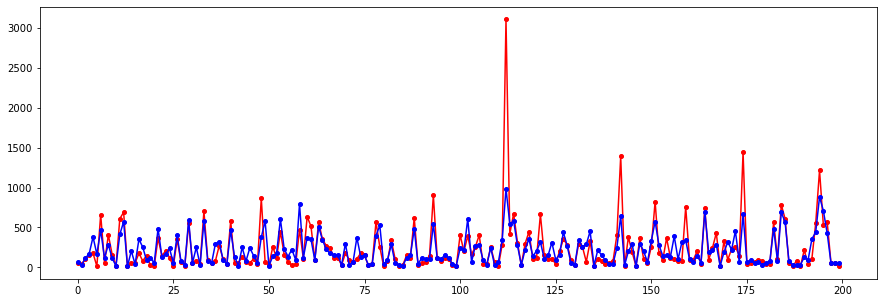

In [256]:
compare_in_plot(y_valid, y_pred_xgbt1)

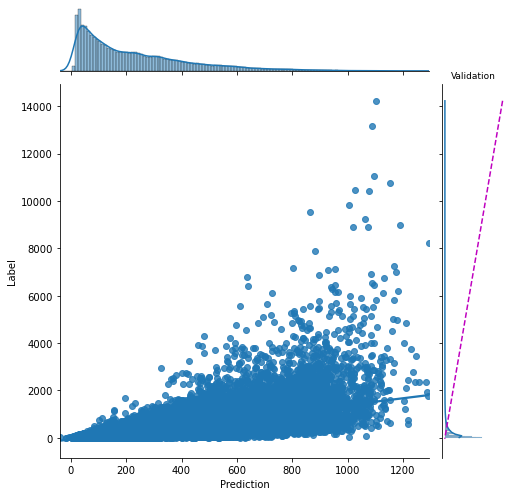

In [257]:
model_performance_sc_plot(y_pred_xgbt1, y_valid, 'Validation')

Analysis of XGBoost's hyperparameters

General parameters
1. booster: base learner of XGBoost, can be chosen from gbtree and gblinear. Default is gbtree.
2. nethread: number of threads. Default to maximum number of threads available if not set.

Parameters for Tree Booster

3. eta: default=0.3, learning rate of shrinkage
4. gamma: minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
5. max_depth: maximum depth of the tree. default = 6
6. min_child_weight: if the sum of data sample weight on a child node is less than the min_child_weight, the tree will stop spilting. The larger, the more conservative the algorithm will be.
7. subsample: ratio of bootstrap sampling
8. colsample_bytree: column sampling ratio. similiar with random forest.

Task parameter

9. objective: depend on the task type. default = "reg:linear". Classification:“reg:logistic”, “binary:logistic, “binary:logitraw”, “multi:softmax”, “multi:softprob”... Regression: “reg:linear”, “count:poisson”. Ranking: “rank:pairwise”.
10. base_score: default=0.5. the initial prediction score of all instances, global bias.
11. eval_metric: default value: rmse for regression, and error for classification, mean average precision for ranking.

In [156]:
XGBmodel = xgb.train({'max_depth':7, 'eta':0.4, 'subsample':0.7, 'colsample_bytree':0.8},
          dtrain=dtrain,
          obj=squared_log,
          feval=rmsle,
          num_boost_round=15000,
          evals=[(dtrain, 'dtrain'), (dtest, 'dtest')])

[0]	dtrain-rmse:474.15414	dtrain-PyRMSLE:4.36665	dtest-rmse:474.07300	dtest-PyRMSLE:4.37323
[1]	dtrain-rmse:473.79321	dtrain-PyRMSLE:4.09761	dtest-rmse:473.70038	dtest-PyRMSLE:4.10414
[2]	dtrain-rmse:473.30756	dtrain-PyRMSLE:3.83309	dtest-rmse:473.21951	dtest-PyRMSLE:3.83955
[3]	dtrain-rmse:472.68185	dtrain-PyRMSLE:3.57354	dtest-rmse:472.58505	dtest-PyRMSLE:3.57990
[4]	dtrain-rmse:471.87198	dtrain-PyRMSLE:3.31973	dtest-rmse:471.76007	dtest-PyRMSLE:3.32603
[5]	dtrain-rmse:470.81638	dtrain-PyRMSLE:3.07237	dtest-rmse:470.70273	dtest-PyRMSLE:3.07856
[6]	dtrain-rmse:469.46329	dtrain-PyRMSLE:2.83224	dtest-rmse:469.33695	dtest-PyRMSLE:2.83829
[7]	dtrain-rmse:467.75925	dtrain-PyRMSLE:2.60093	dtest-rmse:467.61240	dtest-PyRMSLE:2.60687
[8]	dtrain-rmse:465.60291	dtrain-PyRMSLE:2.37943	dtest-rmse:465.45236	dtest-PyRMSLE:2.38522
[9]	dtrain-rmse:462.90268	dtrain-PyRMSLE:2.16796	dtest-rmse:462.73416	dtest-PyRMSLE:2.17362
[10]	dtrain-rmse:459.60126	dtrain-PyRMSLE:1.96901	dtest-rmse:459.39932	dtest-PyR

[89]	dtrain-rmse:346.53232	dtrain-PyRMSLE:0.81542	dtest-rmse:344.95926	dtest-PyRMSLE:0.81707
[90]	dtrain-rmse:346.44739	dtrain-PyRMSLE:0.81483	dtest-rmse:344.87503	dtest-PyRMSLE:0.81653
[91]	dtrain-rmse:346.26712	dtrain-PyRMSLE:0.81294	dtest-rmse:344.68976	dtest-PyRMSLE:0.81461
[92]	dtrain-rmse:346.01923	dtrain-PyRMSLE:0.81251	dtest-rmse:344.44000	dtest-PyRMSLE:0.81419
[93]	dtrain-rmse:345.82153	dtrain-PyRMSLE:0.81210	dtest-rmse:344.23917	dtest-PyRMSLE:0.81378
[94]	dtrain-rmse:345.60254	dtrain-PyRMSLE:0.81116	dtest-rmse:344.01843	dtest-PyRMSLE:0.81286
[95]	dtrain-rmse:345.52591	dtrain-PyRMSLE:0.81082	dtest-rmse:343.94202	dtest-PyRMSLE:0.81254
[96]	dtrain-rmse:345.46170	dtrain-PyRMSLE:0.81026	dtest-rmse:343.87952	dtest-PyRMSLE:0.81200
[97]	dtrain-rmse:345.30344	dtrain-PyRMSLE:0.80983	dtest-rmse:343.72226	dtest-PyRMSLE:0.81161
[98]	dtrain-rmse:345.09082	dtrain-PyRMSLE:0.80917	dtest-rmse:343.50140	dtest-PyRMSLE:0.81098
[99]	dtrain-rmse:344.94254	dtrain-PyRMSLE:0.80873	dtest-rmse:343.35028

[177]	dtrain-rmse:337.65305	dtrain-PyRMSLE:0.77560	dtest-rmse:335.97382	dtest-PyRMSLE:0.77706
[178]	dtrain-rmse:337.64047	dtrain-PyRMSLE:0.77535	dtest-rmse:335.96152	dtest-PyRMSLE:0.77682
[179]	dtrain-rmse:337.52908	dtrain-PyRMSLE:0.77514	dtest-rmse:335.84827	dtest-PyRMSLE:0.77658
[180]	dtrain-rmse:337.43652	dtrain-PyRMSLE:0.77483	dtest-rmse:335.75491	dtest-PyRMSLE:0.77624
[181]	dtrain-rmse:337.40048	dtrain-PyRMSLE:0.77456	dtest-rmse:335.71957	dtest-PyRMSLE:0.77598
[182]	dtrain-rmse:337.35910	dtrain-PyRMSLE:0.77430	dtest-rmse:335.67777	dtest-PyRMSLE:0.77570
[183]	dtrain-rmse:337.23004	dtrain-PyRMSLE:0.77400	dtest-rmse:335.54748	dtest-PyRMSLE:0.77545
[184]	dtrain-rmse:337.12631	dtrain-PyRMSLE:0.77390	dtest-rmse:335.44440	dtest-PyRMSLE:0.77534
[185]	dtrain-rmse:337.06680	dtrain-PyRMSLE:0.77379	dtest-rmse:335.38644	dtest-PyRMSLE:0.77521
[186]	dtrain-rmse:336.95358	dtrain-PyRMSLE:0.77340	dtest-rmse:335.26965	dtest-PyRMSLE:0.77481
[187]	dtrain-rmse:336.90085	dtrain-PyRMSLE:0.77303	dtest-rms

[265]	dtrain-rmse:331.92459	dtrain-PyRMSLE:0.75437	dtest-rmse:330.21268	dtest-PyRMSLE:0.75561
[266]	dtrain-rmse:331.90784	dtrain-PyRMSLE:0.75419	dtest-rmse:330.19565	dtest-PyRMSLE:0.75541
[267]	dtrain-rmse:331.92953	dtrain-PyRMSLE:0.75389	dtest-rmse:330.22067	dtest-PyRMSLE:0.75512
[268]	dtrain-rmse:331.91928	dtrain-PyRMSLE:0.75371	dtest-rmse:330.21097	dtest-PyRMSLE:0.75497
[269]	dtrain-rmse:331.84701	dtrain-PyRMSLE:0.75344	dtest-rmse:330.13724	dtest-PyRMSLE:0.75468
[270]	dtrain-rmse:331.83932	dtrain-PyRMSLE:0.75290	dtest-rmse:330.12872	dtest-PyRMSLE:0.75417
[271]	dtrain-rmse:331.71628	dtrain-PyRMSLE:0.75282	dtest-rmse:330.00263	dtest-PyRMSLE:0.75412
[272]	dtrain-rmse:331.67529	dtrain-PyRMSLE:0.75278	dtest-rmse:329.96164	dtest-PyRMSLE:0.75408
[273]	dtrain-rmse:331.70743	dtrain-PyRMSLE:0.75240	dtest-rmse:329.99756	dtest-PyRMSLE:0.75368
[274]	dtrain-rmse:331.66693	dtrain-PyRMSLE:0.75221	dtest-rmse:329.95828	dtest-PyRMSLE:0.75350
[275]	dtrain-rmse:331.56558	dtrain-PyRMSLE:0.75207	dtest-rms

[353]	dtrain-rmse:327.87476	dtrain-PyRMSLE:0.73736	dtest-rmse:326.12933	dtest-PyRMSLE:0.73859
[354]	dtrain-rmse:327.82895	dtrain-PyRMSLE:0.73730	dtest-rmse:326.08289	dtest-PyRMSLE:0.73855
[355]	dtrain-rmse:327.74793	dtrain-PyRMSLE:0.73730	dtest-rmse:326.00110	dtest-PyRMSLE:0.73855
[356]	dtrain-rmse:327.65814	dtrain-PyRMSLE:0.73722	dtest-rmse:325.91043	dtest-PyRMSLE:0.73843
[357]	dtrain-rmse:327.54428	dtrain-PyRMSLE:0.73695	dtest-rmse:325.79498	dtest-PyRMSLE:0.73816
[358]	dtrain-rmse:327.59106	dtrain-PyRMSLE:0.73662	dtest-rmse:325.84412	dtest-PyRMSLE:0.73782
[359]	dtrain-rmse:327.49774	dtrain-PyRMSLE:0.73642	dtest-rmse:325.75220	dtest-PyRMSLE:0.73763
[360]	dtrain-rmse:327.45566	dtrain-PyRMSLE:0.73648	dtest-rmse:325.71020	dtest-PyRMSLE:0.73768
[361]	dtrain-rmse:327.43509	dtrain-PyRMSLE:0.73631	dtest-rmse:325.68921	dtest-PyRMSLE:0.73753
[362]	dtrain-rmse:327.26465	dtrain-PyRMSLE:0.73594	dtest-rmse:325.51761	dtest-PyRMSLE:0.73714
[363]	dtrain-rmse:327.13834	dtrain-PyRMSLE:0.73585	dtest-rms

[441]	dtrain-rmse:323.09085	dtrain-PyRMSLE:0.72571	dtest-rmse:321.29938	dtest-PyRMSLE:0.72708
[442]	dtrain-rmse:323.10507	dtrain-PyRMSLE:0.72552	dtest-rmse:321.31702	dtest-PyRMSLE:0.72688
[443]	dtrain-rmse:323.10959	dtrain-PyRMSLE:0.72536	dtest-rmse:321.32144	dtest-PyRMSLE:0.72673
[444]	dtrain-rmse:323.04230	dtrain-PyRMSLE:0.72535	dtest-rmse:321.25308	dtest-PyRMSLE:0.72672
[445]	dtrain-rmse:322.99570	dtrain-PyRMSLE:0.72533	dtest-rmse:321.20651	dtest-PyRMSLE:0.72668
[446]	dtrain-rmse:323.02191	dtrain-PyRMSLE:0.72508	dtest-rmse:321.23337	dtest-PyRMSLE:0.72643
[447]	dtrain-rmse:322.98517	dtrain-PyRMSLE:0.72510	dtest-rmse:321.19543	dtest-PyRMSLE:0.72647
[448]	dtrain-rmse:322.97003	dtrain-PyRMSLE:0.72497	dtest-rmse:321.18033	dtest-PyRMSLE:0.72634
[449]	dtrain-rmse:322.95013	dtrain-PyRMSLE:0.72490	dtest-rmse:321.16080	dtest-PyRMSLE:0.72627
[450]	dtrain-rmse:322.93686	dtrain-PyRMSLE:0.72488	dtest-rmse:321.14709	dtest-PyRMSLE:0.72626
[451]	dtrain-rmse:322.90756	dtrain-PyRMSLE:0.72479	dtest-rms

[529]	dtrain-rmse:320.44208	dtrain-PyRMSLE:0.71472	dtest-rmse:318.63165	dtest-PyRMSLE:0.71638
[530]	dtrain-rmse:320.35770	dtrain-PyRMSLE:0.71471	dtest-rmse:318.54382	dtest-PyRMSLE:0.71636
[531]	dtrain-rmse:320.34170	dtrain-PyRMSLE:0.71465	dtest-rmse:318.52692	dtest-PyRMSLE:0.71631
[532]	dtrain-rmse:320.33569	dtrain-PyRMSLE:0.71459	dtest-rmse:318.52097	dtest-PyRMSLE:0.71625
[533]	dtrain-rmse:320.29135	dtrain-PyRMSLE:0.71463	dtest-rmse:318.47800	dtest-PyRMSLE:0.71627
[534]	dtrain-rmse:320.31000	dtrain-PyRMSLE:0.71448	dtest-rmse:318.49930	dtest-PyRMSLE:0.71612
[535]	dtrain-rmse:320.31528	dtrain-PyRMSLE:0.71445	dtest-rmse:318.50461	dtest-PyRMSLE:0.71611
[536]	dtrain-rmse:320.31885	dtrain-PyRMSLE:0.71436	dtest-rmse:318.50912	dtest-PyRMSLE:0.71603
[537]	dtrain-rmse:320.31619	dtrain-PyRMSLE:0.71419	dtest-rmse:318.50711	dtest-PyRMSLE:0.71586
[538]	dtrain-rmse:320.30136	dtrain-PyRMSLE:0.71405	dtest-rmse:318.49262	dtest-PyRMSLE:0.71573
[539]	dtrain-rmse:320.24805	dtrain-PyRMSLE:0.71398	dtest-rms

[617]	dtrain-rmse:318.17566	dtrain-PyRMSLE:0.70762	dtest-rmse:316.35242	dtest-PyRMSLE:0.70955
[618]	dtrain-rmse:318.17239	dtrain-PyRMSLE:0.70744	dtest-rmse:316.34921	dtest-PyRMSLE:0.70938
[619]	dtrain-rmse:318.12412	dtrain-PyRMSLE:0.70738	dtest-rmse:316.30160	dtest-PyRMSLE:0.70932
[620]	dtrain-rmse:318.10504	dtrain-PyRMSLE:0.70733	dtest-rmse:316.28247	dtest-PyRMSLE:0.70925
[621]	dtrain-rmse:318.09195	dtrain-PyRMSLE:0.70718	dtest-rmse:316.26898	dtest-PyRMSLE:0.70910
[622]	dtrain-rmse:318.09814	dtrain-PyRMSLE:0.70714	dtest-rmse:316.27554	dtest-PyRMSLE:0.70907
[623]	dtrain-rmse:318.04816	dtrain-PyRMSLE:0.70696	dtest-rmse:316.22360	dtest-PyRMSLE:0.70891
[624]	dtrain-rmse:318.02747	dtrain-PyRMSLE:0.70694	dtest-rmse:316.20209	dtest-PyRMSLE:0.70889
[625]	dtrain-rmse:318.04013	dtrain-PyRMSLE:0.70690	dtest-rmse:316.21494	dtest-PyRMSLE:0.70884
[626]	dtrain-rmse:318.01150	dtrain-PyRMSLE:0.70672	dtest-rmse:316.18518	dtest-PyRMSLE:0.70864
[627]	dtrain-rmse:317.96924	dtrain-PyRMSLE:0.70678	dtest-rms

[705]	dtrain-rmse:316.41602	dtrain-PyRMSLE:0.70184	dtest-rmse:314.57929	dtest-PyRMSLE:0.70386
[706]	dtrain-rmse:316.42731	dtrain-PyRMSLE:0.70166	dtest-rmse:314.59143	dtest-PyRMSLE:0.70369
[707]	dtrain-rmse:316.40024	dtrain-PyRMSLE:0.70168	dtest-rmse:314.56323	dtest-PyRMSLE:0.70370
[708]	dtrain-rmse:316.38580	dtrain-PyRMSLE:0.70167	dtest-rmse:314.54919	dtest-PyRMSLE:0.70371
[709]	dtrain-rmse:316.36133	dtrain-PyRMSLE:0.70160	dtest-rmse:314.52499	dtest-PyRMSLE:0.70363
[710]	dtrain-rmse:316.34265	dtrain-PyRMSLE:0.70156	dtest-rmse:314.50565	dtest-PyRMSLE:0.70362
[711]	dtrain-rmse:316.32098	dtrain-PyRMSLE:0.70150	dtest-rmse:314.48486	dtest-PyRMSLE:0.70356
[712]	dtrain-rmse:316.30234	dtrain-PyRMSLE:0.70149	dtest-rmse:314.46726	dtest-PyRMSLE:0.70358
[713]	dtrain-rmse:316.30405	dtrain-PyRMSLE:0.70136	dtest-rmse:314.46921	dtest-PyRMSLE:0.70344
[714]	dtrain-rmse:316.25207	dtrain-PyRMSLE:0.70131	dtest-rmse:314.41641	dtest-PyRMSLE:0.70337
[715]	dtrain-rmse:316.26090	dtrain-PyRMSLE:0.70123	dtest-rms

[793]	dtrain-rmse:314.67844	dtrain-PyRMSLE:0.69563	dtest-rmse:312.83743	dtest-PyRMSLE:0.69787
[794]	dtrain-rmse:314.67993	dtrain-PyRMSLE:0.69556	dtest-rmse:312.83902	dtest-PyRMSLE:0.69781
[795]	dtrain-rmse:314.66180	dtrain-PyRMSLE:0.69549	dtest-rmse:312.82181	dtest-PyRMSLE:0.69776
[796]	dtrain-rmse:314.62894	dtrain-PyRMSLE:0.69542	dtest-rmse:312.78757	dtest-PyRMSLE:0.69770
[797]	dtrain-rmse:314.55240	dtrain-PyRMSLE:0.69542	dtest-rmse:312.71011	dtest-PyRMSLE:0.69773
[798]	dtrain-rmse:314.51706	dtrain-PyRMSLE:0.69548	dtest-rmse:312.67407	dtest-PyRMSLE:0.69780
[799]	dtrain-rmse:314.51590	dtrain-PyRMSLE:0.69539	dtest-rmse:312.67325	dtest-PyRMSLE:0.69774
[800]	dtrain-rmse:314.48489	dtrain-PyRMSLE:0.69543	dtest-rmse:312.64267	dtest-PyRMSLE:0.69779
[801]	dtrain-rmse:314.46017	dtrain-PyRMSLE:0.69539	dtest-rmse:312.61874	dtest-PyRMSLE:0.69774
[802]	dtrain-rmse:314.41849	dtrain-PyRMSLE:0.69531	dtest-rmse:312.57675	dtest-PyRMSLE:0.69760
[803]	dtrain-rmse:314.41071	dtrain-PyRMSLE:0.69525	dtest-rms

[881]	dtrain-rmse:312.90988	dtrain-PyRMSLE:0.69078	dtest-rmse:311.05954	dtest-PyRMSLE:0.69498
[882]	dtrain-rmse:312.87317	dtrain-PyRMSLE:0.69079	dtest-rmse:311.02252	dtest-PyRMSLE:0.69500
[883]	dtrain-rmse:312.89447	dtrain-PyRMSLE:0.69059	dtest-rmse:311.04483	dtest-PyRMSLE:0.69480
[884]	dtrain-rmse:312.87961	dtrain-PyRMSLE:0.69057	dtest-rmse:311.02966	dtest-PyRMSLE:0.69480
[885]	dtrain-rmse:312.87054	dtrain-PyRMSLE:0.69051	dtest-rmse:311.02045	dtest-PyRMSLE:0.69473
[886]	dtrain-rmse:312.85977	dtrain-PyRMSLE:0.69041	dtest-rmse:311.00925	dtest-PyRMSLE:0.69462
[887]	dtrain-rmse:312.87293	dtrain-PyRMSLE:0.69025	dtest-rmse:311.02332	dtest-PyRMSLE:0.69446
[888]	dtrain-rmse:312.86804	dtrain-PyRMSLE:0.69021	dtest-rmse:311.01889	dtest-PyRMSLE:0.69441
[889]	dtrain-rmse:312.84463	dtrain-PyRMSLE:0.69012	dtest-rmse:310.99454	dtest-PyRMSLE:0.69434
[890]	dtrain-rmse:312.79254	dtrain-PyRMSLE:0.69013	dtest-rmse:310.94229	dtest-PyRMSLE:0.69434
[891]	dtrain-rmse:312.74670	dtrain-PyRMSLE:0.69011	dtest-rms

[969]	dtrain-rmse:311.45196	dtrain-PyRMSLE:0.68670	dtest-rmse:309.59753	dtest-PyRMSLE:0.69270
[970]	dtrain-rmse:311.46323	dtrain-PyRMSLE:0.68656	dtest-rmse:309.60907	dtest-PyRMSLE:0.69256
[971]	dtrain-rmse:311.42426	dtrain-PyRMSLE:0.68645	dtest-rmse:309.57031	dtest-PyRMSLE:0.69248
[972]	dtrain-rmse:311.35696	dtrain-PyRMSLE:0.68640	dtest-rmse:309.50165	dtest-PyRMSLE:0.69244
[973]	dtrain-rmse:311.34103	dtrain-PyRMSLE:0.68645	dtest-rmse:309.48489	dtest-PyRMSLE:0.69249
[974]	dtrain-rmse:311.31430	dtrain-PyRMSLE:0.68635	dtest-rmse:309.45837	dtest-PyRMSLE:0.69240
[975]	dtrain-rmse:311.27795	dtrain-PyRMSLE:0.68633	dtest-rmse:309.42151	dtest-PyRMSLE:0.69238
[976]	dtrain-rmse:311.26117	dtrain-PyRMSLE:0.68638	dtest-rmse:309.40366	dtest-PyRMSLE:0.69243
[977]	dtrain-rmse:311.25333	dtrain-PyRMSLE:0.68642	dtest-rmse:309.39612	dtest-PyRMSLE:0.69246
[978]	dtrain-rmse:311.24197	dtrain-PyRMSLE:0.68631	dtest-rmse:309.38458	dtest-PyRMSLE:0.69235
[979]	dtrain-rmse:311.21551	dtrain-PyRMSLE:0.68633	dtest-rms

[1056]	dtrain-rmse:310.06738	dtrain-PyRMSLE:0.68315	dtest-rmse:308.20282	dtest-PyRMSLE:0.69116
[1057]	dtrain-rmse:310.01858	dtrain-PyRMSLE:0.68307	dtest-rmse:308.15341	dtest-PyRMSLE:0.69109
[1058]	dtrain-rmse:310.00067	dtrain-PyRMSLE:0.68307	dtest-rmse:308.13486	dtest-PyRMSLE:0.69109
[1059]	dtrain-rmse:310.01349	dtrain-PyRMSLE:0.68302	dtest-rmse:308.14850	dtest-PyRMSLE:0.69105
[1060]	dtrain-rmse:309.99435	dtrain-PyRMSLE:0.68306	dtest-rmse:308.12906	dtest-PyRMSLE:0.69108
[1061]	dtrain-rmse:309.98392	dtrain-PyRMSLE:0.68304	dtest-rmse:308.11945	dtest-PyRMSLE:0.69107
[1062]	dtrain-rmse:309.96750	dtrain-PyRMSLE:0.68303	dtest-rmse:308.10297	dtest-PyRMSLE:0.69106
[1063]	dtrain-rmse:309.96771	dtrain-PyRMSLE:0.68295	dtest-rmse:308.10391	dtest-PyRMSLE:0.69098
[1064]	dtrain-rmse:309.97882	dtrain-PyRMSLE:0.68292	dtest-rmse:308.11511	dtest-PyRMSLE:0.69095
[1065]	dtrain-rmse:309.95425	dtrain-PyRMSLE:0.68295	dtest-rmse:308.09009	dtest-PyRMSLE:0.69099
[1066]	dtrain-rmse:309.93597	dtrain-PyRMSLE:0.6829

[1143]	dtrain-rmse:308.89487	dtrain-PyRMSLE:0.68000	dtest-rmse:307.02829	dtest-PyRMSLE:0.68830
[1144]	dtrain-rmse:308.88754	dtrain-PyRMSLE:0.67998	dtest-rmse:307.02194	dtest-PyRMSLE:0.68827
[1145]	dtrain-rmse:308.87796	dtrain-PyRMSLE:0.67999	dtest-rmse:307.01196	dtest-PyRMSLE:0.68829
[1146]	dtrain-rmse:308.86459	dtrain-PyRMSLE:0.67994	dtest-rmse:306.99805	dtest-PyRMSLE:0.68824
[1147]	dtrain-rmse:308.84387	dtrain-PyRMSLE:0.67990	dtest-rmse:306.97656	dtest-PyRMSLE:0.68821
[1148]	dtrain-rmse:308.82672	dtrain-PyRMSLE:0.67993	dtest-rmse:306.95941	dtest-PyRMSLE:0.68822
[1149]	dtrain-rmse:308.81317	dtrain-PyRMSLE:0.67985	dtest-rmse:306.94464	dtest-PyRMSLE:0.68813
[1150]	dtrain-rmse:308.80374	dtrain-PyRMSLE:0.67988	dtest-rmse:306.93558	dtest-PyRMSLE:0.68817
[1151]	dtrain-rmse:308.77020	dtrain-PyRMSLE:0.67993	dtest-rmse:306.90085	dtest-PyRMSLE:0.68823
[1152]	dtrain-rmse:308.75928	dtrain-PyRMSLE:0.67990	dtest-rmse:306.89069	dtest-PyRMSLE:0.68820
[1153]	dtrain-rmse:308.75430	dtrain-PyRMSLE:0.6797

[1230]	dtrain-rmse:307.84924	dtrain-PyRMSLE:0.67722	dtest-rmse:305.96854	dtest-PyRMSLE:0.68567
[1231]	dtrain-rmse:307.85089	dtrain-PyRMSLE:0.67718	dtest-rmse:305.97064	dtest-PyRMSLE:0.68563
[1232]	dtrain-rmse:307.84146	dtrain-PyRMSLE:0.67715	dtest-rmse:305.96060	dtest-PyRMSLE:0.68561
[1233]	dtrain-rmse:307.84766	dtrain-PyRMSLE:0.67710	dtest-rmse:305.96670	dtest-PyRMSLE:0.68557
[1234]	dtrain-rmse:307.84509	dtrain-PyRMSLE:0.67706	dtest-rmse:305.96323	dtest-PyRMSLE:0.68553
[1235]	dtrain-rmse:307.83417	dtrain-PyRMSLE:0.67703	dtest-rmse:305.95245	dtest-PyRMSLE:0.68549
[1236]	dtrain-rmse:307.83121	dtrain-PyRMSLE:0.67700	dtest-rmse:305.94974	dtest-PyRMSLE:0.68547
[1237]	dtrain-rmse:307.82153	dtrain-PyRMSLE:0.67692	dtest-rmse:305.94031	dtest-PyRMSLE:0.68538
[1238]	dtrain-rmse:307.80701	dtrain-PyRMSLE:0.67688	dtest-rmse:305.92593	dtest-PyRMSLE:0.68535
[1239]	dtrain-rmse:307.80063	dtrain-PyRMSLE:0.67685	dtest-rmse:305.91907	dtest-PyRMSLE:0.68532
[1240]	dtrain-rmse:307.76892	dtrain-PyRMSLE:0.6768

[1317]	dtrain-rmse:306.93133	dtrain-PyRMSLE:0.67457	dtest-rmse:305.04047	dtest-PyRMSLE:0.68320
[1318]	dtrain-rmse:306.91061	dtrain-PyRMSLE:0.67458	dtest-rmse:305.02026	dtest-PyRMSLE:0.68321
[1319]	dtrain-rmse:306.88693	dtrain-PyRMSLE:0.67459	dtest-rmse:304.99545	dtest-PyRMSLE:0.68322
[1320]	dtrain-rmse:306.89188	dtrain-PyRMSLE:0.67451	dtest-rmse:305.00092	dtest-PyRMSLE:0.68315
[1321]	dtrain-rmse:306.89325	dtrain-PyRMSLE:0.67449	dtest-rmse:305.00235	dtest-PyRMSLE:0.68313
[1322]	dtrain-rmse:306.86227	dtrain-PyRMSLE:0.67449	dtest-rmse:304.97089	dtest-PyRMSLE:0.68313
[1323]	dtrain-rmse:306.84357	dtrain-PyRMSLE:0.67432	dtest-rmse:304.95157	dtest-PyRMSLE:0.68297
[1324]	dtrain-rmse:306.79608	dtrain-PyRMSLE:0.67432	dtest-rmse:304.90414	dtest-PyRMSLE:0.68295
[1325]	dtrain-rmse:306.79544	dtrain-PyRMSLE:0.67427	dtest-rmse:304.90402	dtest-PyRMSLE:0.68292
[1326]	dtrain-rmse:306.78717	dtrain-PyRMSLE:0.67424	dtest-rmse:304.89517	dtest-PyRMSLE:0.68289
[1327]	dtrain-rmse:306.76923	dtrain-PyRMSLE:0.6742

[1404]	dtrain-rmse:305.98999	dtrain-PyRMSLE:0.67207	dtest-rmse:304.09079	dtest-PyRMSLE:0.68084
[1405]	dtrain-rmse:305.98618	dtrain-PyRMSLE:0.67204	dtest-rmse:304.08652	dtest-PyRMSLE:0.68081
[1406]	dtrain-rmse:305.98257	dtrain-PyRMSLE:0.67200	dtest-rmse:304.08203	dtest-PyRMSLE:0.68078
[1407]	dtrain-rmse:305.97717	dtrain-PyRMSLE:0.67188	dtest-rmse:304.07800	dtest-PyRMSLE:0.68066
[1408]	dtrain-rmse:305.97873	dtrain-PyRMSLE:0.67187	dtest-rmse:304.07965	dtest-PyRMSLE:0.68065
[1409]	dtrain-rmse:305.97467	dtrain-PyRMSLE:0.67187	dtest-rmse:304.07529	dtest-PyRMSLE:0.68064
[1410]	dtrain-rmse:305.97089	dtrain-PyRMSLE:0.67186	dtest-rmse:304.07159	dtest-PyRMSLE:0.68063
[1411]	dtrain-rmse:305.94247	dtrain-PyRMSLE:0.67189	dtest-rmse:304.04227	dtest-PyRMSLE:0.68066
[1412]	dtrain-rmse:305.91687	dtrain-PyRMSLE:0.67188	dtest-rmse:304.01657	dtest-PyRMSLE:0.68066
[1413]	dtrain-rmse:305.92618	dtrain-PyRMSLE:0.67179	dtest-rmse:304.02640	dtest-PyRMSLE:0.68056
[1414]	dtrain-rmse:305.90686	dtrain-PyRMSLE:0.6717

[1491]	dtrain-rmse:305.20810	dtrain-PyRMSLE:0.66984	dtest-rmse:303.30560	dtest-PyRMSLE:0.67878
[1492]	dtrain-rmse:305.20017	dtrain-PyRMSLE:0.66974	dtest-rmse:303.29746	dtest-PyRMSLE:0.67868
[1493]	dtrain-rmse:305.18796	dtrain-PyRMSLE:0.66974	dtest-rmse:303.28525	dtest-PyRMSLE:0.67868
[1494]	dtrain-rmse:305.18393	dtrain-PyRMSLE:0.66972	dtest-rmse:303.28052	dtest-PyRMSLE:0.67867
[1495]	dtrain-rmse:305.18158	dtrain-PyRMSLE:0.66968	dtest-rmse:303.27731	dtest-PyRMSLE:0.67864
[1496]	dtrain-rmse:305.16998	dtrain-PyRMSLE:0.66964	dtest-rmse:303.26697	dtest-PyRMSLE:0.67861
[1497]	dtrain-rmse:305.15939	dtrain-PyRMSLE:0.66965	dtest-rmse:303.25565	dtest-PyRMSLE:0.67860
[1498]	dtrain-rmse:305.13358	dtrain-PyRMSLE:0.66967	dtest-rmse:303.22940	dtest-PyRMSLE:0.67864
[1499]	dtrain-rmse:305.13107	dtrain-PyRMSLE:0.66964	dtest-rmse:303.22659	dtest-PyRMSLE:0.67861
[1500]	dtrain-rmse:305.12207	dtrain-PyRMSLE:0.66958	dtest-rmse:303.21704	dtest-PyRMSLE:0.67855
[1501]	dtrain-rmse:305.10947	dtrain-PyRMSLE:0.6696

[1578]	dtrain-rmse:304.54733	dtrain-PyRMSLE:0.66788	dtest-rmse:302.64169	dtest-PyRMSLE:0.67702
[1579]	dtrain-rmse:304.53278	dtrain-PyRMSLE:0.66787	dtest-rmse:302.62665	dtest-PyRMSLE:0.67700
[1580]	dtrain-rmse:304.52899	dtrain-PyRMSLE:0.66781	dtest-rmse:302.62329	dtest-PyRMSLE:0.67694
[1581]	dtrain-rmse:304.53406	dtrain-PyRMSLE:0.66777	dtest-rmse:302.62897	dtest-PyRMSLE:0.67690
[1582]	dtrain-rmse:304.52985	dtrain-PyRMSLE:0.66777	dtest-rmse:302.62375	dtest-PyRMSLE:0.67690
[1583]	dtrain-rmse:304.52121	dtrain-PyRMSLE:0.66781	dtest-rmse:302.61514	dtest-PyRMSLE:0.67694
[1584]	dtrain-rmse:304.51019	dtrain-PyRMSLE:0.66784	dtest-rmse:302.60413	dtest-PyRMSLE:0.67696
[1585]	dtrain-rmse:304.49463	dtrain-PyRMSLE:0.66781	dtest-rmse:302.58936	dtest-PyRMSLE:0.67694
[1586]	dtrain-rmse:304.49521	dtrain-PyRMSLE:0.66777	dtest-rmse:302.58997	dtest-PyRMSLE:0.67691
[1587]	dtrain-rmse:304.47937	dtrain-PyRMSLE:0.66776	dtest-rmse:302.57480	dtest-PyRMSLE:0.67691
[1588]	dtrain-rmse:304.47360	dtrain-PyRMSLE:0.6676

[1665]	dtrain-rmse:303.81323	dtrain-PyRMSLE:0.66598	dtest-rmse:301.90253	dtest-PyRMSLE:0.67524
[1666]	dtrain-rmse:303.80896	dtrain-PyRMSLE:0.66596	dtest-rmse:301.89807	dtest-PyRMSLE:0.67521
[1667]	dtrain-rmse:303.81513	dtrain-PyRMSLE:0.66593	dtest-rmse:301.90381	dtest-PyRMSLE:0.67519
[1668]	dtrain-rmse:303.80939	dtrain-PyRMSLE:0.66592	dtest-rmse:301.89865	dtest-PyRMSLE:0.67519
[1669]	dtrain-rmse:303.81030	dtrain-PyRMSLE:0.66587	dtest-rmse:301.89853	dtest-PyRMSLE:0.67515
[1670]	dtrain-rmse:303.80029	dtrain-PyRMSLE:0.66583	dtest-rmse:301.88785	dtest-PyRMSLE:0.67510
[1671]	dtrain-rmse:303.76227	dtrain-PyRMSLE:0.66587	dtest-rmse:301.85010	dtest-PyRMSLE:0.67515
[1672]	dtrain-rmse:303.73642	dtrain-PyRMSLE:0.66583	dtest-rmse:301.82398	dtest-PyRMSLE:0.67511
[1673]	dtrain-rmse:303.74271	dtrain-PyRMSLE:0.66573	dtest-rmse:301.83078	dtest-PyRMSLE:0.67501
[1674]	dtrain-rmse:303.71899	dtrain-PyRMSLE:0.66570	dtest-rmse:301.80539	dtest-PyRMSLE:0.67498
[1675]	dtrain-rmse:303.70123	dtrain-PyRMSLE:0.6657

[1752]	dtrain-rmse:303.07892	dtrain-PyRMSLE:0.66412	dtest-rmse:301.15951	dtest-PyRMSLE:0.67359
[1753]	dtrain-rmse:303.05734	dtrain-PyRMSLE:0.66413	dtest-rmse:301.13824	dtest-PyRMSLE:0.67361
[1754]	dtrain-rmse:303.03882	dtrain-PyRMSLE:0.66410	dtest-rmse:301.11908	dtest-PyRMSLE:0.67358
[1755]	dtrain-rmse:303.03809	dtrain-PyRMSLE:0.66407	dtest-rmse:301.11917	dtest-PyRMSLE:0.67356
[1756]	dtrain-rmse:303.02609	dtrain-PyRMSLE:0.66401	dtest-rmse:301.10703	dtest-PyRMSLE:0.67349
[1757]	dtrain-rmse:303.00958	dtrain-PyRMSLE:0.66398	dtest-rmse:301.09158	dtest-PyRMSLE:0.67347
[1758]	dtrain-rmse:303.00781	dtrain-PyRMSLE:0.66395	dtest-rmse:301.08917	dtest-PyRMSLE:0.67345
[1759]	dtrain-rmse:303.00040	dtrain-PyRMSLE:0.66392	dtest-rmse:301.08225	dtest-PyRMSLE:0.67343
[1760]	dtrain-rmse:302.98618	dtrain-PyRMSLE:0.66394	dtest-rmse:301.06757	dtest-PyRMSLE:0.67344
[1761]	dtrain-rmse:302.97742	dtrain-PyRMSLE:0.66395	dtest-rmse:301.05896	dtest-PyRMSLE:0.67345
[1762]	dtrain-rmse:302.96893	dtrain-PyRMSLE:0.6639

[1839]	dtrain-rmse:302.35806	dtrain-PyRMSLE:0.66256	dtest-rmse:300.42938	dtest-PyRMSLE:0.67226
[1840]	dtrain-rmse:302.35614	dtrain-PyRMSLE:0.66255	dtest-rmse:300.42734	dtest-PyRMSLE:0.67224
[1841]	dtrain-rmse:302.34909	dtrain-PyRMSLE:0.66253	dtest-rmse:300.41946	dtest-PyRMSLE:0.67223
[1842]	dtrain-rmse:302.34836	dtrain-PyRMSLE:0.66254	dtest-rmse:300.42004	dtest-PyRMSLE:0.67224
[1843]	dtrain-rmse:302.33194	dtrain-PyRMSLE:0.66256	dtest-rmse:300.40347	dtest-PyRMSLE:0.67227
[1844]	dtrain-rmse:302.32056	dtrain-PyRMSLE:0.66253	dtest-rmse:300.39233	dtest-PyRMSLE:0.67224
[1845]	dtrain-rmse:302.31201	dtrain-PyRMSLE:0.66246	dtest-rmse:300.38419	dtest-PyRMSLE:0.67217
[1846]	dtrain-rmse:302.30579	dtrain-PyRMSLE:0.66246	dtest-rmse:300.37784	dtest-PyRMSLE:0.67217
[1847]	dtrain-rmse:302.28827	dtrain-PyRMSLE:0.66248	dtest-rmse:300.35996	dtest-PyRMSLE:0.67219
[1848]	dtrain-rmse:302.26651	dtrain-PyRMSLE:0.66247	dtest-rmse:300.33820	dtest-PyRMSLE:0.67217
[1849]	dtrain-rmse:302.26315	dtrain-PyRMSLE:0.6624

[1926]	dtrain-rmse:301.67007	dtrain-PyRMSLE:0.66081	dtest-rmse:299.73672	dtest-PyRMSLE:0.67068
[1927]	dtrain-rmse:301.66959	dtrain-PyRMSLE:0.66070	dtest-rmse:299.73520	dtest-PyRMSLE:0.67058
[1928]	dtrain-rmse:301.65787	dtrain-PyRMSLE:0.66072	dtest-rmse:299.72363	dtest-PyRMSLE:0.67060
[1929]	dtrain-rmse:301.64658	dtrain-PyRMSLE:0.66071	dtest-rmse:299.71170	dtest-PyRMSLE:0.67060
[1930]	dtrain-rmse:301.63257	dtrain-PyRMSLE:0.66071	dtest-rmse:299.69852	dtest-PyRMSLE:0.67059
[1931]	dtrain-rmse:301.64026	dtrain-PyRMSLE:0.66067	dtest-rmse:299.70731	dtest-PyRMSLE:0.67056
[1932]	dtrain-rmse:301.63065	dtrain-PyRMSLE:0.66066	dtest-rmse:299.69727	dtest-PyRMSLE:0.67055
[1933]	dtrain-rmse:301.60800	dtrain-PyRMSLE:0.66066	dtest-rmse:299.67453	dtest-PyRMSLE:0.67055
[1934]	dtrain-rmse:301.58527	dtrain-PyRMSLE:0.66069	dtest-rmse:299.65161	dtest-PyRMSLE:0.67057
[1935]	dtrain-rmse:301.58298	dtrain-PyRMSLE:0.66067	dtest-rmse:299.64996	dtest-PyRMSLE:0.67056
[1936]	dtrain-rmse:301.57849	dtrain-PyRMSLE:0.6606

[2013]	dtrain-rmse:300.99542	dtrain-PyRMSLE:0.65918	dtest-rmse:299.05521	dtest-PyRMSLE:0.66926
[2014]	dtrain-rmse:300.98950	dtrain-PyRMSLE:0.65917	dtest-rmse:299.04904	dtest-PyRMSLE:0.66926
[2015]	dtrain-rmse:300.98044	dtrain-PyRMSLE:0.65914	dtest-rmse:299.03995	dtest-PyRMSLE:0.66922
[2016]	dtrain-rmse:300.97620	dtrain-PyRMSLE:0.65912	dtest-rmse:299.03610	dtest-PyRMSLE:0.66921
[2017]	dtrain-rmse:300.96991	dtrain-PyRMSLE:0.65908	dtest-rmse:299.03012	dtest-PyRMSLE:0.66917
[2018]	dtrain-rmse:300.95749	dtrain-PyRMSLE:0.65909	dtest-rmse:299.01675	dtest-PyRMSLE:0.66919
[2019]	dtrain-rmse:300.92050	dtrain-PyRMSLE:0.65914	dtest-rmse:298.98025	dtest-PyRMSLE:0.66922
[2020]	dtrain-rmse:300.90015	dtrain-PyRMSLE:0.65908	dtest-rmse:298.95956	dtest-PyRMSLE:0.66917
[2021]	dtrain-rmse:300.89362	dtrain-PyRMSLE:0.65907	dtest-rmse:298.95312	dtest-PyRMSLE:0.66916
[2022]	dtrain-rmse:300.90051	dtrain-PyRMSLE:0.65901	dtest-rmse:298.96054	dtest-PyRMSLE:0.66911
[2023]	dtrain-rmse:300.88840	dtrain-PyRMSLE:0.6590

[2100]	dtrain-rmse:300.44492	dtrain-PyRMSLE:0.65779	dtest-rmse:298.50146	dtest-PyRMSLE:0.66804
[2101]	dtrain-rmse:300.44394	dtrain-PyRMSLE:0.65779	dtest-rmse:298.50034	dtest-PyRMSLE:0.66803
[2102]	dtrain-rmse:300.44653	dtrain-PyRMSLE:0.65778	dtest-rmse:298.50272	dtest-PyRMSLE:0.66803
[2103]	dtrain-rmse:300.44519	dtrain-PyRMSLE:0.65775	dtest-rmse:298.50186	dtest-PyRMSLE:0.66800
[2104]	dtrain-rmse:300.43735	dtrain-PyRMSLE:0.65777	dtest-rmse:298.49335	dtest-PyRMSLE:0.66803
[2105]	dtrain-rmse:300.43967	dtrain-PyRMSLE:0.65771	dtest-rmse:298.49652	dtest-PyRMSLE:0.66797
[2106]	dtrain-rmse:300.43948	dtrain-PyRMSLE:0.65770	dtest-rmse:298.49683	dtest-PyRMSLE:0.66797
[2107]	dtrain-rmse:300.43027	dtrain-PyRMSLE:0.65769	dtest-rmse:298.48737	dtest-PyRMSLE:0.66796
[2108]	dtrain-rmse:300.42856	dtrain-PyRMSLE:0.65771	dtest-rmse:298.48502	dtest-PyRMSLE:0.66798
[2109]	dtrain-rmse:300.38834	dtrain-PyRMSLE:0.65778	dtest-rmse:298.44412	dtest-PyRMSLE:0.66805
[2110]	dtrain-rmse:300.38840	dtrain-PyRMSLE:0.6577

[2187]	dtrain-rmse:299.94601	dtrain-PyRMSLE:0.65650	dtest-rmse:297.99979	dtest-PyRMSLE:0.66686
[2188]	dtrain-rmse:299.95233	dtrain-PyRMSLE:0.65645	dtest-rmse:298.00626	dtest-PyRMSLE:0.66683
[2189]	dtrain-rmse:299.95801	dtrain-PyRMSLE:0.65636	dtest-rmse:298.01227	dtest-PyRMSLE:0.66675
[2190]	dtrain-rmse:299.95581	dtrain-PyRMSLE:0.65636	dtest-rmse:298.00977	dtest-PyRMSLE:0.66676
[2191]	dtrain-rmse:299.94650	dtrain-PyRMSLE:0.65638	dtest-rmse:298.00064	dtest-PyRMSLE:0.66677
[2192]	dtrain-rmse:299.93237	dtrain-PyRMSLE:0.65636	dtest-rmse:297.98721	dtest-PyRMSLE:0.66675
[2193]	dtrain-rmse:299.92554	dtrain-PyRMSLE:0.65632	dtest-rmse:297.98108	dtest-PyRMSLE:0.66672
[2194]	dtrain-rmse:299.91324	dtrain-PyRMSLE:0.65631	dtest-rmse:297.96851	dtest-PyRMSLE:0.66671
[2195]	dtrain-rmse:299.90598	dtrain-PyRMSLE:0.65630	dtest-rmse:297.96072	dtest-PyRMSLE:0.66670
[2196]	dtrain-rmse:299.90314	dtrain-PyRMSLE:0.65630	dtest-rmse:297.95779	dtest-PyRMSLE:0.66669
[2197]	dtrain-rmse:299.90533	dtrain-PyRMSLE:0.6562

[2274]	dtrain-rmse:299.43539	dtrain-PyRMSLE:0.65521	dtest-rmse:297.48749	dtest-PyRMSLE:0.66577
[2275]	dtrain-rmse:299.41348	dtrain-PyRMSLE:0.65520	dtest-rmse:297.46555	dtest-PyRMSLE:0.66576
[2276]	dtrain-rmse:299.39761	dtrain-PyRMSLE:0.65519	dtest-rmse:297.45032	dtest-PyRMSLE:0.66577
[2277]	dtrain-rmse:299.38504	dtrain-PyRMSLE:0.65519	dtest-rmse:297.43811	dtest-PyRMSLE:0.66576
[2278]	dtrain-rmse:299.35794	dtrain-PyRMSLE:0.65521	dtest-rmse:297.40945	dtest-PyRMSLE:0.66578
[2279]	dtrain-rmse:299.36188	dtrain-PyRMSLE:0.65513	dtest-rmse:297.41492	dtest-PyRMSLE:0.66571
[2280]	dtrain-rmse:299.36530	dtrain-PyRMSLE:0.65512	dtest-rmse:297.41791	dtest-PyRMSLE:0.66568
[2281]	dtrain-rmse:299.35828	dtrain-PyRMSLE:0.65510	dtest-rmse:297.41138	dtest-PyRMSLE:0.66567
[2282]	dtrain-rmse:299.35205	dtrain-PyRMSLE:0.65505	dtest-rmse:297.40524	dtest-PyRMSLE:0.66562
[2283]	dtrain-rmse:299.34433	dtrain-PyRMSLE:0.65506	dtest-rmse:297.39703	dtest-PyRMSLE:0.66565
[2284]	dtrain-rmse:299.34656	dtrain-PyRMSLE:0.6550

[2361]	dtrain-rmse:298.95938	dtrain-PyRMSLE:0.65383	dtest-rmse:297.01355	dtest-PyRMSLE:0.66458
[2362]	dtrain-rmse:298.95706	dtrain-PyRMSLE:0.65381	dtest-rmse:297.01129	dtest-PyRMSLE:0.66456
[2363]	dtrain-rmse:298.96808	dtrain-PyRMSLE:0.65376	dtest-rmse:297.02298	dtest-PyRMSLE:0.66450
[2364]	dtrain-rmse:298.96405	dtrain-PyRMSLE:0.65372	dtest-rmse:297.01804	dtest-PyRMSLE:0.66449
[2365]	dtrain-rmse:298.94165	dtrain-PyRMSLE:0.65375	dtest-rmse:296.99484	dtest-PyRMSLE:0.66451
[2366]	dtrain-rmse:298.94174	dtrain-PyRMSLE:0.65369	dtest-rmse:296.99493	dtest-PyRMSLE:0.66446
[2367]	dtrain-rmse:298.92508	dtrain-PyRMSLE:0.65363	dtest-rmse:296.97812	dtest-PyRMSLE:0.66440
[2368]	dtrain-rmse:298.91480	dtrain-PyRMSLE:0.65357	dtest-rmse:296.96704	dtest-PyRMSLE:0.66436
[2369]	dtrain-rmse:298.90689	dtrain-PyRMSLE:0.65358	dtest-rmse:296.95978	dtest-PyRMSLE:0.66436
[2370]	dtrain-rmse:298.88672	dtrain-PyRMSLE:0.65359	dtest-rmse:296.93997	dtest-PyRMSLE:0.66438
[2371]	dtrain-rmse:298.88361	dtrain-PyRMSLE:0.6535

[2448]	dtrain-rmse:298.52469	dtrain-PyRMSLE:0.65268	dtest-rmse:296.57828	dtest-PyRMSLE:0.66359
[2449]	dtrain-rmse:298.52222	dtrain-PyRMSLE:0.65267	dtest-rmse:296.57602	dtest-PyRMSLE:0.66358
[2450]	dtrain-rmse:298.53171	dtrain-PyRMSLE:0.65261	dtest-rmse:296.58496	dtest-PyRMSLE:0.66353
[2451]	dtrain-rmse:298.52835	dtrain-PyRMSLE:0.65258	dtest-rmse:296.58173	dtest-PyRMSLE:0.66350
[2452]	dtrain-rmse:298.49753	dtrain-PyRMSLE:0.65258	dtest-rmse:296.54965	dtest-PyRMSLE:0.66351
[2453]	dtrain-rmse:298.50363	dtrain-PyRMSLE:0.65252	dtest-rmse:296.55600	dtest-PyRMSLE:0.66346
[2454]	dtrain-rmse:298.49393	dtrain-PyRMSLE:0.65248	dtest-rmse:296.54535	dtest-PyRMSLE:0.66341
[2455]	dtrain-rmse:298.49136	dtrain-PyRMSLE:0.65247	dtest-rmse:296.54367	dtest-PyRMSLE:0.66339
[2456]	dtrain-rmse:298.49423	dtrain-PyRMSLE:0.65246	dtest-rmse:296.54733	dtest-PyRMSLE:0.66338
[2457]	dtrain-rmse:298.49188	dtrain-PyRMSLE:0.65242	dtest-rmse:296.54404	dtest-PyRMSLE:0.66334
[2458]	dtrain-rmse:298.47382	dtrain-PyRMSLE:0.6524

[2535]	dtrain-rmse:298.08734	dtrain-PyRMSLE:0.65147	dtest-rmse:296.14166	dtest-PyRMSLE:0.66262
[2536]	dtrain-rmse:298.08377	dtrain-PyRMSLE:0.65143	dtest-rmse:296.13785	dtest-PyRMSLE:0.66258
[2537]	dtrain-rmse:298.07700	dtrain-PyRMSLE:0.65141	dtest-rmse:296.13089	dtest-PyRMSLE:0.66257
[2538]	dtrain-rmse:298.06015	dtrain-PyRMSLE:0.65140	dtest-rmse:296.11337	dtest-PyRMSLE:0.66255
[2539]	dtrain-rmse:298.05893	dtrain-PyRMSLE:0.65139	dtest-rmse:296.11212	dtest-PyRMSLE:0.66255
[2540]	dtrain-rmse:298.06552	dtrain-PyRMSLE:0.65132	dtest-rmse:296.11896	dtest-PyRMSLE:0.66249
[2541]	dtrain-rmse:298.05560	dtrain-PyRMSLE:0.65133	dtest-rmse:296.10855	dtest-PyRMSLE:0.66250
[2542]	dtrain-rmse:298.05490	dtrain-PyRMSLE:0.65134	dtest-rmse:296.10818	dtest-PyRMSLE:0.66251
[2543]	dtrain-rmse:298.05823	dtrain-PyRMSLE:0.65131	dtest-rmse:296.11127	dtest-PyRMSLE:0.66248
[2544]	dtrain-rmse:298.05756	dtrain-PyRMSLE:0.65127	dtest-rmse:296.11111	dtest-PyRMSLE:0.66247
[2545]	dtrain-rmse:298.05817	dtrain-PyRMSLE:0.6512

[2622]	dtrain-rmse:297.69430	dtrain-PyRMSLE:0.65039	dtest-rmse:295.74667	dtest-PyRMSLE:0.66168
[2623]	dtrain-rmse:297.69488	dtrain-PyRMSLE:0.65035	dtest-rmse:295.74750	dtest-PyRMSLE:0.66163
[2624]	dtrain-rmse:297.69147	dtrain-PyRMSLE:0.65031	dtest-rmse:295.74374	dtest-PyRMSLE:0.66161
[2625]	dtrain-rmse:297.67392	dtrain-PyRMSLE:0.65031	dtest-rmse:295.72607	dtest-PyRMSLE:0.66162
[2626]	dtrain-rmse:297.66931	dtrain-PyRMSLE:0.65031	dtest-rmse:295.72104	dtest-PyRMSLE:0.66162
[2627]	dtrain-rmse:297.66934	dtrain-PyRMSLE:0.65031	dtest-rmse:295.72073	dtest-PyRMSLE:0.66163
[2628]	dtrain-rmse:297.66913	dtrain-PyRMSLE:0.65031	dtest-rmse:295.72028	dtest-PyRMSLE:0.66162
[2629]	dtrain-rmse:297.66061	dtrain-PyRMSLE:0.65030	dtest-rmse:295.71216	dtest-PyRMSLE:0.66160
[2630]	dtrain-rmse:297.65051	dtrain-PyRMSLE:0.65028	dtest-rmse:295.70297	dtest-PyRMSLE:0.66160
[2631]	dtrain-rmse:297.64951	dtrain-PyRMSLE:0.65026	dtest-rmse:295.70279	dtest-PyRMSLE:0.66158
[2632]	dtrain-rmse:297.66437	dtrain-PyRMSLE:0.6502

[2709]	dtrain-rmse:297.29016	dtrain-PyRMSLE:0.64921	dtest-rmse:295.33514	dtest-PyRMSLE:0.66071
[2710]	dtrain-rmse:297.28784	dtrain-PyRMSLE:0.64918	dtest-rmse:295.33273	dtest-PyRMSLE:0.66069
[2711]	dtrain-rmse:297.28873	dtrain-PyRMSLE:0.64914	dtest-rmse:295.33383	dtest-PyRMSLE:0.66065
[2712]	dtrain-rmse:297.26752	dtrain-PyRMSLE:0.64912	dtest-rmse:295.31354	dtest-PyRMSLE:0.66063
[2713]	dtrain-rmse:297.25378	dtrain-PyRMSLE:0.64918	dtest-rmse:295.29980	dtest-PyRMSLE:0.66068
[2714]	dtrain-rmse:297.25009	dtrain-PyRMSLE:0.64916	dtest-rmse:295.29706	dtest-PyRMSLE:0.66067
[2715]	dtrain-rmse:297.24466	dtrain-PyRMSLE:0.64916	dtest-rmse:295.29062	dtest-PyRMSLE:0.66067
[2716]	dtrain-rmse:297.24225	dtrain-PyRMSLE:0.64912	dtest-rmse:295.28845	dtest-PyRMSLE:0.66064
[2717]	dtrain-rmse:297.22873	dtrain-PyRMSLE:0.64915	dtest-rmse:295.27499	dtest-PyRMSLE:0.66066
[2718]	dtrain-rmse:297.23025	dtrain-PyRMSLE:0.64914	dtest-rmse:295.27698	dtest-PyRMSLE:0.66065
[2719]	dtrain-rmse:297.22949	dtrain-PyRMSLE:0.6491

[2796]	dtrain-rmse:296.83740	dtrain-PyRMSLE:0.64822	dtest-rmse:294.88611	dtest-PyRMSLE:0.65993
[2797]	dtrain-rmse:296.82709	dtrain-PyRMSLE:0.64823	dtest-rmse:294.87518	dtest-PyRMSLE:0.65993
[2798]	dtrain-rmse:296.82907	dtrain-PyRMSLE:0.64821	dtest-rmse:294.87759	dtest-PyRMSLE:0.65990
[2799]	dtrain-rmse:296.82733	dtrain-PyRMSLE:0.64818	dtest-rmse:294.87570	dtest-PyRMSLE:0.65987
[2800]	dtrain-rmse:296.82925	dtrain-PyRMSLE:0.64817	dtest-rmse:294.87802	dtest-PyRMSLE:0.65988
[2801]	dtrain-rmse:296.82629	dtrain-PyRMSLE:0.64819	dtest-rmse:294.87445	dtest-PyRMSLE:0.65989
[2802]	dtrain-rmse:296.83020	dtrain-PyRMSLE:0.64817	dtest-rmse:294.87903	dtest-PyRMSLE:0.65989
[2803]	dtrain-rmse:296.82858	dtrain-PyRMSLE:0.64816	dtest-rmse:294.87763	dtest-PyRMSLE:0.65988
[2804]	dtrain-rmse:296.83981	dtrain-PyRMSLE:0.64813	dtest-rmse:294.88879	dtest-PyRMSLE:0.65984
[2805]	dtrain-rmse:296.83505	dtrain-PyRMSLE:0.64815	dtest-rmse:294.88318	dtest-PyRMSLE:0.65985
[2806]	dtrain-rmse:296.82340	dtrain-PyRMSLE:0.6481

[2883]	dtrain-rmse:296.53369	dtrain-PyRMSLE:0.64742	dtest-rmse:294.58130	dtest-PyRMSLE:0.66112
[2884]	dtrain-rmse:296.53491	dtrain-PyRMSLE:0.64738	dtest-rmse:294.58301	dtest-PyRMSLE:0.66109
[2885]	dtrain-rmse:296.53702	dtrain-PyRMSLE:0.64738	dtest-rmse:294.58551	dtest-PyRMSLE:0.66108
[2886]	dtrain-rmse:296.53720	dtrain-PyRMSLE:0.64736	dtest-rmse:294.58575	dtest-PyRMSLE:0.66106
[2887]	dtrain-rmse:296.54077	dtrain-PyRMSLE:0.64732	dtest-rmse:294.58948	dtest-PyRMSLE:0.66103
[2888]	dtrain-rmse:296.54001	dtrain-PyRMSLE:0.64731	dtest-rmse:294.58865	dtest-PyRMSLE:0.66102
[2889]	dtrain-rmse:296.54092	dtrain-PyRMSLE:0.64729	dtest-rmse:294.59027	dtest-PyRMSLE:0.66100
[2890]	dtrain-rmse:296.54092	dtrain-PyRMSLE:0.64728	dtest-rmse:294.58997	dtest-PyRMSLE:0.66100
[2891]	dtrain-rmse:296.53256	dtrain-PyRMSLE:0.64728	dtest-rmse:294.58164	dtest-PyRMSLE:0.66100
[2892]	dtrain-rmse:296.52582	dtrain-PyRMSLE:0.64726	dtest-rmse:294.57471	dtest-PyRMSLE:0.66100
[2893]	dtrain-rmse:296.53018	dtrain-PyRMSLE:0.6472

[2970]	dtrain-rmse:296.22223	dtrain-PyRMSLE:0.64629	dtest-rmse:294.27075	dtest-PyRMSLE:0.65840
[2971]	dtrain-rmse:296.20642	dtrain-PyRMSLE:0.64629	dtest-rmse:294.25482	dtest-PyRMSLE:0.65842
[2972]	dtrain-rmse:296.20224	dtrain-PyRMSLE:0.64626	dtest-rmse:294.25058	dtest-PyRMSLE:0.65838
[2973]	dtrain-rmse:296.19672	dtrain-PyRMSLE:0.64623	dtest-rmse:294.24484	dtest-PyRMSLE:0.65833
[2974]	dtrain-rmse:296.19135	dtrain-PyRMSLE:0.64626	dtest-rmse:294.23984	dtest-PyRMSLE:0.65834
[2975]	dtrain-rmse:296.18976	dtrain-PyRMSLE:0.64624	dtest-rmse:294.23837	dtest-PyRMSLE:0.65832
[2976]	dtrain-rmse:296.17944	dtrain-PyRMSLE:0.64626	dtest-rmse:294.22757	dtest-PyRMSLE:0.65836
[2977]	dtrain-rmse:296.17551	dtrain-PyRMSLE:0.64622	dtest-rmse:294.22272	dtest-PyRMSLE:0.65834
[2978]	dtrain-rmse:296.16782	dtrain-PyRMSLE:0.64624	dtest-rmse:294.21564	dtest-PyRMSLE:0.65833
[2979]	dtrain-rmse:296.16385	dtrain-PyRMSLE:0.64629	dtest-rmse:294.21158	dtest-PyRMSLE:0.65835
[2980]	dtrain-rmse:296.16519	dtrain-PyRMSLE:0.6462

[3057]	dtrain-rmse:295.87744	dtrain-PyRMSLE:0.64534	dtest-rmse:293.92581	dtest-PyRMSLE:0.65942
[3058]	dtrain-rmse:295.86771	dtrain-PyRMSLE:0.64537	dtest-rmse:293.91580	dtest-PyRMSLE:0.65944
[3059]	dtrain-rmse:295.86566	dtrain-PyRMSLE:0.64536	dtest-rmse:293.91342	dtest-PyRMSLE:0.65943
[3060]	dtrain-rmse:295.86679	dtrain-PyRMSLE:0.64534	dtest-rmse:293.91458	dtest-PyRMSLE:0.65942
[3061]	dtrain-rmse:295.86639	dtrain-PyRMSLE:0.64530	dtest-rmse:293.91431	dtest-PyRMSLE:0.65937
[3062]	dtrain-rmse:295.85907	dtrain-PyRMSLE:0.64533	dtest-rmse:293.90717	dtest-PyRMSLE:0.65940
[3063]	dtrain-rmse:295.85831	dtrain-PyRMSLE:0.64532	dtest-rmse:293.90530	dtest-PyRMSLE:0.65939
[3064]	dtrain-rmse:295.84448	dtrain-PyRMSLE:0.64531	dtest-rmse:293.89090	dtest-PyRMSLE:0.65939
[3065]	dtrain-rmse:295.84546	dtrain-PyRMSLE:0.64528	dtest-rmse:293.89249	dtest-PyRMSLE:0.65937
[3066]	dtrain-rmse:295.84961	dtrain-PyRMSLE:0.64528	dtest-rmse:293.89648	dtest-PyRMSLE:0.65937
[3067]	dtrain-rmse:295.84442	dtrain-PyRMSLE:0.6452

[3144]	dtrain-rmse:295.53491	dtrain-PyRMSLE:0.64428	dtest-rmse:293.58072	dtest-PyRMSLE:0.65860
[3145]	dtrain-rmse:295.51944	dtrain-PyRMSLE:0.64426	dtest-rmse:293.56543	dtest-PyRMSLE:0.66036
[3146]	dtrain-rmse:295.51138	dtrain-PyRMSLE:0.64425	dtest-rmse:293.55759	dtest-PyRMSLE:0.66036
[3147]	dtrain-rmse:295.51291	dtrain-PyRMSLE:0.64428	dtest-rmse:293.55926	dtest-PyRMSLE:0.65873
[3148]	dtrain-rmse:295.50806	dtrain-PyRMSLE:0.64430	dtest-rmse:293.55414	dtest-PyRMSLE:0.65862
[3149]	dtrain-rmse:295.50360	dtrain-PyRMSLE:0.64433	dtest-rmse:293.54983	dtest-PyRMSLE:0.65861
[3150]	dtrain-rmse:295.49277	dtrain-PyRMSLE:0.64436	dtest-rmse:293.53952	dtest-PyRMSLE:0.65864
[3151]	dtrain-rmse:295.47995	dtrain-PyRMSLE:0.64433	dtest-rmse:293.52521	dtest-PyRMSLE:0.65866
[3152]	dtrain-rmse:295.47147	dtrain-PyRMSLE:0.64434	dtest-rmse:293.51657	dtest-PyRMSLE:0.65904
[3153]	dtrain-rmse:295.47330	dtrain-PyRMSLE:0.64431	dtest-rmse:293.51865	dtest-PyRMSLE:0.65863
[3154]	dtrain-rmse:295.47885	dtrain-PyRMSLE:0.6442

[3231]	dtrain-rmse:295.11670	dtrain-PyRMSLE:0.64370	dtest-rmse:293.16559	dtest-PyRMSLE:0.65812
[3232]	dtrain-rmse:295.11661	dtrain-PyRMSLE:0.64370	dtest-rmse:293.16598	dtest-PyRMSLE:0.65814
[3233]	dtrain-rmse:295.10684	dtrain-PyRMSLE:0.64370	dtest-rmse:293.15573	dtest-PyRMSLE:0.65812
[3234]	dtrain-rmse:295.10199	dtrain-PyRMSLE:0.64370	dtest-rmse:293.15112	dtest-PyRMSLE:0.65812
[3235]	dtrain-rmse:295.09851	dtrain-PyRMSLE:0.64369	dtest-rmse:293.14786	dtest-PyRMSLE:0.65813
[3236]	dtrain-rmse:295.09790	dtrain-PyRMSLE:0.64368	dtest-rmse:293.14697	dtest-PyRMSLE:0.65813
[3237]	dtrain-rmse:295.09134	dtrain-PyRMSLE:0.64363	dtest-rmse:293.14056	dtest-PyRMSLE:0.65809
[3238]	dtrain-rmse:295.09219	dtrain-PyRMSLE:0.64360	dtest-rmse:293.14191	dtest-PyRMSLE:0.65807
[3239]	dtrain-rmse:295.07834	dtrain-PyRMSLE:0.64361	dtest-rmse:293.12817	dtest-PyRMSLE:0.65807
[3240]	dtrain-rmse:295.06891	dtrain-PyRMSLE:0.64357	dtest-rmse:293.11832	dtest-PyRMSLE:0.65803
[3241]	dtrain-rmse:295.06720	dtrain-PyRMSLE:0.6435

[3318]	dtrain-rmse:294.76358	dtrain-PyRMSLE:0.64284	dtest-rmse:292.81473	dtest-PyRMSLE:0.65929
[3319]	dtrain-rmse:294.76328	dtrain-PyRMSLE:0.64282	dtest-rmse:292.81418	dtest-PyRMSLE:0.65926
[3320]	dtrain-rmse:294.76614	dtrain-PyRMSLE:0.64282	dtest-rmse:292.81705	dtest-PyRMSLE:0.65926
[3321]	dtrain-rmse:294.76453	dtrain-PyRMSLE:0.64284	dtest-rmse:292.81531	dtest-PyRMSLE:0.65928
[3322]	dtrain-rmse:294.76437	dtrain-PyRMSLE:0.64285	dtest-rmse:292.81500	dtest-PyRMSLE:0.65928
[3323]	dtrain-rmse:294.76770	dtrain-PyRMSLE:0.64281	dtest-rmse:292.81909	dtest-PyRMSLE:0.65925
[3324]	dtrain-rmse:294.76028	dtrain-PyRMSLE:0.64281	dtest-rmse:292.81262	dtest-PyRMSLE:0.65925
[3325]	dtrain-rmse:294.75043	dtrain-PyRMSLE:0.64282	dtest-rmse:292.80273	dtest-PyRMSLE:0.65926
[3326]	dtrain-rmse:294.75531	dtrain-PyRMSLE:0.64280	dtest-rmse:292.80765	dtest-PyRMSLE:0.65924
[3327]	dtrain-rmse:294.74860	dtrain-PyRMSLE:0.64281	dtest-rmse:292.80087	dtest-PyRMSLE:0.65924
[3328]	dtrain-rmse:294.75040	dtrain-PyRMSLE:0.6427

[3405]	dtrain-rmse:294.44620	dtrain-PyRMSLE:0.64190	dtest-rmse:292.49768	dtest-PyRMSLE:0.65851
[3406]	dtrain-rmse:294.44116	dtrain-PyRMSLE:0.64190	dtest-rmse:292.49264	dtest-PyRMSLE:0.65851
[3407]	dtrain-rmse:294.42728	dtrain-PyRMSLE:0.64188	dtest-rmse:292.47934	dtest-PyRMSLE:0.65850
[3408]	dtrain-rmse:294.42572	dtrain-PyRMSLE:0.64189	dtest-rmse:292.47748	dtest-PyRMSLE:0.65850
[3409]	dtrain-rmse:294.42081	dtrain-PyRMSLE:0.64189	dtest-rmse:292.47217	dtest-PyRMSLE:0.65850
[3410]	dtrain-rmse:294.41049	dtrain-PyRMSLE:0.64192	dtest-rmse:292.46188	dtest-PyRMSLE:0.65853
[3411]	dtrain-rmse:294.41016	dtrain-PyRMSLE:0.64191	dtest-rmse:292.46143	dtest-PyRMSLE:0.65852
[3412]	dtrain-rmse:294.40955	dtrain-PyRMSLE:0.64189	dtest-rmse:292.46091	dtest-PyRMSLE:0.65850
[3413]	dtrain-rmse:294.40854	dtrain-PyRMSLE:0.64186	dtest-rmse:292.46008	dtest-PyRMSLE:0.65848
[3414]	dtrain-rmse:294.40259	dtrain-PyRMSLE:0.64184	dtest-rmse:292.45407	dtest-PyRMSLE:0.65846
[3415]	dtrain-rmse:294.39914	dtrain-PyRMSLE:0.6418

[3492]	dtrain-rmse:294.15378	dtrain-PyRMSLE:0.64104	dtest-rmse:292.20828	dtest-PyRMSLE:0.65777
[3493]	dtrain-rmse:294.13730	dtrain-PyRMSLE:0.64105	dtest-rmse:292.19131	dtest-PyRMSLE:0.65778
[3494]	dtrain-rmse:294.13745	dtrain-PyRMSLE:0.64103	dtest-rmse:292.19156	dtest-PyRMSLE:0.65778
[3495]	dtrain-rmse:294.13968	dtrain-PyRMSLE:0.64101	dtest-rmse:292.19507	dtest-PyRMSLE:0.65777
[3496]	dtrain-rmse:294.13965	dtrain-PyRMSLE:0.64100	dtest-rmse:292.19488	dtest-PyRMSLE:0.65775
[3497]	dtrain-rmse:294.13678	dtrain-PyRMSLE:0.64099	dtest-rmse:292.19193	dtest-PyRMSLE:0.65774
[3498]	dtrain-rmse:294.14230	dtrain-PyRMSLE:0.64099	dtest-rmse:292.19745	dtest-PyRMSLE:0.65774
[3499]	dtrain-rmse:294.12744	dtrain-PyRMSLE:0.64099	dtest-rmse:292.18250	dtest-PyRMSLE:0.65774
[3500]	dtrain-rmse:294.11026	dtrain-PyRMSLE:0.64100	dtest-rmse:292.16525	dtest-PyRMSLE:0.65775
[3501]	dtrain-rmse:294.10977	dtrain-PyRMSLE:0.64099	dtest-rmse:292.16513	dtest-PyRMSLE:0.65775
[3502]	dtrain-rmse:294.10672	dtrain-PyRMSLE:0.6409

[3579]	dtrain-rmse:293.78021	dtrain-PyRMSLE:0.64045	dtest-rmse:291.83435	dtest-PyRMSLE:0.65733
[3580]	dtrain-rmse:293.77161	dtrain-PyRMSLE:0.64044	dtest-rmse:291.82574	dtest-PyRMSLE:0.65732
[3581]	dtrain-rmse:293.77524	dtrain-PyRMSLE:0.64041	dtest-rmse:291.82993	dtest-PyRMSLE:0.65730
[3582]	dtrain-rmse:293.76813	dtrain-PyRMSLE:0.64038	dtest-rmse:291.82352	dtest-PyRMSLE:0.65728
[3583]	dtrain-rmse:293.77371	dtrain-PyRMSLE:0.64036	dtest-rmse:291.82867	dtest-PyRMSLE:0.65726
[3584]	dtrain-rmse:293.78247	dtrain-PyRMSLE:0.64029	dtest-rmse:291.83737	dtest-PyRMSLE:0.65720
[3585]	dtrain-rmse:293.77377	dtrain-PyRMSLE:0.64035	dtest-rmse:291.82858	dtest-PyRMSLE:0.65724
[3586]	dtrain-rmse:293.76636	dtrain-PyRMSLE:0.64034	dtest-rmse:291.82089	dtest-PyRMSLE:0.65725
[3587]	dtrain-rmse:293.76211	dtrain-PyRMSLE:0.64035	dtest-rmse:291.81638	dtest-PyRMSLE:0.65725
[3588]	dtrain-rmse:293.76041	dtrain-PyRMSLE:0.64032	dtest-rmse:291.81479	dtest-PyRMSLE:0.65722
[3589]	dtrain-rmse:293.75436	dtrain-PyRMSLE:0.6403

[3666]	dtrain-rmse:293.46399	dtrain-PyRMSLE:0.63972	dtest-rmse:291.51788	dtest-PyRMSLE:0.65672
[3667]	dtrain-rmse:293.46133	dtrain-PyRMSLE:0.63974	dtest-rmse:291.51511	dtest-PyRMSLE:0.65674
[3668]	dtrain-rmse:293.45914	dtrain-PyRMSLE:0.63971	dtest-rmse:291.51273	dtest-PyRMSLE:0.65673
[3669]	dtrain-rmse:293.46152	dtrain-PyRMSLE:0.63964	dtest-rmse:291.51523	dtest-PyRMSLE:0.65667
[3670]	dtrain-rmse:293.46137	dtrain-PyRMSLE:0.63962	dtest-rmse:291.51514	dtest-PyRMSLE:0.65667
[3671]	dtrain-rmse:293.45935	dtrain-PyRMSLE:0.63960	dtest-rmse:291.51358	dtest-PyRMSLE:0.65666
[3672]	dtrain-rmse:293.45572	dtrain-PyRMSLE:0.63959	dtest-rmse:291.50989	dtest-PyRMSLE:0.65665
[3673]	dtrain-rmse:293.44794	dtrain-PyRMSLE:0.63964	dtest-rmse:291.50217	dtest-PyRMSLE:0.65669
[3674]	dtrain-rmse:293.44443	dtrain-PyRMSLE:0.63964	dtest-rmse:291.49857	dtest-PyRMSLE:0.65670
[3675]	dtrain-rmse:293.44595	dtrain-PyRMSLE:0.63962	dtest-rmse:291.50082	dtest-PyRMSLE:0.65669
[3676]	dtrain-rmse:293.45117	dtrain-PyRMSLE:0.6395

[3753]	dtrain-rmse:293.23676	dtrain-PyRMSLE:0.63884	dtest-rmse:291.29315	dtest-PyRMSLE:0.65608
[3754]	dtrain-rmse:293.23352	dtrain-PyRMSLE:0.63885	dtest-rmse:291.29001	dtest-PyRMSLE:0.65609
[3755]	dtrain-rmse:293.22870	dtrain-PyRMSLE:0.63883	dtest-rmse:291.28558	dtest-PyRMSLE:0.65608
[3756]	dtrain-rmse:293.22449	dtrain-PyRMSLE:0.63884	dtest-rmse:291.28113	dtest-PyRMSLE:0.65608
[3757]	dtrain-rmse:293.21704	dtrain-PyRMSLE:0.63885	dtest-rmse:291.27344	dtest-PyRMSLE:0.65610
[3758]	dtrain-rmse:293.20535	dtrain-PyRMSLE:0.63884	dtest-rmse:291.26175	dtest-PyRMSLE:0.65609
[3759]	dtrain-rmse:293.20132	dtrain-PyRMSLE:0.63884	dtest-rmse:291.25797	dtest-PyRMSLE:0.65609
[3760]	dtrain-rmse:293.19739	dtrain-PyRMSLE:0.63882	dtest-rmse:291.25406	dtest-PyRMSLE:0.65608
[3761]	dtrain-rmse:293.19983	dtrain-PyRMSLE:0.63885	dtest-rmse:291.25720	dtest-PyRMSLE:0.65611
[3762]	dtrain-rmse:293.20407	dtrain-PyRMSLE:0.63882	dtest-rmse:291.26148	dtest-PyRMSLE:0.65608
[3763]	dtrain-rmse:293.20200	dtrain-PyRMSLE:0.6387

[3840]	dtrain-rmse:292.95163	dtrain-PyRMSLE:0.63830	dtest-rmse:291.01218	dtest-PyRMSLE:0.65571
[3841]	dtrain-rmse:292.94229	dtrain-PyRMSLE:0.63828	dtest-rmse:291.00263	dtest-PyRMSLE:0.65568
[3842]	dtrain-rmse:292.93939	dtrain-PyRMSLE:0.63824	dtest-rmse:291.00003	dtest-PyRMSLE:0.65565
[3843]	dtrain-rmse:292.92084	dtrain-PyRMSLE:0.63825	dtest-rmse:290.98142	dtest-PyRMSLE:0.65566
[3844]	dtrain-rmse:292.92322	dtrain-PyRMSLE:0.63825	dtest-rmse:290.98383	dtest-PyRMSLE:0.65566
[3845]	dtrain-rmse:292.91763	dtrain-PyRMSLE:0.63824	dtest-rmse:290.97769	dtest-PyRMSLE:0.65566
[3846]	dtrain-rmse:292.90698	dtrain-PyRMSLE:0.63822	dtest-rmse:290.96683	dtest-PyRMSLE:0.65564
[3847]	dtrain-rmse:292.89514	dtrain-PyRMSLE:0.63826	dtest-rmse:290.95486	dtest-PyRMSLE:0.65567
[3848]	dtrain-rmse:292.88486	dtrain-PyRMSLE:0.63826	dtest-rmse:290.94449	dtest-PyRMSLE:0.65568
[3849]	dtrain-rmse:292.88467	dtrain-PyRMSLE:0.63817	dtest-rmse:290.94446	dtest-PyRMSLE:0.65560
[3850]	dtrain-rmse:292.87518	dtrain-PyRMSLE:0.6381

[3927]	dtrain-rmse:292.63922	dtrain-PyRMSLE:0.63755	dtest-rmse:290.69998	dtest-PyRMSLE:0.65508
[3928]	dtrain-rmse:292.62778	dtrain-PyRMSLE:0.63756	dtest-rmse:290.68805	dtest-PyRMSLE:0.65509
[3929]	dtrain-rmse:292.62491	dtrain-PyRMSLE:0.63752	dtest-rmse:290.68545	dtest-PyRMSLE:0.65505
[3930]	dtrain-rmse:292.61829	dtrain-PyRMSLE:0.63748	dtest-rmse:290.67886	dtest-PyRMSLE:0.65502
[3931]	dtrain-rmse:292.61111	dtrain-PyRMSLE:0.63746	dtest-rmse:290.67163	dtest-PyRMSLE:0.65502
[3932]	dtrain-rmse:292.60352	dtrain-PyRMSLE:0.63749	dtest-rmse:290.66382	dtest-PyRMSLE:0.65504
[3933]	dtrain-rmse:292.60190	dtrain-PyRMSLE:0.63749	dtest-rmse:290.66217	dtest-PyRMSLE:0.65504
[3934]	dtrain-rmse:292.59866	dtrain-PyRMSLE:0.63749	dtest-rmse:290.65839	dtest-PyRMSLE:0.65504
[3935]	dtrain-rmse:292.59833	dtrain-PyRMSLE:0.63751	dtest-rmse:290.65750	dtest-PyRMSLE:0.65505
[3936]	dtrain-rmse:292.59003	dtrain-PyRMSLE:0.63749	dtest-rmse:290.64883	dtest-PyRMSLE:0.65503
[3937]	dtrain-rmse:292.59259	dtrain-PyRMSLE:0.6374

[4014]	dtrain-rmse:292.36554	dtrain-PyRMSLE:0.63676	dtest-rmse:290.42438	dtest-PyRMSLE:0.65441
[4015]	dtrain-rmse:292.35669	dtrain-PyRMSLE:0.63675	dtest-rmse:290.41550	dtest-PyRMSLE:0.65442
[4016]	dtrain-rmse:292.35544	dtrain-PyRMSLE:0.63674	dtest-rmse:290.41428	dtest-PyRMSLE:0.65442
[4017]	dtrain-rmse:292.35654	dtrain-PyRMSLE:0.63675	dtest-rmse:290.41495	dtest-PyRMSLE:0.65443
[4018]	dtrain-rmse:292.34879	dtrain-PyRMSLE:0.63673	dtest-rmse:290.40778	dtest-PyRMSLE:0.65443
[4019]	dtrain-rmse:292.35010	dtrain-PyRMSLE:0.63669	dtest-rmse:290.40863	dtest-PyRMSLE:0.65439
[4020]	dtrain-rmse:292.34103	dtrain-PyRMSLE:0.63670	dtest-rmse:290.39917	dtest-PyRMSLE:0.65440
[4021]	dtrain-rmse:292.34921	dtrain-PyRMSLE:0.63665	dtest-rmse:290.40765	dtest-PyRMSLE:0.65435
[4022]	dtrain-rmse:292.34076	dtrain-PyRMSLE:0.63669	dtest-rmse:290.39951	dtest-PyRMSLE:0.65439
[4023]	dtrain-rmse:292.32675	dtrain-PyRMSLE:0.63672	dtest-rmse:290.38480	dtest-PyRMSLE:0.65441
[4024]	dtrain-rmse:292.31903	dtrain-PyRMSLE:0.6366

[4101]	dtrain-rmse:292.12088	dtrain-PyRMSLE:0.63597	dtest-rmse:290.17777	dtest-PyRMSLE:0.65378
[4102]	dtrain-rmse:292.12085	dtrain-PyRMSLE:0.63599	dtest-rmse:290.17807	dtest-PyRMSLE:0.65379
[4103]	dtrain-rmse:292.11325	dtrain-PyRMSLE:0.63600	dtest-rmse:290.17041	dtest-PyRMSLE:0.65381
[4104]	dtrain-rmse:292.11829	dtrain-PyRMSLE:0.63599	dtest-rmse:290.17532	dtest-PyRMSLE:0.65379
[4105]	dtrain-rmse:292.11325	dtrain-PyRMSLE:0.63599	dtest-rmse:290.16989	dtest-PyRMSLE:0.65379
[4106]	dtrain-rmse:292.11041	dtrain-PyRMSLE:0.63599	dtest-rmse:290.16736	dtest-PyRMSLE:0.65380
[4107]	dtrain-rmse:292.11285	dtrain-PyRMSLE:0.63595	dtest-rmse:290.17059	dtest-PyRMSLE:0.65377
[4108]	dtrain-rmse:292.11050	dtrain-PyRMSLE:0.63595	dtest-rmse:290.16733	dtest-PyRMSLE:0.65376
[4109]	dtrain-rmse:292.11050	dtrain-PyRMSLE:0.63595	dtest-rmse:290.16745	dtest-PyRMSLE:0.65375
[4110]	dtrain-rmse:292.10852	dtrain-PyRMSLE:0.63594	dtest-rmse:290.16602	dtest-PyRMSLE:0.65375
[4111]	dtrain-rmse:292.10696	dtrain-PyRMSLE:0.6359

[4188]	dtrain-rmse:291.79977	dtrain-PyRMSLE:0.63525	dtest-rmse:289.85342	dtest-PyRMSLE:0.65320
[4189]	dtrain-rmse:291.79623	dtrain-PyRMSLE:0.63524	dtest-rmse:289.85022	dtest-PyRMSLE:0.65320
[4190]	dtrain-rmse:291.78296	dtrain-PyRMSLE:0.63526	dtest-rmse:289.83691	dtest-PyRMSLE:0.65322
[4191]	dtrain-rmse:291.78543	dtrain-PyRMSLE:0.63525	dtest-rmse:289.83902	dtest-PyRMSLE:0.65320
[4192]	dtrain-rmse:291.78552	dtrain-PyRMSLE:0.63522	dtest-rmse:289.83984	dtest-PyRMSLE:0.65316
[4193]	dtrain-rmse:291.78503	dtrain-PyRMSLE:0.63522	dtest-rmse:289.83893	dtest-PyRMSLE:0.65317
[4194]	dtrain-rmse:291.78125	dtrain-PyRMSLE:0.63524	dtest-rmse:289.83499	dtest-PyRMSLE:0.65318
[4195]	dtrain-rmse:291.77679	dtrain-PyRMSLE:0.63524	dtest-rmse:289.83099	dtest-PyRMSLE:0.65318
[4196]	dtrain-rmse:291.77939	dtrain-PyRMSLE:0.63522	dtest-rmse:289.83417	dtest-PyRMSLE:0.65316
[4197]	dtrain-rmse:291.76950	dtrain-PyRMSLE:0.63519	dtest-rmse:289.82434	dtest-PyRMSLE:0.65314
[4198]	dtrain-rmse:291.75128	dtrain-PyRMSLE:0.6352

[4275]	dtrain-rmse:291.54919	dtrain-PyRMSLE:0.63458	dtest-rmse:289.60562	dtest-PyRMSLE:0.65267
[4276]	dtrain-rmse:291.54233	dtrain-PyRMSLE:0.63458	dtest-rmse:289.59903	dtest-PyRMSLE:0.65268
[4277]	dtrain-rmse:291.53915	dtrain-PyRMSLE:0.63460	dtest-rmse:289.59567	dtest-PyRMSLE:0.65270
[4278]	dtrain-rmse:291.53757	dtrain-PyRMSLE:0.63461	dtest-rmse:289.59421	dtest-PyRMSLE:0.65270
[4279]	dtrain-rmse:291.54395	dtrain-PyRMSLE:0.63459	dtest-rmse:289.60107	dtest-PyRMSLE:0.65268
[4280]	dtrain-rmse:291.54056	dtrain-PyRMSLE:0.63460	dtest-rmse:289.59836	dtest-PyRMSLE:0.65269
[4281]	dtrain-rmse:291.54318	dtrain-PyRMSLE:0.63458	dtest-rmse:289.60132	dtest-PyRMSLE:0.65265
[4282]	dtrain-rmse:291.54358	dtrain-PyRMSLE:0.63459	dtest-rmse:289.60141	dtest-PyRMSLE:0.65265
[4283]	dtrain-rmse:291.54926	dtrain-PyRMSLE:0.63452	dtest-rmse:289.60821	dtest-PyRMSLE:0.65261
[4284]	dtrain-rmse:291.55689	dtrain-PyRMSLE:0.63451	dtest-rmse:289.61560	dtest-PyRMSLE:0.65262
[4285]	dtrain-rmse:291.55542	dtrain-PyRMSLE:0.6344

[4362]	dtrain-rmse:291.38751	dtrain-PyRMSLE:0.63388	dtest-rmse:289.44525	dtest-PyRMSLE:0.65413
[4363]	dtrain-rmse:291.38461	dtrain-PyRMSLE:0.63386	dtest-rmse:289.44287	dtest-PyRMSLE:0.65412
[4364]	dtrain-rmse:291.37952	dtrain-PyRMSLE:0.63383	dtest-rmse:289.43796	dtest-PyRMSLE:0.65224
[4365]	dtrain-rmse:291.38113	dtrain-PyRMSLE:0.63380	dtest-rmse:289.43994	dtest-PyRMSLE:0.65223
[4366]	dtrain-rmse:291.37387	dtrain-PyRMSLE:0.63382	dtest-rmse:289.43228	dtest-PyRMSLE:0.65219
[4367]	dtrain-rmse:291.36475	dtrain-PyRMSLE:0.63383	dtest-rmse:289.42325	dtest-PyRMSLE:0.65229
[4368]	dtrain-rmse:291.35821	dtrain-PyRMSLE:0.63387	dtest-rmse:289.41684	dtest-PyRMSLE:0.65231
[4369]	dtrain-rmse:291.35751	dtrain-PyRMSLE:0.63386	dtest-rmse:289.41696	dtest-PyRMSLE:0.65237
[4370]	dtrain-rmse:291.35751	dtrain-PyRMSLE:0.63386	dtest-rmse:289.41635	dtest-PyRMSLE:0.65234
[4371]	dtrain-rmse:291.35138	dtrain-PyRMSLE:0.63384	dtest-rmse:289.41000	dtest-PyRMSLE:0.65240
[4372]	dtrain-rmse:291.34998	dtrain-PyRMSLE:0.6338

[4449]	dtrain-rmse:291.24231	dtrain-PyRMSLE:0.63308	dtest-rmse:289.30563	dtest-PyRMSLE:0.65353
[4450]	dtrain-rmse:291.23770	dtrain-PyRMSLE:0.63307	dtest-rmse:289.30118	dtest-PyRMSLE:0.65353
[4451]	dtrain-rmse:291.23825	dtrain-PyRMSLE:0.63307	dtest-rmse:289.30121	dtest-PyRMSLE:0.65352
[4452]	dtrain-rmse:291.24243	dtrain-PyRMSLE:0.63301	dtest-rmse:289.30646	dtest-PyRMSLE:0.65346
[4453]	dtrain-rmse:291.22507	dtrain-PyRMSLE:0.63301	dtest-rmse:289.28790	dtest-PyRMSLE:0.65347
[4454]	dtrain-rmse:291.22199	dtrain-PyRMSLE:0.63301	dtest-rmse:289.28522	dtest-PyRMSLE:0.65347
[4455]	dtrain-rmse:291.22199	dtrain-PyRMSLE:0.63298	dtest-rmse:289.28500	dtest-PyRMSLE:0.65345
[4456]	dtrain-rmse:291.19852	dtrain-PyRMSLE:0.63299	dtest-rmse:289.26059	dtest-PyRMSLE:0.65346
[4457]	dtrain-rmse:291.19961	dtrain-PyRMSLE:0.63299	dtest-rmse:289.26129	dtest-PyRMSLE:0.65345
[4458]	dtrain-rmse:291.20502	dtrain-PyRMSLE:0.63296	dtest-rmse:289.26727	dtest-PyRMSLE:0.65342
[4459]	dtrain-rmse:291.20700	dtrain-PyRMSLE:0.6329

[4536]	dtrain-rmse:290.96197	dtrain-PyRMSLE:0.63252	dtest-rmse:289.02658	dtest-PyRMSLE:0.65309
[4537]	dtrain-rmse:290.95831	dtrain-PyRMSLE:0.63253	dtest-rmse:289.02264	dtest-PyRMSLE:0.65310
[4538]	dtrain-rmse:290.95621	dtrain-PyRMSLE:0.63249	dtest-rmse:289.02005	dtest-PyRMSLE:0.65309
[4539]	dtrain-rmse:290.95544	dtrain-PyRMSLE:0.63245	dtest-rmse:289.01999	dtest-PyRMSLE:0.65307
[4540]	dtrain-rmse:290.95749	dtrain-PyRMSLE:0.63242	dtest-rmse:289.02209	dtest-PyRMSLE:0.65305
[4541]	dtrain-rmse:290.95514	dtrain-PyRMSLE:0.63245	dtest-rmse:289.01977	dtest-PyRMSLE:0.65307
[4542]	dtrain-rmse:290.95529	dtrain-PyRMSLE:0.63242	dtest-rmse:289.02023	dtest-PyRMSLE:0.65302
[4543]	dtrain-rmse:290.94717	dtrain-PyRMSLE:0.63244	dtest-rmse:289.01211	dtest-PyRMSLE:0.65305
[4544]	dtrain-rmse:290.93860	dtrain-PyRMSLE:0.63244	dtest-rmse:289.00342	dtest-PyRMSLE:0.65306
[4545]	dtrain-rmse:290.93967	dtrain-PyRMSLE:0.63243	dtest-rmse:289.00534	dtest-PyRMSLE:0.65304
[4546]	dtrain-rmse:290.94055	dtrain-PyRMSLE:0.6324

[4623]	dtrain-rmse:290.71402	dtrain-PyRMSLE:0.63167	dtest-rmse:288.78125	dtest-PyRMSLE:0.65238
[4624]	dtrain-rmse:290.70993	dtrain-PyRMSLE:0.63169	dtest-rmse:288.77686	dtest-PyRMSLE:0.65240
[4625]	dtrain-rmse:290.70544	dtrain-PyRMSLE:0.63171	dtest-rmse:288.77219	dtest-PyRMSLE:0.65241
[4626]	dtrain-rmse:290.70657	dtrain-PyRMSLE:0.63170	dtest-rmse:288.77313	dtest-PyRMSLE:0.65241
[4627]	dtrain-rmse:290.69846	dtrain-PyRMSLE:0.63171	dtest-rmse:288.76456	dtest-PyRMSLE:0.65243
[4628]	dtrain-rmse:290.69916	dtrain-PyRMSLE:0.63169	dtest-rmse:288.76562	dtest-PyRMSLE:0.65242
[4629]	dtrain-rmse:290.69891	dtrain-PyRMSLE:0.63168	dtest-rmse:288.76550	dtest-PyRMSLE:0.65241
[4630]	dtrain-rmse:290.68759	dtrain-PyRMSLE:0.63168	dtest-rmse:288.75357	dtest-PyRMSLE:0.65240
[4631]	dtrain-rmse:290.68597	dtrain-PyRMSLE:0.63168	dtest-rmse:288.75168	dtest-PyRMSLE:0.65240
[4632]	dtrain-rmse:290.68881	dtrain-PyRMSLE:0.63165	dtest-rmse:288.75558	dtest-PyRMSLE:0.65238
[4633]	dtrain-rmse:290.69150	dtrain-PyRMSLE:0.6316

[4710]	dtrain-rmse:290.58978	dtrain-PyRMSLE:0.63086	dtest-rmse:288.65646	dtest-PyRMSLE:0.65170
[4711]	dtrain-rmse:290.58429	dtrain-PyRMSLE:0.63084	dtest-rmse:288.65109	dtest-PyRMSLE:0.65170
[4712]	dtrain-rmse:290.58047	dtrain-PyRMSLE:0.63086	dtest-rmse:288.64636	dtest-PyRMSLE:0.65171
[4713]	dtrain-rmse:290.57852	dtrain-PyRMSLE:0.63086	dtest-rmse:288.64487	dtest-PyRMSLE:0.65171
[4714]	dtrain-rmse:290.58237	dtrain-PyRMSLE:0.63082	dtest-rmse:288.64893	dtest-PyRMSLE:0.65168
[4715]	dtrain-rmse:290.58585	dtrain-PyRMSLE:0.63076	dtest-rmse:288.65286	dtest-PyRMSLE:0.65164
[4716]	dtrain-rmse:290.57715	dtrain-PyRMSLE:0.63077	dtest-rmse:288.64404	dtest-PyRMSLE:0.65164
[4717]	dtrain-rmse:290.57278	dtrain-PyRMSLE:0.63075	dtest-rmse:288.63940	dtest-PyRMSLE:0.65162
[4718]	dtrain-rmse:290.56659	dtrain-PyRMSLE:0.63075	dtest-rmse:288.63391	dtest-PyRMSLE:0.65162
[4719]	dtrain-rmse:290.55249	dtrain-PyRMSLE:0.63075	dtest-rmse:288.61929	dtest-PyRMSLE:0.65163
[4720]	dtrain-rmse:290.54068	dtrain-PyRMSLE:0.6308

[4797]	dtrain-rmse:290.39145	dtrain-PyRMSLE:0.63019	dtest-rmse:288.45731	dtest-PyRMSLE:0.65122
[4798]	dtrain-rmse:290.38254	dtrain-PyRMSLE:0.63020	dtest-rmse:288.44842	dtest-PyRMSLE:0.65124
[4799]	dtrain-rmse:290.38284	dtrain-PyRMSLE:0.63019	dtest-rmse:288.44943	dtest-PyRMSLE:0.65123
[4800]	dtrain-rmse:290.37347	dtrain-PyRMSLE:0.63017	dtest-rmse:288.44034	dtest-PyRMSLE:0.65122
[4801]	dtrain-rmse:290.35596	dtrain-PyRMSLE:0.63023	dtest-rmse:288.42285	dtest-PyRMSLE:0.65126
[4802]	dtrain-rmse:290.35120	dtrain-PyRMSLE:0.63020	dtest-rmse:288.41757	dtest-PyRMSLE:0.65124
[4803]	dtrain-rmse:290.34891	dtrain-PyRMSLE:0.63019	dtest-rmse:288.41498	dtest-PyRMSLE:0.65123
[4804]	dtrain-rmse:290.34094	dtrain-PyRMSLE:0.63020	dtest-rmse:288.40689	dtest-PyRMSLE:0.65124
[4805]	dtrain-rmse:290.34073	dtrain-PyRMSLE:0.63019	dtest-rmse:288.40704	dtest-PyRMSLE:0.65124
[4806]	dtrain-rmse:290.34308	dtrain-PyRMSLE:0.63013	dtest-rmse:288.41061	dtest-PyRMSLE:0.65119
[4807]	dtrain-rmse:290.32855	dtrain-PyRMSLE:0.6301

[4884]	dtrain-rmse:290.12503	dtrain-PyRMSLE:0.62948	dtest-rmse:288.18939	dtest-PyRMSLE:0.65066
[4885]	dtrain-rmse:290.12805	dtrain-PyRMSLE:0.62946	dtest-rmse:288.19275	dtest-PyRMSLE:0.65065
[4886]	dtrain-rmse:290.13165	dtrain-PyRMSLE:0.62944	dtest-rmse:288.19742	dtest-PyRMSLE:0.65063
[4887]	dtrain-rmse:290.13089	dtrain-PyRMSLE:0.62943	dtest-rmse:288.19629	dtest-PyRMSLE:0.65063
[4888]	dtrain-rmse:290.13162	dtrain-PyRMSLE:0.62939	dtest-rmse:288.19751	dtest-PyRMSLE:0.65060
[4889]	dtrain-rmse:290.12180	dtrain-PyRMSLE:0.62942	dtest-rmse:288.18732	dtest-PyRMSLE:0.65061
[4890]	dtrain-rmse:290.11731	dtrain-PyRMSLE:0.62943	dtest-rmse:288.18292	dtest-PyRMSLE:0.65063
[4891]	dtrain-rmse:290.10474	dtrain-PyRMSLE:0.62947	dtest-rmse:288.17050	dtest-PyRMSLE:0.65067
[4892]	dtrain-rmse:290.10025	dtrain-PyRMSLE:0.62945	dtest-rmse:288.16614	dtest-PyRMSLE:0.65067
[4893]	dtrain-rmse:290.10535	dtrain-PyRMSLE:0.62945	dtest-rmse:288.17191	dtest-PyRMSLE:0.65066
[4894]	dtrain-rmse:290.10892	dtrain-PyRMSLE:0.6294

[4971]	dtrain-rmse:289.96603	dtrain-PyRMSLE:0.62880	dtest-rmse:288.03271	dtest-PyRMSLE:0.65016
[4972]	dtrain-rmse:289.96234	dtrain-PyRMSLE:0.62880	dtest-rmse:288.02844	dtest-PyRMSLE:0.65017
[4973]	dtrain-rmse:289.96173	dtrain-PyRMSLE:0.62881	dtest-rmse:288.02747	dtest-PyRMSLE:0.65018
[4974]	dtrain-rmse:289.95886	dtrain-PyRMSLE:0.62879	dtest-rmse:288.02454	dtest-PyRMSLE:0.65016
[4975]	dtrain-rmse:289.95703	dtrain-PyRMSLE:0.62881	dtest-rmse:288.02225	dtest-PyRMSLE:0.65018
[4976]	dtrain-rmse:289.95874	dtrain-PyRMSLE:0.62881	dtest-rmse:288.02374	dtest-PyRMSLE:0.65018
[4977]	dtrain-rmse:289.96057	dtrain-PyRMSLE:0.62881	dtest-rmse:288.02646	dtest-PyRMSLE:0.65018
[4978]	dtrain-rmse:289.96036	dtrain-PyRMSLE:0.62882	dtest-rmse:288.02646	dtest-PyRMSLE:0.65019
[4979]	dtrain-rmse:289.96225	dtrain-PyRMSLE:0.62878	dtest-rmse:288.02771	dtest-PyRMSLE:0.65014
[4980]	dtrain-rmse:289.94446	dtrain-PyRMSLE:0.62883	dtest-rmse:288.00934	dtest-PyRMSLE:0.65017
[4981]	dtrain-rmse:289.93533	dtrain-PyRMSLE:0.6288

[5058]	dtrain-rmse:289.74530	dtrain-PyRMSLE:0.62831	dtest-rmse:287.81009	dtest-PyRMSLE:0.64979
[5059]	dtrain-rmse:289.74332	dtrain-PyRMSLE:0.62827	dtest-rmse:287.80823	dtest-PyRMSLE:0.64977
[5060]	dtrain-rmse:289.74896	dtrain-PyRMSLE:0.62823	dtest-rmse:287.81363	dtest-PyRMSLE:0.64973
[5061]	dtrain-rmse:289.74210	dtrain-PyRMSLE:0.62821	dtest-rmse:287.80655	dtest-PyRMSLE:0.64972
[5062]	dtrain-rmse:289.74197	dtrain-PyRMSLE:0.62815	dtest-rmse:287.80701	dtest-PyRMSLE:0.64967
[5063]	dtrain-rmse:289.74893	dtrain-PyRMSLE:0.62811	dtest-rmse:287.81415	dtest-PyRMSLE:0.64964
[5064]	dtrain-rmse:289.74823	dtrain-PyRMSLE:0.62810	dtest-rmse:287.81305	dtest-PyRMSLE:0.64964
[5065]	dtrain-rmse:289.74771	dtrain-PyRMSLE:0.62810	dtest-rmse:287.81256	dtest-PyRMSLE:0.64964
[5066]	dtrain-rmse:289.74258	dtrain-PyRMSLE:0.62808	dtest-rmse:287.80685	dtest-PyRMSLE:0.64961
[5067]	dtrain-rmse:289.74100	dtrain-PyRMSLE:0.62809	dtest-rmse:287.80530	dtest-PyRMSLE:0.64961
[5068]	dtrain-rmse:289.73679	dtrain-PyRMSLE:0.6280

[5145]	dtrain-rmse:289.56552	dtrain-PyRMSLE:0.62753	dtest-rmse:287.63358	dtest-PyRMSLE:0.64918
[5146]	dtrain-rmse:289.56308	dtrain-PyRMSLE:0.62753	dtest-rmse:287.63074	dtest-PyRMSLE:0.64919
[5147]	dtrain-rmse:289.55872	dtrain-PyRMSLE:0.62750	dtest-rmse:287.62582	dtest-PyRMSLE:0.64916
[5148]	dtrain-rmse:289.54449	dtrain-PyRMSLE:0.62753	dtest-rmse:287.61145	dtest-PyRMSLE:0.64919
[5149]	dtrain-rmse:289.54724	dtrain-PyRMSLE:0.62752	dtest-rmse:287.61356	dtest-PyRMSLE:0.64918
[5150]	dtrain-rmse:289.54834	dtrain-PyRMSLE:0.62751	dtest-rmse:287.61523	dtest-PyRMSLE:0.64916
[5151]	dtrain-rmse:289.54370	dtrain-PyRMSLE:0.62748	dtest-rmse:287.61078	dtest-PyRMSLE:0.64915
[5152]	dtrain-rmse:289.54022	dtrain-PyRMSLE:0.62747	dtest-rmse:287.60733	dtest-PyRMSLE:0.64916
[5153]	dtrain-rmse:289.53903	dtrain-PyRMSLE:0.62743	dtest-rmse:287.60620	dtest-PyRMSLE:0.64912
[5154]	dtrain-rmse:289.53571	dtrain-PyRMSLE:0.62744	dtest-rmse:287.60248	dtest-PyRMSLE:0.64914
[5155]	dtrain-rmse:289.53229	dtrain-PyRMSLE:0.6274

[5232]	dtrain-rmse:289.39383	dtrain-PyRMSLE:0.62698	dtest-rmse:287.45758	dtest-PyRMSLE:0.64878
[5233]	dtrain-rmse:289.39084	dtrain-PyRMSLE:0.62694	dtest-rmse:287.45529	dtest-PyRMSLE:0.64875
[5234]	dtrain-rmse:289.39081	dtrain-PyRMSLE:0.62694	dtest-rmse:287.45535	dtest-PyRMSLE:0.64876
[5235]	dtrain-rmse:289.38739	dtrain-PyRMSLE:0.62696	dtest-rmse:287.45169	dtest-PyRMSLE:0.64877
[5236]	dtrain-rmse:289.38431	dtrain-PyRMSLE:0.62695	dtest-rmse:287.44800	dtest-PyRMSLE:0.64875
[5237]	dtrain-rmse:289.37698	dtrain-PyRMSLE:0.62694	dtest-rmse:287.44128	dtest-PyRMSLE:0.64875
[5238]	dtrain-rmse:289.38333	dtrain-PyRMSLE:0.62690	dtest-rmse:287.44788	dtest-PyRMSLE:0.64872
[5239]	dtrain-rmse:289.38364	dtrain-PyRMSLE:0.62691	dtest-rmse:287.44812	dtest-PyRMSLE:0.64872
[5240]	dtrain-rmse:289.37463	dtrain-PyRMSLE:0.62691	dtest-rmse:287.43939	dtest-PyRMSLE:0.64872
[5241]	dtrain-rmse:289.37039	dtrain-PyRMSLE:0.62692	dtest-rmse:287.43506	dtest-PyRMSLE:0.64873
[5242]	dtrain-rmse:289.37189	dtrain-PyRMSLE:0.6269

[5319]	dtrain-rmse:289.20950	dtrain-PyRMSLE:0.62637	dtest-rmse:287.27783	dtest-PyRMSLE:0.64833
[5320]	dtrain-rmse:289.21820	dtrain-PyRMSLE:0.62632	dtest-rmse:287.28616	dtest-PyRMSLE:0.64829
[5321]	dtrain-rmse:289.21252	dtrain-PyRMSLE:0.62635	dtest-rmse:287.28012	dtest-PyRMSLE:0.64831
[5322]	dtrain-rmse:289.20074	dtrain-PyRMSLE:0.62635	dtest-rmse:287.26889	dtest-PyRMSLE:0.64832
[5323]	dtrain-rmse:289.20346	dtrain-PyRMSLE:0.62634	dtest-rmse:287.27148	dtest-PyRMSLE:0.64831
[5324]	dtrain-rmse:289.19333	dtrain-PyRMSLE:0.62640	dtest-rmse:287.26114	dtest-PyRMSLE:0.64835
[5325]	dtrain-rmse:289.20209	dtrain-PyRMSLE:0.62634	dtest-rmse:287.27148	dtest-PyRMSLE:0.64830
[5326]	dtrain-rmse:289.18658	dtrain-PyRMSLE:0.62633	dtest-rmse:287.25583	dtest-PyRMSLE:0.64829
[5327]	dtrain-rmse:289.18424	dtrain-PyRMSLE:0.62634	dtest-rmse:287.25314	dtest-PyRMSLE:0.64831
[5328]	dtrain-rmse:289.18506	dtrain-PyRMSLE:0.62632	dtest-rmse:287.25381	dtest-PyRMSLE:0.64829
[5329]	dtrain-rmse:289.18088	dtrain-PyRMSLE:0.6263

[5406]	dtrain-rmse:289.03369	dtrain-PyRMSLE:0.62572	dtest-rmse:287.10312	dtest-PyRMSLE:0.64785
[5407]	dtrain-rmse:289.02585	dtrain-PyRMSLE:0.62570	dtest-rmse:287.09531	dtest-PyRMSLE:0.64785
[5408]	dtrain-rmse:289.01395	dtrain-PyRMSLE:0.62570	dtest-rmse:287.08304	dtest-PyRMSLE:0.64785
[5409]	dtrain-rmse:289.02057	dtrain-PyRMSLE:0.62569	dtest-rmse:287.08972	dtest-PyRMSLE:0.64784
[5410]	dtrain-rmse:289.02191	dtrain-PyRMSLE:0.62565	dtest-rmse:287.09073	dtest-PyRMSLE:0.64780
[5411]	dtrain-rmse:289.02322	dtrain-PyRMSLE:0.62567	dtest-rmse:287.09198	dtest-PyRMSLE:0.64783
[5412]	dtrain-rmse:289.01858	dtrain-PyRMSLE:0.62568	dtest-rmse:287.08758	dtest-PyRMSLE:0.64783
[5413]	dtrain-rmse:289.01285	dtrain-PyRMSLE:0.62568	dtest-rmse:287.08166	dtest-PyRMSLE:0.64782
[5414]	dtrain-rmse:289.01150	dtrain-PyRMSLE:0.62564	dtest-rmse:287.08038	dtest-PyRMSLE:0.64778
[5415]	dtrain-rmse:289.00406	dtrain-PyRMSLE:0.62566	dtest-rmse:287.07278	dtest-PyRMSLE:0.64780
[5416]	dtrain-rmse:289.00342	dtrain-PyRMSLE:0.6256

[5493]	dtrain-rmse:288.87769	dtrain-PyRMSLE:0.62502	dtest-rmse:286.94824	dtest-PyRMSLE:0.64732
[5494]	dtrain-rmse:288.87649	dtrain-PyRMSLE:0.62501	dtest-rmse:286.94717	dtest-PyRMSLE:0.64732
[5495]	dtrain-rmse:288.87149	dtrain-PyRMSLE:0.62503	dtest-rmse:286.94205	dtest-PyRMSLE:0.64733
[5496]	dtrain-rmse:288.86752	dtrain-PyRMSLE:0.62503	dtest-rmse:286.93777	dtest-PyRMSLE:0.64733
[5497]	dtrain-rmse:288.86270	dtrain-PyRMSLE:0.62500	dtest-rmse:286.93314	dtest-PyRMSLE:0.64731
[5498]	dtrain-rmse:288.86118	dtrain-PyRMSLE:0.62496	dtest-rmse:286.93222	dtest-PyRMSLE:0.64727
[5499]	dtrain-rmse:288.85745	dtrain-PyRMSLE:0.62499	dtest-rmse:286.92801	dtest-PyRMSLE:0.64729
[5500]	dtrain-rmse:288.86172	dtrain-PyRMSLE:0.62495	dtest-rmse:286.93304	dtest-PyRMSLE:0.64725
[5501]	dtrain-rmse:288.85996	dtrain-PyRMSLE:0.62492	dtest-rmse:286.93100	dtest-PyRMSLE:0.64722
[5502]	dtrain-rmse:288.85242	dtrain-PyRMSLE:0.62491	dtest-rmse:286.92325	dtest-PyRMSLE:0.64720
[5503]	dtrain-rmse:288.85480	dtrain-PyRMSLE:0.6248

[5580]	dtrain-rmse:288.65469	dtrain-PyRMSLE:0.62435	dtest-rmse:286.72321	dtest-PyRMSLE:0.64683
[5581]	dtrain-rmse:288.65808	dtrain-PyRMSLE:0.62435	dtest-rmse:286.72647	dtest-PyRMSLE:0.64681
[5582]	dtrain-rmse:288.65527	dtrain-PyRMSLE:0.62437	dtest-rmse:286.72336	dtest-PyRMSLE:0.64682
[5583]	dtrain-rmse:288.65942	dtrain-PyRMSLE:0.62432	dtest-rmse:286.72711	dtest-PyRMSLE:0.64678
[5584]	dtrain-rmse:288.66064	dtrain-PyRMSLE:0.62431	dtest-rmse:286.72781	dtest-PyRMSLE:0.64678
[5585]	dtrain-rmse:288.65891	dtrain-PyRMSLE:0.62431	dtest-rmse:286.72623	dtest-PyRMSLE:0.64680
[5586]	dtrain-rmse:288.65573	dtrain-PyRMSLE:0.62431	dtest-rmse:286.72366	dtest-PyRMSLE:0.64679
[5587]	dtrain-rmse:288.65121	dtrain-PyRMSLE:0.62432	dtest-rmse:286.71890	dtest-PyRMSLE:0.64680
[5588]	dtrain-rmse:288.64456	dtrain-PyRMSLE:0.62435	dtest-rmse:286.71201	dtest-PyRMSLE:0.64684
[5589]	dtrain-rmse:288.64404	dtrain-PyRMSLE:0.62433	dtest-rmse:286.71149	dtest-PyRMSLE:0.64683
[5590]	dtrain-rmse:288.64423	dtrain-PyRMSLE:0.6243

[5667]	dtrain-rmse:288.49802	dtrain-PyRMSLE:0.62370	dtest-rmse:286.57007	dtest-PyRMSLE:0.64626
[5668]	dtrain-rmse:288.47812	dtrain-PyRMSLE:0.62370	dtest-rmse:286.54938	dtest-PyRMSLE:0.64626
[5669]	dtrain-rmse:288.46506	dtrain-PyRMSLE:0.62372	dtest-rmse:286.53641	dtest-PyRMSLE:0.64627
[5670]	dtrain-rmse:288.45700	dtrain-PyRMSLE:0.62372	dtest-rmse:286.52734	dtest-PyRMSLE:0.64628
[5671]	dtrain-rmse:288.46677	dtrain-PyRMSLE:0.62367	dtest-rmse:286.53763	dtest-PyRMSLE:0.64624
[5672]	dtrain-rmse:288.47406	dtrain-PyRMSLE:0.62363	dtest-rmse:286.54480	dtest-PyRMSLE:0.64621
[5673]	dtrain-rmse:288.45700	dtrain-PyRMSLE:0.62363	dtest-rmse:286.52753	dtest-PyRMSLE:0.64622
[5674]	dtrain-rmse:288.45932	dtrain-PyRMSLE:0.62363	dtest-rmse:286.52969	dtest-PyRMSLE:0.64621
[5675]	dtrain-rmse:288.46176	dtrain-PyRMSLE:0.62361	dtest-rmse:286.53174	dtest-PyRMSLE:0.64619
[5676]	dtrain-rmse:288.46790	dtrain-PyRMSLE:0.62359	dtest-rmse:286.53812	dtest-PyRMSLE:0.64619
[5677]	dtrain-rmse:288.44727	dtrain-PyRMSLE:0.6236

[5754]	dtrain-rmse:288.29016	dtrain-PyRMSLE:0.62298	dtest-rmse:286.36469	dtest-PyRMSLE:0.64578
[5755]	dtrain-rmse:288.29028	dtrain-PyRMSLE:0.62294	dtest-rmse:286.36591	dtest-PyRMSLE:0.64574
[5756]	dtrain-rmse:288.28519	dtrain-PyRMSLE:0.62295	dtest-rmse:286.36154	dtest-PyRMSLE:0.64577
[5757]	dtrain-rmse:288.28952	dtrain-PyRMSLE:0.62288	dtest-rmse:286.36615	dtest-PyRMSLE:0.64572
[5758]	dtrain-rmse:288.29504	dtrain-PyRMSLE:0.62285	dtest-rmse:286.37167	dtest-PyRMSLE:0.64569
[5759]	dtrain-rmse:288.29459	dtrain-PyRMSLE:0.62284	dtest-rmse:286.37106	dtest-PyRMSLE:0.64566
[5760]	dtrain-rmse:288.29273	dtrain-PyRMSLE:0.62283	dtest-rmse:286.36929	dtest-PyRMSLE:0.64566
[5761]	dtrain-rmse:288.29309	dtrain-PyRMSLE:0.62282	dtest-rmse:286.37021	dtest-PyRMSLE:0.64567
[5762]	dtrain-rmse:288.29117	dtrain-PyRMSLE:0.62284	dtest-rmse:286.36838	dtest-PyRMSLE:0.64568
[5763]	dtrain-rmse:288.28983	dtrain-PyRMSLE:0.62284	dtest-rmse:286.36780	dtest-PyRMSLE:0.64567
[5764]	dtrain-rmse:288.28918	dtrain-PyRMSLE:0.6228

[5841]	dtrain-rmse:288.11966	dtrain-PyRMSLE:0.62242	dtest-rmse:286.19391	dtest-PyRMSLE:0.64530
[5842]	dtrain-rmse:288.12320	dtrain-PyRMSLE:0.62240	dtest-rmse:286.19681	dtest-PyRMSLE:0.64528
[5843]	dtrain-rmse:288.12674	dtrain-PyRMSLE:0.62238	dtest-rmse:286.20105	dtest-PyRMSLE:0.64527
[5844]	dtrain-rmse:288.12851	dtrain-PyRMSLE:0.62237	dtest-rmse:286.20242	dtest-PyRMSLE:0.64525
[5845]	dtrain-rmse:288.12808	dtrain-PyRMSLE:0.62235	dtest-rmse:286.20169	dtest-PyRMSLE:0.64526
[5846]	dtrain-rmse:288.11737	dtrain-PyRMSLE:0.62233	dtest-rmse:286.19107	dtest-PyRMSLE:0.64524
[5847]	dtrain-rmse:288.11417	dtrain-PyRMSLE:0.62234	dtest-rmse:286.18790	dtest-PyRMSLE:0.64525
[5848]	dtrain-rmse:288.11435	dtrain-PyRMSLE:0.62233	dtest-rmse:286.18872	dtest-PyRMSLE:0.64524
[5849]	dtrain-rmse:288.10977	dtrain-PyRMSLE:0.62230	dtest-rmse:286.18381	dtest-PyRMSLE:0.64524
[5850]	dtrain-rmse:288.11630	dtrain-PyRMSLE:0.62226	dtest-rmse:286.19113	dtest-PyRMSLE:0.64519
[5851]	dtrain-rmse:288.11233	dtrain-PyRMSLE:0.6222

[5928]	dtrain-rmse:287.97095	dtrain-PyRMSLE:0.62182	dtest-rmse:286.04614	dtest-PyRMSLE:0.64484
[5929]	dtrain-rmse:287.96799	dtrain-PyRMSLE:0.62183	dtest-rmse:286.04376	dtest-PyRMSLE:0.64485
[5930]	dtrain-rmse:287.96518	dtrain-PyRMSLE:0.62182	dtest-rmse:286.04056	dtest-PyRMSLE:0.64484
[5931]	dtrain-rmse:287.95883	dtrain-PyRMSLE:0.62183	dtest-rmse:286.03424	dtest-PyRMSLE:0.64487
[5932]	dtrain-rmse:287.95074	dtrain-PyRMSLE:0.62185	dtest-rmse:286.02628	dtest-PyRMSLE:0.64489
[5933]	dtrain-rmse:287.94254	dtrain-PyRMSLE:0.62185	dtest-rmse:286.01801	dtest-PyRMSLE:0.64490
[5934]	dtrain-rmse:287.93884	dtrain-PyRMSLE:0.62185	dtest-rmse:286.01495	dtest-PyRMSLE:0.64491
[5935]	dtrain-rmse:287.93420	dtrain-PyRMSLE:0.62182	dtest-rmse:286.01028	dtest-PyRMSLE:0.64489
[5936]	dtrain-rmse:287.93307	dtrain-PyRMSLE:0.62185	dtest-rmse:286.00861	dtest-PyRMSLE:0.64492
[5937]	dtrain-rmse:287.93872	dtrain-PyRMSLE:0.62182	dtest-rmse:286.01456	dtest-PyRMSLE:0.64490
[5938]	dtrain-rmse:287.93762	dtrain-PyRMSLE:0.6217

[6015]	dtrain-rmse:287.82361	dtrain-PyRMSLE:0.62124	dtest-rmse:285.89749	dtest-PyRMSLE:0.64439
[6016]	dtrain-rmse:287.82440	dtrain-PyRMSLE:0.62122	dtest-rmse:285.89850	dtest-PyRMSLE:0.64438
[6017]	dtrain-rmse:287.81412	dtrain-PyRMSLE:0.62121	dtest-rmse:285.88849	dtest-PyRMSLE:0.64437
[6018]	dtrain-rmse:287.80362	dtrain-PyRMSLE:0.62121	dtest-rmse:285.87778	dtest-PyRMSLE:0.64437
[6019]	dtrain-rmse:287.81168	dtrain-PyRMSLE:0.62120	dtest-rmse:285.88599	dtest-PyRMSLE:0.64434
[6020]	dtrain-rmse:287.81107	dtrain-PyRMSLE:0.62120	dtest-rmse:285.88580	dtest-PyRMSLE:0.64435
[6021]	dtrain-rmse:287.79776	dtrain-PyRMSLE:0.62120	dtest-rmse:285.87155	dtest-PyRMSLE:0.64436
[6022]	dtrain-rmse:287.80508	dtrain-PyRMSLE:0.62116	dtest-rmse:285.87988	dtest-PyRMSLE:0.64434
[6023]	dtrain-rmse:287.80743	dtrain-PyRMSLE:0.62116	dtest-rmse:285.88202	dtest-PyRMSLE:0.64433
[6024]	dtrain-rmse:287.80945	dtrain-PyRMSLE:0.62114	dtest-rmse:285.88425	dtest-PyRMSLE:0.64431
[6025]	dtrain-rmse:287.80420	dtrain-PyRMSLE:0.6211

[6102]	dtrain-rmse:287.65338	dtrain-PyRMSLE:0.62069	dtest-rmse:285.73010	dtest-PyRMSLE:0.64400
[6103]	dtrain-rmse:287.65204	dtrain-PyRMSLE:0.62069	dtest-rmse:285.72876	dtest-PyRMSLE:0.64400
[6104]	dtrain-rmse:287.65793	dtrain-PyRMSLE:0.62069	dtest-rmse:285.73474	dtest-PyRMSLE:0.64398
[6105]	dtrain-rmse:287.66147	dtrain-PyRMSLE:0.62066	dtest-rmse:285.73843	dtest-PyRMSLE:0.64397
[6106]	dtrain-rmse:287.65436	dtrain-PyRMSLE:0.62064	dtest-rmse:285.73117	dtest-PyRMSLE:0.64395
[6107]	dtrain-rmse:287.65573	dtrain-PyRMSLE:0.62063	dtest-rmse:285.73267	dtest-PyRMSLE:0.64393
[6108]	dtrain-rmse:287.66040	dtrain-PyRMSLE:0.62059	dtest-rmse:285.73746	dtest-PyRMSLE:0.64392
[6109]	dtrain-rmse:287.65881	dtrain-PyRMSLE:0.62058	dtest-rmse:285.73602	dtest-PyRMSLE:0.64392
[6110]	dtrain-rmse:287.65991	dtrain-PyRMSLE:0.62056	dtest-rmse:285.73761	dtest-PyRMSLE:0.64389
[6111]	dtrain-rmse:287.65869	dtrain-PyRMSLE:0.62055	dtest-rmse:285.73624	dtest-PyRMSLE:0.64389
[6112]	dtrain-rmse:287.65518	dtrain-PyRMSLE:0.6205

[6189]	dtrain-rmse:287.50723	dtrain-PyRMSLE:0.61994	dtest-rmse:285.58585	dtest-PyRMSLE:0.64336
[6190]	dtrain-rmse:287.50186	dtrain-PyRMSLE:0.61992	dtest-rmse:285.58066	dtest-PyRMSLE:0.64334
[6191]	dtrain-rmse:287.51178	dtrain-PyRMSLE:0.61989	dtest-rmse:285.59091	dtest-PyRMSLE:0.64331
[6192]	dtrain-rmse:287.50574	dtrain-PyRMSLE:0.61991	dtest-rmse:285.58505	dtest-PyRMSLE:0.64333
[6193]	dtrain-rmse:287.50314	dtrain-PyRMSLE:0.61991	dtest-rmse:285.58231	dtest-PyRMSLE:0.64335
[6194]	dtrain-rmse:287.49887	dtrain-PyRMSLE:0.61991	dtest-rmse:285.57748	dtest-PyRMSLE:0.64335
[6195]	dtrain-rmse:287.49869	dtrain-PyRMSLE:0.61989	dtest-rmse:285.57779	dtest-PyRMSLE:0.64335
[6196]	dtrain-rmse:287.49756	dtrain-PyRMSLE:0.61988	dtest-rmse:285.57715	dtest-PyRMSLE:0.64334
[6197]	dtrain-rmse:287.49072	dtrain-PyRMSLE:0.61993	dtest-rmse:285.56986	dtest-PyRMSLE:0.64335
[6198]	dtrain-rmse:287.49948	dtrain-PyRMSLE:0.61987	dtest-rmse:285.57883	dtest-PyRMSLE:0.64330
[6199]	dtrain-rmse:287.49466	dtrain-PyRMSLE:0.6198

[6276]	dtrain-rmse:287.35117	dtrain-PyRMSLE:0.61923	dtest-rmse:285.43536	dtest-PyRMSLE:0.64282
[6277]	dtrain-rmse:287.34912	dtrain-PyRMSLE:0.61919	dtest-rmse:285.43271	dtest-PyRMSLE:0.64276
[6278]	dtrain-rmse:287.35016	dtrain-PyRMSLE:0.61915	dtest-rmse:285.43426	dtest-PyRMSLE:0.64273
[6279]	dtrain-rmse:287.34784	dtrain-PyRMSLE:0.61915	dtest-rmse:285.43149	dtest-PyRMSLE:0.64272
[6280]	dtrain-rmse:287.35153	dtrain-PyRMSLE:0.61909	dtest-rmse:285.43545	dtest-PyRMSLE:0.64268
[6281]	dtrain-rmse:287.35422	dtrain-PyRMSLE:0.61909	dtest-rmse:285.43835	dtest-PyRMSLE:0.64265
[6282]	dtrain-rmse:287.35135	dtrain-PyRMSLE:0.61912	dtest-rmse:285.43472	dtest-PyRMSLE:0.64270
[6283]	dtrain-rmse:287.34818	dtrain-PyRMSLE:0.61913	dtest-rmse:285.43161	dtest-PyRMSLE:0.64270
[6284]	dtrain-rmse:287.34512	dtrain-PyRMSLE:0.61910	dtest-rmse:285.42838	dtest-PyRMSLE:0.64271
[6285]	dtrain-rmse:287.34738	dtrain-PyRMSLE:0.61907	dtest-rmse:285.43051	dtest-PyRMSLE:0.64267
[6286]	dtrain-rmse:287.34494	dtrain-PyRMSLE:0.6190

[6363]	dtrain-rmse:287.21121	dtrain-PyRMSLE:0.61845	dtest-rmse:285.29334	dtest-PyRMSLE:0.64224
[6364]	dtrain-rmse:287.21237	dtrain-PyRMSLE:0.61842	dtest-rmse:285.29486	dtest-PyRMSLE:0.64222
[6365]	dtrain-rmse:287.21573	dtrain-PyRMSLE:0.61838	dtest-rmse:285.29889	dtest-PyRMSLE:0.64218
[6366]	dtrain-rmse:287.21338	dtrain-PyRMSLE:0.61838	dtest-rmse:285.29623	dtest-PyRMSLE:0.64219
[6367]	dtrain-rmse:287.21072	dtrain-PyRMSLE:0.61839	dtest-rmse:285.29349	dtest-PyRMSLE:0.64218
[6368]	dtrain-rmse:287.21216	dtrain-PyRMSLE:0.61839	dtest-rmse:285.29520	dtest-PyRMSLE:0.64219
[6369]	dtrain-rmse:287.20972	dtrain-PyRMSLE:0.61837	dtest-rmse:285.29300	dtest-PyRMSLE:0.64218
[6370]	dtrain-rmse:287.20685	dtrain-PyRMSLE:0.61834	dtest-rmse:285.28967	dtest-PyRMSLE:0.64218
[6371]	dtrain-rmse:287.20309	dtrain-PyRMSLE:0.61839	dtest-rmse:285.28583	dtest-PyRMSLE:0.64221
[6372]	dtrain-rmse:287.19940	dtrain-PyRMSLE:0.61838	dtest-rmse:285.28192	dtest-PyRMSLE:0.64221
[6373]	dtrain-rmse:287.20047	dtrain-PyRMSLE:0.6183

[6450]	dtrain-rmse:287.05597	dtrain-PyRMSLE:0.61765	dtest-rmse:285.14081	dtest-PyRMSLE:0.64176
[6451]	dtrain-rmse:287.05633	dtrain-PyRMSLE:0.61765	dtest-rmse:285.14148	dtest-PyRMSLE:0.64346
[6452]	dtrain-rmse:287.05475	dtrain-PyRMSLE:0.61766	dtest-rmse:285.13974	dtest-PyRMSLE:0.64197
[6453]	dtrain-rmse:287.05554	dtrain-PyRMSLE:0.61765	dtest-rmse:285.14084	dtest-PyRMSLE:0.64168
[6454]	dtrain-rmse:287.05472	dtrain-PyRMSLE:0.61764	dtest-rmse:285.14038	dtest-PyRMSLE:0.64170
[6455]	dtrain-rmse:287.05377	dtrain-PyRMSLE:0.61763	dtest-rmse:285.13971	dtest-PyRMSLE:0.64170
[6456]	dtrain-rmse:287.04697	dtrain-PyRMSLE:0.61762	dtest-rmse:285.13290	dtest-PyRMSLE:0.64177
[6457]	dtrain-rmse:287.05048	dtrain-PyRMSLE:0.61762	dtest-rmse:285.13632	dtest-PyRMSLE:0.64343
[6458]	dtrain-rmse:287.04407	dtrain-PyRMSLE:0.61766	dtest-rmse:285.12952	dtest-PyRMSLE:0.64172
[6459]	dtrain-rmse:287.04517	dtrain-PyRMSLE:0.61764	dtest-rmse:285.13055	dtest-PyRMSLE:0.64167
[6460]	dtrain-rmse:287.04004	dtrain-PyRMSLE:0.6176

[6537]	dtrain-rmse:286.96197	dtrain-PyRMSLE:0.61686	dtest-rmse:285.04675	dtest-PyRMSLE:0.64280
[6538]	dtrain-rmse:286.95300	dtrain-PyRMSLE:0.61687	dtest-rmse:285.03748	dtest-PyRMSLE:0.64283
[6539]	dtrain-rmse:286.95605	dtrain-PyRMSLE:0.61683	dtest-rmse:285.04077	dtest-PyRMSLE:0.64280
[6540]	dtrain-rmse:286.95703	dtrain-PyRMSLE:0.61680	dtest-rmse:285.04230	dtest-PyRMSLE:0.64275
[6541]	dtrain-rmse:286.95810	dtrain-PyRMSLE:0.61680	dtest-rmse:285.04385	dtest-PyRMSLE:0.64275
[6542]	dtrain-rmse:286.95795	dtrain-PyRMSLE:0.61680	dtest-rmse:285.04352	dtest-PyRMSLE:0.64275
[6543]	dtrain-rmse:286.95908	dtrain-PyRMSLE:0.61681	dtest-rmse:285.04495	dtest-PyRMSLE:0.64277
[6544]	dtrain-rmse:286.95322	dtrain-PyRMSLE:0.61683	dtest-rmse:285.03891	dtest-PyRMSLE:0.64278
[6545]	dtrain-rmse:286.95657	dtrain-PyRMSLE:0.61680	dtest-rmse:285.04202	dtest-PyRMSLE:0.64278
[6546]	dtrain-rmse:286.94311	dtrain-PyRMSLE:0.61684	dtest-rmse:285.02869	dtest-PyRMSLE:0.64288
[6547]	dtrain-rmse:286.93787	dtrain-PyRMSLE:0.6168

[6624]	dtrain-rmse:286.86588	dtrain-PyRMSLE:0.61613	dtest-rmse:284.95429	dtest-PyRMSLE:0.64238
[6625]	dtrain-rmse:286.85757	dtrain-PyRMSLE:0.61612	dtest-rmse:284.94519	dtest-PyRMSLE:0.64234
[6626]	dtrain-rmse:286.85055	dtrain-PyRMSLE:0.61610	dtest-rmse:284.93906	dtest-PyRMSLE:0.64229
[6627]	dtrain-rmse:286.85019	dtrain-PyRMSLE:0.61607	dtest-rmse:284.93866	dtest-PyRMSLE:0.64231
[6628]	dtrain-rmse:286.85269	dtrain-PyRMSLE:0.61609	dtest-rmse:284.94107	dtest-PyRMSLE:0.64230
[6629]	dtrain-rmse:286.85449	dtrain-PyRMSLE:0.61607	dtest-rmse:284.94250	dtest-PyRMSLE:0.64227
[6630]	dtrain-rmse:286.85513	dtrain-PyRMSLE:0.61604	dtest-rmse:284.94351	dtest-PyRMSLE:0.64227
[6631]	dtrain-rmse:286.84332	dtrain-PyRMSLE:0.61609	dtest-rmse:284.93152	dtest-PyRMSLE:0.64229
[6632]	dtrain-rmse:286.84436	dtrain-PyRMSLE:0.61605	dtest-rmse:284.93228	dtest-PyRMSLE:0.64223
[6633]	dtrain-rmse:286.84491	dtrain-PyRMSLE:0.61605	dtest-rmse:284.93283	dtest-PyRMSLE:0.64224
[6634]	dtrain-rmse:286.83652	dtrain-PyRMSLE:0.6160

[6711]	dtrain-rmse:286.78271	dtrain-PyRMSLE:0.61510	dtest-rmse:284.87299	dtest-PyRMSLE:0.64337
[6712]	dtrain-rmse:286.78152	dtrain-PyRMSLE:0.61510	dtest-rmse:284.87140	dtest-PyRMSLE:0.64337
[6713]	dtrain-rmse:286.78165	dtrain-PyRMSLE:0.61510	dtest-rmse:284.87106	dtest-PyRMSLE:0.64335
[6714]	dtrain-rmse:286.78113	dtrain-PyRMSLE:0.61513	dtest-rmse:284.87015	dtest-PyRMSLE:0.64336
[6715]	dtrain-rmse:286.77762	dtrain-PyRMSLE:0.61513	dtest-rmse:284.86618	dtest-PyRMSLE:0.64336
[6716]	dtrain-rmse:286.77447	dtrain-PyRMSLE:0.61510	dtest-rmse:284.86380	dtest-PyRMSLE:0.64333
[6717]	dtrain-rmse:286.76749	dtrain-PyRMSLE:0.61508	dtest-rmse:284.85699	dtest-PyRMSLE:0.64331
[6718]	dtrain-rmse:286.77164	dtrain-PyRMSLE:0.61506	dtest-rmse:284.86166	dtest-PyRMSLE:0.64331
[6719]	dtrain-rmse:286.77176	dtrain-PyRMSLE:0.61505	dtest-rmse:284.86166	dtest-PyRMSLE:0.64331
[6720]	dtrain-rmse:286.75992	dtrain-PyRMSLE:0.61505	dtest-rmse:284.84988	dtest-PyRMSLE:0.64329
[6721]	dtrain-rmse:286.76843	dtrain-PyRMSLE:0.6150

[6798]	dtrain-rmse:286.60547	dtrain-PyRMSLE:0.61440	dtest-rmse:284.70017	dtest-PyRMSLE:0.64464
[6799]	dtrain-rmse:286.60699	dtrain-PyRMSLE:0.61437	dtest-rmse:284.70215	dtest-PyRMSLE:0.64462
[6800]	dtrain-rmse:286.60239	dtrain-PyRMSLE:0.61439	dtest-rmse:284.69751	dtest-PyRMSLE:0.64463
[6801]	dtrain-rmse:286.59875	dtrain-PyRMSLE:0.61438	dtest-rmse:284.69415	dtest-PyRMSLE:0.64461
[6802]	dtrain-rmse:286.59796	dtrain-PyRMSLE:0.61436	dtest-rmse:284.69367	dtest-PyRMSLE:0.64461
[6803]	dtrain-rmse:286.59537	dtrain-PyRMSLE:0.61437	dtest-rmse:284.69138	dtest-PyRMSLE:0.64461
[6804]	dtrain-rmse:286.59958	dtrain-PyRMSLE:0.61434	dtest-rmse:284.69449	dtest-PyRMSLE:0.64460
[6805]	dtrain-rmse:286.60046	dtrain-PyRMSLE:0.61433	dtest-rmse:284.69556	dtest-PyRMSLE:0.64459
[6806]	dtrain-rmse:286.59936	dtrain-PyRMSLE:0.61432	dtest-rmse:284.69467	dtest-PyRMSLE:0.64458
[6807]	dtrain-rmse:286.58987	dtrain-PyRMSLE:0.61435	dtest-rmse:284.68484	dtest-PyRMSLE:0.64460
[6808]	dtrain-rmse:286.59186	dtrain-PyRMSLE:0.6143

[6885]	dtrain-rmse:286.50812	dtrain-PyRMSLE:0.61358	dtest-rmse:284.60617	dtest-PyRMSLE:0.64043
[6886]	dtrain-rmse:286.49722	dtrain-PyRMSLE:0.61362	dtest-rmse:284.59518	dtest-PyRMSLE:0.64047
[6887]	dtrain-rmse:286.49628	dtrain-PyRMSLE:0.61361	dtest-rmse:284.59415	dtest-PyRMSLE:0.64047
[6888]	dtrain-rmse:286.50088	dtrain-PyRMSLE:0.61357	dtest-rmse:284.59933	dtest-PyRMSLE:0.64043
[6889]	dtrain-rmse:286.50174	dtrain-PyRMSLE:0.61358	dtest-rmse:284.59976	dtest-PyRMSLE:0.64045
[6890]	dtrain-rmse:286.49228	dtrain-PyRMSLE:0.61360	dtest-rmse:284.59109	dtest-PyRMSLE:0.64047
[6891]	dtrain-rmse:286.49399	dtrain-PyRMSLE:0.61359	dtest-rmse:284.59259	dtest-PyRMSLE:0.64052
[6892]	dtrain-rmse:286.49332	dtrain-PyRMSLE:0.61359	dtest-rmse:284.59232	dtest-PyRMSLE:0.64061
[6893]	dtrain-rmse:286.49857	dtrain-PyRMSLE:0.61356	dtest-rmse:284.59753	dtest-PyRMSLE:0.64054
[6894]	dtrain-rmse:286.49719	dtrain-PyRMSLE:0.61356	dtest-rmse:284.59598	dtest-PyRMSLE:0.64057
[6895]	dtrain-rmse:286.50098	dtrain-PyRMSLE:0.6135

[6972]	dtrain-rmse:286.36469	dtrain-PyRMSLE:0.61296	dtest-rmse:284.46805	dtest-PyRMSLE:0.64363
[6973]	dtrain-rmse:286.37128	dtrain-PyRMSLE:0.61291	dtest-rmse:284.47470	dtest-PyRMSLE:0.64358
[6974]	dtrain-rmse:286.35776	dtrain-PyRMSLE:0.61290	dtest-rmse:284.46036	dtest-PyRMSLE:0.64357
[6975]	dtrain-rmse:286.35236	dtrain-PyRMSLE:0.61291	dtest-rmse:284.45514	dtest-PyRMSLE:0.64360
[6976]	dtrain-rmse:286.34982	dtrain-PyRMSLE:0.61293	dtest-rmse:284.45209	dtest-PyRMSLE:0.64358
[6977]	dtrain-rmse:286.36072	dtrain-PyRMSLE:0.61289	dtest-rmse:284.46359	dtest-PyRMSLE:0.64353
[6978]	dtrain-rmse:286.36249	dtrain-PyRMSLE:0.61285	dtest-rmse:284.46515	dtest-PyRMSLE:0.64346
[6979]	dtrain-rmse:286.36203	dtrain-PyRMSLE:0.61283	dtest-rmse:284.46481	dtest-PyRMSLE:0.64350
[6980]	dtrain-rmse:286.35675	dtrain-PyRMSLE:0.61285	dtest-rmse:284.45920	dtest-PyRMSLE:0.64354
[6981]	dtrain-rmse:286.34961	dtrain-PyRMSLE:0.61284	dtest-rmse:284.45264	dtest-PyRMSLE:0.64181
[6982]	dtrain-rmse:286.33981	dtrain-PyRMSLE:0.6128

[7059]	dtrain-rmse:286.20767	dtrain-PyRMSLE:0.61216	dtest-rmse:284.30856	dtest-PyRMSLE:0.64120
[7060]	dtrain-rmse:286.21066	dtrain-PyRMSLE:0.61214	dtest-rmse:284.31168	dtest-PyRMSLE:0.64118
[7061]	dtrain-rmse:286.20593	dtrain-PyRMSLE:0.61216	dtest-rmse:284.30698	dtest-PyRMSLE:0.64117
[7062]	dtrain-rmse:286.21204	dtrain-PyRMSLE:0.61210	dtest-rmse:284.31314	dtest-PyRMSLE:0.64113
[7063]	dtrain-rmse:286.20294	dtrain-PyRMSLE:0.61212	dtest-rmse:284.30380	dtest-PyRMSLE:0.64115
[7064]	dtrain-rmse:286.20785	dtrain-PyRMSLE:0.61209	dtest-rmse:284.30853	dtest-PyRMSLE:0.64110
[7065]	dtrain-rmse:286.21130	dtrain-PyRMSLE:0.61206	dtest-rmse:284.31198	dtest-PyRMSLE:0.64109
[7066]	dtrain-rmse:286.21335	dtrain-PyRMSLE:0.61202	dtest-rmse:284.31409	dtest-PyRMSLE:0.64106
[7067]	dtrain-rmse:286.22391	dtrain-PyRMSLE:0.61197	dtest-rmse:284.32483	dtest-PyRMSLE:0.64104
[7068]	dtrain-rmse:286.22235	dtrain-PyRMSLE:0.61199	dtest-rmse:284.32284	dtest-PyRMSLE:0.64103
[7069]	dtrain-rmse:286.20938	dtrain-PyRMSLE:0.6120

[7146]	dtrain-rmse:286.10275	dtrain-PyRMSLE:0.61134	dtest-rmse:284.20389	dtest-PyRMSLE:0.64223
[7147]	dtrain-rmse:286.10129	dtrain-PyRMSLE:0.61135	dtest-rmse:284.20196	dtest-PyRMSLE:0.64224
[7148]	dtrain-rmse:286.09827	dtrain-PyRMSLE:0.61132	dtest-rmse:284.19943	dtest-PyRMSLE:0.64219
[7149]	dtrain-rmse:286.08005	dtrain-PyRMSLE:0.61132	dtest-rmse:284.18091	dtest-PyRMSLE:0.64219
[7150]	dtrain-rmse:286.08200	dtrain-PyRMSLE:0.61128	dtest-rmse:284.18274	dtest-PyRMSLE:0.64216
[7151]	dtrain-rmse:286.08585	dtrain-PyRMSLE:0.61126	dtest-rmse:284.18701	dtest-PyRMSLE:0.64215
[7152]	dtrain-rmse:286.08780	dtrain-PyRMSLE:0.61124	dtest-rmse:284.18826	dtest-PyRMSLE:0.64214
[7153]	dtrain-rmse:286.08920	dtrain-PyRMSLE:0.61123	dtest-rmse:284.19040	dtest-PyRMSLE:0.64213
[7154]	dtrain-rmse:286.08789	dtrain-PyRMSLE:0.61120	dtest-rmse:284.18851	dtest-PyRMSLE:0.64209
[7155]	dtrain-rmse:286.09360	dtrain-PyRMSLE:0.61115	dtest-rmse:284.19430	dtest-PyRMSLE:0.64208
[7156]	dtrain-rmse:286.08990	dtrain-PyRMSLE:0.6111

[7233]	dtrain-rmse:285.94568	dtrain-PyRMSLE:0.61047	dtest-rmse:284.04245	dtest-PyRMSLE:0.63983
[7234]	dtrain-rmse:285.94534	dtrain-PyRMSLE:0.61046	dtest-rmse:284.04303	dtest-PyRMSLE:0.63985
[7235]	dtrain-rmse:285.94260	dtrain-PyRMSLE:0.61043	dtest-rmse:284.03992	dtest-PyRMSLE:0.64149
[7236]	dtrain-rmse:285.93131	dtrain-PyRMSLE:0.61043	dtest-rmse:284.02866	dtest-PyRMSLE:0.64147
[7237]	dtrain-rmse:285.92606	dtrain-PyRMSLE:0.61039	dtest-rmse:284.02371	dtest-PyRMSLE:0.64143
[7238]	dtrain-rmse:285.93030	dtrain-PyRMSLE:0.61038	dtest-rmse:284.02805	dtest-PyRMSLE:0.64143
[7239]	dtrain-rmse:285.93164	dtrain-PyRMSLE:0.61034	dtest-rmse:284.02887	dtest-PyRMSLE:0.64141
[7240]	dtrain-rmse:285.93765	dtrain-PyRMSLE:0.61031	dtest-rmse:284.03494	dtest-PyRMSLE:0.64139
[7241]	dtrain-rmse:285.92600	dtrain-PyRMSLE:0.61033	dtest-rmse:284.02319	dtest-PyRMSLE:0.64143
[7242]	dtrain-rmse:285.92517	dtrain-PyRMSLE:0.61033	dtest-rmse:284.02264	dtest-PyRMSLE:0.64142
[7243]	dtrain-rmse:285.92404	dtrain-PyRMSLE:0.6103

[7320]	dtrain-rmse:285.80551	dtrain-PyRMSLE:0.60956	dtest-rmse:283.90537	dtest-PyRMSLE:0.63916
[7321]	dtrain-rmse:285.81342	dtrain-PyRMSLE:0.60951	dtest-rmse:283.91370	dtest-PyRMSLE:0.63907
[7322]	dtrain-rmse:285.81036	dtrain-PyRMSLE:0.60949	dtest-rmse:283.91006	dtest-PyRMSLE:0.63927
[7323]	dtrain-rmse:285.80307	dtrain-PyRMSLE:0.60952	dtest-rmse:283.90283	dtest-PyRMSLE:0.63913
[7324]	dtrain-rmse:285.78519	dtrain-PyRMSLE:0.60952	dtest-rmse:283.88489	dtest-PyRMSLE:0.63903
[7325]	dtrain-rmse:285.78754	dtrain-PyRMSLE:0.60947	dtest-rmse:283.88748	dtest-PyRMSLE:0.63911
[7326]	dtrain-rmse:285.77719	dtrain-PyRMSLE:0.60947	dtest-rmse:283.87701	dtest-PyRMSLE:0.64076
[7327]	dtrain-rmse:285.78583	dtrain-PyRMSLE:0.60939	dtest-rmse:283.88641	dtest-PyRMSLE:0.63912
[7328]	dtrain-rmse:285.77176	dtrain-PyRMSLE:0.60944	dtest-rmse:283.87192	dtest-PyRMSLE:0.63903
[7329]	dtrain-rmse:285.76785	dtrain-PyRMSLE:0.60944	dtest-rmse:283.86795	dtest-PyRMSLE:0.63904
[7330]	dtrain-rmse:285.77103	dtrain-PyRMSLE:0.6094

[7407]	dtrain-rmse:285.64307	dtrain-PyRMSLE:0.60893	dtest-rmse:283.73990	dtest-PyRMSLE:0.64282
[7408]	dtrain-rmse:285.64615	dtrain-PyRMSLE:0.60891	dtest-rmse:283.74332	dtest-PyRMSLE:0.64430
[7409]	dtrain-rmse:285.64844	dtrain-PyRMSLE:0.60889	dtest-rmse:283.74554	dtest-PyRMSLE:0.64429
[7410]	dtrain-rmse:285.64002	dtrain-PyRMSLE:0.60894	dtest-rmse:283.73743	dtest-PyRMSLE:0.64432
[7411]	dtrain-rmse:285.63907	dtrain-PyRMSLE:0.60893	dtest-rmse:283.73639	dtest-PyRMSLE:0.64430
[7412]	dtrain-rmse:285.65488	dtrain-PyRMSLE:0.60886	dtest-rmse:283.75238	dtest-PyRMSLE:0.64426
[7413]	dtrain-rmse:285.65784	dtrain-PyRMSLE:0.60882	dtest-rmse:283.75537	dtest-PyRMSLE:0.64423
[7414]	dtrain-rmse:285.63602	dtrain-PyRMSLE:0.60882	dtest-rmse:283.73282	dtest-PyRMSLE:0.64269
[7415]	dtrain-rmse:285.63522	dtrain-PyRMSLE:0.60882	dtest-rmse:283.73285	dtest-PyRMSLE:0.64237
[7416]	dtrain-rmse:285.63269	dtrain-PyRMSLE:0.60881	dtest-rmse:283.73047	dtest-PyRMSLE:0.64233
[7417]	dtrain-rmse:285.63013	dtrain-PyRMSLE:0.6088

[7494]	dtrain-rmse:285.54562	dtrain-PyRMSLE:0.60809	dtest-rmse:283.65024	dtest-PyRMSLE:0.64571
[7495]	dtrain-rmse:285.53940	dtrain-PyRMSLE:0.60806	dtest-rmse:283.64368	dtest-PyRMSLE:0.64569
[7496]	dtrain-rmse:285.53400	dtrain-PyRMSLE:0.60808	dtest-rmse:283.63812	dtest-PyRMSLE:0.64569
[7497]	dtrain-rmse:285.52914	dtrain-PyRMSLE:0.60811	dtest-rmse:283.63269	dtest-PyRMSLE:0.64570
[7498]	dtrain-rmse:285.52164	dtrain-PyRMSLE:0.60810	dtest-rmse:283.62549	dtest-PyRMSLE:0.64404
[7499]	dtrain-rmse:285.52686	dtrain-PyRMSLE:0.60806	dtest-rmse:283.63077	dtest-PyRMSLE:0.64398
[7500]	dtrain-rmse:285.52579	dtrain-PyRMSLE:0.60806	dtest-rmse:283.62885	dtest-PyRMSLE:0.64405
[7501]	dtrain-rmse:285.52780	dtrain-PyRMSLE:0.60803	dtest-rmse:283.63052	dtest-PyRMSLE:0.64565
[7502]	dtrain-rmse:285.52142	dtrain-PyRMSLE:0.60803	dtest-rmse:283.62421	dtest-PyRMSLE:0.64565
[7503]	dtrain-rmse:285.52121	dtrain-PyRMSLE:0.60800	dtest-rmse:283.62463	dtest-PyRMSLE:0.64563
[7504]	dtrain-rmse:285.52445	dtrain-PyRMSLE:0.6079

[7581]	dtrain-rmse:285.48450	dtrain-PyRMSLE:0.60716	dtest-rmse:283.58936	dtest-PyRMSLE:0.64319
[7582]	dtrain-rmse:285.47815	dtrain-PyRMSLE:0.60719	dtest-rmse:283.58255	dtest-PyRMSLE:0.64343
[7583]	dtrain-rmse:285.48444	dtrain-PyRMSLE:0.60717	dtest-rmse:283.58893	dtest-PyRMSLE:0.64495
[7584]	dtrain-rmse:285.48465	dtrain-PyRMSLE:0.60713	dtest-rmse:283.58920	dtest-PyRMSLE:0.64493
[7585]	dtrain-rmse:285.47940	dtrain-PyRMSLE:0.60716	dtest-rmse:283.58405	dtest-PyRMSLE:0.64313
[7586]	dtrain-rmse:285.48172	dtrain-PyRMSLE:0.60712	dtest-rmse:283.58728	dtest-PyRMSLE:0.64491
[7587]	dtrain-rmse:285.47763	dtrain-PyRMSLE:0.60714	dtest-rmse:283.58234	dtest-PyRMSLE:0.64492
[7588]	dtrain-rmse:285.48074	dtrain-PyRMSLE:0.60712	dtest-rmse:283.58548	dtest-PyRMSLE:0.64317
[7589]	dtrain-rmse:285.47513	dtrain-PyRMSLE:0.60712	dtest-rmse:283.58026	dtest-PyRMSLE:0.64330
[7590]	dtrain-rmse:285.48059	dtrain-PyRMSLE:0.60708	dtest-rmse:283.58585	dtest-PyRMSLE:0.64311
[7591]	dtrain-rmse:285.47278	dtrain-PyRMSLE:0.6071

[7668]	dtrain-rmse:285.31360	dtrain-PyRMSLE:0.60640	dtest-rmse:283.41800	dtest-PyRMSLE:0.64258
[7669]	dtrain-rmse:285.30417	dtrain-PyRMSLE:0.60638	dtest-rmse:283.40857	dtest-PyRMSLE:0.64275
[7670]	dtrain-rmse:285.30341	dtrain-PyRMSLE:0.60639	dtest-rmse:283.40738	dtest-PyRMSLE:0.64432
[7671]	dtrain-rmse:285.30353	dtrain-PyRMSLE:0.60640	dtest-rmse:283.40774	dtest-PyRMSLE:0.64434
[7672]	dtrain-rmse:285.29874	dtrain-PyRMSLE:0.60641	dtest-rmse:283.40253	dtest-PyRMSLE:0.64256
[7673]	dtrain-rmse:285.29654	dtrain-PyRMSLE:0.60640	dtest-rmse:283.40070	dtest-PyRMSLE:0.64433
[7674]	dtrain-rmse:285.28805	dtrain-PyRMSLE:0.60638	dtest-rmse:283.39233	dtest-PyRMSLE:0.64431
[7675]	dtrain-rmse:285.28052	dtrain-PyRMSLE:0.60642	dtest-rmse:283.38446	dtest-PyRMSLE:0.64434
[7676]	dtrain-rmse:285.28616	dtrain-PyRMSLE:0.60638	dtest-rmse:283.39026	dtest-PyRMSLE:0.64431
[7677]	dtrain-rmse:285.27948	dtrain-PyRMSLE:0.60637	dtest-rmse:283.38333	dtest-PyRMSLE:0.64430
[7678]	dtrain-rmse:285.29169	dtrain-PyRMSLE:0.6063

[7755]	dtrain-rmse:285.15750	dtrain-PyRMSLE:0.60589	dtest-rmse:283.26202	dtest-PyRMSLE:0.64391
[7756]	dtrain-rmse:285.15894	dtrain-PyRMSLE:0.60591	dtest-rmse:283.26346	dtest-PyRMSLE:0.64392
[7757]	dtrain-rmse:285.16373	dtrain-PyRMSLE:0.60587	dtest-rmse:283.26886	dtest-PyRMSLE:0.64389
[7758]	dtrain-rmse:285.16748	dtrain-PyRMSLE:0.60585	dtest-rmse:283.27313	dtest-PyRMSLE:0.64388
[7759]	dtrain-rmse:285.16495	dtrain-PyRMSLE:0.60583	dtest-rmse:283.27042	dtest-PyRMSLE:0.64387
[7760]	dtrain-rmse:285.16956	dtrain-PyRMSLE:0.60580	dtest-rmse:283.27490	dtest-PyRMSLE:0.64384
[7761]	dtrain-rmse:285.17618	dtrain-PyRMSLE:0.60579	dtest-rmse:283.28192	dtest-PyRMSLE:0.64383
[7762]	dtrain-rmse:285.17737	dtrain-PyRMSLE:0.60578	dtest-rmse:283.28317	dtest-PyRMSLE:0.64381
[7763]	dtrain-rmse:285.17859	dtrain-PyRMSLE:0.60576	dtest-rmse:283.28503	dtest-PyRMSLE:0.64380
[7764]	dtrain-rmse:285.18265	dtrain-PyRMSLE:0.60572	dtest-rmse:283.28918	dtest-PyRMSLE:0.64379
[7765]	dtrain-rmse:285.17822	dtrain-PyRMSLE:0.6057

[7842]	dtrain-rmse:285.01999	dtrain-PyRMSLE:0.60523	dtest-rmse:283.12466	dtest-PyRMSLE:0.64163
[7843]	dtrain-rmse:285.01724	dtrain-PyRMSLE:0.60521	dtest-rmse:283.12131	dtest-PyRMSLE:0.64339
[7844]	dtrain-rmse:285.01715	dtrain-PyRMSLE:0.60521	dtest-rmse:283.12119	dtest-PyRMSLE:0.64339
[7845]	dtrain-rmse:285.00388	dtrain-PyRMSLE:0.60525	dtest-rmse:283.10757	dtest-PyRMSLE:0.64343
[7846]	dtrain-rmse:284.99655	dtrain-PyRMSLE:0.60528	dtest-rmse:283.10037	dtest-PyRMSLE:0.64177
[7847]	dtrain-rmse:284.98462	dtrain-PyRMSLE:0.60527	dtest-rmse:283.08859	dtest-PyRMSLE:0.64170
[7848]	dtrain-rmse:284.98410	dtrain-PyRMSLE:0.60527	dtest-rmse:283.08795	dtest-PyRMSLE:0.64345
[7849]	dtrain-rmse:284.97766	dtrain-PyRMSLE:0.60528	dtest-rmse:283.08099	dtest-PyRMSLE:0.64177
[7850]	dtrain-rmse:284.97955	dtrain-PyRMSLE:0.60525	dtest-rmse:283.08264	dtest-PyRMSLE:0.64350
[7851]	dtrain-rmse:284.97278	dtrain-PyRMSLE:0.60525	dtest-rmse:283.07693	dtest-PyRMSLE:0.64171
[7852]	dtrain-rmse:284.97455	dtrain-PyRMSLE:0.6052

[7929]	dtrain-rmse:284.85199	dtrain-PyRMSLE:0.60471	dtest-rmse:282.95621	dtest-PyRMSLE:0.64314
[7930]	dtrain-rmse:284.84985	dtrain-PyRMSLE:0.60472	dtest-rmse:282.95416	dtest-PyRMSLE:0.64316
[7931]	dtrain-rmse:284.85352	dtrain-PyRMSLE:0.60468	dtest-rmse:282.95749	dtest-PyRMSLE:0.64315
[7932]	dtrain-rmse:284.85361	dtrain-PyRMSLE:0.60467	dtest-rmse:282.95761	dtest-PyRMSLE:0.64311
[7933]	dtrain-rmse:284.85309	dtrain-PyRMSLE:0.60468	dtest-rmse:282.95792	dtest-PyRMSLE:0.64313
[7934]	dtrain-rmse:284.85022	dtrain-PyRMSLE:0.60470	dtest-rmse:282.95468	dtest-PyRMSLE:0.64314
[7935]	dtrain-rmse:284.84882	dtrain-PyRMSLE:0.60470	dtest-rmse:282.95355	dtest-PyRMSLE:0.64312
[7936]	dtrain-rmse:284.84454	dtrain-PyRMSLE:0.60470	dtest-rmse:282.94900	dtest-PyRMSLE:0.64313
[7937]	dtrain-rmse:284.83682	dtrain-PyRMSLE:0.60468	dtest-rmse:282.94089	dtest-PyRMSLE:0.64317
[7938]	dtrain-rmse:284.83914	dtrain-PyRMSLE:0.60467	dtest-rmse:282.94391	dtest-PyRMSLE:0.64310
[7939]	dtrain-rmse:284.83664	dtrain-PyRMSLE:0.6046

[8016]	dtrain-rmse:284.71719	dtrain-PyRMSLE:0.60420	dtest-rmse:282.82635	dtest-PyRMSLE:0.64274
[8017]	dtrain-rmse:284.72662	dtrain-PyRMSLE:0.60415	dtest-rmse:282.83624	dtest-PyRMSLE:0.64270
[8018]	dtrain-rmse:284.72699	dtrain-PyRMSLE:0.60413	dtest-rmse:282.83649	dtest-PyRMSLE:0.64269
[8019]	dtrain-rmse:284.73187	dtrain-PyRMSLE:0.60410	dtest-rmse:282.84186	dtest-PyRMSLE:0.64270
[8020]	dtrain-rmse:284.73578	dtrain-PyRMSLE:0.60409	dtest-rmse:282.84540	dtest-PyRMSLE:0.64269
[8021]	dtrain-rmse:284.73398	dtrain-PyRMSLE:0.60411	dtest-rmse:282.84302	dtest-PyRMSLE:0.64272
[8022]	dtrain-rmse:284.73102	dtrain-PyRMSLE:0.60416	dtest-rmse:282.83960	dtest-PyRMSLE:0.64275
[8023]	dtrain-rmse:284.72452	dtrain-PyRMSLE:0.60414	dtest-rmse:282.83292	dtest-PyRMSLE:0.64274
[8024]	dtrain-rmse:284.72003	dtrain-PyRMSLE:0.60416	dtest-rmse:282.82791	dtest-PyRMSLE:0.64275
[8025]	dtrain-rmse:284.70529	dtrain-PyRMSLE:0.60418	dtest-rmse:282.81262	dtest-PyRMSLE:0.64277
[8026]	dtrain-rmse:284.70529	dtrain-PyRMSLE:0.6041

[8103]	dtrain-rmse:284.58227	dtrain-PyRMSLE:0.60356	dtest-rmse:282.69076	dtest-PyRMSLE:0.64225
[8104]	dtrain-rmse:284.57617	dtrain-PyRMSLE:0.60359	dtest-rmse:282.68478	dtest-PyRMSLE:0.64227
[8105]	dtrain-rmse:284.57022	dtrain-PyRMSLE:0.60364	dtest-rmse:282.67892	dtest-PyRMSLE:0.64229
[8106]	dtrain-rmse:284.57050	dtrain-PyRMSLE:0.60362	dtest-rmse:282.67932	dtest-PyRMSLE:0.64228
[8107]	dtrain-rmse:284.57956	dtrain-PyRMSLE:0.60360	dtest-rmse:282.68863	dtest-PyRMSLE:0.64226
[8108]	dtrain-rmse:284.58057	dtrain-PyRMSLE:0.60357	dtest-rmse:282.68930	dtest-PyRMSLE:0.64224
[8109]	dtrain-rmse:284.57654	dtrain-PyRMSLE:0.60358	dtest-rmse:282.68509	dtest-PyRMSLE:0.64223
[8110]	dtrain-rmse:284.58402	dtrain-PyRMSLE:0.60352	dtest-rmse:282.69229	dtest-PyRMSLE:0.64220
[8111]	dtrain-rmse:284.59155	dtrain-PyRMSLE:0.60349	dtest-rmse:282.70026	dtest-PyRMSLE:0.64216
[8112]	dtrain-rmse:284.59131	dtrain-PyRMSLE:0.60349	dtest-rmse:282.70010	dtest-PyRMSLE:0.64216
[8113]	dtrain-rmse:284.59482	dtrain-PyRMSLE:0.6034

[8190]	dtrain-rmse:284.43619	dtrain-PyRMSLE:0.60302	dtest-rmse:282.54352	dtest-PyRMSLE:0.64178
[8191]	dtrain-rmse:284.43604	dtrain-PyRMSLE:0.60302	dtest-rmse:282.54349	dtest-PyRMSLE:0.64178
[8192]	dtrain-rmse:284.43384	dtrain-PyRMSLE:0.60303	dtest-rmse:282.54147	dtest-PyRMSLE:0.64178
[8193]	dtrain-rmse:284.43558	dtrain-PyRMSLE:0.60301	dtest-rmse:282.54257	dtest-PyRMSLE:0.64177
[8194]	dtrain-rmse:284.43539	dtrain-PyRMSLE:0.60301	dtest-rmse:282.54282	dtest-PyRMSLE:0.64179
[8195]	dtrain-rmse:284.43481	dtrain-PyRMSLE:0.60302	dtest-rmse:282.54202	dtest-PyRMSLE:0.64180
[8196]	dtrain-rmse:284.43317	dtrain-PyRMSLE:0.60303	dtest-rmse:282.54004	dtest-PyRMSLE:0.64179
[8197]	dtrain-rmse:284.43610	dtrain-PyRMSLE:0.60300	dtest-rmse:282.54324	dtest-PyRMSLE:0.64176
[8198]	dtrain-rmse:284.42831	dtrain-PyRMSLE:0.60299	dtest-rmse:282.53543	dtest-PyRMSLE:0.64174
[8199]	dtrain-rmse:284.42761	dtrain-PyRMSLE:0.60301	dtest-rmse:282.53449	dtest-PyRMSLE:0.64175
[8200]	dtrain-rmse:284.42688	dtrain-PyRMSLE:0.6030

[8277]	dtrain-rmse:284.36554	dtrain-PyRMSLE:0.60243	dtest-rmse:282.47333	dtest-PyRMSLE:0.64121
[8278]	dtrain-rmse:284.35718	dtrain-PyRMSLE:0.60244	dtest-rmse:282.46506	dtest-PyRMSLE:0.64121
[8279]	dtrain-rmse:284.35849	dtrain-PyRMSLE:0.60243	dtest-rmse:282.46655	dtest-PyRMSLE:0.64119
[8280]	dtrain-rmse:284.35712	dtrain-PyRMSLE:0.60243	dtest-rmse:282.46466	dtest-PyRMSLE:0.64120
[8281]	dtrain-rmse:284.35617	dtrain-PyRMSLE:0.60241	dtest-rmse:282.46408	dtest-PyRMSLE:0.64117
[8282]	dtrain-rmse:284.35559	dtrain-PyRMSLE:0.60240	dtest-rmse:282.46323	dtest-PyRMSLE:0.64116
[8283]	dtrain-rmse:284.35724	dtrain-PyRMSLE:0.60237	dtest-rmse:282.46494	dtest-PyRMSLE:0.64120
[8284]	dtrain-rmse:284.35773	dtrain-PyRMSLE:0.60235	dtest-rmse:282.46524	dtest-PyRMSLE:0.64125
[8285]	dtrain-rmse:284.36694	dtrain-PyRMSLE:0.60227	dtest-rmse:282.47458	dtest-PyRMSLE:0.64111
[8286]	dtrain-rmse:284.35959	dtrain-PyRMSLE:0.60229	dtest-rmse:282.46750	dtest-PyRMSLE:0.64111
[8287]	dtrain-rmse:284.36237	dtrain-PyRMSLE:0.6023

[8364]	dtrain-rmse:284.19574	dtrain-PyRMSLE:0.60201	dtest-rmse:282.30475	dtest-PyRMSLE:0.64120
[8365]	dtrain-rmse:284.20154	dtrain-PyRMSLE:0.60197	dtest-rmse:282.31033	dtest-PyRMSLE:0.63945
[8366]	dtrain-rmse:284.20456	dtrain-PyRMSLE:0.60194	dtest-rmse:282.31332	dtest-PyRMSLE:0.64110
[8367]	dtrain-rmse:284.21008	dtrain-PyRMSLE:0.60191	dtest-rmse:282.31873	dtest-PyRMSLE:0.64109
[8368]	dtrain-rmse:284.21167	dtrain-PyRMSLE:0.60192	dtest-rmse:282.32031	dtest-PyRMSLE:0.64111
[8369]	dtrain-rmse:284.20752	dtrain-PyRMSLE:0.60192	dtest-rmse:282.31610	dtest-PyRMSLE:0.64113
[8370]	dtrain-rmse:284.19800	dtrain-PyRMSLE:0.60193	dtest-rmse:282.30591	dtest-PyRMSLE:0.63953
[8371]	dtrain-rmse:284.19287	dtrain-PyRMSLE:0.60194	dtest-rmse:282.30032	dtest-PyRMSLE:0.64112
[8372]	dtrain-rmse:284.19614	dtrain-PyRMSLE:0.60193	dtest-rmse:282.30322	dtest-PyRMSLE:0.63921
[8373]	dtrain-rmse:284.18884	dtrain-PyRMSLE:0.60197	dtest-rmse:282.29587	dtest-PyRMSLE:0.63921
[8374]	dtrain-rmse:284.18933	dtrain-PyRMSLE:0.6019

[8451]	dtrain-rmse:284.12598	dtrain-PyRMSLE:0.60143	dtest-rmse:282.23914	dtest-PyRMSLE:0.64051
[8452]	dtrain-rmse:284.11679	dtrain-PyRMSLE:0.60143	dtest-rmse:282.23001	dtest-PyRMSLE:0.64050
[8453]	dtrain-rmse:284.11935	dtrain-PyRMSLE:0.60143	dtest-rmse:282.23312	dtest-PyRMSLE:0.64047
[8454]	dtrain-rmse:284.12958	dtrain-PyRMSLE:0.60137	dtest-rmse:282.24313	dtest-PyRMSLE:0.64044
[8455]	dtrain-rmse:284.12582	dtrain-PyRMSLE:0.60138	dtest-rmse:282.23920	dtest-PyRMSLE:0.64046
[8456]	dtrain-rmse:284.11133	dtrain-PyRMSLE:0.60138	dtest-rmse:282.22479	dtest-PyRMSLE:0.64051
[8457]	dtrain-rmse:284.10867	dtrain-PyRMSLE:0.60139	dtest-rmse:282.22125	dtest-PyRMSLE:0.64050
[8458]	dtrain-rmse:284.10672	dtrain-PyRMSLE:0.60138	dtest-rmse:282.21960	dtest-PyRMSLE:0.64048
[8459]	dtrain-rmse:284.10559	dtrain-PyRMSLE:0.60139	dtest-rmse:282.21793	dtest-PyRMSLE:0.64045
[8460]	dtrain-rmse:284.10983	dtrain-PyRMSLE:0.60137	dtest-rmse:282.22211	dtest-PyRMSLE:0.64046
[8461]	dtrain-rmse:284.10449	dtrain-PyRMSLE:0.6013

[8538]	dtrain-rmse:283.96216	dtrain-PyRMSLE:0.60093	dtest-rmse:282.07202	dtest-PyRMSLE:0.64012
[8539]	dtrain-rmse:283.96375	dtrain-PyRMSLE:0.60096	dtest-rmse:282.07385	dtest-PyRMSLE:0.64013
[8540]	dtrain-rmse:283.95645	dtrain-PyRMSLE:0.60100	dtest-rmse:282.06677	dtest-PyRMSLE:0.64014
[8541]	dtrain-rmse:283.96362	dtrain-PyRMSLE:0.60096	dtest-rmse:282.07410	dtest-PyRMSLE:0.64009
[8542]	dtrain-rmse:283.96460	dtrain-PyRMSLE:0.60094	dtest-rmse:282.07498	dtest-PyRMSLE:0.64009
[8543]	dtrain-rmse:283.96542	dtrain-PyRMSLE:0.60093	dtest-rmse:282.07605	dtest-PyRMSLE:0.64010
[8544]	dtrain-rmse:283.96698	dtrain-PyRMSLE:0.60093	dtest-rmse:282.07770	dtest-PyRMSLE:0.64010
[8545]	dtrain-rmse:283.96420	dtrain-PyRMSLE:0.60094	dtest-rmse:282.07517	dtest-PyRMSLE:0.64012
[8546]	dtrain-rmse:283.96762	dtrain-PyRMSLE:0.60092	dtest-rmse:282.07861	dtest-PyRMSLE:0.64009
[8547]	dtrain-rmse:283.96466	dtrain-PyRMSLE:0.60092	dtest-rmse:282.07581	dtest-PyRMSLE:0.64011
[8548]	dtrain-rmse:283.96170	dtrain-PyRMSLE:0.6009

[8625]	dtrain-rmse:283.87387	dtrain-PyRMSLE:0.60042	dtest-rmse:281.98492	dtest-PyRMSLE:0.63804
[8626]	dtrain-rmse:283.86743	dtrain-PyRMSLE:0.60041	dtest-rmse:281.97876	dtest-PyRMSLE:0.63974
[8627]	dtrain-rmse:283.86737	dtrain-PyRMSLE:0.60036	dtest-rmse:281.97855	dtest-PyRMSLE:0.63968
[8628]	dtrain-rmse:283.85998	dtrain-PyRMSLE:0.60036	dtest-rmse:281.97055	dtest-PyRMSLE:0.63799
[8629]	dtrain-rmse:283.86191	dtrain-PyRMSLE:0.60034	dtest-rmse:281.97272	dtest-PyRMSLE:0.63964
[8630]	dtrain-rmse:283.86179	dtrain-PyRMSLE:0.60033	dtest-rmse:281.97266	dtest-PyRMSLE:0.63962
[8631]	dtrain-rmse:283.85687	dtrain-PyRMSLE:0.60035	dtest-rmse:281.96774	dtest-PyRMSLE:0.63963
[8632]	dtrain-rmse:283.85492	dtrain-PyRMSLE:0.60035	dtest-rmse:281.96539	dtest-PyRMSLE:0.63964
[8633]	dtrain-rmse:283.85333	dtrain-PyRMSLE:0.60035	dtest-rmse:281.96371	dtest-PyRMSLE:0.63967
[8634]	dtrain-rmse:283.84671	dtrain-PyRMSLE:0.60035	dtest-rmse:281.95706	dtest-PyRMSLE:0.63968
[8635]	dtrain-rmse:283.85025	dtrain-PyRMSLE:0.6003

[8712]	dtrain-rmse:283.73935	dtrain-PyRMSLE:0.59987	dtest-rmse:281.84827	dtest-PyRMSLE:0.63758
[8713]	dtrain-rmse:283.73041	dtrain-PyRMSLE:0.59986	dtest-rmse:281.83929	dtest-PyRMSLE:0.63693
[8714]	dtrain-rmse:283.73221	dtrain-PyRMSLE:0.59987	dtest-rmse:281.84085	dtest-PyRMSLE:0.63596
[8715]	dtrain-rmse:283.73447	dtrain-PyRMSLE:0.59984	dtest-rmse:281.84341	dtest-PyRMSLE:0.63755
[8716]	dtrain-rmse:283.73047	dtrain-PyRMSLE:0.59985	dtest-rmse:281.83951	dtest-PyRMSLE:0.63591
[8717]	dtrain-rmse:283.72723	dtrain-PyRMSLE:0.59985	dtest-rmse:281.83627	dtest-PyRMSLE:0.63760
[8718]	dtrain-rmse:283.73193	dtrain-PyRMSLE:0.59985	dtest-rmse:281.84116	dtest-PyRMSLE:0.63759
[8719]	dtrain-rmse:283.72452	dtrain-PyRMSLE:0.59987	dtest-rmse:281.83276	dtest-PyRMSLE:0.63766
[8720]	dtrain-rmse:283.72553	dtrain-PyRMSLE:0.59988	dtest-rmse:281.83405	dtest-PyRMSLE:0.63759
[8721]	dtrain-rmse:283.72546	dtrain-PyRMSLE:0.59986	dtest-rmse:281.83472	dtest-PyRMSLE:0.63756
[8722]	dtrain-rmse:283.72989	dtrain-PyRMSLE:0.5998

[8799]	dtrain-rmse:283.61188	dtrain-PyRMSLE:0.59948	dtest-rmse:281.72241	dtest-PyRMSLE:0.63913
[8800]	dtrain-rmse:283.61121	dtrain-PyRMSLE:0.59946	dtest-rmse:281.72205	dtest-PyRMSLE:0.63913
[8801]	dtrain-rmse:283.60638	dtrain-PyRMSLE:0.59948	dtest-rmse:281.71738	dtest-PyRMSLE:0.63760
[8802]	dtrain-rmse:283.59570	dtrain-PyRMSLE:0.59948	dtest-rmse:281.70654	dtest-PyRMSLE:0.63920
[8803]	dtrain-rmse:283.58563	dtrain-PyRMSLE:0.59951	dtest-rmse:281.69605	dtest-PyRMSLE:0.63940
[8804]	dtrain-rmse:283.58588	dtrain-PyRMSLE:0.59948	dtest-rmse:281.69647	dtest-PyRMSLE:0.63944
[8805]	dtrain-rmse:283.59189	dtrain-PyRMSLE:0.59945	dtest-rmse:281.70239	dtest-PyRMSLE:0.63945
[8806]	dtrain-rmse:283.59103	dtrain-PyRMSLE:0.59945	dtest-rmse:281.70169	dtest-PyRMSLE:0.64091
[8807]	dtrain-rmse:283.60055	dtrain-PyRMSLE:0.59939	dtest-rmse:281.71170	dtest-PyRMSLE:0.64085
[8808]	dtrain-rmse:283.59012	dtrain-PyRMSLE:0.59940	dtest-rmse:281.70090	dtest-PyRMSLE:0.64085
[8809]	dtrain-rmse:283.59106	dtrain-PyRMSLE:0.5993

[8886]	dtrain-rmse:283.51758	dtrain-PyRMSLE:0.59892	dtest-rmse:281.62848	dtest-PyRMSLE:0.64054
[8887]	dtrain-rmse:283.51480	dtrain-PyRMSLE:0.59893	dtest-rmse:281.62524	dtest-PyRMSLE:0.64055
[8888]	dtrain-rmse:283.51706	dtrain-PyRMSLE:0.59892	dtest-rmse:281.62735	dtest-PyRMSLE:0.64057
[8889]	dtrain-rmse:283.51306	dtrain-PyRMSLE:0.59894	dtest-rmse:281.62412	dtest-PyRMSLE:0.64056
[8890]	dtrain-rmse:283.50696	dtrain-PyRMSLE:0.59896	dtest-rmse:281.61752	dtest-PyRMSLE:0.64057
[8891]	dtrain-rmse:283.50281	dtrain-PyRMSLE:0.59896	dtest-rmse:281.61313	dtest-PyRMSLE:0.64056
[8892]	dtrain-rmse:283.49500	dtrain-PyRMSLE:0.59898	dtest-rmse:281.60523	dtest-PyRMSLE:0.64058
[8893]	dtrain-rmse:283.48126	dtrain-PyRMSLE:0.59898	dtest-rmse:281.59170	dtest-PyRMSLE:0.64061
[8894]	dtrain-rmse:283.48822	dtrain-PyRMSLE:0.59895	dtest-rmse:281.59836	dtest-PyRMSLE:0.64057
[8895]	dtrain-rmse:283.49454	dtrain-PyRMSLE:0.59892	dtest-rmse:281.60483	dtest-PyRMSLE:0.64056
[8896]	dtrain-rmse:283.48987	dtrain-PyRMSLE:0.5989

[8973]	dtrain-rmse:283.43475	dtrain-PyRMSLE:0.59843	dtest-rmse:281.54797	dtest-PyRMSLE:0.64006
[8974]	dtrain-rmse:283.43381	dtrain-PyRMSLE:0.59844	dtest-rmse:281.54645	dtest-PyRMSLE:0.64006
[8975]	dtrain-rmse:283.42886	dtrain-PyRMSLE:0.59842	dtest-rmse:281.54175	dtest-PyRMSLE:0.64003
[8976]	dtrain-rmse:283.42877	dtrain-PyRMSLE:0.59841	dtest-rmse:281.54147	dtest-PyRMSLE:0.64003
[8977]	dtrain-rmse:283.42743	dtrain-PyRMSLE:0.59842	dtest-rmse:281.54001	dtest-PyRMSLE:0.64003
[8978]	dtrain-rmse:283.43127	dtrain-PyRMSLE:0.59841	dtest-rmse:281.54419	dtest-PyRMSLE:0.64004
[8979]	dtrain-rmse:283.42880	dtrain-PyRMSLE:0.59841	dtest-rmse:281.54178	dtest-PyRMSLE:0.64003
[8980]	dtrain-rmse:283.43716	dtrain-PyRMSLE:0.59836	dtest-rmse:281.55054	dtest-PyRMSLE:0.64001
[8981]	dtrain-rmse:283.43268	dtrain-PyRMSLE:0.59838	dtest-rmse:281.54611	dtest-PyRMSLE:0.64003
[8982]	dtrain-rmse:283.43655	dtrain-PyRMSLE:0.59835	dtest-rmse:281.55032	dtest-PyRMSLE:0.64002
[8983]	dtrain-rmse:283.42407	dtrain-PyRMSLE:0.5983

[9060]	dtrain-rmse:283.30374	dtrain-PyRMSLE:0.59799	dtest-rmse:281.42029	dtest-PyRMSLE:0.63977
[9061]	dtrain-rmse:283.30243	dtrain-PyRMSLE:0.59799	dtest-rmse:281.41934	dtest-PyRMSLE:0.63975
[9062]	dtrain-rmse:283.31158	dtrain-PyRMSLE:0.59796	dtest-rmse:281.42902	dtest-PyRMSLE:0.63971
[9063]	dtrain-rmse:283.30902	dtrain-PyRMSLE:0.59796	dtest-rmse:281.42651	dtest-PyRMSLE:0.63972
[9064]	dtrain-rmse:283.31219	dtrain-PyRMSLE:0.59791	dtest-rmse:281.42990	dtest-PyRMSLE:0.63969
[9065]	dtrain-rmse:283.31320	dtrain-PyRMSLE:0.59790	dtest-rmse:281.43085	dtest-PyRMSLE:0.63969
[9066]	dtrain-rmse:283.30893	dtrain-PyRMSLE:0.59794	dtest-rmse:281.42575	dtest-PyRMSLE:0.63971
[9067]	dtrain-rmse:283.31964	dtrain-PyRMSLE:0.59789	dtest-rmse:281.43680	dtest-PyRMSLE:0.63967
[9068]	dtrain-rmse:283.32089	dtrain-PyRMSLE:0.59789	dtest-rmse:281.43765	dtest-PyRMSLE:0.63967
[9069]	dtrain-rmse:283.31894	dtrain-PyRMSLE:0.59786	dtest-rmse:281.43561	dtest-PyRMSLE:0.63966
[9070]	dtrain-rmse:283.31665	dtrain-PyRMSLE:0.5978

[9147]	dtrain-rmse:283.21457	dtrain-PyRMSLE:0.59750	dtest-rmse:281.33466	dtest-PyRMSLE:0.63941
[9148]	dtrain-rmse:283.20822	dtrain-PyRMSLE:0.59754	dtest-rmse:281.32809	dtest-PyRMSLE:0.63946
[9149]	dtrain-rmse:283.21017	dtrain-PyRMSLE:0.59755	dtest-rmse:281.33014	dtest-PyRMSLE:0.63946
[9150]	dtrain-rmse:283.21359	dtrain-PyRMSLE:0.59753	dtest-rmse:281.33432	dtest-PyRMSLE:0.63943
[9151]	dtrain-rmse:283.21603	dtrain-PyRMSLE:0.59752	dtest-rmse:281.33676	dtest-PyRMSLE:0.63943
[9152]	dtrain-rmse:283.21744	dtrain-PyRMSLE:0.59749	dtest-rmse:281.33817	dtest-PyRMSLE:0.63941
[9153]	dtrain-rmse:283.21048	dtrain-PyRMSLE:0.59749	dtest-rmse:281.33133	dtest-PyRMSLE:0.63941
[9154]	dtrain-rmse:283.21240	dtrain-PyRMSLE:0.59749	dtest-rmse:281.33295	dtest-PyRMSLE:0.63939
[9155]	dtrain-rmse:283.21698	dtrain-PyRMSLE:0.59747	dtest-rmse:281.33786	dtest-PyRMSLE:0.63936
[9156]	dtrain-rmse:283.21582	dtrain-PyRMSLE:0.59742	dtest-rmse:281.33606	dtest-PyRMSLE:0.63933
[9157]	dtrain-rmse:283.21066	dtrain-PyRMSLE:0.5974

[9234]	dtrain-rmse:283.10135	dtrain-PyRMSLE:0.59711	dtest-rmse:281.22168	dtest-PyRMSLE:0.63907
[9235]	dtrain-rmse:283.10455	dtrain-PyRMSLE:0.59710	dtest-rmse:281.22458	dtest-PyRMSLE:0.63906
[9236]	dtrain-rmse:283.11169	dtrain-PyRMSLE:0.59708	dtest-rmse:281.23224	dtest-PyRMSLE:0.63905
[9237]	dtrain-rmse:283.10742	dtrain-PyRMSLE:0.59706	dtest-rmse:281.22760	dtest-PyRMSLE:0.63906
[9238]	dtrain-rmse:283.11011	dtrain-PyRMSLE:0.59703	dtest-rmse:281.23019	dtest-PyRMSLE:0.63903
[9239]	dtrain-rmse:283.10623	dtrain-PyRMSLE:0.59704	dtest-rmse:281.22653	dtest-PyRMSLE:0.63904
[9240]	dtrain-rmse:283.10525	dtrain-PyRMSLE:0.59705	dtest-rmse:281.22601	dtest-PyRMSLE:0.63904
[9241]	dtrain-rmse:283.09827	dtrain-PyRMSLE:0.59707	dtest-rmse:281.21857	dtest-PyRMSLE:0.63906
[9242]	dtrain-rmse:283.10281	dtrain-PyRMSLE:0.59704	dtest-rmse:281.22330	dtest-PyRMSLE:0.63904
[9243]	dtrain-rmse:283.10553	dtrain-PyRMSLE:0.59703	dtest-rmse:281.22641	dtest-PyRMSLE:0.63902
[9244]	dtrain-rmse:283.10248	dtrain-PyRMSLE:0.5970

[9321]	dtrain-rmse:283.00046	dtrain-PyRMSLE:0.59668	dtest-rmse:281.12534	dtest-PyRMSLE:0.63884
[9322]	dtrain-rmse:282.99863	dtrain-PyRMSLE:0.59667	dtest-rmse:281.12354	dtest-PyRMSLE:0.63883
[9323]	dtrain-rmse:282.99869	dtrain-PyRMSLE:0.59667	dtest-rmse:281.12363	dtest-PyRMSLE:0.63881
[9324]	dtrain-rmse:282.99869	dtrain-PyRMSLE:0.59663	dtest-rmse:281.12360	dtest-PyRMSLE:0.63877
[9325]	dtrain-rmse:282.99948	dtrain-PyRMSLE:0.59657	dtest-rmse:281.12479	dtest-PyRMSLE:0.63873
[9326]	dtrain-rmse:282.98999	dtrain-PyRMSLE:0.59657	dtest-rmse:281.11566	dtest-PyRMSLE:0.63874
[9327]	dtrain-rmse:282.99332	dtrain-PyRMSLE:0.59657	dtest-rmse:281.11963	dtest-PyRMSLE:0.63873
[9328]	dtrain-rmse:282.99307	dtrain-PyRMSLE:0.59657	dtest-rmse:281.11917	dtest-PyRMSLE:0.63873
[9329]	dtrain-rmse:282.99200	dtrain-PyRMSLE:0.59655	dtest-rmse:281.11816	dtest-PyRMSLE:0.63873
[9330]	dtrain-rmse:282.98453	dtrain-PyRMSLE:0.59659	dtest-rmse:281.11032	dtest-PyRMSLE:0.63875
[9331]	dtrain-rmse:282.99109	dtrain-PyRMSLE:0.5965

[9408]	dtrain-rmse:282.85031	dtrain-PyRMSLE:0.59624	dtest-rmse:280.97241	dtest-PyRMSLE:0.63848
[9409]	dtrain-rmse:282.85379	dtrain-PyRMSLE:0.59623	dtest-rmse:280.97586	dtest-PyRMSLE:0.63847
[9410]	dtrain-rmse:282.86050	dtrain-PyRMSLE:0.59618	dtest-rmse:280.98248	dtest-PyRMSLE:0.63844
[9411]	dtrain-rmse:282.86182	dtrain-PyRMSLE:0.59620	dtest-rmse:280.98453	dtest-PyRMSLE:0.63845
[9412]	dtrain-rmse:282.86734	dtrain-PyRMSLE:0.59617	dtest-rmse:280.98969	dtest-PyRMSLE:0.63843
[9413]	dtrain-rmse:282.86612	dtrain-PyRMSLE:0.59618	dtest-rmse:280.98840	dtest-PyRMSLE:0.63845
[9414]	dtrain-rmse:282.86408	dtrain-PyRMSLE:0.59620	dtest-rmse:280.98599	dtest-PyRMSLE:0.63847
[9415]	dtrain-rmse:282.86057	dtrain-PyRMSLE:0.59618	dtest-rmse:280.98239	dtest-PyRMSLE:0.63846
[9416]	dtrain-rmse:282.86243	dtrain-PyRMSLE:0.59617	dtest-rmse:280.98447	dtest-PyRMSLE:0.63845
[9417]	dtrain-rmse:282.85989	dtrain-PyRMSLE:0.59618	dtest-rmse:280.98142	dtest-PyRMSLE:0.63845
[9418]	dtrain-rmse:282.85193	dtrain-PyRMSLE:0.5962

[9495]	dtrain-rmse:282.74020	dtrain-PyRMSLE:0.59591	dtest-rmse:280.86032	dtest-PyRMSLE:0.63831
[9496]	dtrain-rmse:282.74225	dtrain-PyRMSLE:0.59590	dtest-rmse:280.86258	dtest-PyRMSLE:0.63830
[9497]	dtrain-rmse:282.74408	dtrain-PyRMSLE:0.59588	dtest-rmse:280.86487	dtest-PyRMSLE:0.63828
[9498]	dtrain-rmse:282.73779	dtrain-PyRMSLE:0.59589	dtest-rmse:280.85895	dtest-PyRMSLE:0.63828
[9499]	dtrain-rmse:282.73862	dtrain-PyRMSLE:0.59590	dtest-rmse:280.85962	dtest-PyRMSLE:0.63827
[9500]	dtrain-rmse:282.73660	dtrain-PyRMSLE:0.59592	dtest-rmse:280.85709	dtest-PyRMSLE:0.63829
[9501]	dtrain-rmse:282.73801	dtrain-PyRMSLE:0.59588	dtest-rmse:280.85818	dtest-PyRMSLE:0.63825
[9502]	dtrain-rmse:282.73651	dtrain-PyRMSLE:0.59588	dtest-rmse:280.85724	dtest-PyRMSLE:0.63825
[9503]	dtrain-rmse:282.74005	dtrain-PyRMSLE:0.59586	dtest-rmse:280.86087	dtest-PyRMSLE:0.63824
[9504]	dtrain-rmse:282.73639	dtrain-PyRMSLE:0.59587	dtest-rmse:280.85699	dtest-PyRMSLE:0.63829
[9505]	dtrain-rmse:282.73715	dtrain-PyRMSLE:0.5958

[9582]	dtrain-rmse:282.66815	dtrain-PyRMSLE:0.59548	dtest-rmse:280.78702	dtest-PyRMSLE:0.63989
[9583]	dtrain-rmse:282.67514	dtrain-PyRMSLE:0.59548	dtest-rmse:280.79453	dtest-PyRMSLE:0.63987
[9584]	dtrain-rmse:282.67642	dtrain-PyRMSLE:0.59550	dtest-rmse:280.79614	dtest-PyRMSLE:0.63989
[9585]	dtrain-rmse:282.67416	dtrain-PyRMSLE:0.59552	dtest-rmse:280.79410	dtest-PyRMSLE:0.63990
[9586]	dtrain-rmse:282.67310	dtrain-PyRMSLE:0.59549	dtest-rmse:280.79321	dtest-PyRMSLE:0.63988
[9587]	dtrain-rmse:282.66608	dtrain-PyRMSLE:0.59551	dtest-rmse:280.78516	dtest-PyRMSLE:0.63989
[9588]	dtrain-rmse:282.67062	dtrain-PyRMSLE:0.59549	dtest-rmse:280.78931	dtest-PyRMSLE:0.63988
[9589]	dtrain-rmse:282.67825	dtrain-PyRMSLE:0.59544	dtest-rmse:280.79712	dtest-PyRMSLE:0.63985
[9590]	dtrain-rmse:282.67215	dtrain-PyRMSLE:0.59546	dtest-rmse:280.79132	dtest-PyRMSLE:0.63987
[9591]	dtrain-rmse:282.67218	dtrain-PyRMSLE:0.59544	dtest-rmse:280.79150	dtest-PyRMSLE:0.63984
[9592]	dtrain-rmse:282.66818	dtrain-PyRMSLE:0.5954

[9669]	dtrain-rmse:282.56177	dtrain-PyRMSLE:0.59504	dtest-rmse:280.67651	dtest-PyRMSLE:0.63948
[9670]	dtrain-rmse:282.56012	dtrain-PyRMSLE:0.59505	dtest-rmse:280.67477	dtest-PyRMSLE:0.63946
[9671]	dtrain-rmse:282.55832	dtrain-PyRMSLE:0.59507	dtest-rmse:280.67300	dtest-PyRMSLE:0.63947
[9672]	dtrain-rmse:282.56635	dtrain-PyRMSLE:0.59505	dtest-rmse:280.68124	dtest-PyRMSLE:0.63945
[9673]	dtrain-rmse:282.56830	dtrain-PyRMSLE:0.59503	dtest-rmse:280.68329	dtest-PyRMSLE:0.63944
[9674]	dtrain-rmse:282.56326	dtrain-PyRMSLE:0.59505	dtest-rmse:280.67825	dtest-PyRMSLE:0.63946
[9675]	dtrain-rmse:282.56540	dtrain-PyRMSLE:0.59502	dtest-rmse:280.68008	dtest-PyRMSLE:0.63945
[9676]	dtrain-rmse:282.56406	dtrain-PyRMSLE:0.59504	dtest-rmse:280.67895	dtest-PyRMSLE:0.63948
[9677]	dtrain-rmse:282.55899	dtrain-PyRMSLE:0.59506	dtest-rmse:280.67389	dtest-PyRMSLE:0.63949
[9678]	dtrain-rmse:282.55762	dtrain-PyRMSLE:0.59505	dtest-rmse:280.67246	dtest-PyRMSLE:0.63949
[9679]	dtrain-rmse:282.54471	dtrain-PyRMSLE:0.5950

[9756]	dtrain-rmse:282.46643	dtrain-PyRMSLE:0.59471	dtest-rmse:280.58594	dtest-PyRMSLE:0.63930
[9757]	dtrain-rmse:282.46347	dtrain-PyRMSLE:0.59472	dtest-rmse:280.58289	dtest-PyRMSLE:0.63932
[9758]	dtrain-rmse:282.46381	dtrain-PyRMSLE:0.59468	dtest-rmse:280.58301	dtest-PyRMSLE:0.63931
[9759]	dtrain-rmse:282.46112	dtrain-PyRMSLE:0.59467	dtest-rmse:280.58102	dtest-PyRMSLE:0.63930
[9760]	dtrain-rmse:282.44214	dtrain-PyRMSLE:0.59469	dtest-rmse:280.56198	dtest-PyRMSLE:0.63932
[9761]	dtrain-rmse:282.43945	dtrain-PyRMSLE:0.59469	dtest-rmse:280.55981	dtest-PyRMSLE:0.63932
[9762]	dtrain-rmse:282.43893	dtrain-PyRMSLE:0.59469	dtest-rmse:280.55939	dtest-PyRMSLE:0.63931
[9763]	dtrain-rmse:282.44684	dtrain-PyRMSLE:0.59464	dtest-rmse:280.56732	dtest-PyRMSLE:0.63928
[9764]	dtrain-rmse:282.44266	dtrain-PyRMSLE:0.59464	dtest-rmse:280.56274	dtest-PyRMSLE:0.63927
[9765]	dtrain-rmse:282.44556	dtrain-PyRMSLE:0.59464	dtest-rmse:280.56546	dtest-PyRMSLE:0.63926
[9766]	dtrain-rmse:282.44098	dtrain-PyRMSLE:0.5946

[9843]	dtrain-rmse:282.35248	dtrain-PyRMSLE:0.59432	dtest-rmse:280.47220	dtest-PyRMSLE:0.63901
[9844]	dtrain-rmse:282.34760	dtrain-PyRMSLE:0.59435	dtest-rmse:280.46707	dtest-PyRMSLE:0.63903
[9845]	dtrain-rmse:282.34738	dtrain-PyRMSLE:0.59433	dtest-rmse:280.46692	dtest-PyRMSLE:0.63901
[9846]	dtrain-rmse:282.34549	dtrain-PyRMSLE:0.59432	dtest-rmse:280.46497	dtest-PyRMSLE:0.63901
[9847]	dtrain-rmse:282.33881	dtrain-PyRMSLE:0.59432	dtest-rmse:280.45917	dtest-PyRMSLE:0.63900
[9848]	dtrain-rmse:282.33853	dtrain-PyRMSLE:0.59433	dtest-rmse:280.45877	dtest-PyRMSLE:0.63901
[9849]	dtrain-rmse:282.33554	dtrain-PyRMSLE:0.59431	dtest-rmse:280.45593	dtest-PyRMSLE:0.63901
[9850]	dtrain-rmse:282.33832	dtrain-PyRMSLE:0.59429	dtest-rmse:280.45850	dtest-PyRMSLE:0.63899
[9851]	dtrain-rmse:282.34015	dtrain-PyRMSLE:0.59428	dtest-rmse:280.45996	dtest-PyRMSLE:0.63899
[9852]	dtrain-rmse:282.33429	dtrain-PyRMSLE:0.59428	dtest-rmse:280.45383	dtest-PyRMSLE:0.63899
[9853]	dtrain-rmse:282.32770	dtrain-PyRMSLE:0.5943

[9930]	dtrain-rmse:282.25818	dtrain-PyRMSLE:0.59401	dtest-rmse:280.37943	dtest-PyRMSLE:0.63695
[9931]	dtrain-rmse:282.25324	dtrain-PyRMSLE:0.59403	dtest-rmse:280.37421	dtest-PyRMSLE:0.63696
[9932]	dtrain-rmse:282.25433	dtrain-PyRMSLE:0.59401	dtest-rmse:280.37518	dtest-PyRMSLE:0.63695
[9933]	dtrain-rmse:282.25638	dtrain-PyRMSLE:0.59401	dtest-rmse:280.37747	dtest-PyRMSLE:0.63696
[9934]	dtrain-rmse:282.25970	dtrain-PyRMSLE:0.59400	dtest-rmse:280.38089	dtest-PyRMSLE:0.63696
[9935]	dtrain-rmse:282.25189	dtrain-PyRMSLE:0.59402	dtest-rmse:280.37283	dtest-PyRMSLE:0.63697
[9936]	dtrain-rmse:282.24179	dtrain-PyRMSLE:0.59402	dtest-rmse:280.36258	dtest-PyRMSLE:0.63699
[9937]	dtrain-rmse:282.23901	dtrain-PyRMSLE:0.59401	dtest-rmse:280.35956	dtest-PyRMSLE:0.63699
[9938]	dtrain-rmse:282.23306	dtrain-PyRMSLE:0.59402	dtest-rmse:280.35370	dtest-PyRMSLE:0.63700
[9939]	dtrain-rmse:282.22842	dtrain-PyRMSLE:0.59405	dtest-rmse:280.34955	dtest-PyRMSLE:0.63703
[9940]	dtrain-rmse:282.22501	dtrain-PyRMSLE:0.5940

[10017]	dtrain-rmse:282.12598	dtrain-PyRMSLE:0.59374	dtest-rmse:280.24557	dtest-PyRMSLE:0.63677
[10018]	dtrain-rmse:282.12537	dtrain-PyRMSLE:0.59374	dtest-rmse:280.24530	dtest-PyRMSLE:0.63677
[10019]	dtrain-rmse:282.11957	dtrain-PyRMSLE:0.59374	dtest-rmse:280.23868	dtest-PyRMSLE:0.63678
[10020]	dtrain-rmse:282.12125	dtrain-PyRMSLE:0.59371	dtest-rmse:280.24072	dtest-PyRMSLE:0.63677
[10021]	dtrain-rmse:282.12082	dtrain-PyRMSLE:0.59370	dtest-rmse:280.24054	dtest-PyRMSLE:0.63676
[10022]	dtrain-rmse:282.11758	dtrain-PyRMSLE:0.59371	dtest-rmse:280.23709	dtest-PyRMSLE:0.63675
[10023]	dtrain-rmse:282.11801	dtrain-PyRMSLE:0.59372	dtest-rmse:280.23737	dtest-PyRMSLE:0.63675
[10024]	dtrain-rmse:282.12396	dtrain-PyRMSLE:0.59371	dtest-rmse:280.24326	dtest-PyRMSLE:0.63673
[10025]	dtrain-rmse:282.12833	dtrain-PyRMSLE:0.59368	dtest-rmse:280.24713	dtest-PyRMSLE:0.63672
[10026]	dtrain-rmse:282.12952	dtrain-PyRMSLE:0.59367	dtest-rmse:280.24857	dtest-PyRMSLE:0.63671
[10027]	dtrain-rmse:282.12518	dtrain-PyR

[10103]	dtrain-rmse:282.06363	dtrain-PyRMSLE:0.59339	dtest-rmse:280.18759	dtest-PyRMSLE:0.63460
[10104]	dtrain-rmse:282.06232	dtrain-PyRMSLE:0.59339	dtest-rmse:280.18543	dtest-PyRMSLE:0.63460
[10105]	dtrain-rmse:282.05542	dtrain-PyRMSLE:0.59337	dtest-rmse:280.17819	dtest-PyRMSLE:0.63460
[10106]	dtrain-rmse:282.05328	dtrain-PyRMSLE:0.59333	dtest-rmse:280.17651	dtest-PyRMSLE:0.63460
[10107]	dtrain-rmse:282.05203	dtrain-PyRMSLE:0.59335	dtest-rmse:280.17541	dtest-PyRMSLE:0.63466
[10108]	dtrain-rmse:282.05206	dtrain-PyRMSLE:0.59336	dtest-rmse:280.17529	dtest-PyRMSLE:0.63462
[10109]	dtrain-rmse:282.04956	dtrain-PyRMSLE:0.59339	dtest-rmse:280.17252	dtest-PyRMSLE:0.63462
[10110]	dtrain-rmse:282.05106	dtrain-PyRMSLE:0.59337	dtest-rmse:280.17444	dtest-PyRMSLE:0.63462
[10111]	dtrain-rmse:282.05719	dtrain-PyRMSLE:0.59334	dtest-rmse:280.18091	dtest-PyRMSLE:0.63460
[10112]	dtrain-rmse:282.05689	dtrain-PyRMSLE:0.59332	dtest-rmse:280.18070	dtest-PyRMSLE:0.63456
[10113]	dtrain-rmse:282.05920	dtrain-PyR

[10189]	dtrain-rmse:281.94171	dtrain-PyRMSLE:0.59303	dtest-rmse:280.06406	dtest-PyRMSLE:0.63432
[10190]	dtrain-rmse:281.93585	dtrain-PyRMSLE:0.59304	dtest-rmse:280.05792	dtest-PyRMSLE:0.63435
[10191]	dtrain-rmse:281.93292	dtrain-PyRMSLE:0.59305	dtest-rmse:280.05524	dtest-PyRMSLE:0.63439
[10192]	dtrain-rmse:281.92966	dtrain-PyRMSLE:0.59308	dtest-rmse:280.05200	dtest-PyRMSLE:0.63440
[10193]	dtrain-rmse:281.92947	dtrain-PyRMSLE:0.59310	dtest-rmse:280.05154	dtest-PyRMSLE:0.63443
[10194]	dtrain-rmse:281.92764	dtrain-PyRMSLE:0.59308	dtest-rmse:280.04938	dtest-PyRMSLE:0.63446
[10195]	dtrain-rmse:281.92960	dtrain-PyRMSLE:0.59305	dtest-rmse:280.05191	dtest-PyRMSLE:0.63469
[10196]	dtrain-rmse:281.92600	dtrain-PyRMSLE:0.59302	dtest-rmse:280.04861	dtest-PyRMSLE:0.63624
[10197]	dtrain-rmse:281.93021	dtrain-PyRMSLE:0.59299	dtest-rmse:280.05264	dtest-PyRMSLE:0.63622
[10198]	dtrain-rmse:281.92795	dtrain-PyRMSLE:0.59300	dtest-rmse:280.05011	dtest-PyRMSLE:0.63624
[10199]	dtrain-rmse:281.92483	dtrain-PyR

[10275]	dtrain-rmse:281.86054	dtrain-PyRMSLE:0.59264	dtest-rmse:279.98016	dtest-PyRMSLE:0.63601
[10276]	dtrain-rmse:281.85590	dtrain-PyRMSLE:0.59265	dtest-rmse:279.97522	dtest-PyRMSLE:0.63603
[10277]	dtrain-rmse:281.85724	dtrain-PyRMSLE:0.59266	dtest-rmse:279.97672	dtest-PyRMSLE:0.63604
[10278]	dtrain-rmse:281.86368	dtrain-PyRMSLE:0.59264	dtest-rmse:279.98346	dtest-PyRMSLE:0.63602
[10279]	dtrain-rmse:281.85663	dtrain-PyRMSLE:0.59264	dtest-rmse:279.97638	dtest-PyRMSLE:0.63603
[10280]	dtrain-rmse:281.85419	dtrain-PyRMSLE:0.59265	dtest-rmse:279.97391	dtest-PyRMSLE:0.63604
[10281]	dtrain-rmse:281.85480	dtrain-PyRMSLE:0.59264	dtest-rmse:279.97436	dtest-PyRMSLE:0.63603
[10282]	dtrain-rmse:281.85111	dtrain-PyRMSLE:0.59264	dtest-rmse:279.97040	dtest-PyRMSLE:0.63605
[10283]	dtrain-rmse:281.84903	dtrain-PyRMSLE:0.59264	dtest-rmse:279.96878	dtest-PyRMSLE:0.63604
[10284]	dtrain-rmse:281.85004	dtrain-PyRMSLE:0.59261	dtest-rmse:279.97052	dtest-PyRMSLE:0.63603
[10285]	dtrain-rmse:281.84772	dtrain-PyR

[10361]	dtrain-rmse:281.78818	dtrain-PyRMSLE:0.59232	dtest-rmse:279.90799	dtest-PyRMSLE:0.63402
[10362]	dtrain-rmse:281.78809	dtrain-PyRMSLE:0.59232	dtest-rmse:279.90872	dtest-PyRMSLE:0.63403
[10363]	dtrain-rmse:281.78253	dtrain-PyRMSLE:0.59233	dtest-rmse:279.90344	dtest-PyRMSLE:0.63407
[10364]	dtrain-rmse:281.78143	dtrain-PyRMSLE:0.59230	dtest-rmse:279.90240	dtest-PyRMSLE:0.63400
[10365]	dtrain-rmse:281.78143	dtrain-PyRMSLE:0.59230	dtest-rmse:279.90240	dtest-PyRMSLE:0.63426
[10366]	dtrain-rmse:281.78302	dtrain-PyRMSLE:0.59229	dtest-rmse:279.90381	dtest-PyRMSLE:0.63399
[10367]	dtrain-rmse:281.78351	dtrain-PyRMSLE:0.59229	dtest-rmse:279.90457	dtest-PyRMSLE:0.63413
[10368]	dtrain-rmse:281.77744	dtrain-PyRMSLE:0.59230	dtest-rmse:279.89871	dtest-PyRMSLE:0.63589
[10369]	dtrain-rmse:281.77719	dtrain-PyRMSLE:0.59231	dtest-rmse:279.89850	dtest-PyRMSLE:0.63589
[10370]	dtrain-rmse:281.77695	dtrain-PyRMSLE:0.59232	dtest-rmse:279.89816	dtest-PyRMSLE:0.63591
[10371]	dtrain-rmse:281.77072	dtrain-PyR

[10447]	dtrain-rmse:281.69760	dtrain-PyRMSLE:0.59207	dtest-rmse:279.82077	dtest-PyRMSLE:0.63580
[10448]	dtrain-rmse:281.68710	dtrain-PyRMSLE:0.59208	dtest-rmse:279.80972	dtest-PyRMSLE:0.63579
[10449]	dtrain-rmse:281.68616	dtrain-PyRMSLE:0.59208	dtest-rmse:279.80872	dtest-PyRMSLE:0.63578
[10450]	dtrain-rmse:281.68393	dtrain-PyRMSLE:0.59208	dtest-rmse:279.80627	dtest-PyRMSLE:0.63577
[10451]	dtrain-rmse:281.67966	dtrain-PyRMSLE:0.59208	dtest-rmse:279.80234	dtest-PyRMSLE:0.63577
[10452]	dtrain-rmse:281.68451	dtrain-PyRMSLE:0.59205	dtest-rmse:279.80753	dtest-PyRMSLE:0.63576
[10453]	dtrain-rmse:281.68332	dtrain-PyRMSLE:0.59208	dtest-rmse:279.80637	dtest-PyRMSLE:0.63578
[10454]	dtrain-rmse:281.68481	dtrain-PyRMSLE:0.59206	dtest-rmse:279.80743	dtest-PyRMSLE:0.63577
[10455]	dtrain-rmse:281.68719	dtrain-PyRMSLE:0.59201	dtest-rmse:279.80930	dtest-PyRMSLE:0.63577
[10456]	dtrain-rmse:281.68955	dtrain-PyRMSLE:0.59201	dtest-rmse:279.81171	dtest-PyRMSLE:0.63577
[10457]	dtrain-rmse:281.69147	dtrain-PyR

[10533]	dtrain-rmse:281.54297	dtrain-PyRMSLE:0.59178	dtest-rmse:279.66489	dtest-PyRMSLE:0.63367
[10534]	dtrain-rmse:281.54330	dtrain-PyRMSLE:0.59178	dtest-rmse:279.66580	dtest-PyRMSLE:0.63368
[10535]	dtrain-rmse:281.54178	dtrain-PyRMSLE:0.59178	dtest-rmse:279.66305	dtest-PyRMSLE:0.63368
[10536]	dtrain-rmse:281.54004	dtrain-PyRMSLE:0.59180	dtest-rmse:279.66095	dtest-PyRMSLE:0.63372
[10537]	dtrain-rmse:281.54224	dtrain-PyRMSLE:0.59179	dtest-rmse:279.66293	dtest-PyRMSLE:0.63371
[10538]	dtrain-rmse:281.54279	dtrain-PyRMSLE:0.59179	dtest-rmse:279.66431	dtest-PyRMSLE:0.63373
[10539]	dtrain-rmse:281.54288	dtrain-PyRMSLE:0.59181	dtest-rmse:279.66464	dtest-PyRMSLE:0.63374
[10540]	dtrain-rmse:281.54269	dtrain-PyRMSLE:0.59180	dtest-rmse:279.66501	dtest-PyRMSLE:0.63375
[10541]	dtrain-rmse:281.55432	dtrain-PyRMSLE:0.59176	dtest-rmse:279.67596	dtest-PyRMSLE:0.63368
[10542]	dtrain-rmse:281.55234	dtrain-PyRMSLE:0.59176	dtest-rmse:279.67459	dtest-PyRMSLE:0.63368
[10543]	dtrain-rmse:281.55249	dtrain-PyR

[10619]	dtrain-rmse:281.47769	dtrain-PyRMSLE:0.59138	dtest-rmse:279.59998	dtest-PyRMSLE:0.63550
[10620]	dtrain-rmse:281.47226	dtrain-PyRMSLE:0.59139	dtest-rmse:279.59470	dtest-PyRMSLE:0.63365
[10621]	dtrain-rmse:281.47156	dtrain-PyRMSLE:0.59139	dtest-rmse:279.59357	dtest-PyRMSLE:0.63548
[10622]	dtrain-rmse:281.47623	dtrain-PyRMSLE:0.59137	dtest-rmse:279.59814	dtest-PyRMSLE:0.63548
[10623]	dtrain-rmse:281.46851	dtrain-PyRMSLE:0.59138	dtest-rmse:279.59000	dtest-PyRMSLE:0.63365
[10624]	dtrain-rmse:281.46774	dtrain-PyRMSLE:0.59137	dtest-rmse:279.58939	dtest-PyRMSLE:0.63551
[10625]	dtrain-rmse:281.46570	dtrain-PyRMSLE:0.59138	dtest-rmse:279.58731	dtest-PyRMSLE:0.63553
[10626]	dtrain-rmse:281.46384	dtrain-PyRMSLE:0.59139	dtest-rmse:279.58578	dtest-PyRMSLE:0.63557
[10627]	dtrain-rmse:281.46274	dtrain-PyRMSLE:0.59140	dtest-rmse:279.58463	dtest-PyRMSLE:0.63559
[10628]	dtrain-rmse:281.45630	dtrain-PyRMSLE:0.59144	dtest-rmse:279.57761	dtest-PyRMSLE:0.63562
[10629]	dtrain-rmse:281.45316	dtrain-PyR

[10705]	dtrain-rmse:281.37143	dtrain-PyRMSLE:0.59115	dtest-rmse:279.49576	dtest-PyRMSLE:0.63341
[10706]	dtrain-rmse:281.37314	dtrain-PyRMSLE:0.59114	dtest-rmse:279.49756	dtest-PyRMSLE:0.63532
[10707]	dtrain-rmse:281.37894	dtrain-PyRMSLE:0.59112	dtest-rmse:279.50320	dtest-PyRMSLE:0.63530
[10708]	dtrain-rmse:281.37546	dtrain-PyRMSLE:0.59110	dtest-rmse:279.49982	dtest-PyRMSLE:0.63527
[10709]	dtrain-rmse:281.36960	dtrain-PyRMSLE:0.59112	dtest-rmse:279.49353	dtest-PyRMSLE:0.63530
[10710]	dtrain-rmse:281.36743	dtrain-PyRMSLE:0.59113	dtest-rmse:279.49112	dtest-PyRMSLE:0.63529
[10711]	dtrain-rmse:281.36606	dtrain-PyRMSLE:0.59114	dtest-rmse:279.48938	dtest-PyRMSLE:0.63529
[10712]	dtrain-rmse:281.36414	dtrain-PyRMSLE:0.59113	dtest-rmse:279.48807	dtest-PyRMSLE:0.63528
[10713]	dtrain-rmse:281.36539	dtrain-PyRMSLE:0.59109	dtest-rmse:279.48953	dtest-PyRMSLE:0.63528
[10714]	dtrain-rmse:281.34729	dtrain-PyRMSLE:0.59113	dtest-rmse:279.47180	dtest-PyRMSLE:0.63532
[10715]	dtrain-rmse:281.35361	dtrain-PyR

[10791]	dtrain-rmse:281.27771	dtrain-PyRMSLE:0.59084	dtest-rmse:279.39999	dtest-PyRMSLE:0.63513
[10792]	dtrain-rmse:281.27374	dtrain-PyRMSLE:0.59081	dtest-rmse:279.39652	dtest-PyRMSLE:0.63511
[10793]	dtrain-rmse:281.27170	dtrain-PyRMSLE:0.59081	dtest-rmse:279.39453	dtest-PyRMSLE:0.63509
[10794]	dtrain-rmse:281.27066	dtrain-PyRMSLE:0.59081	dtest-rmse:279.39340	dtest-PyRMSLE:0.63507
[10795]	dtrain-rmse:281.27136	dtrain-PyRMSLE:0.59080	dtest-rmse:279.39401	dtest-PyRMSLE:0.63504
[10796]	dtrain-rmse:281.26810	dtrain-PyRMSLE:0.59079	dtest-rmse:279.39050	dtest-PyRMSLE:0.63507
[10797]	dtrain-rmse:281.26062	dtrain-PyRMSLE:0.59081	dtest-rmse:279.38370	dtest-PyRMSLE:0.63511
[10798]	dtrain-rmse:281.26312	dtrain-PyRMSLE:0.59081	dtest-rmse:279.38666	dtest-PyRMSLE:0.63512
[10799]	dtrain-rmse:281.26395	dtrain-PyRMSLE:0.59079	dtest-rmse:279.38754	dtest-PyRMSLE:0.63507
[10800]	dtrain-rmse:281.26260	dtrain-PyRMSLE:0.59078	dtest-rmse:279.38562	dtest-PyRMSLE:0.63506
[10801]	dtrain-rmse:281.26379	dtrain-PyR

[10877]	dtrain-rmse:281.16373	dtrain-PyRMSLE:0.59054	dtest-rmse:279.28449	dtest-PyRMSLE:0.63708
[10878]	dtrain-rmse:281.16037	dtrain-PyRMSLE:0.59056	dtest-rmse:279.28159	dtest-PyRMSLE:0.63710
[10879]	dtrain-rmse:281.16452	dtrain-PyRMSLE:0.59055	dtest-rmse:279.28561	dtest-PyRMSLE:0.63708
[10880]	dtrain-rmse:281.17127	dtrain-PyRMSLE:0.59052	dtest-rmse:279.29260	dtest-PyRMSLE:0.63707
[10881]	dtrain-rmse:281.16836	dtrain-PyRMSLE:0.59051	dtest-rmse:279.28952	dtest-PyRMSLE:0.63707
[10882]	dtrain-rmse:281.15732	dtrain-PyRMSLE:0.59053	dtest-rmse:279.27801	dtest-PyRMSLE:0.63709
[10883]	dtrain-rmse:281.14972	dtrain-PyRMSLE:0.59057	dtest-rmse:279.27017	dtest-PyRMSLE:0.63711
[10884]	dtrain-rmse:281.14133	dtrain-PyRMSLE:0.59062	dtest-rmse:279.26141	dtest-PyRMSLE:0.63716
[10885]	dtrain-rmse:281.14090	dtrain-PyRMSLE:0.59058	dtest-rmse:279.26102	dtest-PyRMSLE:0.63716
[10886]	dtrain-rmse:281.14477	dtrain-PyRMSLE:0.59056	dtest-rmse:279.26514	dtest-PyRMSLE:0.63713
[10887]	dtrain-rmse:281.14581	dtrain-PyR

[10963]	dtrain-rmse:281.09576	dtrain-PyRMSLE:0.59028	dtest-rmse:279.21609	dtest-PyRMSLE:0.63495
[10964]	dtrain-rmse:281.10193	dtrain-PyRMSLE:0.59024	dtest-rmse:279.22256	dtest-PyRMSLE:0.63491
[10965]	dtrain-rmse:281.10223	dtrain-PyRMSLE:0.59024	dtest-rmse:279.22247	dtest-PyRMSLE:0.63485
[10966]	dtrain-rmse:281.09769	dtrain-PyRMSLE:0.59025	dtest-rmse:279.21790	dtest-PyRMSLE:0.63489
[10967]	dtrain-rmse:281.09476	dtrain-PyRMSLE:0.59025	dtest-rmse:279.21490	dtest-PyRMSLE:0.63495
[10968]	dtrain-rmse:281.09528	dtrain-PyRMSLE:0.59025	dtest-rmse:279.21555	dtest-PyRMSLE:0.63494
[10969]	dtrain-rmse:281.08984	dtrain-PyRMSLE:0.59028	dtest-rmse:279.20935	dtest-PyRMSLE:0.63495
[10970]	dtrain-rmse:281.08963	dtrain-PyRMSLE:0.59027	dtest-rmse:279.20926	dtest-PyRMSLE:0.63697
[10971]	dtrain-rmse:281.08835	dtrain-PyRMSLE:0.59026	dtest-rmse:279.20798	dtest-PyRMSLE:0.63696
[10972]	dtrain-rmse:281.09024	dtrain-PyRMSLE:0.59024	dtest-rmse:279.21014	dtest-PyRMSLE:0.63514
[10973]	dtrain-rmse:281.08313	dtrain-PyR

[11049]	dtrain-rmse:281.02646	dtrain-PyRMSLE:0.58988	dtest-rmse:279.14770	dtest-PyRMSLE:0.63671
[11050]	dtrain-rmse:281.02966	dtrain-PyRMSLE:0.58986	dtest-rmse:279.15106	dtest-PyRMSLE:0.63671
[11051]	dtrain-rmse:281.02429	dtrain-PyRMSLE:0.58989	dtest-rmse:279.14505	dtest-PyRMSLE:0.63671
[11052]	dtrain-rmse:281.02469	dtrain-PyRMSLE:0.58988	dtest-rmse:279.14526	dtest-PyRMSLE:0.63672
[11053]	dtrain-rmse:281.03046	dtrain-PyRMSLE:0.58983	dtest-rmse:279.15170	dtest-PyRMSLE:0.63671
[11054]	dtrain-rmse:281.02936	dtrain-PyRMSLE:0.58981	dtest-rmse:279.15076	dtest-PyRMSLE:0.63668
[11055]	dtrain-rmse:281.02826	dtrain-PyRMSLE:0.58980	dtest-rmse:279.14987	dtest-PyRMSLE:0.63669
[11056]	dtrain-rmse:281.02084	dtrain-PyRMSLE:0.58982	dtest-rmse:279.14240	dtest-PyRMSLE:0.63670
[11057]	dtrain-rmse:281.01392	dtrain-PyRMSLE:0.58985	dtest-rmse:279.13541	dtest-PyRMSLE:0.63673
[11058]	dtrain-rmse:281.01056	dtrain-PyRMSLE:0.58985	dtest-rmse:279.13089	dtest-PyRMSLE:0.63671
[11059]	dtrain-rmse:281.00952	dtrain-PyR

[11135]	dtrain-rmse:280.93829	dtrain-PyRMSLE:0.58964	dtest-rmse:279.06021	dtest-PyRMSLE:0.63664
[11136]	dtrain-rmse:280.93146	dtrain-PyRMSLE:0.58964	dtest-rmse:279.05322	dtest-PyRMSLE:0.63664
[11137]	dtrain-rmse:280.93179	dtrain-PyRMSLE:0.58968	dtest-rmse:279.05359	dtest-PyRMSLE:0.63665
[11138]	dtrain-rmse:280.93280	dtrain-PyRMSLE:0.58967	dtest-rmse:279.05481	dtest-PyRMSLE:0.63665
[11139]	dtrain-rmse:280.92401	dtrain-PyRMSLE:0.58967	dtest-rmse:279.04553	dtest-PyRMSLE:0.63666
[11140]	dtrain-rmse:280.91577	dtrain-PyRMSLE:0.58968	dtest-rmse:279.03769	dtest-PyRMSLE:0.63663
[11141]	dtrain-rmse:280.91202	dtrain-PyRMSLE:0.58968	dtest-rmse:279.03357	dtest-PyRMSLE:0.63664
[11142]	dtrain-rmse:280.91055	dtrain-PyRMSLE:0.58966	dtest-rmse:279.03223	dtest-PyRMSLE:0.63663
[11143]	dtrain-rmse:280.90750	dtrain-PyRMSLE:0.58966	dtest-rmse:279.02902	dtest-PyRMSLE:0.63662
[11144]	dtrain-rmse:280.90506	dtrain-PyRMSLE:0.58970	dtest-rmse:279.02673	dtest-PyRMSLE:0.63667
[11145]	dtrain-rmse:280.90646	dtrain-PyR

[11221]	dtrain-rmse:280.84821	dtrain-PyRMSLE:0.58945	dtest-rmse:278.97128	dtest-PyRMSLE:0.63649
[11222]	dtrain-rmse:280.84653	dtrain-PyRMSLE:0.58945	dtest-rmse:278.96957	dtest-PyRMSLE:0.63648
[11223]	dtrain-rmse:280.84720	dtrain-PyRMSLE:0.58943	dtest-rmse:278.97028	dtest-PyRMSLE:0.63646
[11224]	dtrain-rmse:280.83789	dtrain-PyRMSLE:0.58945	dtest-rmse:278.96054	dtest-PyRMSLE:0.63648
[11225]	dtrain-rmse:280.83756	dtrain-PyRMSLE:0.58946	dtest-rmse:278.95935	dtest-PyRMSLE:0.63649
[11226]	dtrain-rmse:280.84247	dtrain-PyRMSLE:0.58943	dtest-rmse:278.96506	dtest-PyRMSLE:0.63648
[11227]	dtrain-rmse:280.84204	dtrain-PyRMSLE:0.58944	dtest-rmse:278.96530	dtest-PyRMSLE:0.63647
[11228]	dtrain-rmse:280.84546	dtrain-PyRMSLE:0.58944	dtest-rmse:278.96939	dtest-PyRMSLE:0.63648
[11229]	dtrain-rmse:280.84384	dtrain-PyRMSLE:0.58944	dtest-rmse:278.96722	dtest-PyRMSLE:0.63647
[11230]	dtrain-rmse:280.84094	dtrain-PyRMSLE:0.58944	dtest-rmse:278.96423	dtest-PyRMSLE:0.63647
[11231]	dtrain-rmse:280.83716	dtrain-PyR

[11307]	dtrain-rmse:280.78299	dtrain-PyRMSLE:0.58907	dtest-rmse:278.90726	dtest-PyRMSLE:0.63623
[11308]	dtrain-rmse:280.78281	dtrain-PyRMSLE:0.58908	dtest-rmse:278.90741	dtest-PyRMSLE:0.63623
[11309]	dtrain-rmse:280.78076	dtrain-PyRMSLE:0.58909	dtest-rmse:278.90546	dtest-PyRMSLE:0.63622
[11310]	dtrain-rmse:280.77719	dtrain-PyRMSLE:0.58912	dtest-rmse:278.90143	dtest-PyRMSLE:0.63624
[11311]	dtrain-rmse:280.77545	dtrain-PyRMSLE:0.58912	dtest-rmse:278.90008	dtest-PyRMSLE:0.63623
[11312]	dtrain-rmse:280.77188	dtrain-PyRMSLE:0.58909	dtest-rmse:278.89652	dtest-PyRMSLE:0.63621
[11313]	dtrain-rmse:280.77570	dtrain-PyRMSLE:0.58908	dtest-rmse:278.90002	dtest-PyRMSLE:0.63619
[11314]	dtrain-rmse:280.77487	dtrain-PyRMSLE:0.58907	dtest-rmse:278.89932	dtest-PyRMSLE:0.63619
[11315]	dtrain-rmse:280.77252	dtrain-PyRMSLE:0.58909	dtest-rmse:278.89694	dtest-PyRMSLE:0.63621
[11316]	dtrain-rmse:280.77597	dtrain-PyRMSLE:0.58905	dtest-rmse:278.90015	dtest-PyRMSLE:0.63619
[11317]	dtrain-rmse:280.77069	dtrain-PyR

[11393]	dtrain-rmse:280.71997	dtrain-PyRMSLE:0.58882	dtest-rmse:278.84534	dtest-PyRMSLE:0.63617
[11394]	dtrain-rmse:280.71069	dtrain-PyRMSLE:0.58885	dtest-rmse:278.83612	dtest-PyRMSLE:0.63616
[11395]	dtrain-rmse:280.71347	dtrain-PyRMSLE:0.58884	dtest-rmse:278.83865	dtest-PyRMSLE:0.63623
[11396]	dtrain-rmse:280.71167	dtrain-PyRMSLE:0.58883	dtest-rmse:278.83685	dtest-PyRMSLE:0.63632
[11397]	dtrain-rmse:280.71298	dtrain-PyRMSLE:0.58881	dtest-rmse:278.83859	dtest-PyRMSLE:0.63628
[11398]	dtrain-rmse:280.71164	dtrain-PyRMSLE:0.58882	dtest-rmse:278.83707	dtest-PyRMSLE:0.63631
[11399]	dtrain-rmse:280.70050	dtrain-PyRMSLE:0.58880	dtest-rmse:278.82614	dtest-PyRMSLE:0.63630
[11400]	dtrain-rmse:280.69937	dtrain-PyRMSLE:0.58882	dtest-rmse:278.82492	dtest-PyRMSLE:0.63625
[11401]	dtrain-rmse:280.69272	dtrain-PyRMSLE:0.58886	dtest-rmse:278.81842	dtest-PyRMSLE:0.63627
[11402]	dtrain-rmse:280.69272	dtrain-PyRMSLE:0.58885	dtest-rmse:278.81873	dtest-PyRMSLE:0.63625
[11403]	dtrain-rmse:280.69296	dtrain-PyR

[11479]	dtrain-rmse:280.58148	dtrain-PyRMSLE:0.58865	dtest-rmse:278.70895	dtest-PyRMSLE:0.63603
[11480]	dtrain-rmse:280.57382	dtrain-PyRMSLE:0.58865	dtest-rmse:278.70078	dtest-PyRMSLE:0.63603
[11481]	dtrain-rmse:280.56757	dtrain-PyRMSLE:0.58867	dtest-rmse:278.69449	dtest-PyRMSLE:0.63602
[11482]	dtrain-rmse:280.56729	dtrain-PyRMSLE:0.58866	dtest-rmse:278.69430	dtest-PyRMSLE:0.63602
[11483]	dtrain-rmse:280.56589	dtrain-PyRMSLE:0.58863	dtest-rmse:278.69281	dtest-PyRMSLE:0.63602
[11484]	dtrain-rmse:280.57004	dtrain-PyRMSLE:0.58864	dtest-rmse:278.69678	dtest-PyRMSLE:0.63602
[11485]	dtrain-rmse:280.56973	dtrain-PyRMSLE:0.58863	dtest-rmse:278.69589	dtest-PyRMSLE:0.63602
[11486]	dtrain-rmse:280.57037	dtrain-PyRMSLE:0.58864	dtest-rmse:278.69653	dtest-PyRMSLE:0.63605
[11487]	dtrain-rmse:280.55487	dtrain-PyRMSLE:0.58864	dtest-rmse:278.68091	dtest-PyRMSLE:0.63604
[11488]	dtrain-rmse:280.55386	dtrain-PyRMSLE:0.58863	dtest-rmse:278.67963	dtest-PyRMSLE:0.63605
[11489]	dtrain-rmse:280.55026	dtrain-PyR

[11565]	dtrain-rmse:280.48962	dtrain-PyRMSLE:0.58830	dtest-rmse:278.61655	dtest-PyRMSLE:0.63578
[11566]	dtrain-rmse:280.48621	dtrain-PyRMSLE:0.58831	dtest-rmse:278.61282	dtest-PyRMSLE:0.63578
[11567]	dtrain-rmse:280.48727	dtrain-PyRMSLE:0.58833	dtest-rmse:278.61383	dtest-PyRMSLE:0.63579
[11568]	dtrain-rmse:280.47156	dtrain-PyRMSLE:0.58833	dtest-rmse:278.59821	dtest-PyRMSLE:0.63579
[11569]	dtrain-rmse:280.46841	dtrain-PyRMSLE:0.58835	dtest-rmse:278.59467	dtest-PyRMSLE:0.63581
[11570]	dtrain-rmse:280.45831	dtrain-PyRMSLE:0.58836	dtest-rmse:278.58456	dtest-PyRMSLE:0.63585
[11571]	dtrain-rmse:280.45114	dtrain-PyRMSLE:0.58835	dtest-rmse:278.57761	dtest-PyRMSLE:0.63584
[11572]	dtrain-rmse:280.44757	dtrain-PyRMSLE:0.58838	dtest-rmse:278.57410	dtest-PyRMSLE:0.63586
[11573]	dtrain-rmse:280.44336	dtrain-PyRMSLE:0.58839	dtest-rmse:278.56986	dtest-PyRMSLE:0.63589
[11574]	dtrain-rmse:280.44229	dtrain-PyRMSLE:0.58841	dtest-rmse:278.56879	dtest-PyRMSLE:0.63588
[11575]	dtrain-rmse:280.44055	dtrain-PyR

[11651]	dtrain-rmse:280.33844	dtrain-PyRMSLE:0.58812	dtest-rmse:278.46576	dtest-PyRMSLE:0.63620
[11652]	dtrain-rmse:280.34229	dtrain-PyRMSLE:0.58809	dtest-rmse:278.46973	dtest-PyRMSLE:0.63577
[11653]	dtrain-rmse:280.34131	dtrain-PyRMSLE:0.58809	dtest-rmse:278.46863	dtest-PyRMSLE:0.63584
[11654]	dtrain-rmse:280.33829	dtrain-PyRMSLE:0.58811	dtest-rmse:278.46558	dtest-PyRMSLE:0.63579
[11655]	dtrain-rmse:280.33823	dtrain-PyRMSLE:0.58809	dtest-rmse:278.46634	dtest-PyRMSLE:0.63584
[11656]	dtrain-rmse:280.33542	dtrain-PyRMSLE:0.58811	dtest-rmse:278.46384	dtest-PyRMSLE:0.63629
[11657]	dtrain-rmse:280.33166	dtrain-PyRMSLE:0.58811	dtest-rmse:278.45978	dtest-PyRMSLE:0.63765
[11658]	dtrain-rmse:280.32983	dtrain-PyRMSLE:0.58811	dtest-rmse:278.45743	dtest-PyRMSLE:0.63766
[11659]	dtrain-rmse:280.33414	dtrain-PyRMSLE:0.58810	dtest-rmse:278.46191	dtest-PyRMSLE:0.63764
[11660]	dtrain-rmse:280.33560	dtrain-PyRMSLE:0.58810	dtest-rmse:278.46320	dtest-PyRMSLE:0.63603
[11661]	dtrain-rmse:280.34027	dtrain-PyR

[11737]	dtrain-rmse:280.23697	dtrain-PyRMSLE:0.58780	dtest-rmse:278.36298	dtest-PyRMSLE:0.63742
[11738]	dtrain-rmse:280.23438	dtrain-PyRMSLE:0.58782	dtest-rmse:278.36026	dtest-PyRMSLE:0.63743
[11739]	dtrain-rmse:280.23679	dtrain-PyRMSLE:0.58782	dtest-rmse:278.36310	dtest-PyRMSLE:0.63743
[11740]	dtrain-rmse:280.23547	dtrain-PyRMSLE:0.58781	dtest-rmse:278.36221	dtest-PyRMSLE:0.63743
[11741]	dtrain-rmse:280.22998	dtrain-PyRMSLE:0.58785	dtest-rmse:278.35623	dtest-PyRMSLE:0.63747
[11742]	dtrain-rmse:280.22714	dtrain-PyRMSLE:0.58785	dtest-rmse:278.35336	dtest-PyRMSLE:0.63747
[11743]	dtrain-rmse:280.23044	dtrain-PyRMSLE:0.58782	dtest-rmse:278.35730	dtest-PyRMSLE:0.63745
[11744]	dtrain-rmse:280.24011	dtrain-PyRMSLE:0.58779	dtest-rmse:278.36679	dtest-PyRMSLE:0.63741
[11745]	dtrain-rmse:280.23615	dtrain-PyRMSLE:0.58780	dtest-rmse:278.36261	dtest-PyRMSLE:0.63743
[11746]	dtrain-rmse:280.23877	dtrain-PyRMSLE:0.58778	dtest-rmse:278.36536	dtest-PyRMSLE:0.63740
[11747]	dtrain-rmse:280.23465	dtrain-PyR

[11823]	dtrain-rmse:280.16138	dtrain-PyRMSLE:0.58759	dtest-rmse:278.28696	dtest-PyRMSLE:0.63734
[11824]	dtrain-rmse:280.16052	dtrain-PyRMSLE:0.58759	dtest-rmse:278.28595	dtest-PyRMSLE:0.63730
[11825]	dtrain-rmse:280.16043	dtrain-PyRMSLE:0.58761	dtest-rmse:278.28583	dtest-PyRMSLE:0.63732
[11826]	dtrain-rmse:280.16208	dtrain-PyRMSLE:0.58759	dtest-rmse:278.28732	dtest-PyRMSLE:0.63732
[11827]	dtrain-rmse:280.15607	dtrain-PyRMSLE:0.58761	dtest-rmse:278.28131	dtest-PyRMSLE:0.63733
[11828]	dtrain-rmse:280.14920	dtrain-PyRMSLE:0.58762	dtest-rmse:278.27389	dtest-PyRMSLE:0.63734
[11829]	dtrain-rmse:280.14661	dtrain-PyRMSLE:0.58761	dtest-rmse:278.27158	dtest-PyRMSLE:0.63734
[11830]	dtrain-rmse:280.14645	dtrain-PyRMSLE:0.58762	dtest-rmse:278.27194	dtest-PyRMSLE:0.63736
[11831]	dtrain-rmse:280.14716	dtrain-PyRMSLE:0.58762	dtest-rmse:278.27170	dtest-PyRMSLE:0.63736
[11832]	dtrain-rmse:280.14563	dtrain-PyRMSLE:0.58762	dtest-rmse:278.27026	dtest-PyRMSLE:0.63739
[11833]	dtrain-rmse:280.14838	dtrain-PyR

[11909]	dtrain-rmse:280.08514	dtrain-PyRMSLE:0.58739	dtest-rmse:278.21356	dtest-PyRMSLE:0.63720
[11910]	dtrain-rmse:280.08643	dtrain-PyRMSLE:0.58735	dtest-rmse:278.21414	dtest-PyRMSLE:0.63718
[11911]	dtrain-rmse:280.08646	dtrain-PyRMSLE:0.58737	dtest-rmse:278.21399	dtest-PyRMSLE:0.63720
[11912]	dtrain-rmse:280.08582	dtrain-PyRMSLE:0.58738	dtest-rmse:278.21323	dtest-PyRMSLE:0.63719
[11913]	dtrain-rmse:280.08789	dtrain-PyRMSLE:0.58737	dtest-rmse:278.21500	dtest-PyRMSLE:0.63718
[11914]	dtrain-rmse:280.09058	dtrain-PyRMSLE:0.58735	dtest-rmse:278.21811	dtest-PyRMSLE:0.63719
[11915]	dtrain-rmse:280.07776	dtrain-PyRMSLE:0.58739	dtest-rmse:278.20560	dtest-PyRMSLE:0.63723
[11916]	dtrain-rmse:280.08020	dtrain-PyRMSLE:0.58740	dtest-rmse:278.20816	dtest-PyRMSLE:0.63726
[11917]	dtrain-rmse:280.08270	dtrain-PyRMSLE:0.58736	dtest-rmse:278.21063	dtest-PyRMSLE:0.63725
[11918]	dtrain-rmse:280.08557	dtrain-PyRMSLE:0.58735	dtest-rmse:278.21326	dtest-PyRMSLE:0.63726
[11919]	dtrain-rmse:280.07812	dtrain-PyR

[11995]	dtrain-rmse:279.99176	dtrain-PyRMSLE:0.58717	dtest-rmse:278.12271	dtest-PyRMSLE:0.63708
[11996]	dtrain-rmse:279.98593	dtrain-PyRMSLE:0.58718	dtest-rmse:278.11694	dtest-PyRMSLE:0.63709
[11997]	dtrain-rmse:279.98004	dtrain-PyRMSLE:0.58719	dtest-rmse:278.11081	dtest-PyRMSLE:0.63711
[11998]	dtrain-rmse:279.98514	dtrain-PyRMSLE:0.58718	dtest-rmse:278.11618	dtest-PyRMSLE:0.63709
[11999]	dtrain-rmse:279.98691	dtrain-PyRMSLE:0.58715	dtest-rmse:278.11847	dtest-PyRMSLE:0.63706
[12000]	dtrain-rmse:279.98468	dtrain-PyRMSLE:0.58714	dtest-rmse:278.11588	dtest-PyRMSLE:0.63706
[12001]	dtrain-rmse:279.98801	dtrain-PyRMSLE:0.58712	dtest-rmse:278.11945	dtest-PyRMSLE:0.63706
[12002]	dtrain-rmse:279.98605	dtrain-PyRMSLE:0.58713	dtest-rmse:278.11758	dtest-PyRMSLE:0.63707
[12003]	dtrain-rmse:279.98547	dtrain-PyRMSLE:0.58710	dtest-rmse:278.11707	dtest-PyRMSLE:0.63707
[12004]	dtrain-rmse:279.98627	dtrain-PyRMSLE:0.58708	dtest-rmse:278.11789	dtest-PyRMSLE:0.63703
[12005]	dtrain-rmse:279.97958	dtrain-PyR

[12081]	dtrain-rmse:279.92404	dtrain-PyRMSLE:0.58683	dtest-rmse:278.05392	dtest-PyRMSLE:0.63890
[12082]	dtrain-rmse:279.92487	dtrain-PyRMSLE:0.58681	dtest-rmse:278.05508	dtest-PyRMSLE:0.63888
[12083]	dtrain-rmse:279.91800	dtrain-PyRMSLE:0.58682	dtest-rmse:278.04794	dtest-PyRMSLE:0.63890
[12084]	dtrain-rmse:279.91592	dtrain-PyRMSLE:0.58683	dtest-rmse:278.04550	dtest-PyRMSLE:0.63891
[12085]	dtrain-rmse:279.91226	dtrain-PyRMSLE:0.58684	dtest-rmse:278.04159	dtest-PyRMSLE:0.63891
[12086]	dtrain-rmse:279.90695	dtrain-PyRMSLE:0.58684	dtest-rmse:278.03638	dtest-PyRMSLE:0.63892
[12087]	dtrain-rmse:279.91293	dtrain-PyRMSLE:0.58683	dtest-rmse:278.04190	dtest-PyRMSLE:0.63890
[12088]	dtrain-rmse:279.91400	dtrain-PyRMSLE:0.58683	dtest-rmse:278.04321	dtest-PyRMSLE:0.63891
[12089]	dtrain-rmse:279.91656	dtrain-PyRMSLE:0.58680	dtest-rmse:278.04541	dtest-PyRMSLE:0.63889
[12090]	dtrain-rmse:279.91632	dtrain-PyRMSLE:0.58683	dtest-rmse:278.04495	dtest-PyRMSLE:0.63891
[12091]	dtrain-rmse:279.91788	dtrain-PyR

[12167]	dtrain-rmse:279.87295	dtrain-PyRMSLE:0.58652	dtest-rmse:278.00485	dtest-PyRMSLE:0.63869
[12168]	dtrain-rmse:279.86368	dtrain-PyRMSLE:0.58657	dtest-rmse:277.99521	dtest-PyRMSLE:0.63870
[12169]	dtrain-rmse:279.86780	dtrain-PyRMSLE:0.58654	dtest-rmse:277.99933	dtest-PyRMSLE:0.63869
[12170]	dtrain-rmse:279.86169	dtrain-PyRMSLE:0.58655	dtest-rmse:277.99307	dtest-PyRMSLE:0.63870
[12171]	dtrain-rmse:279.85690	dtrain-PyRMSLE:0.58658	dtest-rmse:277.98868	dtest-PyRMSLE:0.63873
[12172]	dtrain-rmse:279.85642	dtrain-PyRMSLE:0.58658	dtest-rmse:277.98764	dtest-PyRMSLE:0.63873
[12173]	dtrain-rmse:279.84265	dtrain-PyRMSLE:0.58660	dtest-rmse:277.97418	dtest-PyRMSLE:0.63874
[12174]	dtrain-rmse:279.83920	dtrain-PyRMSLE:0.58660	dtest-rmse:277.97058	dtest-PyRMSLE:0.63876
[12175]	dtrain-rmse:279.83621	dtrain-PyRMSLE:0.58660	dtest-rmse:277.96774	dtest-PyRMSLE:0.63876
[12176]	dtrain-rmse:279.83695	dtrain-PyRMSLE:0.58660	dtest-rmse:277.96875	dtest-PyRMSLE:0.63876
[12177]	dtrain-rmse:279.83331	dtrain-PyR

[12253]	dtrain-rmse:279.74268	dtrain-PyRMSLE:0.58646	dtest-rmse:277.87222	dtest-PyRMSLE:0.63871
[12254]	dtrain-rmse:279.74469	dtrain-PyRMSLE:0.58644	dtest-rmse:277.87402	dtest-PyRMSLE:0.63871
[12255]	dtrain-rmse:279.74481	dtrain-PyRMSLE:0.58643	dtest-rmse:277.87408	dtest-PyRMSLE:0.63871
[12256]	dtrain-rmse:279.74194	dtrain-PyRMSLE:0.58644	dtest-rmse:277.87122	dtest-PyRMSLE:0.63871
[12257]	dtrain-rmse:279.74203	dtrain-PyRMSLE:0.58644	dtest-rmse:277.87091	dtest-PyRMSLE:0.63870
[12258]	dtrain-rmse:279.74054	dtrain-PyRMSLE:0.58645	dtest-rmse:277.86957	dtest-PyRMSLE:0.63870
[12259]	dtrain-rmse:279.74020	dtrain-PyRMSLE:0.58644	dtest-rmse:277.86963	dtest-PyRMSLE:0.63872
[12260]	dtrain-rmse:279.74258	dtrain-PyRMSLE:0.58641	dtest-rmse:277.87250	dtest-PyRMSLE:0.63871
[12261]	dtrain-rmse:279.74173	dtrain-PyRMSLE:0.58641	dtest-rmse:277.87146	dtest-PyRMSLE:0.63871
[12262]	dtrain-rmse:279.74396	dtrain-PyRMSLE:0.58639	dtest-rmse:277.87338	dtest-PyRMSLE:0.63867
[12263]	dtrain-rmse:279.74292	dtrain-PyR

[12339]	dtrain-rmse:279.71341	dtrain-PyRMSLE:0.58611	dtest-rmse:277.84540	dtest-PyRMSLE:0.63663
[12340]	dtrain-rmse:279.71612	dtrain-PyRMSLE:0.58608	dtest-rmse:277.84802	dtest-PyRMSLE:0.63660
[12341]	dtrain-rmse:279.70950	dtrain-PyRMSLE:0.58611	dtest-rmse:277.84094	dtest-PyRMSLE:0.63659
[12342]	dtrain-rmse:279.70252	dtrain-PyRMSLE:0.58614	dtest-rmse:277.83398	dtest-PyRMSLE:0.63663
[12343]	dtrain-rmse:279.70435	dtrain-PyRMSLE:0.58615	dtest-rmse:277.83585	dtest-PyRMSLE:0.63664
[12344]	dtrain-rmse:279.70392	dtrain-PyRMSLE:0.58616	dtest-rmse:277.83527	dtest-PyRMSLE:0.63668
[12345]	dtrain-rmse:279.70523	dtrain-PyRMSLE:0.58614	dtest-rmse:277.83637	dtest-PyRMSLE:0.63665
[12346]	dtrain-rmse:279.70847	dtrain-PyRMSLE:0.58615	dtest-rmse:277.83960	dtest-PyRMSLE:0.63662
[12347]	dtrain-rmse:279.70447	dtrain-PyRMSLE:0.58615	dtest-rmse:277.83539	dtest-PyRMSLE:0.63666
[12348]	dtrain-rmse:279.70831	dtrain-PyRMSLE:0.58612	dtest-rmse:277.83969	dtest-PyRMSLE:0.63664
[12349]	dtrain-rmse:279.70706	dtrain-PyR

[12425]	dtrain-rmse:279.62491	dtrain-PyRMSLE:0.58589	dtest-rmse:277.75617	dtest-PyRMSLE:0.63840
[12426]	dtrain-rmse:279.62598	dtrain-PyRMSLE:0.58588	dtest-rmse:277.75736	dtest-PyRMSLE:0.63840
[12427]	dtrain-rmse:279.62280	dtrain-PyRMSLE:0.58588	dtest-rmse:277.75418	dtest-PyRMSLE:0.63841
[12428]	dtrain-rmse:279.62625	dtrain-PyRMSLE:0.58587	dtest-rmse:277.75787	dtest-PyRMSLE:0.63838
[12429]	dtrain-rmse:279.62894	dtrain-PyRMSLE:0.58586	dtest-rmse:277.76059	dtest-PyRMSLE:0.63841
[12430]	dtrain-rmse:279.62824	dtrain-PyRMSLE:0.58584	dtest-rmse:277.75949	dtest-PyRMSLE:0.63840
[12431]	dtrain-rmse:279.62347	dtrain-PyRMSLE:0.58585	dtest-rmse:277.75476	dtest-PyRMSLE:0.63838
[12432]	dtrain-rmse:279.62515	dtrain-PyRMSLE:0.58583	dtest-rmse:277.75613	dtest-PyRMSLE:0.63836
[12433]	dtrain-rmse:279.62180	dtrain-PyRMSLE:0.58581	dtest-rmse:277.75272	dtest-PyRMSLE:0.63837
[12434]	dtrain-rmse:279.62482	dtrain-PyRMSLE:0.58579	dtest-rmse:277.75601	dtest-PyRMSLE:0.63836
[12435]	dtrain-rmse:279.62726	dtrain-PyR

[12511]	dtrain-rmse:279.54443	dtrain-PyRMSLE:0.58563	dtest-rmse:277.67209	dtest-PyRMSLE:0.63823
[12512]	dtrain-rmse:279.53845	dtrain-PyRMSLE:0.58565	dtest-rmse:277.66602	dtest-PyRMSLE:0.63823
[12513]	dtrain-rmse:279.53601	dtrain-PyRMSLE:0.58566	dtest-rmse:277.66367	dtest-PyRMSLE:0.63822
[12514]	dtrain-rmse:279.53290	dtrain-PyRMSLE:0.58566	dtest-rmse:277.66098	dtest-PyRMSLE:0.63823
[12515]	dtrain-rmse:279.53513	dtrain-PyRMSLE:0.58564	dtest-rmse:277.66290	dtest-PyRMSLE:0.63826
[12516]	dtrain-rmse:279.53482	dtrain-PyRMSLE:0.58566	dtest-rmse:277.66263	dtest-PyRMSLE:0.63828
[12517]	dtrain-rmse:279.53503	dtrain-PyRMSLE:0.58562	dtest-rmse:277.66309	dtest-PyRMSLE:0.63831
[12518]	dtrain-rmse:279.53415	dtrain-PyRMSLE:0.58563	dtest-rmse:277.66217	dtest-PyRMSLE:0.63828
[12519]	dtrain-rmse:279.52649	dtrain-PyRMSLE:0.58564	dtest-rmse:277.65500	dtest-PyRMSLE:0.63863
[12520]	dtrain-rmse:279.52750	dtrain-PyRMSLE:0.58562	dtest-rmse:277.65598	dtest-PyRMSLE:0.63998
[12521]	dtrain-rmse:279.52890	dtrain-PyR

[12597]	dtrain-rmse:279.47717	dtrain-PyRMSLE:0.58543	dtest-rmse:277.60864	dtest-PyRMSLE:0.63822
[12598]	dtrain-rmse:279.47492	dtrain-PyRMSLE:0.58542	dtest-rmse:277.60614	dtest-PyRMSLE:0.63822
[12599]	dtrain-rmse:279.46808	dtrain-PyRMSLE:0.58543	dtest-rmse:277.59952	dtest-PyRMSLE:0.63822
[12600]	dtrain-rmse:279.47009	dtrain-PyRMSLE:0.58541	dtest-rmse:277.60129	dtest-PyRMSLE:0.63823
[12601]	dtrain-rmse:279.47043	dtrain-PyRMSLE:0.58543	dtest-rmse:277.60172	dtest-PyRMSLE:0.63824
[12602]	dtrain-rmse:279.46094	dtrain-PyRMSLE:0.58547	dtest-rmse:277.59155	dtest-PyRMSLE:0.63834
[12603]	dtrain-rmse:279.46133	dtrain-PyRMSLE:0.58547	dtest-rmse:277.59226	dtest-PyRMSLE:0.63991
[12604]	dtrain-rmse:279.45822	dtrain-PyRMSLE:0.58545	dtest-rmse:277.58914	dtest-PyRMSLE:0.63837
[12605]	dtrain-rmse:279.46472	dtrain-PyRMSLE:0.58541	dtest-rmse:277.59586	dtest-PyRMSLE:0.63819
[12606]	dtrain-rmse:279.46265	dtrain-PyRMSLE:0.58542	dtest-rmse:277.59390	dtest-PyRMSLE:0.63828
[12607]	dtrain-rmse:279.45776	dtrain-PyR

[12683]	dtrain-rmse:279.41974	dtrain-PyRMSLE:0.58517	dtest-rmse:277.55035	dtest-PyRMSLE:0.63803
[12684]	dtrain-rmse:279.41827	dtrain-PyRMSLE:0.58517	dtest-rmse:277.54877	dtest-PyRMSLE:0.63804
[12685]	dtrain-rmse:279.41858	dtrain-PyRMSLE:0.58516	dtest-rmse:277.54907	dtest-PyRMSLE:0.63804
[12686]	dtrain-rmse:279.39883	dtrain-PyRMSLE:0.58516	dtest-rmse:277.52920	dtest-PyRMSLE:0.63802
[12687]	dtrain-rmse:279.39795	dtrain-PyRMSLE:0.58515	dtest-rmse:277.52808	dtest-PyRMSLE:0.63807
[12688]	dtrain-rmse:279.40094	dtrain-PyRMSLE:0.58513	dtest-rmse:277.53162	dtest-PyRMSLE:0.63806
[12689]	dtrain-rmse:279.40332	dtrain-PyRMSLE:0.58511	dtest-rmse:277.53372	dtest-PyRMSLE:0.63806
[12690]	dtrain-rmse:279.40097	dtrain-PyRMSLE:0.58512	dtest-rmse:277.53149	dtest-PyRMSLE:0.63813
[12691]	dtrain-rmse:279.40283	dtrain-PyRMSLE:0.58509	dtest-rmse:277.53369	dtest-PyRMSLE:0.63807
[12692]	dtrain-rmse:279.40073	dtrain-PyRMSLE:0.58510	dtest-rmse:277.53223	dtest-PyRMSLE:0.63803
[12693]	dtrain-rmse:279.39804	dtrain-PyR

[12769]	dtrain-rmse:279.32074	dtrain-PyRMSLE:0.58491	dtest-rmse:277.45407	dtest-PyRMSLE:0.63608
[12770]	dtrain-rmse:279.31848	dtrain-PyRMSLE:0.58491	dtest-rmse:277.45132	dtest-PyRMSLE:0.63608
[12771]	dtrain-rmse:279.32013	dtrain-PyRMSLE:0.58492	dtest-rmse:277.45334	dtest-PyRMSLE:0.63616
[12772]	dtrain-rmse:279.31302	dtrain-PyRMSLE:0.58489	dtest-rmse:277.44736	dtest-PyRMSLE:0.63595
[12773]	dtrain-rmse:279.31232	dtrain-PyRMSLE:0.58490	dtest-rmse:277.44629	dtest-PyRMSLE:0.63595
[12774]	dtrain-rmse:279.31027	dtrain-PyRMSLE:0.58491	dtest-rmse:277.44403	dtest-PyRMSLE:0.63596
[12775]	dtrain-rmse:279.31143	dtrain-PyRMSLE:0.58490	dtest-rmse:277.44446	dtest-PyRMSLE:0.63596
[12776]	dtrain-rmse:279.30966	dtrain-PyRMSLE:0.58491	dtest-rmse:277.44299	dtest-PyRMSLE:0.63595
[12777]	dtrain-rmse:279.31409	dtrain-PyRMSLE:0.58488	dtest-rmse:277.44736	dtest-PyRMSLE:0.63596
[12778]	dtrain-rmse:279.31049	dtrain-PyRMSLE:0.58489	dtest-rmse:277.44327	dtest-PyRMSLE:0.63597
[12779]	dtrain-rmse:279.31424	dtrain-PyR

[12855]	dtrain-rmse:279.23599	dtrain-PyRMSLE:0.58466	dtest-rmse:277.37241	dtest-PyRMSLE:0.63582
[12856]	dtrain-rmse:279.22922	dtrain-PyRMSLE:0.58468	dtest-rmse:277.36551	dtest-PyRMSLE:0.63584
[12857]	dtrain-rmse:279.22760	dtrain-PyRMSLE:0.58469	dtest-rmse:277.36435	dtest-PyRMSLE:0.63597
[12858]	dtrain-rmse:279.22861	dtrain-PyRMSLE:0.58469	dtest-rmse:277.36527	dtest-PyRMSLE:0.63593
[12859]	dtrain-rmse:279.22980	dtrain-PyRMSLE:0.58466	dtest-rmse:277.36658	dtest-PyRMSLE:0.63586
[12860]	dtrain-rmse:279.22678	dtrain-PyRMSLE:0.58467	dtest-rmse:277.36356	dtest-PyRMSLE:0.63587
[12861]	dtrain-rmse:279.22965	dtrain-PyRMSLE:0.58467	dtest-rmse:277.36618	dtest-PyRMSLE:0.63589
[12862]	dtrain-rmse:279.23105	dtrain-PyRMSLE:0.58465	dtest-rmse:277.36780	dtest-PyRMSLE:0.63583
[12863]	dtrain-rmse:279.23315	dtrain-PyRMSLE:0.58467	dtest-rmse:277.37018	dtest-PyRMSLE:0.63582
[12864]	dtrain-rmse:279.22958	dtrain-PyRMSLE:0.58466	dtest-rmse:277.36713	dtest-PyRMSLE:0.63584
[12865]	dtrain-rmse:279.22909	dtrain-PyR

[12941]	dtrain-rmse:279.14462	dtrain-PyRMSLE:0.58447	dtest-rmse:277.28018	dtest-PyRMSLE:0.63742
[12942]	dtrain-rmse:279.14591	dtrain-PyRMSLE:0.58444	dtest-rmse:277.28165	dtest-PyRMSLE:0.63739
[12943]	dtrain-rmse:279.14175	dtrain-PyRMSLE:0.58446	dtest-rmse:277.27801	dtest-PyRMSLE:0.63740
[12944]	dtrain-rmse:279.13660	dtrain-PyRMSLE:0.58447	dtest-rmse:277.27261	dtest-PyRMSLE:0.63741
[12945]	dtrain-rmse:279.13553	dtrain-PyRMSLE:0.58444	dtest-rmse:277.27133	dtest-PyRMSLE:0.63739
[12946]	dtrain-rmse:279.13849	dtrain-PyRMSLE:0.58443	dtest-rmse:277.27441	dtest-PyRMSLE:0.63571
[12947]	dtrain-rmse:279.13760	dtrain-PyRMSLE:0.58444	dtest-rmse:277.27344	dtest-PyRMSLE:0.63567
[12948]	dtrain-rmse:279.14102	dtrain-PyRMSLE:0.58444	dtest-rmse:277.27646	dtest-PyRMSLE:0.63567
[12949]	dtrain-rmse:279.14475	dtrain-PyRMSLE:0.58442	dtest-rmse:277.28064	dtest-PyRMSLE:0.63601
[12950]	dtrain-rmse:279.14059	dtrain-PyRMSLE:0.58444	dtest-rmse:277.27658	dtest-PyRMSLE:0.63740
[12951]	dtrain-rmse:279.13632	dtrain-PyR

[13027]	dtrain-rmse:279.08569	dtrain-PyRMSLE:0.58423	dtest-rmse:277.22665	dtest-PyRMSLE:0.63729
[13028]	dtrain-rmse:279.08102	dtrain-PyRMSLE:0.58427	dtest-rmse:277.22171	dtest-PyRMSLE:0.63731
[13029]	dtrain-rmse:279.08267	dtrain-PyRMSLE:0.58426	dtest-rmse:277.22327	dtest-PyRMSLE:0.63731
[13030]	dtrain-rmse:279.08679	dtrain-PyRMSLE:0.58426	dtest-rmse:277.22739	dtest-PyRMSLE:0.63730
[13031]	dtrain-rmse:279.09128	dtrain-PyRMSLE:0.58422	dtest-rmse:277.23218	dtest-PyRMSLE:0.63727
[13032]	dtrain-rmse:279.08731	dtrain-PyRMSLE:0.58422	dtest-rmse:277.22836	dtest-PyRMSLE:0.63726
[13033]	dtrain-rmse:279.08817	dtrain-PyRMSLE:0.58423	dtest-rmse:277.22934	dtest-PyRMSLE:0.63726
[13034]	dtrain-rmse:279.08902	dtrain-PyRMSLE:0.58422	dtest-rmse:277.23004	dtest-PyRMSLE:0.63728
[13035]	dtrain-rmse:279.08838	dtrain-PyRMSLE:0.58422	dtest-rmse:277.22903	dtest-PyRMSLE:0.63727
[13036]	dtrain-rmse:279.08981	dtrain-PyRMSLE:0.58421	dtest-rmse:277.23050	dtest-PyRMSLE:0.63727
[13037]	dtrain-rmse:279.08725	dtrain-PyR

[13113]	dtrain-rmse:279.03037	dtrain-PyRMSLE:0.58403	dtest-rmse:277.17111	dtest-PyRMSLE:0.63722
[13114]	dtrain-rmse:279.03003	dtrain-PyRMSLE:0.58403	dtest-rmse:277.17084	dtest-PyRMSLE:0.63575
[13115]	dtrain-rmse:279.03122	dtrain-PyRMSLE:0.58401	dtest-rmse:277.17218	dtest-PyRMSLE:0.63724
[13116]	dtrain-rmse:279.03305	dtrain-PyRMSLE:0.58400	dtest-rmse:277.17441	dtest-PyRMSLE:0.63720
[13117]	dtrain-rmse:279.03470	dtrain-PyRMSLE:0.58400	dtest-rmse:277.17572	dtest-PyRMSLE:0.63721
[13118]	dtrain-rmse:279.03082	dtrain-PyRMSLE:0.58400	dtest-rmse:277.17163	dtest-PyRMSLE:0.63721
[13119]	dtrain-rmse:279.03131	dtrain-PyRMSLE:0.58400	dtest-rmse:277.17172	dtest-PyRMSLE:0.63720
[13120]	dtrain-rmse:279.03140	dtrain-PyRMSLE:0.58400	dtest-rmse:277.17191	dtest-PyRMSLE:0.63721
[13121]	dtrain-rmse:279.02328	dtrain-PyRMSLE:0.58400	dtest-rmse:277.16327	dtest-PyRMSLE:0.63570
[13122]	dtrain-rmse:279.02512	dtrain-PyRMSLE:0.58402	dtest-rmse:277.16556	dtest-PyRMSLE:0.63556
[13123]	dtrain-rmse:279.02243	dtrain-PyR

[13199]	dtrain-rmse:278.96875	dtrain-PyRMSLE:0.58375	dtest-rmse:277.11035	dtest-PyRMSLE:0.63545
[13200]	dtrain-rmse:278.97049	dtrain-PyRMSLE:0.58372	dtest-rmse:277.11188	dtest-PyRMSLE:0.63379
[13201]	dtrain-rmse:278.96985	dtrain-PyRMSLE:0.58373	dtest-rmse:277.11124	dtest-PyRMSLE:0.63551
[13202]	dtrain-rmse:278.96875	dtrain-PyRMSLE:0.58373	dtest-rmse:277.10998	dtest-PyRMSLE:0.63528
[13203]	dtrain-rmse:278.97293	dtrain-PyRMSLE:0.58371	dtest-rmse:277.11414	dtest-PyRMSLE:0.63521
[13204]	dtrain-rmse:278.97446	dtrain-PyRMSLE:0.58370	dtest-rmse:277.11557	dtest-PyRMSLE:0.63519
[13205]	dtrain-rmse:278.96838	dtrain-PyRMSLE:0.58371	dtest-rmse:277.10904	dtest-PyRMSLE:0.63353
[13206]	dtrain-rmse:278.96356	dtrain-PyRMSLE:0.58371	dtest-rmse:277.10370	dtest-PyRMSLE:0.63180
[13207]	dtrain-rmse:278.95245	dtrain-PyRMSLE:0.58373	dtest-rmse:277.09259	dtest-PyRMSLE:0.63342
[13208]	dtrain-rmse:278.94260	dtrain-PyRMSLE:0.58376	dtest-rmse:277.08231	dtest-PyRMSLE:0.63189
[13209]	dtrain-rmse:278.94095	dtrain-PyR

[13285]	dtrain-rmse:278.88370	dtrain-PyRMSLE:0.58359	dtest-rmse:277.02203	dtest-PyRMSLE:0.63581
[13286]	dtrain-rmse:278.89047	dtrain-PyRMSLE:0.58356	dtest-rmse:277.02893	dtest-PyRMSLE:0.63557
[13287]	dtrain-rmse:278.89044	dtrain-PyRMSLE:0.58355	dtest-rmse:277.02862	dtest-PyRMSLE:0.63715
[13288]	dtrain-rmse:278.89420	dtrain-PyRMSLE:0.58352	dtest-rmse:277.03220	dtest-PyRMSLE:0.63544
[13289]	dtrain-rmse:278.89447	dtrain-PyRMSLE:0.58350	dtest-rmse:277.03226	dtest-PyRMSLE:0.63706
[13290]	dtrain-rmse:278.89255	dtrain-PyRMSLE:0.58351	dtest-rmse:277.03052	dtest-PyRMSLE:0.63540
[13291]	dtrain-rmse:278.88690	dtrain-PyRMSLE:0.58352	dtest-rmse:277.02460	dtest-PyRMSLE:0.63533
[13292]	dtrain-rmse:278.88705	dtrain-PyRMSLE:0.58352	dtest-rmse:277.02463	dtest-PyRMSLE:0.63703
[13293]	dtrain-rmse:278.88489	dtrain-PyRMSLE:0.58352	dtest-rmse:277.02277	dtest-PyRMSLE:0.63703
[13294]	dtrain-rmse:278.88699	dtrain-PyRMSLE:0.58350	dtest-rmse:277.02469	dtest-PyRMSLE:0.63704
[13295]	dtrain-rmse:278.88660	dtrain-PyR

[13371]	dtrain-rmse:278.82065	dtrain-PyRMSLE:0.58335	dtest-rmse:276.96005	dtest-PyRMSLE:0.63704
[13372]	dtrain-rmse:278.82169	dtrain-PyRMSLE:0.58334	dtest-rmse:276.96139	dtest-PyRMSLE:0.63542
[13373]	dtrain-rmse:278.82242	dtrain-PyRMSLE:0.58334	dtest-rmse:276.96191	dtest-PyRMSLE:0.63725
[13374]	dtrain-rmse:278.82025	dtrain-PyRMSLE:0.58335	dtest-rmse:276.95956	dtest-PyRMSLE:0.63719
[13375]	dtrain-rmse:278.81717	dtrain-PyRMSLE:0.58337	dtest-rmse:276.95712	dtest-PyRMSLE:0.63722
[13376]	dtrain-rmse:278.81616	dtrain-PyRMSLE:0.58336	dtest-rmse:276.95627	dtest-PyRMSLE:0.63538
[13377]	dtrain-rmse:278.81412	dtrain-PyRMSLE:0.58335	dtest-rmse:276.95422	dtest-PyRMSLE:0.63715
[13378]	dtrain-rmse:278.81207	dtrain-PyRMSLE:0.58333	dtest-rmse:276.95279	dtest-PyRMSLE:0.63720
[13379]	dtrain-rmse:278.80704	dtrain-PyRMSLE:0.58333	dtest-rmse:276.94775	dtest-PyRMSLE:0.63884
[13380]	dtrain-rmse:278.80252	dtrain-PyRMSLE:0.58334	dtest-rmse:276.94318	dtest-PyRMSLE:0.63885
[13381]	dtrain-rmse:278.80478	dtrain-PyR

[13457]	dtrain-rmse:278.78186	dtrain-PyRMSLE:0.58307	dtest-rmse:276.92380	dtest-PyRMSLE:0.63492
[13458]	dtrain-rmse:278.78043	dtrain-PyRMSLE:0.58308	dtest-rmse:276.92264	dtest-PyRMSLE:0.63492
[13459]	dtrain-rmse:278.77994	dtrain-PyRMSLE:0.58310	dtest-rmse:276.92160	dtest-PyRMSLE:0.63493
[13460]	dtrain-rmse:278.78500	dtrain-PyRMSLE:0.58310	dtest-rmse:276.92606	dtest-PyRMSLE:0.63491
[13461]	dtrain-rmse:278.78360	dtrain-PyRMSLE:0.58310	dtest-rmse:276.92438	dtest-PyRMSLE:0.63492
[13462]	dtrain-rmse:278.77478	dtrain-PyRMSLE:0.58312	dtest-rmse:276.91544	dtest-PyRMSLE:0.63497
[13463]	dtrain-rmse:278.77389	dtrain-PyRMSLE:0.58309	dtest-rmse:276.91422	dtest-PyRMSLE:0.63491
[13464]	dtrain-rmse:278.77420	dtrain-PyRMSLE:0.58309	dtest-rmse:276.91498	dtest-PyRMSLE:0.63355
[13465]	dtrain-rmse:278.77118	dtrain-PyRMSLE:0.58312	dtest-rmse:276.91174	dtest-PyRMSLE:0.63493
[13466]	dtrain-rmse:278.76776	dtrain-PyRMSLE:0.58312	dtest-rmse:276.90830	dtest-PyRMSLE:0.63493
[13467]	dtrain-rmse:278.76914	dtrain-PyR

[13543]	dtrain-rmse:278.74451	dtrain-PyRMSLE:0.58285	dtest-rmse:276.88751	dtest-PyRMSLE:0.63673
[13544]	dtrain-rmse:278.74310	dtrain-PyRMSLE:0.58285	dtest-rmse:276.88592	dtest-PyRMSLE:0.63670
[13545]	dtrain-rmse:278.74652	dtrain-PyRMSLE:0.58283	dtest-rmse:276.88885	dtest-PyRMSLE:0.63669
[13546]	dtrain-rmse:278.73972	dtrain-PyRMSLE:0.58286	dtest-rmse:276.88150	dtest-PyRMSLE:0.63505
[13547]	dtrain-rmse:278.74191	dtrain-PyRMSLE:0.58284	dtest-rmse:276.88437	dtest-PyRMSLE:0.63501
[13548]	dtrain-rmse:278.74451	dtrain-PyRMSLE:0.58282	dtest-rmse:276.88705	dtest-PyRMSLE:0.63670
[13549]	dtrain-rmse:278.74545	dtrain-PyRMSLE:0.58283	dtest-rmse:276.88776	dtest-PyRMSLE:0.63492
[13550]	dtrain-rmse:278.73837	dtrain-PyRMSLE:0.58285	dtest-rmse:276.88117	dtest-PyRMSLE:0.63491
[13551]	dtrain-rmse:278.73660	dtrain-PyRMSLE:0.58286	dtest-rmse:276.87946	dtest-PyRMSLE:0.63487
[13552]	dtrain-rmse:278.73123	dtrain-PyRMSLE:0.58285	dtest-rmse:276.87360	dtest-PyRMSLE:0.63501
[13553]	dtrain-rmse:278.73318	dtrain-PyR

[13629]	dtrain-rmse:278.69409	dtrain-PyRMSLE:0.58263	dtest-rmse:276.83695	dtest-PyRMSLE:0.63853
[13630]	dtrain-rmse:278.68808	dtrain-PyRMSLE:0.58265	dtest-rmse:276.83072	dtest-PyRMSLE:0.63858
[13631]	dtrain-rmse:278.68869	dtrain-PyRMSLE:0.58263	dtest-rmse:276.83115	dtest-PyRMSLE:0.63854
[13632]	dtrain-rmse:278.68640	dtrain-PyRMSLE:0.58264	dtest-rmse:276.82925	dtest-PyRMSLE:0.63705
[13633]	dtrain-rmse:278.68088	dtrain-PyRMSLE:0.58266	dtest-rmse:276.82358	dtest-PyRMSLE:0.63696
[13634]	dtrain-rmse:278.67435	dtrain-PyRMSLE:0.58266	dtest-rmse:276.81635	dtest-PyRMSLE:0.63688
[13635]	dtrain-rmse:278.67395	dtrain-PyRMSLE:0.58265	dtest-rmse:276.81540	dtest-PyRMSLE:0.63683
[13636]	dtrain-rmse:278.67215	dtrain-PyRMSLE:0.58264	dtest-rmse:276.81357	dtest-PyRMSLE:0.63686
[13637]	dtrain-rmse:278.66882	dtrain-PyRMSLE:0.58264	dtest-rmse:276.80984	dtest-PyRMSLE:0.63677
[13638]	dtrain-rmse:278.67053	dtrain-PyRMSLE:0.58266	dtest-rmse:276.81207	dtest-PyRMSLE:0.63680
[13639]	dtrain-rmse:278.66232	dtrain-PyR

[13715]	dtrain-rmse:278.60886	dtrain-PyRMSLE:0.58246	dtest-rmse:276.75134	dtest-PyRMSLE:0.63839
[13716]	dtrain-rmse:278.60358	dtrain-PyRMSLE:0.58246	dtest-rmse:276.74612	dtest-PyRMSLE:0.63840
[13717]	dtrain-rmse:278.60864	dtrain-PyRMSLE:0.58245	dtest-rmse:276.75143	dtest-PyRMSLE:0.63838
[13718]	dtrain-rmse:278.60715	dtrain-PyRMSLE:0.58244	dtest-rmse:276.74957	dtest-PyRMSLE:0.63836
[13719]	dtrain-rmse:278.60586	dtrain-PyRMSLE:0.58245	dtest-rmse:276.74829	dtest-PyRMSLE:0.63835
[13720]	dtrain-rmse:278.60632	dtrain-PyRMSLE:0.58244	dtest-rmse:276.74863	dtest-PyRMSLE:0.63836
[13721]	dtrain-rmse:278.60605	dtrain-PyRMSLE:0.58245	dtest-rmse:276.74832	dtest-PyRMSLE:0.63837
[13722]	dtrain-rmse:278.60663	dtrain-PyRMSLE:0.58247	dtest-rmse:276.74942	dtest-PyRMSLE:0.63837
[13723]	dtrain-rmse:278.60709	dtrain-PyRMSLE:0.58245	dtest-rmse:276.75000	dtest-PyRMSLE:0.63837
[13724]	dtrain-rmse:278.60815	dtrain-PyRMSLE:0.58245	dtest-rmse:276.75061	dtest-PyRMSLE:0.63836
[13725]	dtrain-rmse:278.60254	dtrain-PyR

[13801]	dtrain-rmse:278.55881	dtrain-PyRMSLE:0.58220	dtest-rmse:276.70398	dtest-PyRMSLE:0.63823
[13802]	dtrain-rmse:278.55484	dtrain-PyRMSLE:0.58221	dtest-rmse:276.70001	dtest-PyRMSLE:0.63824
[13803]	dtrain-rmse:278.55301	dtrain-PyRMSLE:0.58223	dtest-rmse:276.69803	dtest-PyRMSLE:0.63826
[13804]	dtrain-rmse:278.55594	dtrain-PyRMSLE:0.58220	dtest-rmse:276.70062	dtest-PyRMSLE:0.63824
[13805]	dtrain-rmse:278.55704	dtrain-PyRMSLE:0.58216	dtest-rmse:276.70181	dtest-PyRMSLE:0.63824
[13806]	dtrain-rmse:278.55466	dtrain-PyRMSLE:0.58220	dtest-rmse:276.69937	dtest-PyRMSLE:0.63826
[13807]	dtrain-rmse:278.55600	dtrain-PyRMSLE:0.58221	dtest-rmse:276.70081	dtest-PyRMSLE:0.63825
[13808]	dtrain-rmse:278.55780	dtrain-PyRMSLE:0.58218	dtest-rmse:276.70294	dtest-PyRMSLE:0.63824
[13809]	dtrain-rmse:278.55704	dtrain-PyRMSLE:0.58217	dtest-rmse:276.70239	dtest-PyRMSLE:0.63823
[13810]	dtrain-rmse:278.55804	dtrain-PyRMSLE:0.58217	dtest-rmse:276.70252	dtest-PyRMSLE:0.63825
[13811]	dtrain-rmse:278.55277	dtrain-PyR

[13887]	dtrain-rmse:278.46332	dtrain-PyRMSLE:0.58201	dtest-rmse:276.60986	dtest-PyRMSLE:0.63836
[13888]	dtrain-rmse:278.45920	dtrain-PyRMSLE:0.58203	dtest-rmse:276.60544	dtest-PyRMSLE:0.63823
[13889]	dtrain-rmse:278.46020	dtrain-PyRMSLE:0.58202	dtest-rmse:276.60645	dtest-PyRMSLE:0.63815
[13890]	dtrain-rmse:278.45352	dtrain-PyRMSLE:0.58203	dtest-rmse:276.59930	dtest-PyRMSLE:0.63815
[13891]	dtrain-rmse:278.45337	dtrain-PyRMSLE:0.58204	dtest-rmse:276.59943	dtest-PyRMSLE:0.63666
[13892]	dtrain-rmse:278.45328	dtrain-PyRMSLE:0.58205	dtest-rmse:276.59933	dtest-PyRMSLE:0.63666
[13893]	dtrain-rmse:278.44882	dtrain-PyRMSLE:0.58208	dtest-rmse:276.59448	dtest-PyRMSLE:0.63824
[13894]	dtrain-rmse:278.44812	dtrain-PyRMSLE:0.58205	dtest-rmse:276.59412	dtest-PyRMSLE:0.63995
[13895]	dtrain-rmse:278.44589	dtrain-PyRMSLE:0.58205	dtest-rmse:276.59183	dtest-PyRMSLE:0.63823
[13896]	dtrain-rmse:278.44327	dtrain-PyRMSLE:0.58205	dtest-rmse:276.58899	dtest-PyRMSLE:0.63821
[13897]	dtrain-rmse:278.44556	dtrain-PyR

[13973]	dtrain-rmse:278.39432	dtrain-PyRMSLE:0.58184	dtest-rmse:276.54239	dtest-PyRMSLE:0.63633
[13974]	dtrain-rmse:278.39185	dtrain-PyRMSLE:0.58185	dtest-rmse:276.54025	dtest-PyRMSLE:0.63633
[13975]	dtrain-rmse:278.39206	dtrain-PyRMSLE:0.58184	dtest-rmse:276.54022	dtest-PyRMSLE:0.63630
[13976]	dtrain-rmse:278.39252	dtrain-PyRMSLE:0.58185	dtest-rmse:276.54022	dtest-PyRMSLE:0.63634
[13977]	dtrain-rmse:278.39258	dtrain-PyRMSLE:0.58184	dtest-rmse:276.54016	dtest-PyRMSLE:0.63628
[13978]	dtrain-rmse:278.39319	dtrain-PyRMSLE:0.58181	dtest-rmse:276.54123	dtest-PyRMSLE:0.63628
[13979]	dtrain-rmse:278.39575	dtrain-PyRMSLE:0.58179	dtest-rmse:276.54385	dtest-PyRMSLE:0.63623
[13980]	dtrain-rmse:278.38800	dtrain-PyRMSLE:0.58181	dtest-rmse:276.53677	dtest-PyRMSLE:0.63623
[13981]	dtrain-rmse:278.38550	dtrain-PyRMSLE:0.58179	dtest-rmse:276.53436	dtest-PyRMSLE:0.63624
[13982]	dtrain-rmse:278.37888	dtrain-PyRMSLE:0.58183	dtest-rmse:276.52814	dtest-PyRMSLE:0.63624
[13983]	dtrain-rmse:278.37888	dtrain-PyR

[14059]	dtrain-rmse:278.30966	dtrain-PyRMSLE:0.58164	dtest-rmse:276.45783	dtest-PyRMSLE:0.63809
[14060]	dtrain-rmse:278.30380	dtrain-PyRMSLE:0.58165	dtest-rmse:276.45224	dtest-PyRMSLE:0.63807
[14061]	dtrain-rmse:278.30255	dtrain-PyRMSLE:0.58165	dtest-rmse:276.45071	dtest-PyRMSLE:0.63810
[14062]	dtrain-rmse:278.30158	dtrain-PyRMSLE:0.58164	dtest-rmse:276.44995	dtest-PyRMSLE:0.63818
[14063]	dtrain-rmse:278.29858	dtrain-PyRMSLE:0.58162	dtest-rmse:276.44720	dtest-PyRMSLE:0.63807
[14064]	dtrain-rmse:278.28918	dtrain-PyRMSLE:0.58164	dtest-rmse:276.43768	dtest-PyRMSLE:0.63804
[14065]	dtrain-rmse:278.28476	dtrain-PyRMSLE:0.58167	dtest-rmse:276.43323	dtest-PyRMSLE:0.63809
[14066]	dtrain-rmse:278.28406	dtrain-PyRMSLE:0.58166	dtest-rmse:276.43274	dtest-PyRMSLE:0.63808
[14067]	dtrain-rmse:278.28040	dtrain-PyRMSLE:0.58171	dtest-rmse:276.42892	dtest-PyRMSLE:0.63820
[14068]	dtrain-rmse:278.28037	dtrain-PyRMSLE:0.58169	dtest-rmse:276.42899	dtest-PyRMSLE:0.63817
[14069]	dtrain-rmse:278.28238	dtrain-PyR

[14145]	dtrain-rmse:278.25058	dtrain-PyRMSLE:0.58141	dtest-rmse:276.39743	dtest-PyRMSLE:0.64170
[14146]	dtrain-rmse:278.24469	dtrain-PyRMSLE:0.58141	dtest-rmse:276.39197	dtest-PyRMSLE:0.64170
[14147]	dtrain-rmse:278.24332	dtrain-PyRMSLE:0.58141	dtest-rmse:276.39026	dtest-PyRMSLE:0.64008
[14148]	dtrain-rmse:278.24576	dtrain-PyRMSLE:0.58141	dtest-rmse:276.39255	dtest-PyRMSLE:0.63996
[14149]	dtrain-rmse:278.24524	dtrain-PyRMSLE:0.58140	dtest-rmse:276.39197	dtest-PyRMSLE:0.63998
[14150]	dtrain-rmse:278.24548	dtrain-PyRMSLE:0.58138	dtest-rmse:276.39258	dtest-PyRMSLE:0.63995
[14151]	dtrain-rmse:278.24258	dtrain-PyRMSLE:0.58139	dtest-rmse:276.38959	dtest-PyRMSLE:0.63995
[14152]	dtrain-rmse:278.24411	dtrain-PyRMSLE:0.58139	dtest-rmse:276.39099	dtest-PyRMSLE:0.63852
[14153]	dtrain-rmse:278.23999	dtrain-PyRMSLE:0.58142	dtest-rmse:276.38684	dtest-PyRMSLE:0.63835
[14154]	dtrain-rmse:278.23877	dtrain-PyRMSLE:0.58145	dtest-rmse:276.38498	dtest-PyRMSLE:0.63829
[14155]	dtrain-rmse:278.23877	dtrain-PyR

[14231]	dtrain-rmse:278.15537	dtrain-PyRMSLE:0.58128	dtest-rmse:276.29758	dtest-PyRMSLE:0.64171
[14232]	dtrain-rmse:278.15256	dtrain-PyRMSLE:0.58129	dtest-rmse:276.29471	dtest-PyRMSLE:0.64171
[14233]	dtrain-rmse:278.15408	dtrain-PyRMSLE:0.58127	dtest-rmse:276.29584	dtest-PyRMSLE:0.64171
[14234]	dtrain-rmse:278.14685	dtrain-PyRMSLE:0.58128	dtest-rmse:276.28885	dtest-PyRMSLE:0.64170
[14235]	dtrain-rmse:278.14767	dtrain-PyRMSLE:0.58127	dtest-rmse:276.28986	dtest-PyRMSLE:0.63841
[14236]	dtrain-rmse:278.15064	dtrain-PyRMSLE:0.58125	dtest-rmse:276.29327	dtest-PyRMSLE:0.63843
[14237]	dtrain-rmse:278.15295	dtrain-PyRMSLE:0.58128	dtest-rmse:276.29571	dtest-PyRMSLE:0.63827
[14238]	dtrain-rmse:278.15424	dtrain-PyRMSLE:0.58127	dtest-rmse:276.29712	dtest-PyRMSLE:0.63828
[14239]	dtrain-rmse:278.15097	dtrain-PyRMSLE:0.58125	dtest-rmse:276.29340	dtest-PyRMSLE:0.63826
[14240]	dtrain-rmse:278.14841	dtrain-PyRMSLE:0.58124	dtest-rmse:276.29159	dtest-PyRMSLE:0.63996
[14241]	dtrain-rmse:278.14569	dtrain-PyR

[14317]	dtrain-rmse:278.11764	dtrain-PyRMSLE:0.58108	dtest-rmse:276.26514	dtest-PyRMSLE:0.64000
[14318]	dtrain-rmse:278.11789	dtrain-PyRMSLE:0.58111	dtest-rmse:276.26504	dtest-PyRMSLE:0.64003
[14319]	dtrain-rmse:278.11676	dtrain-PyRMSLE:0.58108	dtest-rmse:276.26385	dtest-PyRMSLE:0.64008
[14320]	dtrain-rmse:278.11731	dtrain-PyRMSLE:0.58107	dtest-rmse:276.26428	dtest-PyRMSLE:0.64009
[14321]	dtrain-rmse:278.10986	dtrain-PyRMSLE:0.58110	dtest-rmse:276.25650	dtest-PyRMSLE:0.64026
[14322]	dtrain-rmse:278.11160	dtrain-PyRMSLE:0.58108	dtest-rmse:276.25778	dtest-PyRMSLE:0.64171
[14323]	dtrain-rmse:278.11371	dtrain-PyRMSLE:0.58106	dtest-rmse:276.26034	dtest-PyRMSLE:0.64168
[14324]	dtrain-rmse:278.11798	dtrain-PyRMSLE:0.58103	dtest-rmse:276.26440	dtest-PyRMSLE:0.63998
[14325]	dtrain-rmse:278.12326	dtrain-PyRMSLE:0.58101	dtest-rmse:276.26990	dtest-PyRMSLE:0.64033
[14326]	dtrain-rmse:278.11844	dtrain-PyRMSLE:0.58102	dtest-rmse:276.26511	dtest-PyRMSLE:0.64165
[14327]	dtrain-rmse:278.11441	dtrain-PyR

[14403]	dtrain-rmse:278.09515	dtrain-PyRMSLE:0.58085	dtest-rmse:276.24567	dtest-PyRMSLE:0.63793
[14404]	dtrain-rmse:278.09546	dtrain-PyRMSLE:0.58086	dtest-rmse:276.24561	dtest-PyRMSLE:0.63623
[14405]	dtrain-rmse:278.09753	dtrain-PyRMSLE:0.58081	dtest-rmse:276.24783	dtest-PyRMSLE:0.63619
[14406]	dtrain-rmse:278.09396	dtrain-PyRMSLE:0.58083	dtest-rmse:276.24393	dtest-PyRMSLE:0.63618
[14407]	dtrain-rmse:278.08929	dtrain-PyRMSLE:0.58083	dtest-rmse:276.23862	dtest-PyRMSLE:0.63615
[14408]	dtrain-rmse:278.09085	dtrain-PyRMSLE:0.58082	dtest-rmse:276.23932	dtest-PyRMSLE:0.63604
[14409]	dtrain-rmse:278.08402	dtrain-PyRMSLE:0.58084	dtest-rmse:276.23224	dtest-PyRMSLE:0.63610
[14410]	dtrain-rmse:278.09372	dtrain-PyRMSLE:0.58082	dtest-rmse:276.24228	dtest-PyRMSLE:0.63607
[14411]	dtrain-rmse:278.08978	dtrain-PyRMSLE:0.58083	dtest-rmse:276.23843	dtest-PyRMSLE:0.63607
[14412]	dtrain-rmse:278.09076	dtrain-PyRMSLE:0.58083	dtest-rmse:276.23950	dtest-PyRMSLE:0.63612
[14413]	dtrain-rmse:278.09226	dtrain-PyR

[14489]	dtrain-rmse:278.02094	dtrain-PyRMSLE:0.58065	dtest-rmse:276.17056	dtest-PyRMSLE:0.63775
[14490]	dtrain-rmse:278.01825	dtrain-PyRMSLE:0.58066	dtest-rmse:276.16800	dtest-PyRMSLE:0.63779
[14491]	dtrain-rmse:278.02206	dtrain-PyRMSLE:0.58064	dtest-rmse:276.17191	dtest-PyRMSLE:0.63621
[14492]	dtrain-rmse:278.02344	dtrain-PyRMSLE:0.58064	dtest-rmse:276.17313	dtest-PyRMSLE:0.63778
[14493]	dtrain-rmse:278.02035	dtrain-PyRMSLE:0.58066	dtest-rmse:276.17007	dtest-PyRMSLE:0.63778
[14494]	dtrain-rmse:278.01871	dtrain-PyRMSLE:0.58067	dtest-rmse:276.16818	dtest-PyRMSLE:0.63777
[14495]	dtrain-rmse:278.01431	dtrain-PyRMSLE:0.58070	dtest-rmse:276.16367	dtest-PyRMSLE:0.63780
[14496]	dtrain-rmse:278.01367	dtrain-PyRMSLE:0.58068	dtest-rmse:276.16303	dtest-PyRMSLE:0.63781
[14497]	dtrain-rmse:278.00958	dtrain-PyRMSLE:0.58069	dtest-rmse:276.15888	dtest-PyRMSLE:0.63782
[14498]	dtrain-rmse:278.01788	dtrain-PyRMSLE:0.58065	dtest-rmse:276.16699	dtest-PyRMSLE:0.63778
[14499]	dtrain-rmse:278.01813	dtrain-PyR

[14575]	dtrain-rmse:277.94098	dtrain-PyRMSLE:0.58048	dtest-rmse:276.08984	dtest-PyRMSLE:0.63612
[14576]	dtrain-rmse:277.93616	dtrain-PyRMSLE:0.58047	dtest-rmse:276.08530	dtest-PyRMSLE:0.63613
[14577]	dtrain-rmse:277.93012	dtrain-PyRMSLE:0.58048	dtest-rmse:276.07916	dtest-PyRMSLE:0.63615
[14578]	dtrain-rmse:277.92950	dtrain-PyRMSLE:0.58049	dtest-rmse:276.07880	dtest-PyRMSLE:0.63621
[14579]	dtrain-rmse:277.92676	dtrain-PyRMSLE:0.58051	dtest-rmse:276.07611	dtest-PyRMSLE:0.63609
[14580]	dtrain-rmse:277.92886	dtrain-PyRMSLE:0.58050	dtest-rmse:276.07797	dtest-PyRMSLE:0.63605
[14581]	dtrain-rmse:277.93030	dtrain-PyRMSLE:0.58048	dtest-rmse:276.07999	dtest-PyRMSLE:0.63602
[14582]	dtrain-rmse:277.92545	dtrain-PyRMSLE:0.58050	dtest-rmse:276.07498	dtest-PyRMSLE:0.63607
[14583]	dtrain-rmse:277.93042	dtrain-PyRMSLE:0.58048	dtest-rmse:276.08008	dtest-PyRMSLE:0.63608
[14584]	dtrain-rmse:277.92825	dtrain-PyRMSLE:0.58049	dtest-rmse:276.07742	dtest-PyRMSLE:0.63604
[14585]	dtrain-rmse:277.92850	dtrain-PyR

[14661]	dtrain-rmse:277.91232	dtrain-PyRMSLE:0.58024	dtest-rmse:276.06412	dtest-PyRMSLE:0.63590
[14662]	dtrain-rmse:277.90652	dtrain-PyRMSLE:0.58026	dtest-rmse:276.05832	dtest-PyRMSLE:0.63589
[14663]	dtrain-rmse:277.90253	dtrain-PyRMSLE:0.58022	dtest-rmse:276.05508	dtest-PyRMSLE:0.63583
[14664]	dtrain-rmse:277.90646	dtrain-PyRMSLE:0.58022	dtest-rmse:276.05893	dtest-PyRMSLE:0.63586
[14665]	dtrain-rmse:277.89938	dtrain-PyRMSLE:0.58025	dtest-rmse:276.05142	dtest-PyRMSLE:0.63587
[14666]	dtrain-rmse:277.90033	dtrain-PyRMSLE:0.58021	dtest-rmse:276.05261	dtest-PyRMSLE:0.63593
[14667]	dtrain-rmse:277.90301	dtrain-PyRMSLE:0.58019	dtest-rmse:276.05499	dtest-PyRMSLE:0.63593
[14668]	dtrain-rmse:277.90027	dtrain-PyRMSLE:0.58018	dtest-rmse:276.05246	dtest-PyRMSLE:0.63764
[14669]	dtrain-rmse:277.89230	dtrain-PyRMSLE:0.58018	dtest-rmse:276.04446	dtest-PyRMSLE:0.63616
[14670]	dtrain-rmse:277.88583	dtrain-PyRMSLE:0.58021	dtest-rmse:276.03754	dtest-PyRMSLE:0.63768
[14671]	dtrain-rmse:277.88516	dtrain-PyR

[14747]	dtrain-rmse:277.82340	dtrain-PyRMSLE:0.58004	dtest-rmse:275.97717	dtest-PyRMSLE:0.63565
[14748]	dtrain-rmse:277.82632	dtrain-PyRMSLE:0.58003	dtest-rmse:275.98004	dtest-PyRMSLE:0.63564
[14749]	dtrain-rmse:277.82355	dtrain-PyRMSLE:0.58003	dtest-rmse:275.97711	dtest-PyRMSLE:0.63563
[14750]	dtrain-rmse:277.81906	dtrain-PyRMSLE:0.58006	dtest-rmse:275.97263	dtest-PyRMSLE:0.63565
[14751]	dtrain-rmse:277.82935	dtrain-PyRMSLE:0.58001	dtest-rmse:275.98279	dtest-PyRMSLE:0.63563
[14752]	dtrain-rmse:277.82770	dtrain-PyRMSLE:0.58003	dtest-rmse:275.98126	dtest-PyRMSLE:0.63563
[14753]	dtrain-rmse:277.82803	dtrain-PyRMSLE:0.58002	dtest-rmse:275.98151	dtest-PyRMSLE:0.63559
[14754]	dtrain-rmse:277.82916	dtrain-PyRMSLE:0.58002	dtest-rmse:275.98245	dtest-PyRMSLE:0.63557
[14755]	dtrain-rmse:277.83038	dtrain-PyRMSLE:0.58002	dtest-rmse:275.98343	dtest-PyRMSLE:0.63557
[14756]	dtrain-rmse:277.82871	dtrain-PyRMSLE:0.58003	dtest-rmse:275.98138	dtest-PyRMSLE:0.63555
[14757]	dtrain-rmse:277.82913	dtrain-PyR

[14833]	dtrain-rmse:277.76706	dtrain-PyRMSLE:0.57992	dtest-rmse:275.91879	dtest-PyRMSLE:0.63565
[14834]	dtrain-rmse:277.76443	dtrain-PyRMSLE:0.57992	dtest-rmse:275.91647	dtest-PyRMSLE:0.63568
[14835]	dtrain-rmse:277.75995	dtrain-PyRMSLE:0.57993	dtest-rmse:275.91263	dtest-PyRMSLE:0.63561
[14836]	dtrain-rmse:277.76581	dtrain-PyRMSLE:0.57993	dtest-rmse:275.91809	dtest-PyRMSLE:0.63557
[14837]	dtrain-rmse:277.76584	dtrain-PyRMSLE:0.57993	dtest-rmse:275.91834	dtest-PyRMSLE:0.63551
[14838]	dtrain-rmse:277.76459	dtrain-PyRMSLE:0.57994	dtest-rmse:275.91681	dtest-PyRMSLE:0.63554
[14839]	dtrain-rmse:277.76099	dtrain-PyRMSLE:0.57995	dtest-rmse:275.91324	dtest-PyRMSLE:0.63555
[14840]	dtrain-rmse:277.76471	dtrain-PyRMSLE:0.57992	dtest-rmse:275.91641	dtest-PyRMSLE:0.63553
[14841]	dtrain-rmse:277.76813	dtrain-PyRMSLE:0.57990	dtest-rmse:275.91998	dtest-PyRMSLE:0.63556
[14842]	dtrain-rmse:277.76984	dtrain-PyRMSLE:0.57987	dtest-rmse:275.92239	dtest-PyRMSLE:0.63555
[14843]	dtrain-rmse:277.77173	dtrain-PyR

[14919]	dtrain-rmse:277.71170	dtrain-PyRMSLE:0.57966	dtest-rmse:275.86591	dtest-PyRMSLE:0.63545
[14920]	dtrain-rmse:277.71063	dtrain-PyRMSLE:0.57966	dtest-rmse:275.86453	dtest-PyRMSLE:0.63547
[14921]	dtrain-rmse:277.70236	dtrain-PyRMSLE:0.57968	dtest-rmse:275.85608	dtest-PyRMSLE:0.63543
[14922]	dtrain-rmse:277.69855	dtrain-PyRMSLE:0.57968	dtest-rmse:275.85287	dtest-PyRMSLE:0.63541
[14923]	dtrain-rmse:277.70099	dtrain-PyRMSLE:0.57968	dtest-rmse:275.85525	dtest-PyRMSLE:0.63541
[14924]	dtrain-rmse:277.69840	dtrain-PyRMSLE:0.57967	dtest-rmse:275.85294	dtest-PyRMSLE:0.63541
[14925]	dtrain-rmse:277.69510	dtrain-PyRMSLE:0.57967	dtest-rmse:275.84964	dtest-PyRMSLE:0.63545
[14926]	dtrain-rmse:277.68500	dtrain-PyRMSLE:0.57969	dtest-rmse:275.83884	dtest-PyRMSLE:0.63544
[14927]	dtrain-rmse:277.68491	dtrain-PyRMSLE:0.57968	dtest-rmse:275.83871	dtest-PyRMSLE:0.63548
[14928]	dtrain-rmse:277.68576	dtrain-PyRMSLE:0.57966	dtest-rmse:275.83923	dtest-PyRMSLE:0.63546
[14929]	dtrain-rmse:277.68091	dtrain-PyR

In [152]:
y_pred_xgbt_rmsle = XGBmodel.predict(dtest)

In [153]:
result(y_valid, y_pred_xgbt_rmsle)

MSE:
 25320.29577343947
MAE:
 80.61656873480567
R2 score:
 0.8377312899759111


In [154]:
RMSLE(y_valid, y_pred_xgbt_rmsle)

0.2984554434170102

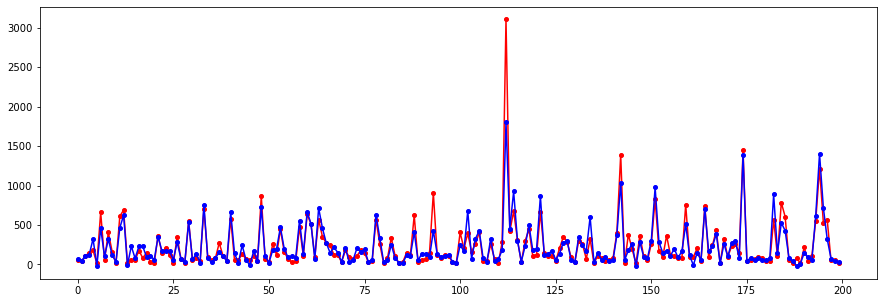

In [155]:
compare_in_plot(y_valid, y_pred_xgbt_rmsle)

The model with rmsle as evaluation method doesn't attain a good performanc as my expected. Although the RMSLE value has a slight decrease, the R2 value also scrafice with a signification decrease. Therefore, I turn back to use the default objective function and evaluation method for a regression method.

In [151]:
XGBmodel = xgb.train({'max_depth':7, 'eta':0.3, 'subsample':0.7, 'colsample_bytree':0.8},
          dtrain=dtrain,num_boost_round=1000,
          evals=[(dtrain, 'dtrain'), (dtest, 'dtest')])

[0]	dtrain-rmse:382.14639	dtest-rmse:382.46017
[1]	dtrain-rmse:320.44583	dtest-rmse:322.01382
[2]	dtrain-rmse:277.13788	dtest-rmse:280.20590
[3]	dtrain-rmse:249.97170	dtest-rmse:254.07719
[4]	dtrain-rmse:234.12930	dtest-rmse:239.20326
[5]	dtrain-rmse:220.83223	dtest-rmse:226.49580
[6]	dtrain-rmse:212.07451	dtest-rmse:218.47203
[7]	dtrain-rmse:206.07295	dtest-rmse:213.56459
[8]	dtrain-rmse:202.61136	dtest-rmse:210.01804
[9]	dtrain-rmse:199.51175	dtest-rmse:207.72250
[10]	dtrain-rmse:196.14400	dtest-rmse:204.60881
[11]	dtrain-rmse:193.54094	dtest-rmse:202.96434
[12]	dtrain-rmse:190.63400	dtest-rmse:201.15123
[13]	dtrain-rmse:188.74558	dtest-rmse:199.64258
[14]	dtrain-rmse:187.01294	dtest-rmse:197.93732
[15]	dtrain-rmse:185.34648	dtest-rmse:196.47719
[16]	dtrain-rmse:182.45653	dtest-rmse:194.54314
[17]	dtrain-rmse:181.69495	dtest-rmse:194.03661
[18]	dtrain-rmse:179.61433	dtest-rmse:192.27539
[19]	dtrain-rmse:178.79309	dtest-rmse:191.69426
[20]	dtrain-rmse:177.53626	dtest-rmse:190.77339
[2

[170]	dtrain-rmse:129.15085	dtest-rmse:163.34407
[171]	dtrain-rmse:129.02554	dtest-rmse:163.30872
[172]	dtrain-rmse:128.87212	dtest-rmse:163.32445
[173]	dtrain-rmse:128.70496	dtest-rmse:163.34183
[174]	dtrain-rmse:128.38136	dtest-rmse:163.22653
[175]	dtrain-rmse:128.15779	dtest-rmse:163.23494
[176]	dtrain-rmse:128.07088	dtest-rmse:163.19817
[177]	dtrain-rmse:127.85840	dtest-rmse:163.04719
[178]	dtrain-rmse:127.74203	dtest-rmse:163.14499
[179]	dtrain-rmse:127.61302	dtest-rmse:163.13936
[180]	dtrain-rmse:127.53019	dtest-rmse:163.12294
[181]	dtrain-rmse:127.31490	dtest-rmse:163.12224
[182]	dtrain-rmse:127.10892	dtest-rmse:162.99319
[183]	dtrain-rmse:127.04962	dtest-rmse:162.99663
[184]	dtrain-rmse:126.86304	dtest-rmse:162.94290
[185]	dtrain-rmse:126.70658	dtest-rmse:162.90358
[186]	dtrain-rmse:126.40018	dtest-rmse:162.82198
[187]	dtrain-rmse:126.30644	dtest-rmse:162.85054
[188]	dtrain-rmse:126.19621	dtest-rmse:162.86173
[189]	dtrain-rmse:125.94566	dtest-rmse:162.89232
[190]	dtrain-rmse:12

[338]	dtrain-rmse:111.36007	dtest-rmse:159.29047
[339]	dtrain-rmse:111.31532	dtest-rmse:159.26689
[340]	dtrain-rmse:111.23433	dtest-rmse:159.25835
[341]	dtrain-rmse:111.17886	dtest-rmse:159.23843
[342]	dtrain-rmse:111.04192	dtest-rmse:159.23398
[343]	dtrain-rmse:110.99075	dtest-rmse:159.20966
[344]	dtrain-rmse:110.91452	dtest-rmse:159.18346
[345]	dtrain-rmse:110.85488	dtest-rmse:159.19133
[346]	dtrain-rmse:110.81172	dtest-rmse:159.22638
[347]	dtrain-rmse:110.73256	dtest-rmse:159.19253
[348]	dtrain-rmse:110.69005	dtest-rmse:159.17866
[349]	dtrain-rmse:110.60614	dtest-rmse:159.14125
[350]	dtrain-rmse:110.56136	dtest-rmse:159.14638
[351]	dtrain-rmse:110.51701	dtest-rmse:159.15001
[352]	dtrain-rmse:110.42264	dtest-rmse:159.15759
[353]	dtrain-rmse:110.30417	dtest-rmse:159.11238
[354]	dtrain-rmse:110.22270	dtest-rmse:159.14499
[355]	dtrain-rmse:110.17246	dtest-rmse:159.14978
[356]	dtrain-rmse:110.09142	dtest-rmse:159.10382
[357]	dtrain-rmse:110.01452	dtest-rmse:159.10959
[358]	dtrain-rmse:10

[506]	dtrain-rmse:101.29582	dtest-rmse:158.32828
[507]	dtrain-rmse:101.26092	dtest-rmse:158.33838
[508]	dtrain-rmse:101.22694	dtest-rmse:158.34125
[509]	dtrain-rmse:101.14121	dtest-rmse:158.26207
[510]	dtrain-rmse:101.05638	dtest-rmse:158.19972
[511]	dtrain-rmse:101.00220	dtest-rmse:158.18695
[512]	dtrain-rmse:100.90938	dtest-rmse:158.18204
[513]	dtrain-rmse:100.86276	dtest-rmse:158.20154
[514]	dtrain-rmse:100.81851	dtest-rmse:158.23869
[515]	dtrain-rmse:100.78098	dtest-rmse:158.22626
[516]	dtrain-rmse:100.74542	dtest-rmse:158.21593
[517]	dtrain-rmse:100.69865	dtest-rmse:158.21779
[518]	dtrain-rmse:100.64616	dtest-rmse:158.22798
[519]	dtrain-rmse:100.60032	dtest-rmse:158.24297
[520]	dtrain-rmse:100.55128	dtest-rmse:158.23920
[521]	dtrain-rmse:100.51582	dtest-rmse:158.24716
[522]	dtrain-rmse:100.49051	dtest-rmse:158.23463
[523]	dtrain-rmse:100.46440	dtest-rmse:158.24202
[524]	dtrain-rmse:100.43721	dtest-rmse:158.26607
[525]	dtrain-rmse:100.34834	dtest-rmse:158.23648
[526]	dtrain-rmse:10

[677]	dtrain-rmse:94.27610	dtest-rmse:158.55456
[678]	dtrain-rmse:94.24240	dtest-rmse:158.55183
[679]	dtrain-rmse:94.18749	dtest-rmse:158.53885
[680]	dtrain-rmse:94.14732	dtest-rmse:158.55087
[681]	dtrain-rmse:94.11462	dtest-rmse:158.58409
[682]	dtrain-rmse:94.09403	dtest-rmse:158.60365
[683]	dtrain-rmse:94.05969	dtest-rmse:158.63382
[684]	dtrain-rmse:94.02670	dtest-rmse:158.64729
[685]	dtrain-rmse:93.99200	dtest-rmse:158.65482
[686]	dtrain-rmse:93.95598	dtest-rmse:158.59731
[687]	dtrain-rmse:93.90447	dtest-rmse:158.60486
[688]	dtrain-rmse:93.87079	dtest-rmse:158.60545
[689]	dtrain-rmse:93.85373	dtest-rmse:158.60635
[690]	dtrain-rmse:93.81270	dtest-rmse:158.59625
[691]	dtrain-rmse:93.78108	dtest-rmse:158.60162
[692]	dtrain-rmse:93.74643	dtest-rmse:158.60178
[693]	dtrain-rmse:93.72189	dtest-rmse:158.62177
[694]	dtrain-rmse:93.70525	dtest-rmse:158.63385
[695]	dtrain-rmse:93.67430	dtest-rmse:158.61655
[696]	dtrain-rmse:93.64120	dtest-rmse:158.61646
[697]	dtrain-rmse:93.62545	dtest-rmse:15

[848]	dtrain-rmse:89.04034	dtest-rmse:158.78377
[849]	dtrain-rmse:89.02118	dtest-rmse:158.77508
[850]	dtrain-rmse:88.99809	dtest-rmse:158.77884
[851]	dtrain-rmse:88.96305	dtest-rmse:158.79288
[852]	dtrain-rmse:88.92548	dtest-rmse:158.80461
[853]	dtrain-rmse:88.89215	dtest-rmse:158.82948
[854]	dtrain-rmse:88.85970	dtest-rmse:158.83075
[855]	dtrain-rmse:88.83000	dtest-rmse:158.83601
[856]	dtrain-rmse:88.78836	dtest-rmse:158.82625
[857]	dtrain-rmse:88.77465	dtest-rmse:158.82829
[858]	dtrain-rmse:88.75331	dtest-rmse:158.82548
[859]	dtrain-rmse:88.72372	dtest-rmse:158.82169
[860]	dtrain-rmse:88.70309	dtest-rmse:158.83666
[861]	dtrain-rmse:88.67426	dtest-rmse:158.84866
[862]	dtrain-rmse:88.63789	dtest-rmse:158.87257
[863]	dtrain-rmse:88.61971	dtest-rmse:158.87041
[864]	dtrain-rmse:88.60293	dtest-rmse:158.86493
[865]	dtrain-rmse:88.58914	dtest-rmse:158.87039
[866]	dtrain-rmse:88.57025	dtest-rmse:158.88329
[867]	dtrain-rmse:88.53426	dtest-rmse:158.87257
[868]	dtrain-rmse:88.48977	dtest-rmse:15

### MLP

In [159]:
! pip install keras
! pip install tensorflow

  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30702 sha256=36ad66c2f99a16aadb70c7b9c3eb1df321b5afa37c26eb293884d7d9c5642333
  Stored in directory: c:\users\zyang672\appdata\local\pip\cache\wheels\98\91\04\971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=d4303cec88e938e9f44dd937f3bd99a56b6b63d2de21784d5eaa2c723cd49389
  Stored in directory: c:\users\zyang672\appdata\local\pip\cache\wheels\3f\e3\ec\8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-win_amd64.whl size=33412 sha256=011d4bac8e97f5a6d51cad5188aef281a8b6491ec0d0d2dddbd7b0cbe40af88b
  Stored in directory: c:\users\zyang672\appdata\local\pip\cache\wheels\62\76\4c\aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clan

In [258]:
from keras.models import Sequential
from keras.layers import Dense

In [259]:
# define the keras model
model = Sequential()
model.add(Dense(86, input_dim=86, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(30, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

In [260]:
# compile the keras model
model.compile(loss='mean_squared_error', optimizer='adam')
# fit the keras model on the dataset
model.fit(x_train, y_train, epochs=250, batch_size=10)
# evaluate the keras model

Epoch 1/250
34242/34242 [==============================] - 43s 1ms/step - loss: 55086.3906
Epoch 2/250
34242/34242 [==============================] - 39s 1ms/step - loss: 45443.5859
Epoch 3/250
34242/34242 [==============================] - 37s 1ms/step - loss: 42743.6016
Epoch 4/250
34242/34242 [==============================] - 38s 1ms/step - loss: 41150.6758
Epoch 5/250
34242/34242 [==============================] - 38s 1ms/step - loss: 40095.5977
Epoch 6/250
34242/34242 [==============================] - 44s 1ms/step - loss: 38889.2031
Epoch 7/250
34242/34242 [==============================] - 42s 1ms/step - loss: 38657.9297
Epoch 8/250
34242/34242 [==============================] - 41s 1ms/step - loss: 38137.3242
Epoch 9/250
34242/34242 [==============================] - 43s 1ms/step - loss: 38060.7305
Epoch 10/250
34242/34242 [==============================] - 42s 1ms/step - loss: 37379.8672
Epoch 11/250
34242/34242 [==============================] - 46s 1ms/step - loss: 37288.91

34242/34242 [==============================] - 37s 1ms/step - loss: 30683.0840
Epoch 91/250
34242/34242 [==============================] - 35s 1ms/step - loss: 30869.1992
Epoch 92/250
34242/34242 [==============================] - 35s 1ms/step - loss: 30700.1934
Epoch 93/250
34242/34242 [==============================] - 37s 1ms/step - loss: 30469.6445
Epoch 94/250
34242/34242 [==============================] - 38s 1ms/step - loss: 30847.9668
Epoch 95/250
34242/34242 [==============================] - 38s 1ms/step - loss: 30735.1777
Epoch 96/250
34242/34242 [==============================] - 38s 1ms/step - loss: 30451.1406
Epoch 97/250
34242/34242 [==============================] - 36s 1ms/step - loss: 30649.5371
Epoch 98/250
34242/34242 [==============================] - 36s 1ms/step - loss: 30283.5156
Epoch 99/250
34242/34242 [==============================] - 36s 1ms/step - loss: 30332.6758
Epoch 100/250
34242/34242 [==============================] - 36s 1ms/step - loss: 30593.3945


34242/34242 [==============================] - 32s 928us/step - loss: 28848.1074
Epoch 179/250
34242/34242 [==============================] - 31s 903us/step - loss: 28748.3730
Epoch 180/250
34242/34242 [==============================] - 32s 931us/step - loss: 28559.4199
Epoch 181/250
34242/34242 [==============================] - 32s 936us/step - loss: 28815.1133
Epoch 182/250
34242/34242 [==============================] - 33s 951us/step - loss: 28655.3613
Epoch 183/250
34242/34242 [==============================] - 31s 897us/step - loss: 28561.7891
Epoch 184/250
34242/34242 [==============================] - 31s 911us/step - loss: 28374.4688
Epoch 185/250
34242/34242 [==============================] - 31s 906us/step - loss: 28467.4336
Epoch 186/250
34242/34242 [==============================] - 33s 968us/step - loss: 28563.7480
Epoch 187/250
34242/34242 [==============================] - 31s 905us/step - loss: 28395.8066
Epoch 188/250
34242/34242 [==============================] - 373

In [261]:
y_pred_mlp = model.predict(x_valid)

In [262]:
result(y_valid, y_pred_mlp)

MSE:
 37638.046861780174
MAE:
 93.50026243597819
R2 score:
 0.7587912334541561


In [263]:
RMSLE(y_valid, y_pred_mlp)

0.2657287393570695

C:\Users\zyang672\AppData\Local\Continuum\anaconda2\envs\newpython3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


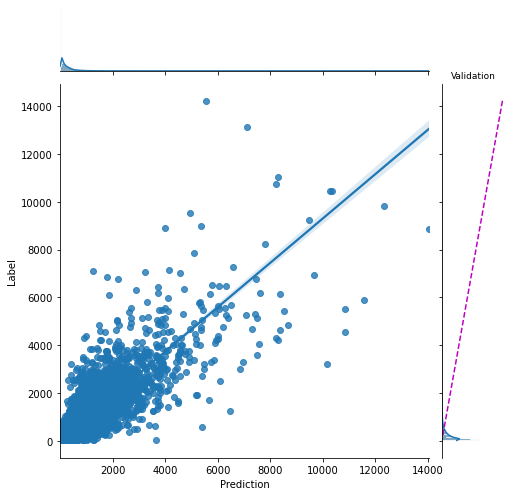

In [270]:
model_performance_sc_plot(y_pred_mlp, y_valid, 'Validation')

In [276]:
y_pred_mlp_test = model.predict(x_test)


### Ensembling method

**Ensemble architecture:**

**1st level**:

- MLP
- XGBM
- Random forest
- Linear Regression
- KNN

**2nd level**;
- Linear Regression

Create new datasets with the predictions from first level models.

1. Here I'll be using a simple ensembling technique, I'll use the 1st level models predictions as the input for the 2nd level model, this way the 2nd level model will basically use the 1st level models predictions as features and learn where to give more weight.
2. To use this technique I also need to use the 1st level models and make predictions on the test set, so I can use them on the 2nd level model.
3. I could also pass the complete validation set with extra features (the 1st level models prediction) to the 2nd level model and let it do a little more work on finding the solution.

In [287]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(y_pred_mlp, columns=['mlp'])
first_level['xgbt'] = y_pred_xgbt
first_level['random_forest'] = y_pred_rf
first_level['linear_regression'] = y_pred_lr
first_level['knn'] = y_pred_knn
#first_level['label'] = y_valid.tolist()
first_level.head(20)

mlp        xgbt  random_forest  linear_regression    knn
0    47.514481   26.637302      49.040000         -62.160156   53.8
1    39.981911   36.621243      39.950000          10.027344   37.4
2   227.193192   89.814636     154.880000         420.175781  132.8
3   144.469620   91.594543     137.160000         329.832031  111.0
4   346.452698  429.423309     358.210000         494.562500  416.4
5    47.514481   22.909506      27.220000         -71.230469   37.6
6   360.612427  482.303467     538.120000         435.503906  535.8
7   172.392853   82.189667      77.650000         318.652344   68.0
8   136.369904  357.397278     341.106667         521.011719  181.0
9   131.035751  120.375114      87.400000          96.574219   84.8
10   24.638891   27.023952      31.080000          13.722656   20.0
11  314.438751  408.069885     433.230000         430.347656  376.0
12  524.518982  555.836914     463.680000         671.402344  510.6
13   55.988144   -3.900289      20.410000        -202.027344   25.4
14  164.771866  255.324982     159.420000         328.917969  143.0
15   53.472816   47.132980      99.350000         165.644531   76.0
16  282.163422  294.101654     238.380000         385.527344  251.8
17  289.556030  305.122406     232.339167         615.769531  251.4
18   56.786041   73.423988      48.930000         166.230469   67.8
19  143.033768   94.239388      86.250000         147.464844  119.4

In [286]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(y_pred_mlp_test, columns=['mlp'])
first_level_test['xgbt'] = y_pred_xgbt_test
first_level_test['random_forest'] = y_pred_rf_test
first_level_test['linear_regression'] = y_pred_lr_test
first_level_test['knn'] = y_pred_knn_test
first_level_test.head()


mlp        xgbt  random_forest  linear_regression         knn
0  189.706970  218.102280     119.150333         371.808594  130.261836
1  188.512619  181.369888     120.015000         370.496094  130.363273
2  190.237122  234.997986     117.123333         372.441406  130.152042
3   47.514481   57.600868      76.840000         -45.863281   69.806001
4   47.514481   28.634598      73.400000         -46.949219   72.318122

In [289]:
LRmodel_ensemble = LinearRegression()
LRmodel_ensemble.fit(first_level, y_valid)
ensemble_pred = LRmodel_ensemble.predict(first_level)
y_pred_ensemble_test = LRmodel_ensemble.predict(first_level_test)

In [290]:
result(y_valid, ensemble_pred)

MSE:
 23241.433208359107
MAE:
 78.3574746158105
R2 score:
 0.8510539758470144


In [291]:
RMSLE(y_valid, ensemble_pred)

0.2592316133918259

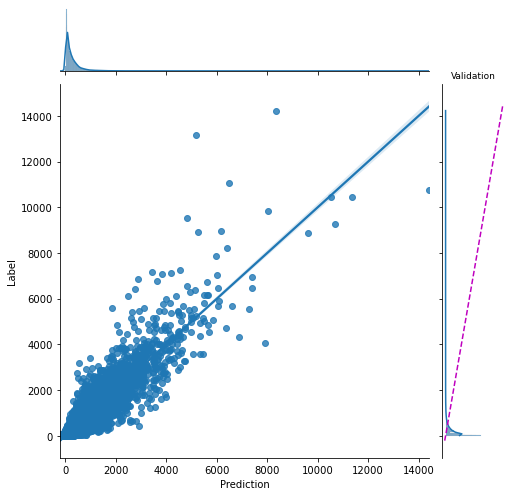

In [292]:
model_performance_sc_plot(ensemble_pred, y_valid, 'Validation')

# Summary

| method | MSE | MAE | R2 | RMSLE |
| ----------- | ----------- | ----------- | ----------- | ----------- | 
| Linear regression | 87319.9 | 162.2 | 0.4404 | 0.7421
| SVR | 92743.0 | 122.3 | 0.4056 | 0.2980 |
| KNN | 42051.4 | 91.2 |0.7305 | 0.2453 |
| Random Forest | 29204.6 | 83.0 | 0.8128 | 0.2371 |
| XGBoost | 23538.8 | 79.6 | 0.8491 | 0.2783 |
| MLP | 37638.0 | 93.5 | 0.7588 | 0.2657 |
| **Ensembling** | **23241.4** | **78.4** | **0.8511** | **0.2592** | 